In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, utils, backend, optimizers, metrics, losses, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

import matplotlib.pyplot as plt

from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from numpy import asarray
import glob

#train test split
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from scipy import stats



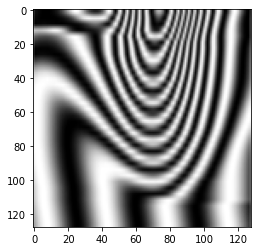

In [2]:
img_size =128
newsize=(img_size,img_size)

images =[]
for file in sorted(glob.glob("./fringes_961_PU_Nocor/*.png")):
    cur_img = asarray(Image.open(file).resize(newsize))
    cur_img = cur_img-np.mean(cur_img)

    images.append(cur_img)
    
images_array = asarray(images)

#images_array_crop = images_array[:, 20:105, 31:95]

images_array_crop = images_array[:, :, :]


    

#check one img
plt.imshow(images_array_crop[400],cmap='gray')



In [3]:
# reshape and norm img
img_size=64
train_images_my = images_array_crop.reshape(-1, images_array_crop.shape[1], images_array_crop.shape[2], 1)
train_images_my_norm = train_images_my/255
train_images_my.shape

(961, 128, 128, 1)

In [4]:
#define norm to [1,2]
def norm_max_min(y_label):
    min_val = np.min(y_label)
    max_val = np.max(y_label)
    return (y_label-min_val)/(max_val-min_val)+1


In [6]:
#load label from matlab
import scipy.io
label_mat = scipy.io.loadmat('label.mat')
train_labels_my = np.asarray(label_mat['label'])
coh_data = train_labels_my[0]

coh_data
label_nubmer = train_labels_my.shape[1]
#toughness =[]

sigma_c =[]
delta_f =[]
label_train = []
for i in range(0,label_nubmer):
    sigma_c.append(coh_data[i][0][0]/100)
    delta_f.append(coh_data[i][0][1]/1000)
    
    label_train.append([coh_data[i][0][0]/100,coh_data[i][0][1]/1000])

sigma_c = np.asarray(sigma_c) 
delta_f = np.asarray(delta_f) 

label_train =  np.asarray(label_train) 

#norm

sigma_c_norm = norm_max_min(sigma_c)
delta_f_norm = norm_max_min(delta_f)


label_tuple = (sigma_c_norm ,delta_f_norm) 
#label_tuple


In [8]:
#prepare the label
label_train_norm =[]
for i in range(len(sigma_c_norm)):
    label_train_norm.append([sigma_c_norm[i],delta_f_norm[i]])
label_train_norm =  np.asarray(label_train_norm) 

In [9]:
#start from here

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(train_images_my_norm, label_train_norm, test_size=0.1)


# split train into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

#X_test = X_test[0:round(len(X_train)*0.2)]
#y_test = y_test[0:round(len(X_train)*0.2)]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(691, 128, 128, 1) (691, 2) (173, 128, 128, 1) (173, 2) (97, 128, 128, 1) (97, 2)


In [10]:
#put y_train, y_val, y_test into tuples to framework


sigma_list_train=[]
delta_list_train=[]
for val in y_train:
    sigma_list_train.append(val[0])
    delta_list_train.append(val[1])
    
sigma_list_train = np.array(sigma_list_train )
delta_list_train = np.array(delta_list_train )
y_train_tuple = (sigma_list_train, delta_list_train) 



sigma_list_test=[]
delta_list_test=[]
for val in y_test:
    sigma_list_test.append(val[0])
    delta_list_test.append(val[1])
    
sigma_list_test = np.array(sigma_list_test )
delta_list_test = np.array(delta_list_test )
y_test_tuple = (sigma_list_test, delta_list_test) 




sigma_list_val=[]
delta_list_val=[]
for val in y_val:
    sigma_list_val.append(val[0])
    delta_list_val.append(val[1])
    
sigma_list_val = np.array(sigma_list_val )
delta_list_val = np.array(delta_list_val )
y_val_tuple = (sigma_list_val, delta_list_val) 

In [50]:
class MyFringeModel(Model):
    
    def __init__(self, activation=layers.LeakyReLU(alpha=0.01), **kwargs):
        '''initializes the instance attributes'''
        super().__init__(**kwargs)
        
        self.first_conv = layers.Conv2D(12, (3, 3), activation=activation)
        self.first_pool = layers.MaxPooling2D((2, 2))
        
        self.second_conv = layers.Conv2D(2, (3, 3), activation=activation)
        self.second_pool = layers.MaxPooling2D((2, 2))
        
        self.first_batch = layers.BatchNormalization()
        self.second_batch = layers.BatchNormalization()
        
        self.flatten_layer = layers.Flatten()
        
        
        self.dense_layer= layers.Dense(8, activation=activation)
        self.dense_layer_1= layers.Dense(4, activation=activation)
        #self.dense_layer_2= layers.Dense(4, activation=activation)
        
        self.sigma_output = layers.Dense(1, name='sigma_output')
        self.delta_output = layers.Dense(1, name='delta_output')

    def call(self, inputs):
        '''defines the network architecture'''
        first_conv = self.first_conv(inputs)
        first_batch = self.first_batch(first_conv)
        first_pool = self.first_pool(first_batch)
        
        second_conv = self.second_conv(first_pool)
        second_batch = self.second_batch(second_conv) 
        second_pool = self.second_pool(second_batch)
        
        flatten_layer = self.flatten_layer(second_pool)
        
        
        dense_layer = self.dense_layer(flatten_layer)
        dense_layer_1 = self.dense_layer_1(dense_layer)
        #dense_layer_2 = self.dense_layer_2(dense_layer)
        
        sigma_output = self.sigma_output(dense_layer_1)
        delta_output = self.delta_output(dense_layer)
        
        outputs=[sigma_output, delta_output]
        
        return outputs

In [52]:
class MyFringeModel(Model):
    
    def __init__(self, activation=layers.LeakyReLU(alpha=0.01), **kwargs):
        '''initializes the instance attributes'''
        super().__init__(**kwargs)
        
        self.first_conv = layers.Conv2D(2, (3, 3), activation=activation)
        self.first_pool = layers.MaxPooling2D((2, 2))
        
        
        self.first_batch = layers.BatchNormalization()
        
        self.flatten_layer = layers.Flatten()
        
        
        self.dense_layer= layers.Dense(4, activation=activation)
        self.dense_layer_1= layers.Dense(2, activation=activation)
        self.dense_layer_2= layers.Dense(2, activation=activation)
        
        self.sigma_output = layers.Dense(1, name='sigma_output')
        self.delta_output = layers.Dense(1, name='delta_output')

    def call(self, inputs):
        '''defines the network architecture'''
        first_conv = self.first_conv(inputs)
        first_batch = self.first_batch(first_conv)
        first_pool = self.first_pool(first_batch)

        
        flatten_layer = self.flatten_layer(first_pool)
        
        
        dense_layer = self.dense_layer(flatten_layer)
        dense_layer_1 = self.dense_layer_1(dense_layer)
        dense_layer_2 = self.dense_layer_2(dense_layer)
        
        sigma_output = self.sigma_output(dense_layer_1)
        delta_output = self.delta_output(dense_layer_2)
        
        outputs=[sigma_output, delta_output]
        
        return outputs

In [53]:
# create an instance of the model

model = MyFringeModel()
model.build([None,images_array_crop.shape[1], images_array_crop.shape[2],1])
model.summary()

Model: "my_fringe_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  20        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
batch_normalization_2 (Batch multiple                  8         
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  31756     
_________________________________________________________________
dense_6 (Dense)              multiple                  10        
_________________________________________________________________
dense_7 (Dense)              multiple            

In [54]:

opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss={'output_1': 'mse', 'output_2': 'mse'},
              metrics={'output_1':  metrics.MeanAbsolutePercentageError(),
                       'output_2':    metrics.MeanAbsolutePercentageError()})

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_output_1_loss',
    mode='max',
    save_best_only=True)


history = model.fit(X_train, y_train_tuple, epochs=2000, batch_size =32,
                   validation_data=(X_val, y_val_tuple),callbacks=[model_checkpoint_callback])

Epoch 1/2000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/22 [===========================>..] - ETA: 0s - loss: 6.1851 - output_1_loss: 4.1506 - output_2_loss: 2.0345 - output_1_mean_absolute_percentage_error: 136.9397 - output_2_mean_absolute_percentage_error: 92.2396WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x297e75550> and will run it 

Epoch 16/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.4208 - output_1_loss: 1.0917 - output_2_loss: 2.3291 - output_1_mean_absolute_percentage_error: 68.8397 - output_2_mean_absolute_percentage_error: 99.5250 - val_loss: 3.8030 - val_output_1_loss: 1.6898 - val_output_2_loss: 2.1132 - val_output_1_mean_absolute_percentage_error: 82.4744 - val_output_2_mean_absolute_percentage_error: 98.3997
Epoch 17/2000
22/22 [==============================] - 0s 11ms/step - loss: 3.3461 - output_1_loss: 1.0012 - output_2_loss: 2.3450 - output_1_mean_absolute_percentage_error: 65.5569 - output_2_mean_absolute_percentage_error: 99.2812 - val_loss: 3.6848 - val_output_1_loss: 1.5622 - val_output_2_loss: 2.1227 - val_output_1_mean_absolute_percentage_error: 79.1175 - val_output_2_mean_absolute_percentage_error: 98.6131
Epoch 18/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.2121 - output_1_loss: 0.9127 - output_2_loss: 2.2994 - output_1_mean_absolute_percenta

Epoch 36/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.1782 - output_1_loss: 0.0237 - output_2_loss: 2.1545 - output_1_mean_absolute_percentage_error: 7.6551 - output_2_mean_absolute_percentage_error: 95.0488 - val_loss: 2.0060 - val_output_1_loss: 0.0284 - val_output_2_loss: 1.9777 - val_output_1_mean_absolute_percentage_error: 7.8460 - val_output_2_mean_absolute_percentage_error: 94.8646
Epoch 37/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.1931 - output_1_loss: 0.0222 - output_2_loss: 2.1709 - output_1_mean_absolute_percentage_error: 7.0952 - output_2_mean_absolute_percentage_error: 94.9177 - val_loss: 1.9924 - val_output_1_loss: 0.0246 - val_output_2_loss: 1.9678 - val_output_1_mean_absolute_percentage_error: 7.3038 - val_output_2_mean_absolute_percentage_error: 94.5830
Epoch 38/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.1615 - output_1_loss: 0.0180 - output_2_loss: 2.1435 - output_1_mean_absolute_percentage_e

Epoch 56/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.0857 - output_1_loss: 0.0078 - output_2_loss: 2.0779 - output_1_mean_absolute_percentage_error: 4.0986 - output_2_mean_absolute_percentage_error: 91.9450 - val_loss: 1.8601 - val_output_1_loss: 0.0103 - val_output_2_loss: 1.8498 - val_output_1_mean_absolute_percentage_error: 4.8614 - val_output_2_mean_absolute_percentage_error: 91.4529
Epoch 57/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.9716 - output_1_loss: 0.0076 - output_2_loss: 1.9641 - output_1_mean_absolute_percentage_error: 4.0458 - output_2_mean_absolute_percentage_error: 91.5993 - val_loss: 1.8541 - val_output_1_loss: 0.0106 - val_output_2_loss: 1.8435 - val_output_1_mean_absolute_percentage_error: 5.0903 - val_output_2_mean_absolute_percentage_error: 91.2888
Epoch 58/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.9944 - output_1_loss: 0.0076 - output_2_loss: 1.9868 - output_1_mean_absolute_percentage_e

Epoch 76/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0158 - output_1_loss: 0.0111 - output_2_loss: 0.0046 - output_1_mean_absolute_percentage_error: 5.7603 - output_2_mean_absolute_percentage_error: 3.5424 - val_loss: 0.0182 - val_output_1_loss: 0.0135 - val_output_2_loss: 0.0047 - val_output_1_mean_absolute_percentage_error: 6.0157 - val_output_2_mean_absolute_percentage_error: 3.6147
Epoch 77/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0145 - output_1_loss: 0.0106 - output_2_loss: 0.0039 - output_1_mean_absolute_percentage_error: 5.5125 - output_2_mean_absolute_percentage_error: 3.2152 - val_loss: 0.0179 - val_output_1_loss: 0.0133 - val_output_2_loss: 0.0046 - val_output_1_mean_absolute_percentage_error: 5.9509 - val_output_2_mean_absolute_percentage_error: 3.5437
Epoch 78/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0148 - output_1_loss: 0.0106 - output_2_loss: 0.0042 - output_1_mean_absolute_percentage_error:

Epoch 96/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0110 - output_1_loss: 0.0083 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 4.5747 - output_2_mean_absolute_percentage_error: 2.7348 - val_loss: 0.0131 - val_output_1_loss: 0.0102 - val_output_2_loss: 0.0029 - val_output_1_mean_absolute_percentage_error: 5.0300 - val_output_2_mean_absolute_percentage_error: 2.8246
Epoch 97/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0101 - output_1_loss: 0.0077 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 4.4309 - output_2_mean_absolute_percentage_error: 2.5140 - val_loss: 0.0131 - val_output_1_loss: 0.0102 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 4.9969 - val_output_2_mean_absolute_percentage_error: 2.7997
Epoch 98/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0108 - output_1_loss: 0.0081 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error:

Epoch 116/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0087 - output_1_loss: 0.0067 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 3.8678 - output_2_mean_absolute_percentage_error: 2.2936 - val_loss: 0.0112 - val_output_1_loss: 0.0089 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 4.5153 - val_output_2_mean_absolute_percentage_error: 2.5290
Epoch 117/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0095 - output_1_loss: 0.0071 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 3.9965 - output_2_mean_absolute_percentage_error: 2.5025 - val_loss: 0.0112 - val_output_1_loss: 0.0089 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 4.4998 - val_output_2_mean_absolute_percentage_error: 2.4945
Epoch 118/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0094 - output_1_loss: 0.0075 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_erro

Epoch 136/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0079 - output_1_loss: 0.0062 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 3.7705 - output_2_mean_absolute_percentage_error: 2.1074 - val_loss: 0.0097 - val_output_1_loss: 0.0080 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 4.1634 - val_output_2_mean_absolute_percentage_error: 2.2425
Epoch 137/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0082 - output_1_loss: 0.0064 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 3.7557 - output_2_mean_absolute_percentage_error: 2.2169 - val_loss: 0.0096 - val_output_1_loss: 0.0079 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 4.1553 - val_output_2_mean_absolute_percentage_error: 2.2321
Epoch 138/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0079 - output_1_loss: 0.0062 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error

Epoch 156/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0072 - output_1_loss: 0.0055 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 3.4732 - output_2_mean_absolute_percentage_error: 2.0556 - val_loss: 0.0086 - val_output_1_loss: 0.0071 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 3.8901 - val_output_2_mean_absolute_percentage_error: 2.0580
Epoch 157/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0072 - output_1_loss: 0.0058 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 3.5353 - output_2_mean_absolute_percentage_error: 1.9239 - val_loss: 0.0085 - val_output_1_loss: 0.0070 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 3.8790 - val_output_2_mean_absolute_percentage_error: 2.0569
Epoch 158/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0068 - output_1_loss: 0.0052 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error

Epoch 176/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0060 - output_1_loss: 0.0046 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 3.0845 - output_2_mean_absolute_percentage_error: 2.0127 - val_loss: 0.0075 - val_output_1_loss: 0.0062 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 3.5987 - val_output_2_mean_absolute_percentage_error: 1.9577
Epoch 177/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0059 - output_1_loss: 0.0044 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 3.0150 - output_2_mean_absolute_percentage_error: 2.0122 - val_loss: 0.0074 - val_output_1_loss: 0.0061 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 3.5880 - val_output_2_mean_absolute_percentage_error: 1.9545
Epoch 178/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0062 - output_1_loss: 0.0048 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error

Epoch 196/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0051 - output_1_loss: 0.0039 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error: 2.7959 - output_2_mean_absolute_percentage_error: 1.7944 - val_loss: 0.0069 - val_output_1_loss: 0.0054 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 3.3051 - val_output_2_mean_absolute_percentage_error: 2.0577
Epoch 197/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0053 - output_1_loss: 0.0040 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 2.7978 - output_2_mean_absolute_percentage_error: 1.8810 - val_loss: 0.0067 - val_output_1_loss: 0.0054 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 3.2937 - val_output_2_mean_absolute_percentage_error: 1.9640
Epoch 198/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0053 - output_1_loss: 0.0041 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error

Epoch 216/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0043 - output_1_loss: 0.0032 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error: 2.5085 - output_2_mean_absolute_percentage_error: 1.7199 - val_loss: 0.0058 - val_output_1_loss: 0.0044 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 2.9944 - val_output_2_mean_absolute_percentage_error: 1.9817
Epoch 217/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0045 - output_1_loss: 0.0034 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error: 2.5214 - output_2_mean_absolute_percentage_error: 1.7813 - val_loss: 0.0056 - val_output_1_loss: 0.0044 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 2.9724 - val_output_2_mean_absolute_percentage_error: 1.9218
Epoch 218/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0044 - output_1_loss: 0.0033 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error

Epoch 236/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0039 - output_1_loss: 0.0028 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error: 2.3509 - output_2_mean_absolute_percentage_error: 1.7967 - val_loss: 0.0048 - val_output_1_loss: 0.0036 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 2.7045 - val_output_2_mean_absolute_percentage_error: 1.9000
Epoch 237/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0041 - output_1_loss: 0.0029 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error: 2.4020 - output_2_mean_absolute_percentage_error: 1.7628 - val_loss: 0.0049 - val_output_1_loss: 0.0037 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 2.6926 - val_output_2_mean_absolute_percentage_error: 1.9002
Epoch 238/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0034 - output_1_loss: 0.0024 - output_2_loss: 0.0010 - output_1_mean_absolute_percentage_erro

Epoch 256/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0030 - output_1_loss: 0.0022 - output_2_loss: 8.2590e-04 - output_1_mean_absolute_percentage_error: 2.0787 - output_2_mean_absolute_percentage_error: 1.5024 - val_loss: 0.0046 - val_output_1_loss: 0.0032 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 2.4915 - val_output_2_mean_absolute_percentage_error: 1.9844
Epoch 257/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0034 - output_1_loss: 0.0023 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error: 2.2022 - output_2_mean_absolute_percentage_error: 1.7024 - val_loss: 0.0045 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 2.4522 - val_output_2_mean_absolute_percentage_error: 2.0701
Epoch 258/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0031 - output_1_loss: 0.0020 - output_2_loss: 0.0010 - output_1_mean_absolute_percentage_

22/22 [==============================] - 0s 9ms/step - loss: 0.0027 - output_1_loss: 0.0018 - output_2_loss: 8.5252e-04 - output_1_mean_absolute_percentage_error: 1.8968 - output_2_mean_absolute_percentage_error: 1.5495 - val_loss: 0.0037 - val_output_1_loss: 0.0025 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 2.2789 - val_output_2_mean_absolute_percentage_error: 1.9565
Epoch 276/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 0.0019 - output_2_loss: 9.2691e-04 - output_1_mean_absolute_percentage_error: 1.9431 - output_2_mean_absolute_percentage_error: 1.6353 - val_loss: 0.0037 - val_output_1_loss: 0.0025 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 2.2603 - val_output_2_mean_absolute_percentage_error: 1.8726
Epoch 277/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0029 - output_1_loss: 0.0020 - output_2_loss: 9.5289e-04 - output_1_mean_absolute_percentage_error: 2

Epoch 295/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 0.0014 - output_2_loss: 8.9539e-04 - output_1_mean_absolute_percentage_error: 1.6623 - output_2_mean_absolute_percentage_error: 1.6306 - val_loss: 0.0033 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 2.1603 - val_output_2_mean_absolute_percentage_error: 1.9090
Epoch 296/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 0.0015 - output_2_loss: 7.9566e-04 - output_1_mean_absolute_percentage_error: 1.7688 - output_2_mean_absolute_percentage_error: 1.5150 - val_loss: 0.0033 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 2.0973 - val_output_2_mean_absolute_percentage_error: 1.8981
Epoch 297/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 0.0014 - output_2_loss: 8.5551e-04 - output_1_mean_absolute_perc

Epoch 315/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 0.0012 - output_2_loss: 7.1375e-04 - output_1_mean_absolute_percentage_error: 1.5595 - output_2_mean_absolute_percentage_error: 1.4407 - val_loss: 0.0030 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 2.0011 - val_output_2_mean_absolute_percentage_error: 1.8374
Epoch 316/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 0.0011 - output_2_loss: 7.3958e-04 - output_1_mean_absolute_percentage_error: 1.5592 - output_2_mean_absolute_percentage_error: 1.4585 - val_loss: 0.0029 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 2.0189 - val_output_2_mean_absolute_percentage_error: 1.7644
Epoch 317/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 0.0011 - output_2_loss: 7.6095e-04 - output_1_mean_absolute_perc

Epoch 335/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 8.9693e-04 - output_2_loss: 6.5054e-04 - output_1_mean_absolute_percentage_error: 1.3903 - output_2_mean_absolute_percentage_error: 1.3540 - val_loss: 0.0027 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0010 - val_output_1_mean_absolute_percentage_error: 1.8353 - val_output_2_mean_absolute_percentage_error: 1.7291
Epoch 336/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 0.0011 - output_2_loss: 6.1850e-04 - output_1_mean_absolute_percentage_error: 1.4791 - output_2_mean_absolute_percentage_error: 1.3422 - val_loss: 0.0027 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.9805 - val_output_2_mean_absolute_percentage_error: 1.8537
Epoch 337/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 0.0011 - output_2_loss: 8.1005e-04 - output_1_mean_absolute_

22/22 [==============================] - 0s 9ms/step - loss: 0.0016 - output_1_loss: 9.1154e-04 - output_2_loss: 6.9576e-04 - output_1_mean_absolute_percentage_error: 1.4222 - output_2_mean_absolute_percentage_error: 1.4009 - val_loss: 0.0025 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0010 - val_output_1_mean_absolute_percentage_error: 1.8827 - val_output_2_mean_absolute_percentage_error: 1.7805
Epoch 355/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0016 - output_1_loss: 9.3578e-04 - output_2_loss: 6.1551e-04 - output_1_mean_absolute_percentage_error: 1.4291 - output_2_mean_absolute_percentage_error: 1.3267 - val_loss: 0.0025 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.8013 - val_output_2_mean_absolute_percentage_error: 1.7979
Epoch 356/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 9.1543e-04 - output_2_loss: 6.2859e-04 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 11ms/step - loss: 0.0013 - output_1_loss: 7.3160e-04 - output_2_loss: 5.3963e-04 - output_1_mean_absolute_percentage_error: 1.2366 - output_2_mean_absolute_percentage_error: 1.2455 - val_loss: 0.0025 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.7589 - val_output_2_mean_absolute_percentage_error: 1.7624
Epoch 374/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0013 - output_1_loss: 7.3796e-04 - output_2_loss: 5.9706e-04 - output_1_mean_absolute_percentage_error: 1.3566 - output_2_mean_absolute_percentage_error: 1.3551 - val_loss: 0.0024 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0010 - val_output_1_mean_absolute_percentage_error: 1.7199 - val_output_2_mean_absolute_percentage_error: 1.6958
Epoch 375/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0013 - output_1_loss: 7.2869e-04 - output_2_loss: 5.5527e-04 - output_1_mean_absolute_perc

22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - output_1_loss: 6.9504e-04 - output_2_loss: 5.1892e-04 - output_1_mean_absolute_percentage_error: 1.2415 - output_2_mean_absolute_percentage_error: 1.2385 - val_loss: 0.0028 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.6526 - val_output_2_mean_absolute_percentage_error: 2.0939
Epoch 393/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - output_1_loss: 7.3586e-04 - output_2_loss: 5.6126e-04 - output_1_mean_absolute_percentage_error: 1.2702 - output_2_mean_absolute_percentage_error: 1.2953 - val_loss: 0.0025 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.6811 - val_output_2_mean_absolute_percentage_error: 1.7038
Epoch 394/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - output_1_loss: 6.3290e-04 - output_2_loss: 5.6613e-04 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 6.2733e-04 - output_2_loss: 4.1327e-04 - output_1_mean_absolute_percentage_error: 1.2278 - output_2_mean_absolute_percentage_error: 1.0770 - val_loss: 0.0027 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.7627 - val_output_2_mean_absolute_percentage_error: 1.9034
Epoch 412/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - output_1_loss: 6.4807e-04 - output_2_loss: 5.2628e-04 - output_1_mean_absolute_percentage_error: 1.3009 - output_2_mean_absolute_percentage_error: 1.2075 - val_loss: 0.0025 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.6894 - val_output_2_mean_absolute_percentage_error: 1.7019
Epoch 413/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 5.6231e-04 - output_2_loss: 4.8291e-04 - output_1_mean_absolute_percent

Epoch 430/2000
22/22 [==============================] - 0s 10ms/step - loss: 9.1432e-04 - output_1_loss: 5.1879e-04 - output_2_loss: 3.9553e-04 - output_1_mean_absolute_percentage_error: 1.1077 - output_2_mean_absolute_percentage_error: 1.0478 - val_loss: 0.0021 - val_output_1_loss: 0.0012 - val_output_2_loss: 9.3037e-04 - val_output_1_mean_absolute_percentage_error: 1.5340 - val_output_2_mean_absolute_percentage_error: 1.5541
Epoch 431/2000
22/22 [==============================] - 0s 10ms/step - loss: 9.4842e-04 - output_1_loss: 5.3412e-04 - output_2_loss: 4.1430e-04 - output_1_mean_absolute_percentage_error: 1.1088 - output_2_mean_absolute_percentage_error: 1.1070 - val_loss: 0.0021 - val_output_1_loss: 0.0012 - val_output_2_loss: 9.4258e-04 - val_output_1_mean_absolute_percentage_error: 1.5919 - val_output_2_mean_absolute_percentage_error: 1.5830
Epoch 432/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 5.9489e-04 - output_2_loss: 4.3433e-04

22/22 [==============================] - 0s 9ms/step - loss: 9.9521e-04 - output_1_loss: 5.6193e-04 - output_2_loss: 4.3328e-04 - output_1_mean_absolute_percentage_error: 1.1923 - output_2_mean_absolute_percentage_error: 1.1279 - val_loss: 0.0023 - val_output_1_loss: 0.0013 - val_output_2_loss: 9.5978e-04 - val_output_1_mean_absolute_percentage_error: 1.5846 - val_output_2_mean_absolute_percentage_error: 1.5731
Epoch 450/2000
22/22 [==============================] - 0s 9ms/step - loss: 8.5799e-04 - output_1_loss: 4.9285e-04 - output_2_loss: 3.6514e-04 - output_1_mean_absolute_percentage_error: 1.0613 - output_2_mean_absolute_percentage_error: 1.0301 - val_loss: 0.0024 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.5658 - val_output_2_mean_absolute_percentage_error: 1.7021
Epoch 451/2000
22/22 [==============================] - 0s 10ms/step - loss: 8.8653e-04 - output_1_loss: 4.7476e-04 - output_2_loss: 4.1176e-04 - output_1_mean

22/22 [==============================] - 0s 9ms/step - loss: 8.0896e-04 - output_1_loss: 4.4558e-04 - output_2_loss: 3.6338e-04 - output_1_mean_absolute_percentage_error: 0.9812 - output_2_mean_absolute_percentage_error: 1.0241 - val_loss: 0.0022 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.5283 - val_output_2_mean_absolute_percentage_error: 1.7569
Epoch 469/2000
22/22 [==============================] - 0s 9ms/step - loss: 9.1546e-04 - output_1_loss: 4.8379e-04 - output_2_loss: 4.3167e-04 - output_1_mean_absolute_percentage_error: 1.0674 - output_2_mean_absolute_percentage_error: 1.0795 - val_loss: 0.0020 - val_output_1_loss: 0.0011 - val_output_2_loss: 8.9194e-04 - val_output_1_mean_absolute_percentage_error: 1.5548 - val_output_2_mean_absolute_percentage_error: 1.5199
Epoch 470/2000
22/22 [==============================] - 0s 9ms/step - loss: 8.7875e-04 - output_1_loss: 4.7497e-04 - output_2_loss: 4.0378e-04 - output_1_mean_

22/22 [==============================] - 0s 9ms/step - loss: 7.2727e-04 - output_1_loss: 3.7061e-04 - output_2_loss: 3.5666e-04 - output_1_mean_absolute_percentage_error: 0.9963 - output_2_mean_absolute_percentage_error: 0.9933 - val_loss: 0.0020 - val_output_1_loss: 0.0011 - val_output_2_loss: 9.3694e-04 - val_output_1_mean_absolute_percentage_error: 1.4328 - val_output_2_mean_absolute_percentage_error: 1.5377
Epoch 488/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.5273e-04 - output_1_loss: 3.9619e-04 - output_2_loss: 3.5654e-04 - output_1_mean_absolute_percentage_error: 1.0052 - output_2_mean_absolute_percentage_error: 1.0166 - val_loss: 0.0021 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0010 - val_output_1_mean_absolute_percentage_error: 1.4460 - val_output_2_mean_absolute_percentage_error: 1.6370
Epoch 489/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.5073e-04 - output_1_loss: 3.8050e-04 - output_2_loss: 3.7023e-04 - output_1_mean_

22/22 [==============================] - 0s 9ms/step - loss: 0.0011 - output_1_loss: 5.4582e-04 - output_2_loss: 5.4806e-04 - output_1_mean_absolute_percentage_error: 1.2308 - output_2_mean_absolute_percentage_error: 1.2435 - val_loss: 0.0035 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 2.1904 - val_output_2_mean_absolute_percentage_error: 2.3001
Epoch 507/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0011 - output_1_loss: 6.1769e-04 - output_2_loss: 5.0245e-04 - output_1_mean_absolute_percentage_error: 1.3346 - output_2_mean_absolute_percentage_error: 1.2448 - val_loss: 0.0019 - val_output_1_loss: 9.7560e-04 - val_output_2_loss: 9.0632e-04 - val_output_1_mean_absolute_percentage_error: 1.3946 - val_output_2_mean_absolute_percentage_error: 1.4909
Epoch 508/2000
22/22 [==============================] - 0s 9ms/step - loss: 8.2398e-04 - output_1_loss: 4.7087e-04 - output_2_loss: 3.5311e-04 - output_1_mean_abso

22/22 [==============================] - 0s 10ms/step - loss: 7.1849e-04 - output_1_loss: 4.0383e-04 - output_2_loss: 3.1467e-04 - output_1_mean_absolute_percentage_error: 0.9955 - output_2_mean_absolute_percentage_error: 0.9391 - val_loss: 0.0018 - val_output_1_loss: 9.4826e-04 - val_output_2_loss: 8.7537e-04 - val_output_1_mean_absolute_percentage_error: 1.3657 - val_output_2_mean_absolute_percentage_error: 1.4578
Epoch 526/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.8705e-04 - output_1_loss: 3.5816e-04 - output_2_loss: 3.2889e-04 - output_1_mean_absolute_percentage_error: 0.9666 - output_2_mean_absolute_percentage_error: 0.9673 - val_loss: 0.0019 - val_output_1_loss: 9.7321e-04 - val_output_2_loss: 9.3635e-04 - val_output_1_mean_absolute_percentage_error: 1.3636 - val_output_2_mean_absolute_percentage_error: 1.4800
Epoch 527/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.0734e-04 - output_1_loss: 3.4624e-04 - output_2_loss: 3.6110e-04 - o

22/22 [==============================] - 0s 9ms/step - loss: 8.2030e-04 - output_1_loss: 4.4363e-04 - output_2_loss: 3.7667e-04 - output_1_mean_absolute_percentage_error: 1.0781 - output_2_mean_absolute_percentage_error: 1.0460 - val_loss: 0.0020 - val_output_1_loss: 9.2829e-04 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.3456 - val_output_2_mean_absolute_percentage_error: 1.6414
Epoch 545/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.7765e-04 - output_1_loss: 3.4561e-04 - output_2_loss: 3.3204e-04 - output_1_mean_absolute_percentage_error: 0.9233 - output_2_mean_absolute_percentage_error: 0.9962 - val_loss: 0.0024 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.6210 - val_output_2_mean_absolute_percentage_error: 1.7019
Epoch 546/2000
22/22 [==============================] - 0s 9ms/step - loss: 8.7048e-04 - output_1_loss: 4.9549e-04 - output_2_loss: 3.7499e-04 - output_1_mean_

Epoch 563/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.9006e-04 - output_1_loss: 3.6964e-04 - output_2_loss: 3.2042e-04 - output_1_mean_absolute_percentage_error: 0.9787 - output_2_mean_absolute_percentage_error: 0.9603 - val_loss: 0.0017 - val_output_1_loss: 8.7948e-04 - val_output_2_loss: 8.4077e-04 - val_output_1_mean_absolute_percentage_error: 1.4004 - val_output_2_mean_absolute_percentage_error: 1.4107
Epoch 564/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.0648e-04 - output_1_loss: 3.1826e-04 - output_2_loss: 2.8822e-04 - output_1_mean_absolute_percentage_error: 0.9038 - output_2_mean_absolute_percentage_error: 0.9055 - val_loss: 0.0018 - val_output_1_loss: 8.9799e-04 - val_output_2_loss: 8.8673e-04 - val_output_1_mean_absolute_percentage_error: 1.3140 - val_output_2_mean_absolute_percentage_error: 1.4589
Epoch 565/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.9918e-04 - output_1_loss: 3.7195e-04 - output_2_loss: 

Epoch 582/2000
22/22 [==============================] - 0s 11ms/step - loss: 5.9278e-04 - output_1_loss: 3.0570e-04 - output_2_loss: 2.8708e-04 - output_1_mean_absolute_percentage_error: 0.8841 - output_2_mean_absolute_percentage_error: 0.8762 - val_loss: 0.0017 - val_output_1_loss: 8.4503e-04 - val_output_2_loss: 8.5043e-04 - val_output_1_mean_absolute_percentage_error: 1.3177 - val_output_2_mean_absolute_percentage_error: 1.3806
Epoch 583/2000
22/22 [==============================] - 0s 10ms/step - loss: 5.6522e-04 - output_1_loss: 3.0958e-04 - output_2_loss: 2.5564e-04 - output_1_mean_absolute_percentage_error: 0.8622 - output_2_mean_absolute_percentage_error: 0.8478 - val_loss: 0.0020 - val_output_1_loss: 0.0011 - val_output_2_loss: 8.9515e-04 - val_output_1_mean_absolute_percentage_error: 1.5235 - val_output_2_mean_absolute_percentage_error: 1.4410
Epoch 584/2000
22/22 [==============================] - 0s 10ms/step - loss: 7.7207e-04 - output_1_loss: 4.1289e-04 - output_2_loss: 3

Epoch 601/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.6475e-04 - output_1_loss: 3.1072e-04 - output_2_loss: 2.5403e-04 - output_1_mean_absolute_percentage_error: 0.8929 - output_2_mean_absolute_percentage_error: 0.8356 - val_loss: 0.0019 - val_output_1_loss: 9.4979e-04 - val_output_2_loss: 9.2552e-04 - val_output_1_mean_absolute_percentage_error: 1.4166 - val_output_2_mean_absolute_percentage_error: 1.4485
Epoch 602/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.5094e-04 - output_1_loss: 3.5757e-04 - output_2_loss: 2.9337e-04 - output_1_mean_absolute_percentage_error: 0.9578 - output_2_mean_absolute_percentage_error: 0.9177 - val_loss: 0.0017 - val_output_1_loss: 8.0609e-04 - val_output_2_loss: 8.4924e-04 - val_output_1_mean_absolute_percentage_error: 1.2721 - val_output_2_mean_absolute_percentage_error: 1.3870
Epoch 603/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.2860e-04 - output_1_loss: 3.2328e-04 - output_2_loss: 

Epoch 620/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.4070e-04 - output_1_loss: 2.6574e-04 - output_2_loss: 2.7497e-04 - output_1_mean_absolute_percentage_error: 0.8030 - output_2_mean_absolute_percentage_error: 0.8775 - val_loss: 0.0016 - val_output_1_loss: 7.6424e-04 - val_output_2_loss: 8.1842e-04 - val_output_1_mean_absolute_percentage_error: 1.2585 - val_output_2_mean_absolute_percentage_error: 1.3768
Epoch 621/2000
22/22 [==============================] - 0s 10ms/step - loss: 5.4236e-04 - output_1_loss: 2.7578e-04 - output_2_loss: 2.6658e-04 - output_1_mean_absolute_percentage_error: 0.8261 - output_2_mean_absolute_percentage_error: 0.8653 - val_loss: 0.0017 - val_output_1_loss: 8.2301e-04 - val_output_2_loss: 8.3929e-04 - val_output_1_mean_absolute_percentage_error: 1.2560 - val_output_2_mean_absolute_percentage_error: 1.3498
Epoch 622/2000
22/22 [==============================] - 0s 10ms/step - loss: 5.2482e-04 - output_1_loss: 2.7441e-04 - output_2_loss

Epoch 639/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.6212e-04 - output_1_loss: 3.1571e-04 - output_2_loss: 2.4641e-04 - output_1_mean_absolute_percentage_error: 0.9360 - output_2_mean_absolute_percentage_error: 0.8162 - val_loss: 0.0017 - val_output_1_loss: 8.3318e-04 - val_output_2_loss: 8.2826e-04 - val_output_1_mean_absolute_percentage_error: 1.2838 - val_output_2_mean_absolute_percentage_error: 1.3336
Epoch 640/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.8516e-04 - output_1_loss: 2.5422e-04 - output_2_loss: 2.3094e-04 - output_1_mean_absolute_percentage_error: 0.8085 - output_2_mean_absolute_percentage_error: 0.8111 - val_loss: 0.0018 - val_output_1_loss: 9.2558e-04 - val_output_2_loss: 8.7392e-04 - val_output_1_mean_absolute_percentage_error: 1.3448 - val_output_2_mean_absolute_percentage_error: 1.3863
Epoch 641/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.7411e-04 - output_1_loss: 3.0668e-04 - output_2_loss:

Epoch 658/2000
22/22 [==============================] - 0s 11ms/step - loss: 4.5695e-04 - output_1_loss: 2.1967e-04 - output_2_loss: 2.3728e-04 - output_1_mean_absolute_percentage_error: 0.7143 - output_2_mean_absolute_percentage_error: 0.7936 - val_loss: 0.0015 - val_output_1_loss: 7.2627e-04 - val_output_2_loss: 8.0824e-04 - val_output_1_mean_absolute_percentage_error: 1.2179 - val_output_2_mean_absolute_percentage_error: 1.3143
Epoch 659/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.9302e-04 - output_1_loss: 2.2785e-04 - output_2_loss: 2.6518e-04 - output_1_mean_absolute_percentage_error: 0.7630 - output_2_mean_absolute_percentage_error: 0.8454 - val_loss: 0.0023 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.6393 - val_output_2_mean_absolute_percentage_error: 1.8342
Epoch 660/2000
22/22 [==============================] - 0s 10ms/step - loss: 6.1028e-04 - output_1_loss: 3.1816e-04 - output_2_loss: 2.921

Epoch 677/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.9619e-04 - output_1_loss: 2.3251e-04 - output_2_loss: 2.6368e-04 - output_1_mean_absolute_percentage_error: 0.7893 - output_2_mean_absolute_percentage_error: 0.8422 - val_loss: 0.0015 - val_output_1_loss: 7.1111e-04 - val_output_2_loss: 8.2620e-04 - val_output_1_mean_absolute_percentage_error: 1.1796 - val_output_2_mean_absolute_percentage_error: 1.3569
Epoch 678/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.6928e-04 - output_1_loss: 2.5313e-04 - output_2_loss: 2.1615e-04 - output_1_mean_absolute_percentage_error: 0.8018 - output_2_mean_absolute_percentage_error: 0.7910 - val_loss: 0.0016 - val_output_1_loss: 7.3790e-04 - val_output_2_loss: 8.6173e-04 - val_output_1_mean_absolute_percentage_error: 1.2488 - val_output_2_mean_absolute_percentage_error: 1.4085
Epoch 679/2000
22/22 [==============================] - 0s 10ms/step - loss: 6.4481e-04 - output_1_loss: 3.3479e-04 - output_2_los

22/22 [==============================] - 0s 9ms/step - loss: 4.9118e-04 - output_1_loss: 2.4790e-04 - output_2_loss: 2.4329e-04 - output_1_mean_absolute_percentage_error: 0.7978 - output_2_mean_absolute_percentage_error: 0.8232 - val_loss: 0.0015 - val_output_1_loss: 6.9640e-04 - val_output_2_loss: 8.4208e-04 - val_output_1_mean_absolute_percentage_error: 1.1711 - val_output_2_mean_absolute_percentage_error: 1.3775
Epoch 696/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.6950e-04 - output_1_loss: 2.2216e-04 - output_2_loss: 2.4734e-04 - output_1_mean_absolute_percentage_error: 0.7621 - output_2_mean_absolute_percentage_error: 0.8310 - val_loss: 0.0016 - val_output_1_loss: 7.7053e-04 - val_output_2_loss: 8.7437e-04 - val_output_1_mean_absolute_percentage_error: 1.3061 - val_output_2_mean_absolute_percentage_error: 1.3764
Epoch 697/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.2167e-04 - output_1_loss: 2.0437e-04 - output_2_loss: 2.1730e-04 - ou

Epoch 714/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.6710e-04 - output_1_loss: 2.2474e-04 - output_2_loss: 2.4235e-04 - output_1_mean_absolute_percentage_error: 0.7717 - output_2_mean_absolute_percentage_error: 0.8522 - val_loss: 0.0015 - val_output_1_loss: 6.8903e-04 - val_output_2_loss: 8.0904e-04 - val_output_1_mean_absolute_percentage_error: 1.2514 - val_output_2_mean_absolute_percentage_error: 1.3225
Epoch 715/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.6696e-04 - output_1_loss: 2.3568e-04 - output_2_loss: 2.3128e-04 - output_1_mean_absolute_percentage_error: 0.8147 - output_2_mean_absolute_percentage_error: 0.7981 - val_loss: 0.0015 - val_output_1_loss: 6.9373e-04 - val_output_2_loss: 8.4814e-04 - val_output_1_mean_absolute_percentage_error: 1.1903 - val_output_2_mean_absolute_percentage_error: 1.3440
Epoch 716/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.6520e-04 - output_1_loss: 2.2146e-04 - output_2_loss:

Epoch 733/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.3183e-04 - output_1_loss: 2.1563e-04 - output_2_loss: 2.1620e-04 - output_1_mean_absolute_percentage_error: 0.7457 - output_2_mean_absolute_percentage_error: 0.7796 - val_loss: 0.0015 - val_output_1_loss: 6.9485e-04 - val_output_2_loss: 8.0580e-04 - val_output_1_mean_absolute_percentage_error: 1.1642 - val_output_2_mean_absolute_percentage_error: 1.2691
Epoch 734/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.7884e-04 - output_1_loss: 1.8311e-04 - output_2_loss: 1.9574e-04 - output_1_mean_absolute_percentage_error: 0.6707 - output_2_mean_absolute_percentage_error: 0.6999 - val_loss: 0.0015 - val_output_1_loss: 7.2676e-04 - val_output_2_loss: 8.0288e-04 - val_output_1_mean_absolute_percentage_error: 1.1908 - val_output_2_mean_absolute_percentage_error: 1.2647
Epoch 735/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.8891e-04 - output_1_loss: 1.9679e-04 - output_2_loss:

Epoch 752/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.3490e-04 - output_1_loss: 2.1937e-04 - output_2_loss: 2.1553e-04 - output_1_mean_absolute_percentage_error: 0.7103 - output_2_mean_absolute_percentage_error: 0.7677 - val_loss: 0.0015 - val_output_1_loss: 7.1079e-04 - val_output_2_loss: 8.0809e-04 - val_output_1_mean_absolute_percentage_error: 1.1733 - val_output_2_mean_absolute_percentage_error: 1.2665
Epoch 753/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.8172e-04 - output_1_loss: 1.8365e-04 - output_2_loss: 1.9807e-04 - output_1_mean_absolute_percentage_error: 0.6919 - output_2_mean_absolute_percentage_error: 0.7318 - val_loss: 0.0015 - val_output_1_loss: 6.3816e-04 - val_output_2_loss: 8.1230e-04 - val_output_1_mean_absolute_percentage_error: 1.1118 - val_output_2_mean_absolute_percentage_error: 1.3392
Epoch 754/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.5361e-04 - output_1_loss: 1.6756e-04 - output_2_loss

Epoch 771/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.5187e-04 - output_1_loss: 2.7944e-04 - output_2_loss: 2.7243e-04 - output_1_mean_absolute_percentage_error: 0.8377 - output_2_mean_absolute_percentage_error: 0.8798 - val_loss: 0.0016 - val_output_1_loss: 7.9401e-04 - val_output_2_loss: 8.0579e-04 - val_output_1_mean_absolute_percentage_error: 1.2682 - val_output_2_mean_absolute_percentage_error: 1.2858
Epoch 772/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.0492e-04 - output_1_loss: 2.0298e-04 - output_2_loss: 2.0194e-04 - output_1_mean_absolute_percentage_error: 0.7374 - output_2_mean_absolute_percentage_error: 0.7399 - val_loss: 0.0016 - val_output_1_loss: 7.3211e-04 - val_output_2_loss: 8.2527e-04 - val_output_1_mean_absolute_percentage_error: 1.2012 - val_output_2_mean_absolute_percentage_error: 1.3400
Epoch 773/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.2160e-04 - output_1_loss: 2.0988e-04 - output_2_loss:

Epoch 790/2000
22/22 [==============================] - 0s 10ms/step - loss: 5.0037e-04 - output_1_loss: 2.7133e-04 - output_2_loss: 2.2905e-04 - output_1_mean_absolute_percentage_error: 0.8477 - output_2_mean_absolute_percentage_error: 0.8324 - val_loss: 0.0014 - val_output_1_loss: 6.2324e-04 - val_output_2_loss: 7.7503e-04 - val_output_1_mean_absolute_percentage_error: 1.1748 - val_output_2_mean_absolute_percentage_error: 1.2632
Epoch 791/2000
22/22 [==============================] - 0s 10ms/step - loss: 5.4930e-04 - output_1_loss: 2.7574e-04 - output_2_loss: 2.7356e-04 - output_1_mean_absolute_percentage_error: 0.9041 - output_2_mean_absolute_percentage_error: 0.9124 - val_loss: 0.0015 - val_output_1_loss: 6.4392e-04 - val_output_2_loss: 8.2459e-04 - val_output_1_mean_absolute_percentage_error: 1.1974 - val_output_2_mean_absolute_percentage_error: 1.3496
Epoch 792/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.7776e-04 - output_1_loss: 1.9379e-04 - output_2_los

Epoch 809/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.1192e-04 - output_1_loss: 1.9240e-04 - output_2_loss: 2.1952e-04 - output_1_mean_absolute_percentage_error: 0.7146 - output_2_mean_absolute_percentage_error: 0.7764 - val_loss: 0.0014 - val_output_1_loss: 6.0632e-04 - val_output_2_loss: 7.6423e-04 - val_output_1_mean_absolute_percentage_error: 1.0946 - val_output_2_mean_absolute_percentage_error: 1.2246
Epoch 810/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.8504e-04 - output_1_loss: 1.8961e-04 - output_2_loss: 1.9543e-04 - output_1_mean_absolute_percentage_error: 0.6907 - output_2_mean_absolute_percentage_error: 0.7388 - val_loss: 0.0014 - val_output_1_loss: 6.2539e-04 - val_output_2_loss: 8.1647e-04 - val_output_1_mean_absolute_percentage_error: 1.1098 - val_output_2_mean_absolute_percentage_error: 1.2747
Epoch 811/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.7628e-04 - output_1_loss: 1.9223e-04 - output_2_loss: 

Epoch 828/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.4704e-04 - output_1_loss: 2.5521e-04 - output_2_loss: 1.9183e-04 - output_1_mean_absolute_percentage_error: 0.8157 - output_2_mean_absolute_percentage_error: 0.7231 - val_loss: 0.0017 - val_output_1_loss: 8.6273e-04 - val_output_2_loss: 8.0046e-04 - val_output_1_mean_absolute_percentage_error: 1.3939 - val_output_2_mean_absolute_percentage_error: 1.2333
Epoch 829/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.3181e-04 - output_1_loss: 2.3794e-04 - output_2_loss: 1.9387e-04 - output_1_mean_absolute_percentage_error: 0.7969 - output_2_mean_absolute_percentage_error: 0.7127 - val_loss: 0.0014 - val_output_1_loss: 6.1679e-04 - val_output_2_loss: 8.1356e-04 - val_output_1_mean_absolute_percentage_error: 1.0909 - val_output_2_mean_absolute_percentage_error: 1.2380
Epoch 830/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.1752e-04 - output_1_loss: 1.5730e-04 - output_2_loss

Epoch 847/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.8172e-04 - output_1_loss: 1.9072e-04 - output_2_loss: 1.9100e-04 - output_1_mean_absolute_percentage_error: 0.7524 - output_2_mean_absolute_percentage_error: 0.7174 - val_loss: 0.0014 - val_output_1_loss: 6.0333e-04 - val_output_2_loss: 7.7721e-04 - val_output_1_mean_absolute_percentage_error: 1.1271 - val_output_2_mean_absolute_percentage_error: 1.2450
Epoch 848/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.3793e-04 - output_1_loss: 1.6986e-04 - output_2_loss: 1.6807e-04 - output_1_mean_absolute_percentage_error: 0.6570 - output_2_mean_absolute_percentage_error: 0.6772 - val_loss: 0.0014 - val_output_1_loss: 6.1672e-04 - val_output_2_loss: 8.1086e-04 - val_output_1_mean_absolute_percentage_error: 1.1069 - val_output_2_mean_absolute_percentage_error: 1.2607
Epoch 849/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.2049e-04 - output_1_loss: 1.6083e-04 - output_2_loss: 

Epoch 866/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.3192e-04 - output_1_loss: 1.6637e-04 - output_2_loss: 1.6555e-04 - output_1_mean_absolute_percentage_error: 0.6742 - output_2_mean_absolute_percentage_error: 0.6863 - val_loss: 0.0014 - val_output_1_loss: 5.8724e-04 - val_output_2_loss: 7.6327e-04 - val_output_1_mean_absolute_percentage_error: 1.1265 - val_output_2_mean_absolute_percentage_error: 1.2209
Epoch 867/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.6968e-04 - output_1_loss: 1.9116e-04 - output_2_loss: 1.7852e-04 - output_1_mean_absolute_percentage_error: 0.7077 - output_2_mean_absolute_percentage_error: 0.7204 - val_loss: 0.0013 - val_output_1_loss: 5.5922e-04 - val_output_2_loss: 7.6169e-04 - val_output_1_mean_absolute_percentage_error: 1.0742 - val_output_2_mean_absolute_percentage_error: 1.2421
Epoch 868/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.2796e-04 - output_1_loss: 1.5611e-04 - output_2_loss

Epoch 885/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.1983e-04 - output_1_loss: 1.3896e-04 - output_2_loss: 1.8087e-04 - output_1_mean_absolute_percentage_error: 0.6023 - output_2_mean_absolute_percentage_error: 0.7326 - val_loss: 0.0014 - val_output_1_loss: 6.2990e-04 - val_output_2_loss: 7.8822e-04 - val_output_1_mean_absolute_percentage_error: 1.2568 - val_output_2_mean_absolute_percentage_error: 1.2904
Epoch 886/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.0520e-04 - output_1_loss: 2.0358e-04 - output_2_loss: 2.0162e-04 - output_1_mean_absolute_percentage_error: 0.7210 - output_2_mean_absolute_percentage_error: 0.7583 - val_loss: 0.0014 - val_output_1_loss: 6.2854e-04 - val_output_2_loss: 7.7383e-04 - val_output_1_mean_absolute_percentage_error: 1.2144 - val_output_2_mean_absolute_percentage_error: 1.2288
Epoch 887/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.5737e-04 - output_1_loss: 1.8331e-04 - output_2_los

Epoch 904/2000
22/22 [==============================] - 0s 11ms/step - loss: 4.2061e-04 - output_1_loss: 2.1911e-04 - output_2_loss: 2.0150e-04 - output_1_mean_absolute_percentage_error: 0.8080 - output_2_mean_absolute_percentage_error: 0.7488 - val_loss: 0.0014 - val_output_1_loss: 5.6542e-04 - val_output_2_loss: 8.1144e-04 - val_output_1_mean_absolute_percentage_error: 1.0771 - val_output_2_mean_absolute_percentage_error: 1.2519
Epoch 905/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.6022e-04 - output_1_loss: 1.6543e-04 - output_2_loss: 1.9479e-04 - output_1_mean_absolute_percentage_error: 0.6770 - output_2_mean_absolute_percentage_error: 0.6960 - val_loss: 0.0014 - val_output_1_loss: 6.3019e-04 - val_output_2_loss: 7.7833e-04 - val_output_1_mean_absolute_percentage_error: 1.1230 - val_output_2_mean_absolute_percentage_error: 1.2067
Epoch 906/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.0299e-04 - output_1_loss: 1.5748e-04 - output_2_loss:

Epoch 923/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.0616e-04 - output_1_loss: 1.3850e-04 - output_2_loss: 1.6766e-04 - output_1_mean_absolute_percentage_error: 0.5980 - output_2_mean_absolute_percentage_error: 0.6777 - val_loss: 0.0015 - val_output_1_loss: 6.7146e-04 - val_output_2_loss: 8.4192e-04 - val_output_1_mean_absolute_percentage_error: 1.1770 - val_output_2_mean_absolute_percentage_error: 1.2424
Epoch 924/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.1928e-04 - output_1_loss: 1.5672e-04 - output_2_loss: 1.6255e-04 - output_1_mean_absolute_percentage_error: 0.6440 - output_2_mean_absolute_percentage_error: 0.6718 - val_loss: 0.0015 - val_output_1_loss: 7.3520e-04 - val_output_2_loss: 8.1455e-04 - val_output_1_mean_absolute_percentage_error: 1.3066 - val_output_2_mean_absolute_percentage_error: 1.2151
Epoch 925/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.6662e-04 - output_1_loss: 1.7451e-04 - output_2_loss:

Epoch 942/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.4089e-04 - output_1_loss: 1.7476e-04 - output_2_loss: 1.6614e-04 - output_1_mean_absolute_percentage_error: 0.6932 - output_2_mean_absolute_percentage_error: 0.6618 - val_loss: 0.0013 - val_output_1_loss: 5.6985e-04 - val_output_2_loss: 7.7954e-04 - val_output_1_mean_absolute_percentage_error: 1.1153 - val_output_2_mean_absolute_percentage_error: 1.2293
Epoch 943/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.5436e-04 - output_1_loss: 1.8338e-04 - output_2_loss: 1.7097e-04 - output_1_mean_absolute_percentage_error: 0.6941 - output_2_mean_absolute_percentage_error: 0.7041 - val_loss: 0.0013 - val_output_1_loss: 5.5294e-04 - val_output_2_loss: 7.7002e-04 - val_output_1_mean_absolute_percentage_error: 1.0797 - val_output_2_mean_absolute_percentage_error: 1.2081
Epoch 944/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.3905e-04 - output_1_loss: 1.6608e-04 - output_2_loss: 

Epoch 961/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.6245e-04 - output_1_loss: 1.1791e-04 - output_2_loss: 1.4454e-04 - output_1_mean_absolute_percentage_error: 0.5363 - output_2_mean_absolute_percentage_error: 0.6170 - val_loss: 0.0014 - val_output_1_loss: 5.9012e-04 - val_output_2_loss: 7.8320e-04 - val_output_1_mean_absolute_percentage_error: 1.1026 - val_output_2_mean_absolute_percentage_error: 1.2407
Epoch 962/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.9598e-04 - output_1_loss: 1.5010e-04 - output_2_loss: 1.4587e-04 - output_1_mean_absolute_percentage_error: 0.6184 - output_2_mean_absolute_percentage_error: 0.6448 - val_loss: 0.0014 - val_output_1_loss: 5.6902e-04 - val_output_2_loss: 7.8946e-04 - val_output_1_mean_absolute_percentage_error: 1.0984 - val_output_2_mean_absolute_percentage_error: 1.2416
Epoch 963/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.6975e-04 - output_1_loss: 1.3341e-04 - output_2_loss:

Epoch 980/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.2865e-04 - output_1_loss: 1.6251e-04 - output_2_loss: 1.6614e-04 - output_1_mean_absolute_percentage_error: 0.6437 - output_2_mean_absolute_percentage_error: 0.6743 - val_loss: 0.0013 - val_output_1_loss: 5.5929e-04 - val_output_2_loss: 7.9060e-04 - val_output_1_mean_absolute_percentage_error: 1.0821 - val_output_2_mean_absolute_percentage_error: 1.2163
Epoch 981/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.1213e-04 - output_1_loss: 1.5062e-04 - output_2_loss: 1.6152e-04 - output_1_mean_absolute_percentage_error: 0.6206 - output_2_mean_absolute_percentage_error: 0.6516 - val_loss: 0.0013 - val_output_1_loss: 5.3235e-04 - val_output_2_loss: 7.7634e-04 - val_output_1_mean_absolute_percentage_error: 1.0478 - val_output_2_mean_absolute_percentage_error: 1.2371
Epoch 982/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.9706e-04 - output_1_loss: 1.5002e-04 - output_2_loss:

Epoch 999/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.6244e-04 - output_1_loss: 2.6934e-04 - output_2_loss: 1.9310e-04 - output_1_mean_absolute_percentage_error: 0.8926 - output_2_mean_absolute_percentage_error: 0.7425 - val_loss: 0.0014 - val_output_1_loss: 6.1308e-04 - val_output_2_loss: 7.7646e-04 - val_output_1_mean_absolute_percentage_error: 1.2406 - val_output_2_mean_absolute_percentage_error: 1.2203
Epoch 1000/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.1095e-04 - output_1_loss: 1.7430e-04 - output_2_loss: 1.3665e-04 - output_1_mean_absolute_percentage_error: 0.6758 - output_2_mean_absolute_percentage_error: 0.6134 - val_loss: 0.0013 - val_output_1_loss: 5.4728e-04 - val_output_2_loss: 7.6780e-04 - val_output_1_mean_absolute_percentage_error: 1.0828 - val_output_2_mean_absolute_percentage_error: 1.1902
Epoch 1001/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.3715e-04 - output_1_loss: 1.6333e-04 - output_2_loss

Epoch 1018/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.9781e-04 - output_1_loss: 1.4518e-04 - output_2_loss: 1.5263e-04 - output_1_mean_absolute_percentage_error: 0.5953 - output_2_mean_absolute_percentage_error: 0.6415 - val_loss: 0.0014 - val_output_1_loss: 5.6897e-04 - val_output_2_loss: 7.8234e-04 - val_output_1_mean_absolute_percentage_error: 1.0661 - val_output_2_mean_absolute_percentage_error: 1.1654
Epoch 1019/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.7368e-04 - output_1_loss: 1.3910e-04 - output_2_loss: 1.3458e-04 - output_1_mean_absolute_percentage_error: 0.5886 - output_2_mean_absolute_percentage_error: 0.5820 - val_loss: 0.0014 - val_output_1_loss: 5.8553e-04 - val_output_2_loss: 7.7843e-04 - val_output_1_mean_absolute_percentage_error: 1.0758 - val_output_2_mean_absolute_percentage_error: 1.1889
Epoch 1020/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.4521e-04 - output_1_loss: 2.4970e-04 - output_2_l

Epoch 1037/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.6689e-04 - output_1_loss: 1.3056e-04 - output_2_loss: 1.3632e-04 - output_1_mean_absolute_percentage_error: 0.5662 - output_2_mean_absolute_percentage_error: 0.6340 - val_loss: 0.0013 - val_output_1_loss: 5.3106e-04 - val_output_2_loss: 7.4517e-04 - val_output_1_mean_absolute_percentage_error: 1.0546 - val_output_2_mean_absolute_percentage_error: 1.1482
Epoch 1038/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.7533e-04 - output_1_loss: 1.3595e-04 - output_2_loss: 1.3938e-04 - output_1_mean_absolute_percentage_error: 0.5771 - output_2_mean_absolute_percentage_error: 0.6236 - val_loss: 0.0014 - val_output_1_loss: 5.6063e-04 - val_output_2_loss: 8.0734e-04 - val_output_1_mean_absolute_percentage_error: 1.0577 - val_output_2_mean_absolute_percentage_error: 1.1884
Epoch 1039/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.1074e-04 - output_1_loss: 1.5619e-04 - output_2_los

Epoch 1056/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.1806e-04 - output_1_loss: 1.4635e-04 - output_2_loss: 1.7171e-04 - output_1_mean_absolute_percentage_error: 0.6326 - output_2_mean_absolute_percentage_error: 0.6924 - val_loss: 0.0015 - val_output_1_loss: 6.2979e-04 - val_output_2_loss: 9.0868e-04 - val_output_1_mean_absolute_percentage_error: 1.1719 - val_output_2_mean_absolute_percentage_error: 1.3556
Epoch 1057/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.2870e-04 - output_1_loss: 1.5391e-04 - output_2_loss: 1.7479e-04 - output_1_mean_absolute_percentage_error: 0.6729 - output_2_mean_absolute_percentage_error: 0.7030 - val_loss: 0.0018 - val_output_1_loss: 8.0824e-04 - val_output_2_loss: 9.4331e-04 - val_output_1_mean_absolute_percentage_error: 1.3712 - val_output_2_mean_absolute_percentage_error: 1.3805
Epoch 1058/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.3234e-04 - output_1_loss: 1.7121e-04 - output_2_los

Epoch 1075/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.6668e-04 - output_1_loss: 1.4010e-04 - output_2_loss: 1.2658e-04 - output_1_mean_absolute_percentage_error: 0.6079 - output_2_mean_absolute_percentage_error: 0.6049 - val_loss: 0.0015 - val_output_1_loss: 6.7463e-04 - val_output_2_loss: 7.8391e-04 - val_output_1_mean_absolute_percentage_error: 1.1909 - val_output_2_mean_absolute_percentage_error: 1.1708
Epoch 1076/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.0037e-04 - output_1_loss: 1.4391e-04 - output_2_loss: 1.5646e-04 - output_1_mean_absolute_percentage_error: 0.6293 - output_2_mean_absolute_percentage_error: 0.6528 - val_loss: 0.0013 - val_output_1_loss: 5.5242e-04 - val_output_2_loss: 7.7347e-04 - val_output_1_mean_absolute_percentage_error: 1.0562 - val_output_2_mean_absolute_percentage_error: 1.1816
Epoch 1077/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.6792e-04 - output_1_loss: 1.1812e-04 - output_2_los

Epoch 1094/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.3316e-04 - output_1_loss: 1.2192e-04 - output_2_loss: 1.1124e-04 - output_1_mean_absolute_percentage_error: 0.5510 - output_2_mean_absolute_percentage_error: 0.5495 - val_loss: 0.0013 - val_output_1_loss: 5.3174e-04 - val_output_2_loss: 7.9413e-04 - val_output_1_mean_absolute_percentage_error: 1.0196 - val_output_2_mean_absolute_percentage_error: 1.2421
Epoch 1095/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.5281e-04 - output_1_loss: 1.1751e-04 - output_2_loss: 1.3530e-04 - output_1_mean_absolute_percentage_error: 0.5415 - output_2_mean_absolute_percentage_error: 0.6209 - val_loss: 0.0013 - val_output_1_loss: 5.3665e-04 - val_output_2_loss: 7.9719e-04 - val_output_1_mean_absolute_percentage_error: 1.0464 - val_output_2_mean_absolute_percentage_error: 1.1636
Epoch 1096/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.9386e-04 - output_1_loss: 1.5606e-04 - output_2_los

Epoch 1113/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.4612e-04 - output_1_loss: 1.8393e-04 - output_2_loss: 1.6220e-04 - output_1_mean_absolute_percentage_error: 0.7171 - output_2_mean_absolute_percentage_error: 0.6734 - val_loss: 0.0014 - val_output_1_loss: 6.1396e-04 - val_output_2_loss: 8.0566e-04 - val_output_1_mean_absolute_percentage_error: 1.2574 - val_output_2_mean_absolute_percentage_error: 1.2880
Epoch 1114/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.9963e-04 - output_1_loss: 2.1825e-04 - output_2_loss: 1.8138e-04 - output_1_mean_absolute_percentage_error: 0.7705 - output_2_mean_absolute_percentage_error: 0.7284 - val_loss: 0.0013 - val_output_1_loss: 5.5324e-04 - val_output_2_loss: 7.8372e-04 - val_output_1_mean_absolute_percentage_error: 1.0759 - val_output_2_mean_absolute_percentage_error: 1.1446
Epoch 1115/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.4052e-04 - output_1_loss: 1.2392e-04 - output_2_

Epoch 1132/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.1100e-04 - output_1_loss: 1.4006e-04 - output_2_loss: 1.7093e-04 - output_1_mean_absolute_percentage_error: 0.6395 - output_2_mean_absolute_percentage_error: 0.7114 - val_loss: 0.0013 - val_output_1_loss: 5.2742e-04 - val_output_2_loss: 7.9792e-04 - val_output_1_mean_absolute_percentage_error: 1.0468 - val_output_2_mean_absolute_percentage_error: 1.2578
Epoch 1133/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.5386e-04 - output_1_loss: 1.2094e-04 - output_2_loss: 1.3291e-04 - output_1_mean_absolute_percentage_error: 0.5690 - output_2_mean_absolute_percentage_error: 0.5848 - val_loss: 0.0013 - val_output_1_loss: 5.2848e-04 - val_output_2_loss: 7.7282e-04 - val_output_1_mean_absolute_percentage_error: 1.0438 - val_output_2_mean_absolute_percentage_error: 1.1969
Epoch 1134/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.0534e-04 - output_1_loss: 1.0265e-04 - output_2_l

Epoch 1151/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1599e-04 - output_1_loss: 1.0197e-04 - output_2_loss: 1.1402e-04 - output_1_mean_absolute_percentage_error: 0.5156 - output_2_mean_absolute_percentage_error: 0.5328 - val_loss: 0.0013 - val_output_1_loss: 5.1744e-04 - val_output_2_loss: 7.8340e-04 - val_output_1_mean_absolute_percentage_error: 1.0128 - val_output_2_mean_absolute_percentage_error: 1.1385
Epoch 1152/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.8332e-04 - output_1_loss: 1.4077e-04 - output_2_loss: 1.4255e-04 - output_1_mean_absolute_percentage_error: 0.5991 - output_2_mean_absolute_percentage_error: 0.6177 - val_loss: 0.0015 - val_output_1_loss: 6.8104e-04 - val_output_2_loss: 8.6560e-04 - val_output_1_mean_absolute_percentage_error: 1.3462 - val_output_2_mean_absolute_percentage_error: 1.4134
Epoch 1153/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.5925e-04 - output_1_loss: 1.9906e-04 - output_2_l

Epoch 1170/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.2843e-04 - output_1_loss: 1.0710e-04 - output_2_loss: 1.2133e-04 - output_1_mean_absolute_percentage_error: 0.5167 - output_2_mean_absolute_percentage_error: 0.5504 - val_loss: 0.0016 - val_output_1_loss: 7.9452e-04 - val_output_2_loss: 7.9886e-04 - val_output_1_mean_absolute_percentage_error: 1.3957 - val_output_2_mean_absolute_percentage_error: 1.1972
Epoch 1171/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.0013e-04 - output_1_loss: 1.5696e-04 - output_2_loss: 1.4317e-04 - output_1_mean_absolute_percentage_error: 0.6754 - output_2_mean_absolute_percentage_error: 0.6309 - val_loss: 0.0013 - val_output_1_loss: 5.4860e-04 - val_output_2_loss: 7.7266e-04 - val_output_1_mean_absolute_percentage_error: 1.1897 - val_output_2_mean_absolute_percentage_error: 1.2053
Epoch 1172/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.7408e-04 - output_1_loss: 1.4068e-04 - output_2_

Epoch 1189/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.3276e-04 - output_1_loss: 1.1917e-04 - output_2_loss: 1.1359e-04 - output_1_mean_absolute_percentage_error: 0.5800 - output_2_mean_absolute_percentage_error: 0.5673 - val_loss: 0.0014 - val_output_1_loss: 5.4250e-04 - val_output_2_loss: 8.3378e-04 - val_output_1_mean_absolute_percentage_error: 1.0937 - val_output_2_mean_absolute_percentage_error: 1.3423
Epoch 1190/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.7933e-04 - output_1_loss: 1.3804e-04 - output_2_loss: 1.4129e-04 - output_1_mean_absolute_percentage_error: 0.6160 - output_2_mean_absolute_percentage_error: 0.6137 - val_loss: 0.0016 - val_output_1_loss: 6.1260e-04 - val_output_2_loss: 9.4654e-04 - val_output_1_mean_absolute_percentage_error: 1.1413 - val_output_2_mean_absolute_percentage_error: 1.4033
Epoch 1191/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.0312e-04 - output_1_loss: 2.0901e-04 - output_2_los

Epoch 1208/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.5945e-04 - output_1_loss: 1.3164e-04 - output_2_loss: 1.2781e-04 - output_1_mean_absolute_percentage_error: 0.5782 - output_2_mean_absolute_percentage_error: 0.5951 - val_loss: 0.0013 - val_output_1_loss: 5.1380e-04 - val_output_2_loss: 7.7487e-04 - val_output_1_mean_absolute_percentage_error: 1.0590 - val_output_2_mean_absolute_percentage_error: 1.2348
Epoch 1209/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.4209e-04 - output_1_loss: 1.7328e-04 - output_2_loss: 1.6881e-04 - output_1_mean_absolute_percentage_error: 0.7270 - output_2_mean_absolute_percentage_error: 0.6971 - val_loss: 0.0014 - val_output_1_loss: 6.2121e-04 - val_output_2_loss: 7.6814e-04 - val_output_1_mean_absolute_percentage_error: 1.1349 - val_output_2_mean_absolute_percentage_error: 1.1336
Epoch 1210/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.8432e-04 - output_1_loss: 1.5872e-04 - output_2_los

Epoch 1227/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2208e-04 - output_1_loss: 1.0157e-04 - output_2_loss: 1.2050e-04 - output_1_mean_absolute_percentage_error: 0.5217 - output_2_mean_absolute_percentage_error: 0.5711 - val_loss: 0.0013 - val_output_1_loss: 5.2102e-04 - val_output_2_loss: 7.6494e-04 - val_output_1_mean_absolute_percentage_error: 1.0333 - val_output_2_mean_absolute_percentage_error: 1.1531
Epoch 1228/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2042e-04 - output_1_loss: 1.1213e-04 - output_2_loss: 1.0829e-04 - output_1_mean_absolute_percentage_error: 0.5402 - output_2_mean_absolute_percentage_error: 0.5456 - val_loss: 0.0014 - val_output_1_loss: 5.5642e-04 - val_output_2_loss: 8.1283e-04 - val_output_1_mean_absolute_percentage_error: 1.0511 - val_output_2_mean_absolute_percentage_error: 1.1551
Epoch 1229/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.6047e-04 - output_1_loss: 1.3643e-04 - output_2_los

Epoch 1246/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9940e-04 - output_1_loss: 1.0600e-04 - output_2_loss: 9.3402e-05 - output_1_mean_absolute_percentage_error: 0.5169 - output_2_mean_absolute_percentage_error: 0.4852 - val_loss: 0.0013 - val_output_1_loss: 5.3839e-04 - val_output_2_loss: 7.7257e-04 - val_output_1_mean_absolute_percentage_error: 1.0495 - val_output_2_mean_absolute_percentage_error: 1.1458
Epoch 1247/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.1547e-04 - output_1_loss: 1.0875e-04 - output_2_loss: 1.0672e-04 - output_1_mean_absolute_percentage_error: 0.5246 - output_2_mean_absolute_percentage_error: 0.5333 - val_loss: 0.0014 - val_output_1_loss: 5.7829e-04 - val_output_2_loss: 8.6088e-04 - val_output_1_mean_absolute_percentage_error: 1.0888 - val_output_2_mean_absolute_percentage_error: 1.2521
Epoch 1248/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.9757e-04 - output_1_loss: 1.6745e-04 - output_2_lo

Epoch 1265/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.3644e-04 - output_1_loss: 1.2653e-04 - output_2_loss: 1.0991e-04 - output_1_mean_absolute_percentage_error: 0.5591 - output_2_mean_absolute_percentage_error: 0.5598 - val_loss: 0.0012 - val_output_1_loss: 5.0470e-04 - val_output_2_loss: 7.3888e-04 - val_output_1_mean_absolute_percentage_error: 1.0139 - val_output_2_mean_absolute_percentage_error: 1.1186
Epoch 1266/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.0485e-04 - output_1_loss: 9.9799e-05 - output_2_loss: 1.0505e-04 - output_1_mean_absolute_percentage_error: 0.5105 - output_2_mean_absolute_percentage_error: 0.5431 - val_loss: 0.0013 - val_output_1_loss: 5.2028e-04 - val_output_2_loss: 7.4947e-04 - val_output_1_mean_absolute_percentage_error: 1.0129 - val_output_2_mean_absolute_percentage_error: 1.1527
Epoch 1267/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9202e-04 - output_1_loss: 9.4749e-05 - output_2_los

Epoch 1284/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1852e-04 - output_1_loss: 1.1066e-04 - output_2_loss: 1.0786e-04 - output_1_mean_absolute_percentage_error: 0.5406 - output_2_mean_absolute_percentage_error: 0.5461 - val_loss: 0.0013 - val_output_1_loss: 5.1330e-04 - val_output_2_loss: 7.4740e-04 - val_output_1_mean_absolute_percentage_error: 1.0292 - val_output_2_mean_absolute_percentage_error: 1.1174
Epoch 1285/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.8352e-04 - output_1_loss: 1.3963e-04 - output_2_loss: 1.4389e-04 - output_1_mean_absolute_percentage_error: 0.6338 - output_2_mean_absolute_percentage_error: 0.6330 - val_loss: 0.0013 - val_output_1_loss: 5.4756e-04 - val_output_2_loss: 7.3865e-04 - val_output_1_mean_absolute_percentage_error: 1.0965 - val_output_2_mean_absolute_percentage_error: 1.1555
Epoch 1286/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.4026e-04 - output_1_loss: 1.2275e-04 - output_2_los

Epoch 1303/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1068e-04 - output_1_loss: 9.2076e-05 - output_2_loss: 1.1861e-04 - output_1_mean_absolute_percentage_error: 0.4673 - output_2_mean_absolute_percentage_error: 0.5780 - val_loss: 0.0013 - val_output_1_loss: 5.3648e-04 - val_output_2_loss: 7.5075e-04 - val_output_1_mean_absolute_percentage_error: 1.0419 - val_output_2_mean_absolute_percentage_error: 1.1173
Epoch 1304/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.4723e-04 - output_1_loss: 1.2182e-04 - output_2_loss: 1.2540e-04 - output_1_mean_absolute_percentage_error: 0.5412 - output_2_mean_absolute_percentage_error: 0.5885 - val_loss: 0.0012 - val_output_1_loss: 4.9619e-04 - val_output_2_loss: 7.4849e-04 - val_output_1_mean_absolute_percentage_error: 0.9905 - val_output_2_mean_absolute_percentage_error: 1.1218
Epoch 1305/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.0110e-04 - output_1_loss: 1.0064e-04 - output_2_los

Epoch 1322/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9826e-04 - output_1_loss: 9.7734e-05 - output_2_loss: 1.0053e-04 - output_1_mean_absolute_percentage_error: 0.4940 - output_2_mean_absolute_percentage_error: 0.5078 - val_loss: 0.0013 - val_output_1_loss: 5.5985e-04 - val_output_2_loss: 7.8687e-04 - val_output_1_mean_absolute_percentage_error: 1.1149 - val_output_2_mean_absolute_percentage_error: 1.2546
Epoch 1323/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.4717e-04 - output_1_loss: 2.4202e-04 - output_2_loss: 2.0515e-04 - output_1_mean_absolute_percentage_error: 0.8589 - output_2_mean_absolute_percentage_error: 0.7680 - val_loss: 0.0014 - val_output_1_loss: 6.3690e-04 - val_output_2_loss: 8.0794e-04 - val_output_1_mean_absolute_percentage_error: 1.2015 - val_output_2_mean_absolute_percentage_error: 1.1679
Epoch 1324/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1669e-04 - output_1_loss: 1.0674e-04 - output_2_los

Epoch 1341/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.4489e-04 - output_1_loss: 1.2847e-04 - output_2_loss: 1.1642e-04 - output_1_mean_absolute_percentage_error: 0.5967 - output_2_mean_absolute_percentage_error: 0.5725 - val_loss: 0.0013 - val_output_1_loss: 5.1011e-04 - val_output_2_loss: 7.5777e-04 - val_output_1_mean_absolute_percentage_error: 1.0169 - val_output_2_mean_absolute_percentage_error: 1.1530
Epoch 1342/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.3108e-04 - output_1_loss: 1.2368e-04 - output_2_loss: 1.0741e-04 - output_1_mean_absolute_percentage_error: 0.5674 - output_2_mean_absolute_percentage_error: 0.5467 - val_loss: 0.0013 - val_output_1_loss: 5.0403e-04 - val_output_2_loss: 7.5939e-04 - val_output_1_mean_absolute_percentage_error: 1.0238 - val_output_2_mean_absolute_percentage_error: 1.1585
Epoch 1343/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.0535e-04 - output_1_loss: 1.0224e-04 - output_2_los

Epoch 1360/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.3456e-04 - output_1_loss: 1.2034e-04 - output_2_loss: 1.1422e-04 - output_1_mean_absolute_percentage_error: 0.6046 - output_2_mean_absolute_percentage_error: 0.5671 - val_loss: 0.0014 - val_output_1_loss: 4.9876e-04 - val_output_2_loss: 8.6027e-04 - val_output_1_mean_absolute_percentage_error: 1.0075 - val_output_2_mean_absolute_percentage_error: 1.2693
Epoch 1361/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.3257e-04 - output_1_loss: 9.6176e-05 - output_2_loss: 1.3640e-04 - output_1_mean_absolute_percentage_error: 0.4990 - output_2_mean_absolute_percentage_error: 0.6354 - val_loss: 0.0013 - val_output_1_loss: 5.1199e-04 - val_output_2_loss: 7.4862e-04 - val_output_1_mean_absolute_percentage_error: 1.0761 - val_output_2_mean_absolute_percentage_error: 1.1011
Epoch 1362/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.4253e-04 - output_1_loss: 1.3538e-04 - output_2_los

Epoch 1379/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1141e-04 - output_1_loss: 1.0700e-04 - output_2_loss: 1.0442e-04 - output_1_mean_absolute_percentage_error: 0.5295 - output_2_mean_absolute_percentage_error: 0.5247 - val_loss: 0.0014 - val_output_1_loss: 5.6072e-04 - val_output_2_loss: 8.0632e-04 - val_output_1_mean_absolute_percentage_error: 1.0908 - val_output_2_mean_absolute_percentage_error: 1.1659
Epoch 1380/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.4213e-04 - output_1_loss: 1.3041e-04 - output_2_loss: 1.1172e-04 - output_1_mean_absolute_percentage_error: 0.5945 - output_2_mean_absolute_percentage_error: 0.5647 - val_loss: 0.0013 - val_output_1_loss: 5.0178e-04 - val_output_2_loss: 7.4968e-04 - val_output_1_mean_absolute_percentage_error: 1.0161 - val_output_2_mean_absolute_percentage_error: 1.1242
Epoch 1381/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.0269e-04 - output_1_loss: 9.7911e-05 - output_2_los

Epoch 1398/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2653e-04 - output_1_loss: 1.1497e-04 - output_2_loss: 1.1156e-04 - output_1_mean_absolute_percentage_error: 0.5493 - output_2_mean_absolute_percentage_error: 0.5464 - val_loss: 0.0014 - val_output_1_loss: 5.8829e-04 - val_output_2_loss: 7.7647e-04 - val_output_1_mean_absolute_percentage_error: 1.1445 - val_output_2_mean_absolute_percentage_error: 1.1554
Epoch 1399/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1739e-04 - output_1_loss: 1.1492e-04 - output_2_loss: 1.0247e-04 - output_1_mean_absolute_percentage_error: 0.5576 - output_2_mean_absolute_percentage_error: 0.5259 - val_loss: 0.0013 - val_output_1_loss: 5.4102e-04 - val_output_2_loss: 7.2937e-04 - val_output_1_mean_absolute_percentage_error: 1.1093 - val_output_2_mean_absolute_percentage_error: 1.1251
Epoch 1400/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.8777e-04 - output_1_loss: 1.7287e-04 - output_2_los

Epoch 1417/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2943e-04 - output_1_loss: 1.1640e-04 - output_2_loss: 1.1303e-04 - output_1_mean_absolute_percentage_error: 0.5610 - output_2_mean_absolute_percentage_error: 0.5562 - val_loss: 0.0012 - val_output_1_loss: 4.8001e-04 - val_output_2_loss: 7.3071e-04 - val_output_1_mean_absolute_percentage_error: 1.0210 - val_output_2_mean_absolute_percentage_error: 1.1584
Epoch 1418/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7616e-04 - output_1_loss: 8.5353e-05 - output_2_loss: 9.0802e-05 - output_1_mean_absolute_percentage_error: 0.4857 - output_2_mean_absolute_percentage_error: 0.4944 - val_loss: 0.0012 - val_output_1_loss: 4.9306e-04 - val_output_2_loss: 7.3271e-04 - val_output_1_mean_absolute_percentage_error: 0.9982 - val_output_2_mean_absolute_percentage_error: 1.1071
Epoch 1419/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.8862e-04 - output_1_loss: 9.8907e-05 - output_2_los

Epoch 1436/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.5683e-04 - output_1_loss: 1.3530e-04 - output_2_loss: 1.2153e-04 - output_1_mean_absolute_percentage_error: 0.6042 - output_2_mean_absolute_percentage_error: 0.5905 - val_loss: 0.0015 - val_output_1_loss: 6.3771e-04 - val_output_2_loss: 8.1482e-04 - val_output_1_mean_absolute_percentage_error: 1.2916 - val_output_2_mean_absolute_percentage_error: 1.3438
Epoch 1437/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.5702e-04 - output_1_loss: 2.0233e-04 - output_2_loss: 1.5469e-04 - output_1_mean_absolute_percentage_error: 0.7670 - output_2_mean_absolute_percentage_error: 0.6981 - val_loss: 0.0012 - val_output_1_loss: 4.7902e-04 - val_output_2_loss: 7.1568e-04 - val_output_1_mean_absolute_percentage_error: 0.9889 - val_output_2_mean_absolute_percentage_error: 1.1214
Epoch 1438/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2564e-04 - output_1_loss: 1.1012e-04 - output_2_los

Epoch 1455/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1442e-04 - output_1_loss: 1.0671e-04 - output_2_loss: 1.0771e-04 - output_1_mean_absolute_percentage_error: 0.5521 - output_2_mean_absolute_percentage_error: 0.5486 - val_loss: 0.0012 - val_output_1_loss: 4.9610e-04 - val_output_2_loss: 7.3515e-04 - val_output_1_mean_absolute_percentage_error: 1.0080 - val_output_2_mean_absolute_percentage_error: 1.1195
Epoch 1456/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2094e-04 - output_1_loss: 1.0890e-04 - output_2_loss: 1.1203e-04 - output_1_mean_absolute_percentage_error: 0.5305 - output_2_mean_absolute_percentage_error: 0.5724 - val_loss: 0.0012 - val_output_1_loss: 4.8089e-04 - val_output_2_loss: 7.4449e-04 - val_output_1_mean_absolute_percentage_error: 0.9891 - val_output_2_mean_absolute_percentage_error: 1.1413
Epoch 1457/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.3144e-04 - output_1_loss: 1.1328e-04 - output_2_los

Epoch 1474/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2296e-04 - output_1_loss: 1.1511e-04 - output_2_loss: 1.0785e-04 - output_1_mean_absolute_percentage_error: 0.5588 - output_2_mean_absolute_percentage_error: 0.5382 - val_loss: 0.0012 - val_output_1_loss: 5.0403e-04 - val_output_2_loss: 7.2269e-04 - val_output_1_mean_absolute_percentage_error: 1.0312 - val_output_2_mean_absolute_percentage_error: 1.1366
Epoch 1475/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.3099e-04 - output_1_loss: 1.8257e-04 - output_2_loss: 1.4842e-04 - output_1_mean_absolute_percentage_error: 0.7333 - output_2_mean_absolute_percentage_error: 0.6698 - val_loss: 0.0013 - val_output_1_loss: 5.1338e-04 - val_output_2_loss: 8.0947e-04 - val_output_1_mean_absolute_percentage_error: 1.0567 - val_output_2_mean_absolute_percentage_error: 1.3312
Epoch 1476/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.4010e-04 - output_1_loss: 1.2363e-04 - output_2_los

Epoch 1493/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.6001e-04 - output_1_loss: 1.2814e-04 - output_2_loss: 1.3187e-04 - output_1_mean_absolute_percentage_error: 0.6066 - output_2_mean_absolute_percentage_error: 0.5868 - val_loss: 0.0012 - val_output_1_loss: 4.7313e-04 - val_output_2_loss: 7.1928e-04 - val_output_1_mean_absolute_percentage_error: 0.9620 - val_output_2_mean_absolute_percentage_error: 1.1075
Epoch 1494/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.0517e-04 - output_1_loss: 9.5181e-05 - output_2_loss: 1.0998e-04 - output_1_mean_absolute_percentage_error: 0.5013 - output_2_mean_absolute_percentage_error: 0.5466 - val_loss: 0.0012 - val_output_1_loss: 4.8043e-04 - val_output_2_loss: 7.4977e-04 - val_output_1_mean_absolute_percentage_error: 0.9821 - val_output_2_mean_absolute_percentage_error: 1.1052
Epoch 1495/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9636e-04 - output_1_loss: 9.5680e-05 - output_2_los

Epoch 1512/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.8253e-04 - output_1_loss: 8.1027e-05 - output_2_loss: 1.0150e-04 - output_1_mean_absolute_percentage_error: 0.4536 - output_2_mean_absolute_percentage_error: 0.5564 - val_loss: 0.0014 - val_output_1_loss: 5.9620e-04 - val_output_2_loss: 7.7621e-04 - val_output_1_mean_absolute_percentage_error: 1.1546 - val_output_2_mean_absolute_percentage_error: 1.1840
Epoch 1513/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6056e-04 - output_1_loss: 8.2992e-05 - output_2_loss: 7.7566e-05 - output_1_mean_absolute_percentage_error: 0.4688 - output_2_mean_absolute_percentage_error: 0.4634 - val_loss: 0.0012 - val_output_1_loss: 4.5921e-04 - val_output_2_loss: 7.1149e-04 - val_output_1_mean_absolute_percentage_error: 0.9656 - val_output_2_mean_absolute_percentage_error: 1.0695
Epoch 1514/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4759e-04 - output_1_loss: 7.8056e-05 - output_2_los

Epoch 1531/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.5093e-04 - output_1_loss: 7.5262e-05 - output_2_loss: 7.5668e-05 - output_1_mean_absolute_percentage_error: 0.4332 - output_2_mean_absolute_percentage_error: 0.4472 - val_loss: 0.0012 - val_output_1_loss: 4.5925e-04 - val_output_2_loss: 6.9646e-04 - val_output_1_mean_absolute_percentage_error: 0.9631 - val_output_2_mean_absolute_percentage_error: 1.0778
Epoch 1532/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7574e-04 - output_1_loss: 8.9683e-05 - output_2_loss: 8.6057e-05 - output_1_mean_absolute_percentage_error: 0.4692 - output_2_mean_absolute_percentage_error: 0.4864 - val_loss: 0.0012 - val_output_1_loss: 5.0873e-04 - val_output_2_loss: 7.3884e-04 - val_output_1_mean_absolute_percentage_error: 1.0183 - val_output_2_mean_absolute_percentage_error: 1.1040
Epoch 1533/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9086e-04 - output_1_loss: 9.6661e-05 - output_2_los

Epoch 1550/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6164e-04 - output_1_loss: 8.4754e-05 - output_2_loss: 7.6887e-05 - output_1_mean_absolute_percentage_error: 0.4650 - output_2_mean_absolute_percentage_error: 0.4619 - val_loss: 0.0012 - val_output_1_loss: 4.6680e-04 - val_output_2_loss: 7.5410e-04 - val_output_1_mean_absolute_percentage_error: 0.9649 - val_output_2_mean_absolute_percentage_error: 1.2469
Epoch 1551/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6211e-04 - output_1_loss: 7.1665e-05 - output_2_loss: 9.0443e-05 - output_1_mean_absolute_percentage_error: 0.4315 - output_2_mean_absolute_percentage_error: 0.5035 - val_loss: 0.0012 - val_output_1_loss: 4.6575e-04 - val_output_2_loss: 7.1862e-04 - val_output_1_mean_absolute_percentage_error: 0.9703 - val_output_2_mean_absolute_percentage_error: 1.0944
Epoch 1552/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9181e-04 - output_1_loss: 9.6780e-05 - output_2_los

Epoch 1569/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7176e-04 - output_1_loss: 8.0079e-05 - output_2_loss: 9.1685e-05 - output_1_mean_absolute_percentage_error: 0.4519 - output_2_mean_absolute_percentage_error: 0.5122 - val_loss: 0.0013 - val_output_1_loss: 4.8519e-04 - val_output_2_loss: 7.6866e-04 - val_output_1_mean_absolute_percentage_error: 0.9968 - val_output_2_mean_absolute_percentage_error: 1.1832
Epoch 1570/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7796e-04 - output_1_loss: 8.5175e-05 - output_2_loss: 9.2789e-05 - output_1_mean_absolute_percentage_error: 0.4813 - output_2_mean_absolute_percentage_error: 0.5008 - val_loss: 0.0013 - val_output_1_loss: 5.1138e-04 - val_output_2_loss: 7.4603e-04 - val_output_1_mean_absolute_percentage_error: 1.0534 - val_output_2_mean_absolute_percentage_error: 1.2137
Epoch 1571/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2607e-04 - output_1_loss: 1.1560e-04 - output_2_los

Epoch 1588/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6648e-04 - output_1_loss: 7.8654e-05 - output_2_loss: 8.7822e-05 - output_1_mean_absolute_percentage_error: 0.4609 - output_2_mean_absolute_percentage_error: 0.4816 - val_loss: 0.0012 - val_output_1_loss: 4.8639e-04 - val_output_2_loss: 7.3676e-04 - val_output_1_mean_absolute_percentage_error: 0.9896 - val_output_2_mean_absolute_percentage_error: 1.1126
Epoch 1589/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.8834e-04 - output_1_loss: 1.0572e-04 - output_2_loss: 8.2623e-05 - output_1_mean_absolute_percentage_error: 0.5495 - output_2_mean_absolute_percentage_error: 0.4843 - val_loss: 0.0011 - val_output_1_loss: 4.3974e-04 - val_output_2_loss: 6.8874e-04 - val_output_1_mean_absolute_percentage_error: 0.9491 - val_output_2_mean_absolute_percentage_error: 1.1264
Epoch 1590/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4983e-04 - output_1_loss: 6.4572e-05 - output_2_los

Epoch 1607/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.8074e-04 - output_1_loss: 1.4130e-04 - output_2_loss: 1.3944e-04 - output_1_mean_absolute_percentage_error: 0.6489 - output_2_mean_absolute_percentage_error: 0.6217 - val_loss: 0.0012 - val_output_1_loss: 4.9305e-04 - val_output_2_loss: 7.0432e-04 - val_output_1_mean_absolute_percentage_error: 1.0209 - val_output_2_mean_absolute_percentage_error: 1.0782
Epoch 1608/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2417e-04 - output_1_loss: 1.2922e-04 - output_2_loss: 9.4955e-05 - output_1_mean_absolute_percentage_error: 0.6186 - output_2_mean_absolute_percentage_error: 0.5281 - val_loss: 0.0012 - val_output_1_loss: 5.0190e-04 - val_output_2_loss: 7.0950e-04 - val_output_1_mean_absolute_percentage_error: 1.0000 - val_output_2_mean_absolute_percentage_error: 1.0598
Epoch 1609/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6252e-04 - output_1_loss: 8.8560e-05 - output_2_los

22/22 [==============================] - 0s 9ms/step - loss: 1.3998e-04 - output_1_loss: 6.6691e-05 - output_2_loss: 7.3288e-05 - output_1_mean_absolute_percentage_error: 0.4047 - output_2_mean_absolute_percentage_error: 0.4548 - val_loss: 0.0013 - val_output_1_loss: 5.1763e-04 - val_output_2_loss: 7.8539e-04 - val_output_1_mean_absolute_percentage_error: 1.0519 - val_output_2_mean_absolute_percentage_error: 1.1970
Epoch 1626/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9020e-04 - output_1_loss: 1.0115e-04 - output_2_loss: 8.9047e-05 - output_1_mean_absolute_percentage_error: 0.5187 - output_2_mean_absolute_percentage_error: 0.4794 - val_loss: 0.0012 - val_output_1_loss: 4.7880e-04 - val_output_2_loss: 7.3185e-04 - val_output_1_mean_absolute_percentage_error: 1.0257 - val_output_2_mean_absolute_percentage_error: 1.2069
Epoch 1627/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.4689e-04 - output_1_loss: 1.1900e-04 - output_2_loss: 1.2789e-04 - 

Epoch 1644/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6586e-04 - output_1_loss: 8.2870e-05 - output_2_loss: 8.2994e-05 - output_1_mean_absolute_percentage_error: 0.4577 - output_2_mean_absolute_percentage_error: 0.4725 - val_loss: 0.0012 - val_output_1_loss: 4.7302e-04 - val_output_2_loss: 7.3935e-04 - val_output_1_mean_absolute_percentage_error: 0.9693 - val_output_2_mean_absolute_percentage_error: 1.0940
Epoch 1645/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1306e-04 - output_1_loss: 1.0613e-04 - output_2_loss: 1.0692e-04 - output_1_mean_absolute_percentage_error: 0.5291 - output_2_mean_absolute_percentage_error: 0.5615 - val_loss: 0.0012 - val_output_1_loss: 4.9289e-04 - val_output_2_loss: 7.2038e-04 - val_output_1_mean_absolute_percentage_error: 1.0197 - val_output_2_mean_absolute_percentage_error: 1.0851
Epoch 1646/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7183e-04 - output_1_loss: 9.0422e-05 - output_2_los

Epoch 1663/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.6456e-04 - output_1_loss: 1.4852e-04 - output_2_loss: 1.1604e-04 - output_1_mean_absolute_percentage_error: 0.6644 - output_2_mean_absolute_percentage_error: 0.5684 - val_loss: 0.0014 - val_output_1_loss: 5.8994e-04 - val_output_2_loss: 7.8574e-04 - val_output_1_mean_absolute_percentage_error: 1.2362 - val_output_2_mean_absolute_percentage_error: 1.3127
Epoch 1664/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.8496e-04 - output_1_loss: 2.1514e-04 - output_2_loss: 1.6982e-04 - output_1_mean_absolute_percentage_error: 0.8036 - output_2_mean_absolute_percentage_error: 0.7298 - val_loss: 0.0012 - val_output_1_loss: 4.7905e-04 - val_output_2_loss: 7.5966e-04 - val_output_1_mean_absolute_percentage_error: 0.9952 - val_output_2_mean_absolute_percentage_error: 1.1534
Epoch 1665/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.5691e-04 - output_1_loss: 7.6141e-05 - output_2_los

Epoch 1682/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9976e-04 - output_1_loss: 8.8647e-05 - output_2_loss: 1.1111e-04 - output_1_mean_absolute_percentage_error: 0.4954 - output_2_mean_absolute_percentage_error: 0.5815 - val_loss: 0.0012 - val_output_1_loss: 4.9855e-04 - val_output_2_loss: 7.1748e-04 - val_output_1_mean_absolute_percentage_error: 1.0087 - val_output_2_mean_absolute_percentage_error: 1.1044
Epoch 1683/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.3972e-04 - output_1_loss: 7.2208e-05 - output_2_loss: 6.7513e-05 - output_1_mean_absolute_percentage_error: 0.4286 - output_2_mean_absolute_percentage_error: 0.4416 - val_loss: 0.0012 - val_output_1_loss: 4.8807e-04 - val_output_2_loss: 7.0667e-04 - val_output_1_mean_absolute_percentage_error: 1.0043 - val_output_2_mean_absolute_percentage_error: 1.0657
Epoch 1684/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6482e-04 - output_1_loss: 9.1268e-05 - output_2_los

Epoch 1701/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.3365e-04 - output_1_loss: 6.5331e-05 - output_2_loss: 6.8322e-05 - output_1_mean_absolute_percentage_error: 0.4162 - output_2_mean_absolute_percentage_error: 0.4188 - val_loss: 0.0012 - val_output_1_loss: 4.5419e-04 - val_output_2_loss: 6.9843e-04 - val_output_1_mean_absolute_percentage_error: 0.9450 - val_output_2_mean_absolute_percentage_error: 1.0782
Epoch 1702/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.5866e-04 - output_1_loss: 7.7594e-05 - output_2_loss: 8.1066e-05 - output_1_mean_absolute_percentage_error: 0.4350 - output_2_mean_absolute_percentage_error: 0.4783 - val_loss: 0.0012 - val_output_1_loss: 4.9114e-04 - val_output_2_loss: 7.3431e-04 - val_output_1_mean_absolute_percentage_error: 1.0033 - val_output_2_mean_absolute_percentage_error: 1.0981
Epoch 1703/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9046e-04 - output_1_loss: 1.0281e-04 - output_2_los

Epoch 1720/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4384e-04 - output_1_loss: 7.2926e-05 - output_2_loss: 7.0917e-05 - output_1_mean_absolute_percentage_error: 0.4334 - output_2_mean_absolute_percentage_error: 0.4350 - val_loss: 0.0012 - val_output_1_loss: 4.6836e-04 - val_output_2_loss: 7.1533e-04 - val_output_1_mean_absolute_percentage_error: 0.9930 - val_output_2_mean_absolute_percentage_error: 1.1431
Epoch 1721/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4506e-04 - output_1_loss: 6.9818e-05 - output_2_loss: 7.5238e-05 - output_1_mean_absolute_percentage_error: 0.4205 - output_2_mean_absolute_percentage_error: 0.4562 - val_loss: 0.0013 - val_output_1_loss: 5.4654e-04 - val_output_2_loss: 7.0584e-04 - val_output_1_mean_absolute_percentage_error: 1.0980 - val_output_2_mean_absolute_percentage_error: 1.0876
Epoch 1722/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1783e-04 - output_1_loss: 1.3138e-04 - output_2_los

Epoch 1739/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.2416e-04 - output_1_loss: 6.0764e-05 - output_2_loss: 6.3396e-05 - output_1_mean_absolute_percentage_error: 0.3751 - output_2_mean_absolute_percentage_error: 0.4183 - val_loss: 0.0012 - val_output_1_loss: 4.5540e-04 - val_output_2_loss: 7.0901e-04 - val_output_1_mean_absolute_percentage_error: 0.9635 - val_output_2_mean_absolute_percentage_error: 1.0867
Epoch 1740/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4745e-04 - output_1_loss: 7.5937e-05 - output_2_loss: 7.1515e-05 - output_1_mean_absolute_percentage_error: 0.4532 - output_2_mean_absolute_percentage_error: 0.4528 - val_loss: 0.0012 - val_output_1_loss: 4.6709e-04 - val_output_2_loss: 7.1555e-04 - val_output_1_mean_absolute_percentage_error: 1.0113 - val_output_2_mean_absolute_percentage_error: 1.0929
Epoch 1741/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.8330e-04 - output_1_loss: 9.7556e-05 - output_2_los

Epoch 1758/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9766e-04 - output_1_loss: 1.1045e-04 - output_2_loss: 8.7212e-05 - output_1_mean_absolute_percentage_error: 0.5753 - output_2_mean_absolute_percentage_error: 0.5184 - val_loss: 0.0012 - val_output_1_loss: 4.7333e-04 - val_output_2_loss: 7.2825e-04 - val_output_1_mean_absolute_percentage_error: 0.9781 - val_output_2_mean_absolute_percentage_error: 1.0958
Epoch 1759/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4883e-04 - output_1_loss: 8.1709e-05 - output_2_loss: 6.7121e-05 - output_1_mean_absolute_percentage_error: 0.4423 - output_2_mean_absolute_percentage_error: 0.4342 - val_loss: 0.0012 - val_output_1_loss: 4.7927e-04 - val_output_2_loss: 7.1740e-04 - val_output_1_mean_absolute_percentage_error: 0.9897 - val_output_2_mean_absolute_percentage_error: 1.0911
Epoch 1760/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4790e-04 - output_1_loss: 7.3540e-05 - output_2_los

Epoch 1777/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6893e-04 - output_1_loss: 8.9020e-05 - output_2_loss: 7.9911e-05 - output_1_mean_absolute_percentage_error: 0.5199 - output_2_mean_absolute_percentage_error: 0.4547 - val_loss: 0.0012 - val_output_1_loss: 5.0134e-04 - val_output_2_loss: 7.4185e-04 - val_output_1_mean_absolute_percentage_error: 0.9967 - val_output_2_mean_absolute_percentage_error: 1.1050
Epoch 1778/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.5689e-04 - output_1_loss: 7.6094e-05 - output_2_loss: 8.0796e-05 - output_1_mean_absolute_percentage_error: 0.4512 - output_2_mean_absolute_percentage_error: 0.4774 - val_loss: 0.0012 - val_output_1_loss: 4.6534e-04 - val_output_2_loss: 6.9896e-04 - val_output_1_mean_absolute_percentage_error: 0.9670 - val_output_2_mean_absolute_percentage_error: 1.0708
Epoch 1779/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4961e-04 - output_1_loss: 7.5560e-05 - output_2_los

Epoch 1796/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6269e-04 - output_1_loss: 8.3617e-05 - output_2_loss: 7.9068e-05 - output_1_mean_absolute_percentage_error: 0.4614 - output_2_mean_absolute_percentage_error: 0.4868 - val_loss: 0.0012 - val_output_1_loss: 5.1597e-04 - val_output_2_loss: 7.1394e-04 - val_output_1_mean_absolute_percentage_error: 1.0199 - val_output_2_mean_absolute_percentage_error: 1.0686
Epoch 1797/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9971e-04 - output_1_loss: 1.0944e-04 - output_2_loss: 9.0275e-05 - output_1_mean_absolute_percentage_error: 0.5498 - output_2_mean_absolute_percentage_error: 0.5056 - val_loss: 0.0012 - val_output_1_loss: 4.5884e-04 - val_output_2_loss: 7.0595e-04 - val_output_1_mean_absolute_percentage_error: 0.9645 - val_output_2_mean_absolute_percentage_error: 1.1223
Epoch 1798/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.3656e-04 - output_1_loss: 6.8006e-05 - output_2_los

Epoch 1815/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7469e-04 - output_1_loss: 8.5338e-05 - output_2_loss: 8.9350e-05 - output_1_mean_absolute_percentage_error: 0.4822 - output_2_mean_absolute_percentage_error: 0.5129 - val_loss: 0.0011 - val_output_1_loss: 4.4867e-04 - val_output_2_loss: 6.8670e-04 - val_output_1_mean_absolute_percentage_error: 1.0116 - val_output_2_mean_absolute_percentage_error: 1.1112
Epoch 1816/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.3866e-04 - output_1_loss: 1.3175e-04 - output_2_loss: 1.0691e-04 - output_1_mean_absolute_percentage_error: 0.6563 - output_2_mean_absolute_percentage_error: 0.5682 - val_loss: 0.0012 - val_output_1_loss: 4.9153e-04 - val_output_2_loss: 7.4612e-04 - val_output_1_mean_absolute_percentage_error: 1.0304 - val_output_2_mean_absolute_percentage_error: 1.2061
Epoch 1817/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2433e-04 - output_1_loss: 1.1686e-04 - output_2_los

Epoch 1834/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.7095e-04 - output_1_loss: 1.4846e-04 - output_2_loss: 1.2249e-04 - output_1_mean_absolute_percentage_error: 0.6760 - output_2_mean_absolute_percentage_error: 0.6275 - val_loss: 0.0012 - val_output_1_loss: 5.3249e-04 - val_output_2_loss: 7.0920e-04 - val_output_1_mean_absolute_percentage_error: 1.0484 - val_output_2_mean_absolute_percentage_error: 1.0588
Epoch 1835/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2349e-04 - output_1_loss: 1.2895e-04 - output_2_loss: 9.4538e-05 - output_1_mean_absolute_percentage_error: 0.6119 - output_2_mean_absolute_percentage_error: 0.5289 - val_loss: 0.0015 - val_output_1_loss: 6.4904e-04 - val_output_2_loss: 8.2577e-04 - val_output_1_mean_absolute_percentage_error: 1.2357 - val_output_2_mean_absolute_percentage_error: 1.2706
Epoch 1836/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.0375e-04 - output_1_loss: 8.6207e-05 - output_2_los

Epoch 1853/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4678e-04 - output_1_loss: 7.5754e-05 - output_2_loss: 7.1030e-05 - output_1_mean_absolute_percentage_error: 0.4487 - output_2_mean_absolute_percentage_error: 0.4399 - val_loss: 0.0011 - val_output_1_loss: 4.5336e-04 - val_output_2_loss: 6.8661e-04 - val_output_1_mean_absolute_percentage_error: 0.9705 - val_output_2_mean_absolute_percentage_error: 1.0740
Epoch 1854/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.3901e-04 - output_1_loss: 7.2280e-05 - output_2_loss: 6.6733e-05 - output_1_mean_absolute_percentage_error: 0.4181 - output_2_mean_absolute_percentage_error: 0.4278 - val_loss: 0.0012 - val_output_1_loss: 5.0300e-04 - val_output_2_loss: 7.2161e-04 - val_output_1_mean_absolute_percentage_error: 1.0196 - val_output_2_mean_absolute_percentage_error: 1.0622
Epoch 1855/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.0045e-04 - output_1_loss: 1.0131e-04 - output_2_los

Epoch 1872/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4043e-04 - output_1_loss: 6.8084e-05 - output_2_loss: 7.2350e-05 - output_1_mean_absolute_percentage_error: 0.4057 - output_2_mean_absolute_percentage_error: 0.4576 - val_loss: 0.0012 - val_output_1_loss: 4.6924e-04 - val_output_2_loss: 6.9638e-04 - val_output_1_mean_absolute_percentage_error: 0.9842 - val_output_2_mean_absolute_percentage_error: 1.0564
Epoch 1873/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.5316e-04 - output_1_loss: 8.8967e-05 - output_2_loss: 6.4190e-05 - output_1_mean_absolute_percentage_error: 0.4692 - output_2_mean_absolute_percentage_error: 0.4267 - val_loss: 0.0012 - val_output_1_loss: 4.9705e-04 - val_output_2_loss: 6.9125e-04 - val_output_1_mean_absolute_percentage_error: 1.0066 - val_output_2_mean_absolute_percentage_error: 1.0505
Epoch 1874/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.2198e-04 - output_1_loss: 5.9115e-05 - output_2_los

Epoch 1891/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.3322e-04 - output_1_loss: 7.4020e-05 - output_2_loss: 5.9205e-05 - output_1_mean_absolute_percentage_error: 0.4398 - output_2_mean_absolute_percentage_error: 0.4189 - val_loss: 0.0012 - val_output_1_loss: 4.5628e-04 - val_output_2_loss: 6.9785e-04 - val_output_1_mean_absolute_percentage_error: 0.9468 - val_output_2_mean_absolute_percentage_error: 1.1239
Epoch 1892/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6316e-04 - output_1_loss: 8.1512e-05 - output_2_loss: 8.1646e-05 - output_1_mean_absolute_percentage_error: 0.4764 - output_2_mean_absolute_percentage_error: 0.4772 - val_loss: 0.0012 - val_output_1_loss: 4.7090e-04 - val_output_2_loss: 7.0862e-04 - val_output_1_mean_absolute_percentage_error: 0.9820 - val_output_2_mean_absolute_percentage_error: 1.0718
Epoch 1893/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4252e-04 - output_1_loss: 7.1229e-05 - output_2_los

Epoch 1910/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.2894e-04 - output_1_loss: 6.1431e-05 - output_2_loss: 6.7508e-05 - output_1_mean_absolute_percentage_error: 0.3858 - output_2_mean_absolute_percentage_error: 0.4233 - val_loss: 0.0012 - val_output_1_loss: 5.2004e-04 - val_output_2_loss: 7.1217e-04 - val_output_1_mean_absolute_percentage_error: 1.0292 - val_output_2_mean_absolute_percentage_error: 1.0792
Epoch 1911/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.5845e-04 - output_1_loss: 8.5609e-05 - output_2_loss: 7.2845e-05 - output_1_mean_absolute_percentage_error: 0.4800 - output_2_mean_absolute_percentage_error: 0.4718 - val_loss: 0.0011 - val_output_1_loss: 4.5363e-04 - val_output_2_loss: 6.9325e-04 - val_output_1_mean_absolute_percentage_error: 0.9481 - val_output_2_mean_absolute_percentage_error: 1.0670
Epoch 1912/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.2174e-04 - output_1_loss: 5.7475e-05 - output_2_los

Epoch 1929/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.4378e-04 - output_1_loss: 1.3940e-04 - output_2_loss: 1.0438e-04 - output_1_mean_absolute_percentage_error: 0.6071 - output_2_mean_absolute_percentage_error: 0.5457 - val_loss: 0.0012 - val_output_1_loss: 4.6309e-04 - val_output_2_loss: 6.9759e-04 - val_output_1_mean_absolute_percentage_error: 0.9669 - val_output_2_mean_absolute_percentage_error: 1.0587
Epoch 1930/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.5079e-04 - output_1_loss: 7.8109e-05 - output_2_loss: 7.2679e-05 - output_1_mean_absolute_percentage_error: 0.4723 - output_2_mean_absolute_percentage_error: 0.4459 - val_loss: 0.0012 - val_output_1_loss: 5.0754e-04 - val_output_2_loss: 7.0196e-04 - val_output_1_mean_absolute_percentage_error: 1.0745 - val_output_2_mean_absolute_percentage_error: 1.1355
Epoch 1931/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6891e-04 - output_1_loss: 9.7821e-05 - output_2_los

Epoch 1948/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.3936e-04 - output_1_loss: 7.3054e-05 - output_2_loss: 6.6308e-05 - output_1_mean_absolute_percentage_error: 0.4333 - output_2_mean_absolute_percentage_error: 0.4402 - val_loss: 0.0011 - val_output_1_loss: 4.3848e-04 - val_output_2_loss: 7.1129e-04 - val_output_1_mean_absolute_percentage_error: 0.9573 - val_output_2_mean_absolute_percentage_error: 1.1692
Epoch 1949/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4993e-04 - output_1_loss: 7.9245e-05 - output_2_loss: 7.0690e-05 - output_1_mean_absolute_percentage_error: 0.4343 - output_2_mean_absolute_percentage_error: 0.4304 - val_loss: 0.0013 - val_output_1_loss: 5.8216e-04 - val_output_2_loss: 7.0419e-04 - val_output_1_mean_absolute_percentage_error: 1.1521 - val_output_2_mean_absolute_percentage_error: 1.0702
Epoch 1950/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7222e-04 - output_1_loss: 8.6148e-05 - output_2_los

Epoch 1967/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4885e-04 - output_1_loss: 7.9963e-05 - output_2_loss: 6.8885e-05 - output_1_mean_absolute_percentage_error: 0.4387 - output_2_mean_absolute_percentage_error: 0.4384 - val_loss: 0.0012 - val_output_1_loss: 4.5009e-04 - val_output_2_loss: 7.0068e-04 - val_output_1_mean_absolute_percentage_error: 0.9384 - val_output_2_mean_absolute_percentage_error: 1.0689
Epoch 1968/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.1411e-04 - output_1_loss: 5.6095e-05 - output_2_loss: 5.8012e-05 - output_1_mean_absolute_percentage_error: 0.3743 - output_2_mean_absolute_percentage_error: 0.4002 - val_loss: 0.0011 - val_output_1_loss: 4.4948e-04 - val_output_2_loss: 6.7274e-04 - val_output_1_mean_absolute_percentage_error: 0.9507 - val_output_2_mean_absolute_percentage_error: 1.0344
Epoch 1969/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4855e-04 - output_1_loss: 8.2175e-05 - output_2_los

Epoch 1986/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.2226e-04 - output_1_loss: 6.2510e-05 - output_2_loss: 5.9750e-05 - output_1_mean_absolute_percentage_error: 0.3948 - output_2_mean_absolute_percentage_error: 0.3958 - val_loss: 0.0012 - val_output_1_loss: 4.5361e-04 - val_output_2_loss: 6.9974e-04 - val_output_1_mean_absolute_percentage_error: 0.9507 - val_output_2_mean_absolute_percentage_error: 1.0482
Epoch 1987/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.3263e-04 - output_1_loss: 6.4035e-05 - output_2_loss: 6.8598e-05 - output_1_mean_absolute_percentage_error: 0.3879 - output_2_mean_absolute_percentage_error: 0.4434 - val_loss: 0.0012 - val_output_1_loss: 5.1560e-04 - val_output_2_loss: 6.8232e-04 - val_output_1_mean_absolute_percentage_error: 1.0621 - val_output_2_mean_absolute_percentage_error: 1.0467
Epoch 1988/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.8575e-04 - output_1_loss: 1.0128e-04 - output_2_los

In [123]:
model_num =4;


exp_sigma_c_list =[]
exp_delta_f_list =[]

for i in range(model_num):
    model = MyFringeModel()
    model.build([None,images_array_crop.shape[1], images_array_crop.shape[2],1])
    
    
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt,
              loss={'output_1': 'mse', 'output_2': 'mse'},
              metrics={'output_1':  metrics.MeanAbsolutePercentageError(),
                       'output_2':    metrics.MeanAbsolutePercentageError()})

    checkpoint_filepath = './checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_output_1_loss',
        mode='max',
        save_best_only=True)
    
    
    history = model.fit(X_train, y_train_tuple, epochs=2000, batch_size =32,
                   validation_data=(X_val, y_val_tuple),callbacks=[model_checkpoint_callback])
    
    
    coh_test_exp = model.predict(images_exp_raw)
    
    exp_sigma_c_list.append((coh_test_exp[0]-1)*(350-150)+150)
    exp_delta_f_list.append((coh_test_exp[1]-1)*(0.15-0.05)+0.05)


Epoch 1/2000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/22 [===========================>..] - ETA: 0s - loss: 7.3791 - output_1_loss: 1.6073 - output_2_loss: 5.7718 - output_1_mean_absolute_percentage_error: 75.4234 - output_2_mean_absolute_percentage_error: 148.9851WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b7384c10> and will run it 

Epoch 16/2000
22/22 [==============================] - 0s 11ms/step - loss: 1.7689 - output_1_loss: 0.0129 - output_2_loss: 1.7561 - output_1_mean_absolute_percentage_error: 5.8552 - output_2_mean_absolute_percentage_error: 84.9111 - val_loss: 1.9853 - val_output_1_loss: 0.2865 - val_output_2_loss: 1.6988 - val_output_1_mean_absolute_percentage_error: 33.1141 - val_output_2_mean_absolute_percentage_error: 87.5292
Epoch 17/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.7105 - output_1_loss: 0.0130 - output_2_loss: 1.6975 - output_1_mean_absolute_percentage_error: 6.0273 - output_2_mean_absolute_percentage_error: 83.5133 - val_loss: 1.8615 - val_output_1_loss: 0.2250 - val_output_2_loss: 1.6365 - val_output_1_mean_absolute_percentage_error: 29.2904 - val_output_2_mean_absolute_percentage_error: 85.7926
Epoch 18/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.6152 - output_1_loss: 0.0110 - output_2_loss: 1.6042 - output_1_mean_absolute_percentage

Epoch 36/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.6017 - output_1_loss: 0.0070 - output_2_loss: 0.5947 - output_1_mean_absolute_percentage_error: 4.8377 - output_2_mean_absolute_percentage_error: 45.7822 - val_loss: 0.4755 - val_output_1_loss: 0.0118 - val_output_2_loss: 0.4636 - val_output_1_mean_absolute_percentage_error: 5.3728 - val_output_2_mean_absolute_percentage_error: 41.8523
Epoch 37/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.5562 - output_1_loss: 0.0063 - output_2_loss: 0.5499 - output_1_mean_absolute_percentage_error: 4.5785 - output_2_mean_absolute_percentage_error: 43.6170 - val_loss: 0.4309 - val_output_1_loss: 0.0122 - val_output_2_loss: 0.4187 - val_output_1_mean_absolute_percentage_error: 5.4476 - val_output_2_mean_absolute_percentage_error: 39.2586
Epoch 38/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.5306 - output_1_loss: 0.0066 - output_2_loss: 0.5240 - output_1_mean_absolute_percentage_err

Epoch 56/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0949 - output_1_loss: 0.0038 - output_2_loss: 0.0911 - output_1_mean_absolute_percentage_error: 3.2043 - output_2_mean_absolute_percentage_error: 15.7255 - val_loss: 0.0744 - val_output_1_loss: 0.0075 - val_output_2_loss: 0.0670 - val_output_1_mean_absolute_percentage_error: 4.0523 - val_output_2_mean_absolute_percentage_error: 14.6435
Epoch 57/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0872 - output_1_loss: 0.0038 - output_2_loss: 0.0835 - output_1_mean_absolute_percentage_error: 3.3522 - output_2_mean_absolute_percentage_error: 15.2838 - val_loss: 0.0738 - val_output_1_loss: 0.0093 - val_output_2_loss: 0.0645 - val_output_1_mean_absolute_percentage_error: 4.6167 - val_output_2_mean_absolute_percentage_error: 14.5190
Epoch 58/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0927 - output_1_loss: 0.0038 - output_2_loss: 0.0889 - output_1_mean_absolute_percentage_erro

Epoch 76/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0558 - output_1_loss: 0.0027 - output_2_loss: 0.0530 - output_1_mean_absolute_percentage_error: 2.7876 - output_2_mean_absolute_percentage_error: 13.3067 - val_loss: 0.0530 - val_output_1_loss: 0.0083 - val_output_2_loss: 0.0447 - val_output_1_mean_absolute_percentage_error: 4.5806 - val_output_2_mean_absolute_percentage_error: 12.6572
Epoch 77/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0525 - output_1_loss: 0.0025 - output_2_loss: 0.0500 - output_1_mean_absolute_percentage_error: 2.6232 - output_2_mean_absolute_percentage_error: 13.0430 - val_loss: 0.0499 - val_output_1_loss: 0.0061 - val_output_2_loss: 0.0439 - val_output_1_mean_absolute_percentage_error: 3.8288 - val_output_2_mean_absolute_percentage_error: 12.5046
Epoch 78/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0539 - output_1_loss: 0.0024 - output_2_loss: 0.0515 - output_1_mean_absolute_percentage_erro

Epoch 96/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0346 - output_1_loss: 0.0019 - output_2_loss: 0.0328 - output_1_mean_absolute_percentage_error: 2.3443 - output_2_mean_absolute_percentage_error: 10.3605 - val_loss: 0.0355 - val_output_1_loss: 0.0057 - val_output_2_loss: 0.0298 - val_output_1_mean_absolute_percentage_error: 3.7607 - val_output_2_mean_absolute_percentage_error: 9.9066
Epoch 97/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0361 - output_1_loss: 0.0021 - output_2_loss: 0.0340 - output_1_mean_absolute_percentage_error: 2.4218 - output_2_mean_absolute_percentage_error: 10.3957 - val_loss: 0.0349 - val_output_1_loss: 0.0057 - val_output_2_loss: 0.0292 - val_output_1_mean_absolute_percentage_error: 3.7312 - val_output_2_mean_absolute_percentage_error: 9.7944
Epoch 98/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0351 - output_1_loss: 0.0020 - output_2_loss: 0.0330 - output_1_mean_absolute_percentage_error:

Epoch 116/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0228 - output_1_loss: 0.0023 - output_2_loss: 0.0204 - output_1_mean_absolute_percentage_error: 2.6349 - output_2_mean_absolute_percentage_error: 7.7333 - val_loss: 0.0250 - val_output_1_loss: 0.0059 - val_output_2_loss: 0.0191 - val_output_1_mean_absolute_percentage_error: 4.0486 - val_output_2_mean_absolute_percentage_error: 7.6685
Epoch 117/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0218 - output_1_loss: 0.0019 - output_2_loss: 0.0199 - output_1_mean_absolute_percentage_error: 2.3755 - output_2_mean_absolute_percentage_error: 7.8018 - val_loss: 0.0234 - val_output_1_loss: 0.0046 - val_output_2_loss: 0.0188 - val_output_1_mean_absolute_percentage_error: 3.2761 - val_output_2_mean_absolute_percentage_error: 7.5307
Epoch 118/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0211 - output_1_loss: 0.0014 - output_2_loss: 0.0196 - output_1_mean_absolute_percentage_erro

Epoch 136/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0145 - output_1_loss: 0.0014 - output_2_loss: 0.0131 - output_1_mean_absolute_percentage_error: 1.9559 - output_2_mean_absolute_percentage_error: 6.0879 - val_loss: 0.0164 - val_output_1_loss: 0.0035 - val_output_2_loss: 0.0129 - val_output_1_mean_absolute_percentage_error: 2.6432 - val_output_2_mean_absolute_percentage_error: 5.9492
Epoch 137/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0128 - output_1_loss: 0.0010 - output_2_loss: 0.0117 - output_1_mean_absolute_percentage_error: 1.7251 - output_2_mean_absolute_percentage_error: 5.8160 - val_loss: 0.0162 - val_output_1_loss: 0.0034 - val_output_2_loss: 0.0128 - val_output_1_mean_absolute_percentage_error: 2.6241 - val_output_2_mean_absolute_percentage_error: 5.8227
Epoch 138/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0142 - output_1_loss: 0.0012 - output_2_loss: 0.0130 - output_1_mean_absolute_percentage_erro

Epoch 156/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0097 - output_1_loss: 0.0011 - output_2_loss: 0.0086 - output_1_mean_absolute_percentage_error: 1.7432 - output_2_mean_absolute_percentage_error: 4.7130 - val_loss: 0.0131 - val_output_1_loss: 0.0033 - val_output_2_loss: 0.0097 - val_output_1_mean_absolute_percentage_error: 2.5280 - val_output_2_mean_absolute_percentage_error: 4.8365
Epoch 157/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0099 - output_1_loss: 0.0010 - output_2_loss: 0.0089 - output_1_mean_absolute_percentage_error: 1.6349 - output_2_mean_absolute_percentage_error: 4.7948 - val_loss: 0.0129 - val_output_1_loss: 0.0032 - val_output_2_loss: 0.0097 - val_output_1_mean_absolute_percentage_error: 2.4453 - val_output_2_mean_absolute_percentage_error: 4.7979
Epoch 158/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0102 - output_1_loss: 9.9276e-04 - output_2_loss: 0.0092 - output_1_mean_absolute_percentage_

Epoch 176/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0086 - output_1_loss: 0.0015 - output_2_loss: 0.0070 - output_1_mean_absolute_percentage_error: 2.0012 - output_2_mean_absolute_percentage_error: 4.2316 - val_loss: 0.0113 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0082 - val_output_1_mean_absolute_percentage_error: 2.4104 - val_output_2_mean_absolute_percentage_error: 4.4054
Epoch 177/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0085 - output_1_loss: 0.0011 - output_2_loss: 0.0075 - output_1_mean_absolute_percentage_error: 1.5831 - output_2_mean_absolute_percentage_error: 4.3193 - val_loss: 0.0112 - val_output_1_loss: 0.0032 - val_output_2_loss: 0.0081 - val_output_1_mean_absolute_percentage_error: 2.3596 - val_output_2_mean_absolute_percentage_error: 4.3836
Epoch 178/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0079 - output_1_loss: 8.0376e-04 - output_2_loss: 0.0071 - output_1_mean_absolute_percentage_e

Epoch 196/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0071 - output_1_loss: 8.1447e-04 - output_2_loss: 0.0063 - output_1_mean_absolute_percentage_error: 1.4726 - output_2_mean_absolute_percentage_error: 3.9121 - val_loss: 0.0101 - val_output_1_loss: 0.0030 - val_output_2_loss: 0.0071 - val_output_1_mean_absolute_percentage_error: 2.2189 - val_output_2_mean_absolute_percentage_error: 4.1818
Epoch 197/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0070 - output_1_loss: 7.4378e-04 - output_2_loss: 0.0063 - output_1_mean_absolute_percentage_error: 1.4579 - output_2_mean_absolute_percentage_error: 3.9668 - val_loss: 0.0101 - val_output_1_loss: 0.0030 - val_output_2_loss: 0.0071 - val_output_1_mean_absolute_percentage_error: 2.2369 - val_output_2_mean_absolute_percentage_error: 4.1651
Epoch 198/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0072 - output_1_loss: 7.2661e-04 - output_2_loss: 0.0065 - output_1_mean_absolute_perc

Epoch 216/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0059 - output_1_loss: 6.4070e-04 - output_2_loss: 0.0053 - output_1_mean_absolute_percentage_error: 1.3202 - output_2_mean_absolute_percentage_error: 3.6417 - val_loss: 0.0095 - val_output_1_loss: 0.0032 - val_output_2_loss: 0.0063 - val_output_1_mean_absolute_percentage_error: 2.3639 - val_output_2_mean_absolute_percentage_error: 3.9665
Epoch 217/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0064 - output_1_loss: 9.0139e-04 - output_2_loss: 0.0055 - output_1_mean_absolute_percentage_error: 1.5576 - output_2_mean_absolute_percentage_error: 3.7596 - val_loss: 0.0091 - val_output_1_loss: 0.0029 - val_output_2_loss: 0.0062 - val_output_1_mean_absolute_percentage_error: 2.2192 - val_output_2_mean_absolute_percentage_error: 3.9490
Epoch 218/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0060 - output_1_loss: 6.1865e-04 - output_2_loss: 0.0053 - output_1_mean_absolute_p

Epoch 236/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0059 - output_1_loss: 6.5474e-04 - output_2_loss: 0.0053 - output_1_mean_absolute_percentage_error: 1.2935 - output_2_mean_absolute_percentage_error: 3.6264 - val_loss: 0.0086 - val_output_1_loss: 0.0030 - val_output_2_loss: 0.0056 - val_output_1_mean_absolute_percentage_error: 2.1358 - val_output_2_mean_absolute_percentage_error: 3.7546
Epoch 237/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0061 - output_1_loss: 9.4965e-04 - output_2_loss: 0.0051 - output_1_mean_absolute_percentage_error: 1.4716 - output_2_mean_absolute_percentage_error: 3.5937 - val_loss: 0.0088 - val_output_1_loss: 0.0032 - val_output_2_loss: 0.0056 - val_output_1_mean_absolute_percentage_error: 2.4701 - val_output_2_mean_absolute_percentage_error: 3.7632
Epoch 238/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0052 - output_1_loss: 6.9818e-04 - output_2_loss: 0.0045 - output_1_mean_absolute_per

Epoch 256/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0052 - output_1_loss: 7.8703e-04 - output_2_loss: 0.0044 - output_1_mean_absolute_percentage_error: 1.5431 - output_2_mean_absolute_percentage_error: 3.2990 - val_loss: 0.0081 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0049 - val_output_1_mean_absolute_percentage_error: 2.3582 - val_output_2_mean_absolute_percentage_error: 3.5333
Epoch 257/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0047 - output_1_loss: 6.2604e-04 - output_2_loss: 0.0041 - output_1_mean_absolute_percentage_error: 1.3232 - output_2_mean_absolute_percentage_error: 3.1832 - val_loss: 0.0084 - val_output_1_loss: 0.0035 - val_output_2_loss: 0.0050 - val_output_1_mean_absolute_percentage_error: 2.5350 - val_output_2_mean_absolute_percentage_error: 3.5360
Epoch 258/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0048 - output_1_loss: 9.6841e-04 - output_2_loss: 0.0039 - output_1_mean_absolute_pe

Epoch 276/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0046 - output_1_loss: 9.2190e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_percentage_error: 1.6381 - output_2_mean_absolute_percentage_error: 2.9284 - val_loss: 0.0075 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0044 - val_output_1_mean_absolute_percentage_error: 2.0439 - val_output_2_mean_absolute_percentage_error: 3.3351
Epoch 277/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0042 - output_1_loss: 4.9536e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_percentage_error: 1.1767 - output_2_mean_absolute_percentage_error: 2.9341 - val_loss: 0.0075 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0044 - val_output_1_mean_absolute_percentage_error: 2.0993 - val_output_2_mean_absolute_percentage_error: 3.3281
Epoch 278/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0046 - output_1_loss: 5.1048e-04 - output_2_loss: 0.0041 - output_1_mean_absolute_perc

Epoch 296/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0042 - output_1_loss: 6.2219e-04 - output_2_loss: 0.0036 - output_1_mean_absolute_percentage_error: 1.3714 - output_2_mean_absolute_percentage_error: 2.9034 - val_loss: 0.0076 - val_output_1_loss: 0.0036 - val_output_2_loss: 0.0039 - val_output_1_mean_absolute_percentage_error: 2.3669 - val_output_2_mean_absolute_percentage_error: 3.1511
Epoch 297/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 6.1469e-04 - output_2_loss: 0.0032 - output_1_mean_absolute_percentage_error: 1.3839 - output_2_mean_absolute_percentage_error: 2.6702 - val_loss: 0.0063 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0040 - val_output_1_mean_absolute_percentage_error: 1.8804 - val_output_2_mean_absolute_percentage_error: 3.1631
Epoch 298/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0036 - output_1_loss: 4.5481e-04 - output_2_loss: 0.0031 - output_1_mean_absolute_per

Epoch 316/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0048 - output_1_loss: 0.0017 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_error: 1.8956 - output_2_mean_absolute_percentage_error: 2.6651 - val_loss: 0.0072 - val_output_1_loss: 0.0037 - val_output_2_loss: 0.0035 - val_output_1_mean_absolute_percentage_error: 2.1145 - val_output_2_mean_absolute_percentage_error: 2.9621
Epoch 317/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - output_1_loss: 4.8698e-04 - output_2_loss: 0.0032 - output_1_mean_absolute_percentage_error: 1.1814 - output_2_mean_absolute_percentage_error: 2.7038 - val_loss: 0.0074 - val_output_1_loss: 0.0038 - val_output_2_loss: 0.0036 - val_output_1_mean_absolute_percentage_error: 2.6084 - val_output_2_mean_absolute_percentage_error: 2.9792
Epoch 318/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0040 - output_1_loss: 6.8581e-04 - output_2_loss: 0.0033 - output_1_mean_absolute_percenta

Epoch 336/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0040 - output_1_loss: 9.4309e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 1.2728 - output_2_mean_absolute_percentage_error: 2.5516 - val_loss: 0.0046 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0032 - val_output_1_mean_absolute_percentage_error: 1.8191 - val_output_2_mean_absolute_percentage_error: 2.8213
Epoch 337/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0042 - output_1_loss: 0.0015 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 1.4934 - output_2_mean_absolute_percentage_error: 2.4900 - val_loss: 0.0045 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0033 - val_output_1_mean_absolute_percentage_error: 1.6911 - val_output_2_mean_absolute_percentage_error: 2.8254
Epoch 338/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0054 - output_1_loss: 0.0024 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_

Epoch 356/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0033 - output_1_loss: 6.5216e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 1.1545 - output_2_mean_absolute_percentage_error: 2.4710 - val_loss: 0.0051 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 2.0019 - val_output_2_mean_absolute_percentage_error: 2.7693
Epoch 357/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0041 - output_1_loss: 0.0011 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 1.3118 - output_2_mean_absolute_percentage_error: 2.5803 - val_loss: 0.0048 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 1.7435 - val_output_2_mean_absolute_percentage_error: 2.7692
Epoch 358/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0035 - output_1_loss: 9.6477e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percenta

Epoch 376/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0032 - output_1_loss: 8.4535e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 1.2724 - output_2_mean_absolute_percentage_error: 2.3088 - val_loss: 0.0047 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 1.9677 - val_output_2_mean_absolute_percentage_error: 2.6655
Epoch 377/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0039 - output_1_loss: 0.0013 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 1.4742 - output_2_mean_absolute_percentage_error: 2.4595 - val_loss: 0.0043 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 1.6346 - val_output_2_mean_absolute_percentage_error: 2.6697
Epoch 378/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - output_1_loss: 0.0011 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage

Epoch 396/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 4.2963e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 1.0652 - output_2_mean_absolute_percentage_error: 2.2949 - val_loss: 0.0043 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 1.6903 - val_output_2_mean_absolute_percentage_error: 2.5828
Epoch 397/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0027 - output_1_loss: 3.5068e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.9918 - output_2_mean_absolute_percentage_error: 2.2918 - val_loss: 0.0042 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 1.7256 - val_output_2_mean_absolute_percentage_error: 2.5536
Epoch 398/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 5.0821e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_perc

Epoch 416/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 4.3065e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.1354 - output_2_mean_absolute_percentage_error: 2.1589 - val_loss: 0.0040 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 1.7555 - val_output_2_mean_absolute_percentage_error: 2.4589
Epoch 417/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 3.8996e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 1.0460 - output_2_mean_absolute_percentage_error: 2.2459 - val_loss: 0.0044 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 2.2670 - val_output_2_mean_absolute_percentage_error: 2.4544
Epoch 418/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0029 - output_1_loss: 5.7009e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_perc

Epoch 436/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 9.3831e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 1.7057 - output_2_mean_absolute_percentage_error: 2.1859 - val_loss: 0.0041 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.9580 - val_output_2_mean_absolute_percentage_error: 2.3742
Epoch 437/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 5.9183e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.3344 - output_2_mean_absolute_percentage_error: 2.2375 - val_loss: 0.0040 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.8656 - val_output_2_mean_absolute_percentage_error: 2.4156
Epoch 438/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 4.9179e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_per

Epoch 456/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 4.6477e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.2255 - output_2_mean_absolute_percentage_error: 2.1064 - val_loss: 0.0039 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 2.0977 - val_output_2_mean_absolute_percentage_error: 2.3413
Epoch 457/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 6.4096e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 1.4322 - output_2_mean_absolute_percentage_error: 2.1813 - val_loss: 0.0039 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 2.0777 - val_output_2_mean_absolute_percentage_error: 2.3036
Epoch 458/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 5.8063e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_per

Epoch 476/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 6.1300e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 1.3471 - output_2_mean_absolute_percentage_error: 2.0004 - val_loss: 0.0029 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.6470 - val_output_2_mean_absolute_percentage_error: 2.2026
Epoch 477/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 4.8720e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.2003 - output_2_mean_absolute_percentage_error: 2.0649 - val_loss: 0.0027 - val_output_1_loss: 8.4480e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.3492 - val_output_2_mean_absolute_percentage_error: 2.2161
Epoch 478/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 4.2441e-04 - output_2_loss: 0.0016 - output_1_mean_absolu

22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 3.5531e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 1.0216 - output_2_mean_absolute_percentage_error: 2.0874 - val_loss: 0.0046 - val_output_1_loss: 0.0027 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.7931 - val_output_2_mean_absolute_percentage_error: 2.2778
Epoch 496/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 4.3899e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 1.0766 - output_2_mean_absolute_percentage_error: 2.1317 - val_loss: 0.0048 - val_output_1_loss: 0.0029 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.7157 - val_output_2_mean_absolute_percentage_error: 2.2411
Epoch 497/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0019 - output_1_loss: 2.7957e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error

Epoch 515/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0020 - output_1_loss: 5.6047e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 1.2706 - output_2_mean_absolute_percentage_error: 1.8990 - val_loss: 0.0032 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.7299 - val_output_2_mean_absolute_percentage_error: 2.1115
Epoch 516/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 3.0215e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.9224 - output_2_mean_absolute_percentage_error: 1.8574 - val_loss: 0.0034 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.9510 - val_output_2_mean_absolute_percentage_error: 2.1040
Epoch 517/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 3.5486e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_pe

Epoch 535/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 3.5617e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.9506 - output_2_mean_absolute_percentage_error: 1.9406 - val_loss: 0.0033 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.6200 - val_output_2_mean_absolute_percentage_error: 2.0784
Epoch 536/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0019 - output_1_loss: 4.4575e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 1.1272 - output_2_mean_absolute_percentage_error: 1.8443 - val_loss: 0.0034 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.6860 - val_output_2_mean_absolute_percentage_error: 2.0985
Epoch 537/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 3.0760e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_p

Epoch 555/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 3.6064e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.9377 - output_2_mean_absolute_percentage_error: 1.8517 - val_loss: 0.0032 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.7410 - val_output_2_mean_absolute_percentage_error: 1.9730
Epoch 556/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 3.2772e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.9833 - output_2_mean_absolute_percentage_error: 1.8896 - val_loss: 0.0032 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.5867 - val_output_2_mean_absolute_percentage_error: 2.0271
Epoch 557/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 2.3024e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_p

22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 5.2644e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 1.2134 - output_2_mean_absolute_percentage_error: 1.7959 - val_loss: 0.0035 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 2.1676 - val_output_2_mean_absolute_percentage_error: 1.9163
Epoch 575/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 7.6919e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 1.5814 - output_2_mean_absolute_percentage_error: 1.8689 - val_loss: 0.0036 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 2.1859 - val_output_2_mean_absolute_percentage_error: 1.9233
Epoch 576/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 4.7942e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error

Epoch 594/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0018 - output_1_loss: 4.7816e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 1.1830 - output_2_mean_absolute_percentage_error: 1.8430 - val_loss: 0.0032 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.8532 - val_output_2_mean_absolute_percentage_error: 1.8660
Epoch 595/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0016 - output_1_loss: 2.9127e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.9420 - output_2_mean_absolute_percentage_error: 1.6854 - val_loss: 0.0032 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.8085 - val_output_2_mean_absolute_percentage_error: 1.8610
Epoch 596/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0014 - output_1_loss: 3.1180e-04 - output_2_loss: 0.0011 - output_1_mean_absolute_p

22/22 [==============================] - 0s 10ms/step - loss: 0.0014 - output_1_loss: 2.0643e-04 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error: 0.7765 - output_2_mean_absolute_percentage_error: 1.7035 - val_loss: 0.0029 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.5682 - val_output_2_mean_absolute_percentage_error: 1.8272
Epoch 614/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0017 - output_1_loss: 3.9496e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 1.0511 - output_2_mean_absolute_percentage_error: 1.7306 - val_loss: 0.0033 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 2.1849 - val_output_2_mean_absolute_percentage_error: 1.8183
Epoch 615/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - output_1_loss: 3.6577e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error

Epoch 633/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0013 - output_1_loss: 1.9828e-04 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error: 0.7645 - output_2_mean_absolute_percentage_error: 1.5796 - val_loss: 0.0029 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.7101 - val_output_2_mean_absolute_percentage_error: 1.7904
Epoch 634/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 3.0301e-04 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error: 0.9574 - output_2_mean_absolute_percentage_error: 1.6576 - val_loss: 0.0033 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 1.9758 - val_output_2_mean_absolute_percentage_error: 1.8904
Epoch 635/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0015 - output_1_loss: 3.1670e-04 - output_2_loss: 0.0012 - output_1_mean_absolute_p

Epoch 653/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0014 - output_1_loss: 2.7562e-04 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error: 0.8642 - output_2_mean_absolute_percentage_error: 1.6417 - val_loss: 0.0028 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.7174 - val_output_2_mean_absolute_percentage_error: 1.7464
Epoch 654/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0014 - output_1_loss: 3.0831e-04 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error: 0.9509 - output_2_mean_absolute_percentage_error: 1.6232 - val_loss: 0.0028 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.6382 - val_output_2_mean_absolute_percentage_error: 1.7445
Epoch 655/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 3.7767e-04 - output_2_loss: 0.0012 - output_1_mean_absolute_pe

22/22 [==============================] - 0s 11ms/step - loss: 0.0016 - output_1_loss: 4.3118e-04 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error: 1.1503 - output_2_mean_absolute_percentage_error: 1.7391 - val_loss: 0.0027 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0010 - val_output_1_mean_absolute_percentage_error: 1.6367 - val_output_2_mean_absolute_percentage_error: 1.7055
Epoch 673/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0013 - output_1_loss: 1.9675e-04 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error: 0.7287 - output_2_mean_absolute_percentage_error: 1.6399 - val_loss: 0.0029 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0010 - val_output_1_mean_absolute_percentage_error: 1.6631 - val_output_2_mean_absolute_percentage_error: 1.7119
Epoch 674/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0013 - output_1_loss: 2.1847e-04 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error

22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - output_1_loss: 2.6280e-04 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error: 0.8896 - output_2_mean_absolute_percentage_error: 1.5925 - val_loss: 0.0029 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0010 - val_output_1_mean_absolute_percentage_error: 1.8967 - val_output_2_mean_absolute_percentage_error: 1.6851
Epoch 692/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 3.8015e-04 - output_2_loss: 0.0010 - output_1_mean_absolute_percentage_error: 1.1132 - output_2_mean_absolute_percentage_error: 1.5363 - val_loss: 0.0028 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0010 - val_output_1_mean_absolute_percentage_error: 1.7739 - val_output_2_mean_absolute_percentage_error: 1.6775
Epoch 693/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 4.2814e-04 - output_2_loss: 0.0010 - output_1_mean_absolute_percentage_error: 1

22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - output_1_loss: 2.3656e-04 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error: 0.8221 - output_2_mean_absolute_percentage_error: 1.5982 - val_loss: 0.0027 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.5567 - val_output_2_mean_absolute_percentage_error: 1.7150
Epoch 711/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - output_1_loss: 2.1727e-04 - output_2_loss: 0.0010 - output_1_mean_absolute_percentage_error: 0.7751 - output_2_mean_absolute_percentage_error: 1.5752 - val_loss: 0.0028 - val_output_1_loss: 0.0018 - val_output_2_loss: 9.9920e-04 - val_output_1_mean_absolute_percentage_error: 1.8541 - val_output_2_mean_absolute_percentage_error: 1.6753
Epoch 712/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0016 - output_1_loss: 5.3325e-04 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_erro

22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - output_1_loss: 4.2499e-04 - output_2_loss: 8.4878e-04 - output_1_mean_absolute_percentage_error: 1.1580 - output_2_mean_absolute_percentage_error: 1.4903 - val_loss: 0.0029 - val_output_1_loss: 0.0019 - val_output_2_loss: 9.4864e-04 - val_output_1_mean_absolute_percentage_error: 1.9258 - val_output_2_mean_absolute_percentage_error: 1.6238
Epoch 730/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - output_1_loss: 2.2869e-04 - output_2_loss: 9.4855e-04 - output_1_mean_absolute_percentage_error: 0.7924 - output_2_mean_absolute_percentage_error: 1.4862 - val_loss: 0.0029 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0011 - val_output_1_mean_absolute_percentage_error: 1.8157 - val_output_2_mean_absolute_percentage_error: 1.7500
Epoch 731/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - output_1_loss: 1.8192e-04 - output_2_loss: 0.0010 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 10ms/step - loss: 0.0010 - output_1_loss: 1.4227e-04 - output_2_loss: 8.8737e-04 - output_1_mean_absolute_percentage_error: 0.6262 - output_2_mean_absolute_percentage_error: 1.4913 - val_loss: 0.0026 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0010 - val_output_1_mean_absolute_percentage_error: 1.5300 - val_output_2_mean_absolute_percentage_error: 1.7154
Epoch 749/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0010 - output_1_loss: 1.4579e-04 - output_2_loss: 8.9925e-04 - output_1_mean_absolute_percentage_error: 0.6258 - output_2_mean_absolute_percentage_error: 1.5350 - val_loss: 0.0027 - val_output_1_loss: 0.0017 - val_output_2_loss: 9.4675e-04 - val_output_1_mean_absolute_percentage_error: 1.7526 - val_output_2_mean_absolute_percentage_error: 1.6269
Epoch 750/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - output_1_loss: 3.0518e-04 - output_2_loss: 0.0010 - output_1_mean_absolute_perce

22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 1.5332e-04 - output_2_loss: 8.9022e-04 - output_1_mean_absolute_percentage_error: 0.6657 - output_2_mean_absolute_percentage_error: 1.4796 - val_loss: 0.0026 - val_output_1_loss: 0.0017 - val_output_2_loss: 9.1208e-04 - val_output_1_mean_absolute_percentage_error: 1.7710 - val_output_2_mean_absolute_percentage_error: 1.6035
Epoch 768/2000
22/22 [==============================] - 0s 9ms/step - loss: 9.6665e-04 - output_1_loss: 1.9433e-04 - output_2_loss: 7.7232e-04 - output_1_mean_absolute_percentage_error: 0.7569 - output_2_mean_absolute_percentage_error: 1.3657 - val_loss: 0.0025 - val_output_1_loss: 0.0016 - val_output_2_loss: 8.7277e-04 - val_output_1_mean_absolute_percentage_error: 1.7369 - val_output_2_mean_absolute_percentage_error: 1.5756
Epoch 769/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0011 - output_1_loss: 1.9719e-04 - output_2_loss: 8.6046e-04 - output_1_mean_abs

22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - output_1_loss: 3.6387e-04 - output_2_loss: 8.7677e-04 - output_1_mean_absolute_percentage_error: 1.0079 - output_2_mean_absolute_percentage_error: 1.4841 - val_loss: 0.0027 - val_output_1_loss: 0.0019 - val_output_2_loss: 8.5729e-04 - val_output_1_mean_absolute_percentage_error: 2.1671 - val_output_2_mean_absolute_percentage_error: 1.5734
Epoch 787/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - output_1_loss: 3.6508e-04 - output_2_loss: 8.3169e-04 - output_1_mean_absolute_percentage_error: 1.1039 - output_2_mean_absolute_percentage_error: 1.3910 - val_loss: 0.0025 - val_output_1_loss: 0.0016 - val_output_2_loss: 8.4785e-04 - val_output_1_mean_absolute_percentage_error: 1.5494 - val_output_2_mean_absolute_percentage_error: 1.5686
Epoch 788/2000
22/22 [==============================] - 0s 9ms/step - loss: 9.6606e-04 - output_1_loss: 1.6386e-04 - output_2_loss: 8.0219e-04 - output_1_mean_abso

22/22 [==============================] - 0s 10ms/step - loss: 9.6390e-04 - output_1_loss: 1.9116e-04 - output_2_loss: 7.7274e-04 - output_1_mean_absolute_percentage_error: 0.7674 - output_2_mean_absolute_percentage_error: 1.4204 - val_loss: 0.0022 - val_output_1_loss: 0.0014 - val_output_2_loss: 8.3470e-04 - val_output_1_mean_absolute_percentage_error: 1.4651 - val_output_2_mean_absolute_percentage_error: 1.5529
Epoch 806/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 1.3708e-04 - output_2_loss: 8.9919e-04 - output_1_mean_absolute_percentage_error: 0.6096 - output_2_mean_absolute_percentage_error: 1.5015 - val_loss: 0.0026 - val_output_1_loss: 0.0018 - val_output_2_loss: 8.5140e-04 - val_output_1_mean_absolute_percentage_error: 1.8816 - val_output_2_mean_absolute_percentage_error: 1.5564
Epoch 807/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 2.2491e-04 - output_2_loss: 8.1570e-04 - output_1_mean_abs

22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - output_1_loss: 3.9197e-04 - output_2_loss: 7.6863e-04 - output_1_mean_absolute_percentage_error: 1.1831 - output_2_mean_absolute_percentage_error: 1.3682 - val_loss: 0.0025 - val_output_1_loss: 0.0016 - val_output_2_loss: 9.3888e-04 - val_output_1_mean_absolute_percentage_error: 1.7090 - val_output_2_mean_absolute_percentage_error: 1.6447
Epoch 825/2000
22/22 [==============================] - 0s 9ms/step - loss: 9.2478e-04 - output_1_loss: 2.2653e-04 - output_2_loss: 6.9825e-04 - output_1_mean_absolute_percentage_error: 0.8513 - output_2_mean_absolute_percentage_error: 1.3160 - val_loss: 0.0024 - val_output_1_loss: 0.0016 - val_output_2_loss: 8.1595e-04 - val_output_1_mean_absolute_percentage_error: 1.7827 - val_output_2_mean_absolute_percentage_error: 1.5409
Epoch 826/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 2.2849e-04 - output_2_loss: 8.1830e-04 - output_1_mean_abso

22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 2.5756e-04 - output_2_loss: 7.7261e-04 - output_1_mean_absolute_percentage_error: 0.8844 - output_2_mean_absolute_percentage_error: 1.3371 - val_loss: 0.0023 - val_output_1_loss: 0.0014 - val_output_2_loss: 9.3075e-04 - val_output_1_mean_absolute_percentage_error: 1.5380 - val_output_2_mean_absolute_percentage_error: 1.6429
Epoch 844/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0011 - output_1_loss: 1.9807e-04 - output_2_loss: 8.8774e-04 - output_1_mean_absolute_percentage_error: 0.8053 - output_2_mean_absolute_percentage_error: 1.4685 - val_loss: 0.0024 - val_output_1_loss: 0.0015 - val_output_2_loss: 9.1287e-04 - val_output_1_mean_absolute_percentage_error: 1.6612 - val_output_2_mean_absolute_percentage_error: 1.6241
Epoch 845/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0011 - output_1_loss: 2.5899e-04 - output_2_loss: 7.9954e-04 - output_1_mean_absolute

22/22 [==============================] - 0s 9ms/step - loss: 8.7241e-04 - output_1_loss: 1.6414e-04 - output_2_loss: 7.0827e-04 - output_1_mean_absolute_percentage_error: 0.7176 - output_2_mean_absolute_percentage_error: 1.2917 - val_loss: 0.0021 - val_output_1_loss: 0.0013 - val_output_2_loss: 7.6855e-04 - val_output_1_mean_absolute_percentage_error: 1.4608 - val_output_2_mean_absolute_percentage_error: 1.5014
Epoch 863/2000
22/22 [==============================] - 0s 9ms/step - loss: 9.8862e-04 - output_1_loss: 2.9831e-04 - output_2_loss: 6.9030e-04 - output_1_mean_absolute_percentage_error: 0.9931 - output_2_mean_absolute_percentage_error: 1.3161 - val_loss: 0.0027 - val_output_1_loss: 0.0019 - val_output_2_loss: 7.8176e-04 - val_output_1_mean_absolute_percentage_error: 2.1955 - val_output_2_mean_absolute_percentage_error: 1.5143
Epoch 864/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 2.7023e-04 - output_2_loss: 7.3162e-04 - output_1_mean_

22/22 [==============================] - 0s 9ms/step - loss: 8.8425e-04 - output_1_loss: 1.1213e-04 - output_2_loss: 7.7212e-04 - output_1_mean_absolute_percentage_error: 0.5620 - output_2_mean_absolute_percentage_error: 1.3642 - val_loss: 0.0022 - val_output_1_loss: 0.0014 - val_output_2_loss: 8.5099e-04 - val_output_1_mean_absolute_percentage_error: 1.5183 - val_output_2_mean_absolute_percentage_error: 1.5811
Epoch 882/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 6.6450e-04 - output_2_loss: 7.0681e-04 - output_1_mean_absolute_percentage_error: 0.7449 - output_2_mean_absolute_percentage_error: 1.2901 - val_loss: 0.0027 - val_output_1_loss: 0.0019 - val_output_2_loss: 7.6160e-04 - val_output_1_mean_absolute_percentage_error: 1.7055 - val_output_2_mean_absolute_percentage_error: 1.4949
Epoch 883/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - output_1_loss: 3.3707e-04 - output_2_loss: 8.6524e-04 - output_1_mean_abso

22/22 [==============================] - 0s 10ms/step - loss: 8.2538e-04 - output_1_loss: 1.6419e-04 - output_2_loss: 6.6119e-04 - output_1_mean_absolute_percentage_error: 0.6701 - output_2_mean_absolute_percentage_error: 1.3042 - val_loss: 0.0022 - val_output_1_loss: 0.0015 - val_output_2_loss: 7.5777e-04 - val_output_1_mean_absolute_percentage_error: 1.4441 - val_output_2_mean_absolute_percentage_error: 1.4926
Epoch 901/2000
22/22 [==============================] - 0s 9ms/step - loss: 8.4100e-04 - output_1_loss: 1.5525e-04 - output_2_loss: 6.8574e-04 - output_1_mean_absolute_percentage_error: 0.6495 - output_2_mean_absolute_percentage_error: 1.2888 - val_loss: 0.0027 - val_output_1_loss: 0.0019 - val_output_2_loss: 7.9993e-04 - val_output_1_mean_absolute_percentage_error: 1.9944 - val_output_2_mean_absolute_percentage_error: 1.5324
Epoch 902/2000
22/22 [==============================] - 0s 9ms/step - loss: 9.9185e-04 - output_1_loss: 2.8149e-04 - output_2_loss: 7.1035e-04 - output_1_

22/22 [==============================] - 0s 9ms/step - loss: 7.1605e-04 - output_1_loss: 8.7922e-05 - output_2_loss: 6.2813e-04 - output_1_mean_absolute_percentage_error: 0.5140 - output_2_mean_absolute_percentage_error: 1.2286 - val_loss: 0.0023 - val_output_1_loss: 0.0016 - val_output_2_loss: 7.2690e-04 - val_output_1_mean_absolute_percentage_error: 1.5003 - val_output_2_mean_absolute_percentage_error: 1.4714
Epoch 920/2000
22/22 [==============================] - 0s 9ms/step - loss: 8.0483e-04 - output_1_loss: 9.3635e-05 - output_2_loss: 7.1119e-04 - output_1_mean_absolute_percentage_error: 0.5056 - output_2_mean_absolute_percentage_error: 1.2770 - val_loss: 0.0026 - val_output_1_loss: 0.0019 - val_output_2_loss: 7.4520e-04 - val_output_1_mean_absolute_percentage_error: 1.9631 - val_output_2_mean_absolute_percentage_error: 1.4790
Epoch 921/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0011 - output_1_loss: 3.1399e-04 - output_2_loss: 7.5586e-04 - output_1_mean_

22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 2.8643e-04 - output_2_loss: 7.2947e-04 - output_1_mean_absolute_percentage_error: 0.9794 - output_2_mean_absolute_percentage_error: 1.2839 - val_loss: 0.0024 - val_output_1_loss: 0.0016 - val_output_2_loss: 7.3246e-04 - val_output_1_mean_absolute_percentage_error: 1.5716 - val_output_2_mean_absolute_percentage_error: 1.4679
Epoch 939/2000
22/22 [==============================] - 0s 9ms/step - loss: 8.8618e-04 - output_1_loss: 3.0528e-04 - output_2_loss: 5.8091e-04 - output_1_mean_absolute_percentage_error: 0.9502 - output_2_mean_absolute_percentage_error: 1.2024 - val_loss: 0.0030 - val_output_1_loss: 0.0023 - val_output_2_loss: 7.3495e-04 - val_output_1_mean_absolute_percentage_error: 2.2019 - val_output_2_mean_absolute_percentage_error: 1.4679
Epoch 940/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0011 - output_1_loss: 4.8483e-04 - output_2_loss: 6.2528e-04 - output_1_mean_abso

22/22 [==============================] - 0s 9ms/step - loss: 7.7752e-04 - output_1_loss: 1.6709e-04 - output_2_loss: 6.1044e-04 - output_1_mean_absolute_percentage_error: 0.6869 - output_2_mean_absolute_percentage_error: 1.2044 - val_loss: 0.0024 - val_output_1_loss: 0.0016 - val_output_2_loss: 7.3420e-04 - val_output_1_mean_absolute_percentage_error: 1.5554 - val_output_2_mean_absolute_percentage_error: 1.4612
Epoch 958/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.0258e-04 - output_1_loss: 1.0032e-04 - output_2_loss: 6.0226e-04 - output_1_mean_absolute_percentage_error: 0.5480 - output_2_mean_absolute_percentage_error: 1.2049 - val_loss: 0.0024 - val_output_1_loss: 0.0017 - val_output_2_loss: 7.9292e-04 - val_output_1_mean_absolute_percentage_error: 1.5798 - val_output_2_mean_absolute_percentage_error: 1.5216
Epoch 959/2000
22/22 [==============================] - 0s 9ms/step - loss: 8.7980e-04 - output_1_loss: 2.5626e-04 - output_2_loss: 6.2354e-04 - output_1_m

22/22 [==============================] - 0s 9ms/step - loss: 7.0892e-04 - output_1_loss: 1.0407e-04 - output_2_loss: 6.0484e-04 - output_1_mean_absolute_percentage_error: 0.5561 - output_2_mean_absolute_percentage_error: 1.2376 - val_loss: 0.0024 - val_output_1_loss: 0.0017 - val_output_2_loss: 6.9727e-04 - val_output_1_mean_absolute_percentage_error: 1.6675 - val_output_2_mean_absolute_percentage_error: 1.4432
Epoch 977/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.0313e-04 - output_1_loss: 1.3242e-04 - output_2_loss: 5.7072e-04 - output_1_mean_absolute_percentage_error: 0.6093 - output_2_mean_absolute_percentage_error: 1.1716 - val_loss: 0.0024 - val_output_1_loss: 0.0017 - val_output_2_loss: 6.9047e-04 - val_output_1_mean_absolute_percentage_error: 1.5260 - val_output_2_mean_absolute_percentage_error: 1.4294
Epoch 978/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.4273e-04 - output_1_loss: 1.1626e-04 - output_2_loss: 6.2648e-04 - output_1_m

22/22 [==============================] - 0s 9ms/step - loss: 7.2039e-04 - output_1_loss: 1.0938e-04 - output_2_loss: 6.1102e-04 - output_1_mean_absolute_percentage_error: 0.5854 - output_2_mean_absolute_percentage_error: 1.2499 - val_loss: 0.0023 - val_output_1_loss: 0.0016 - val_output_2_loss: 6.8116e-04 - val_output_1_mean_absolute_percentage_error: 1.5439 - val_output_2_mean_absolute_percentage_error: 1.4445
Epoch 996/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.9566e-04 - output_1_loss: 1.3673e-04 - output_2_loss: 5.5893e-04 - output_1_mean_absolute_percentage_error: 0.6216 - output_2_mean_absolute_percentage_error: 1.1520 - val_loss: 0.0023 - val_output_1_loss: 0.0016 - val_output_2_loss: 6.8286e-04 - val_output_1_mean_absolute_percentage_error: 1.5171 - val_output_2_mean_absolute_percentage_error: 1.4328
Epoch 997/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.4001e-04 - output_1_loss: 1.8058e-04 - output_2_loss: 5.5943e-04 - output_1_m

22/22 [==============================] - 0s 9ms/step - loss: 7.0731e-04 - output_1_loss: 9.9536e-05 - output_2_loss: 6.0778e-04 - output_1_mean_absolute_percentage_error: 0.5314 - output_2_mean_absolute_percentage_error: 1.2205 - val_loss: 0.0024 - val_output_1_loss: 0.0018 - val_output_2_loss: 6.6653e-04 - val_output_1_mean_absolute_percentage_error: 1.8636 - val_output_2_mean_absolute_percentage_error: 1.4279
Epoch 1015/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.3396e-04 - output_1_loss: 1.9798e-04 - output_2_loss: 5.3598e-04 - output_1_mean_absolute_percentage_error: 0.8049 - output_2_mean_absolute_percentage_error: 1.1226 - val_loss: 0.0026 - val_output_1_loss: 0.0019 - val_output_2_loss: 6.8126e-04 - val_output_1_mean_absolute_percentage_error: 1.9314 - val_output_2_mean_absolute_percentage_error: 1.4248
Epoch 1016/2000
22/22 [==============================] - 0s 9ms/step - loss: 8.7297e-04 - output_1_loss: 1.8952e-04 - output_2_loss: 6.8345e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 7.0521e-04 - output_1_loss: 1.5169e-04 - output_2_loss: 5.5351e-04 - output_1_mean_absolute_percentage_error: 0.6895 - output_2_mean_absolute_percentage_error: 1.1451 - val_loss: 0.0022 - val_output_1_loss: 0.0016 - val_output_2_loss: 6.5974e-04 - val_output_1_mean_absolute_percentage_error: 1.5226 - val_output_2_mean_absolute_percentage_error: 1.4161
Epoch 1034/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.2275e-04 - output_1_loss: 9.8594e-05 - output_2_loss: 6.2416e-04 - output_1_mean_absolute_percentage_error: 0.5432 - output_2_mean_absolute_percentage_error: 1.2479 - val_loss: 0.0024 - val_output_1_loss: 0.0017 - val_output_2_loss: 6.8912e-04 - val_output_1_mean_absolute_percentage_error: 1.7298 - val_output_2_mean_absolute_percentage_error: 1.4315
Epoch 1035/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.5871e-04 - output_1_loss: 1.2984e-04 - output_2_loss: 5.2887e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 9.2148e-04 - output_1_loss: 3.7582e-04 - output_2_loss: 5.4566e-04 - output_1_mean_absolute_percentage_error: 1.0720 - output_2_mean_absolute_percentage_error: 1.1429 - val_loss: 0.0024 - val_output_1_loss: 0.0017 - val_output_2_loss: 6.5837e-04 - val_output_1_mean_absolute_percentage_error: 1.7066 - val_output_2_mean_absolute_percentage_error: 1.4022
Epoch 1053/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.6551e-04 - output_1_loss: 2.2763e-04 - output_2_loss: 5.3788e-04 - output_1_mean_absolute_percentage_error: 0.8031 - output_2_mean_absolute_percentage_error: 1.1662 - val_loss: 0.0028 - val_output_1_loss: 0.0020 - val_output_2_loss: 7.7910e-04 - val_output_1_mean_absolute_percentage_error: 2.0837 - val_output_2_mean_absolute_percentage_error: 1.5028
Epoch 1054/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.8231e-04 - output_1_loss: 2.8232e-04 - output_2_loss: 4.9999e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 6.4744e-04 - output_1_loss: 1.0418e-04 - output_2_loss: 5.4326e-04 - output_1_mean_absolute_percentage_error: 0.5333 - output_2_mean_absolute_percentage_error: 1.1521 - val_loss: 0.0024 - val_output_1_loss: 0.0018 - val_output_2_loss: 6.6403e-04 - val_output_1_mean_absolute_percentage_error: 1.7265 - val_output_2_mean_absolute_percentage_error: 1.4045
Epoch 1072/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.1747e-04 - output_1_loss: 1.7846e-04 - output_2_loss: 5.3901e-04 - output_1_mean_absolute_percentage_error: 0.7580 - output_2_mean_absolute_percentage_error: 1.1639 - val_loss: 0.0023 - val_output_1_loss: 0.0016 - val_output_2_loss: 6.7753e-04 - val_output_1_mean_absolute_percentage_error: 1.5653 - val_output_2_mean_absolute_percentage_error: 1.4180
Epoch 1073/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.6123e-04 - output_1_loss: 1.1483e-04 - output_2_loss: 5.4640e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 7.8991e-04 - output_1_loss: 3.1044e-04 - output_2_loss: 4.7947e-04 - output_1_mean_absolute_percentage_error: 0.9773 - output_2_mean_absolute_percentage_error: 1.1127 - val_loss: 0.0024 - val_output_1_loss: 0.0017 - val_output_2_loss: 6.9489e-04 - val_output_1_mean_absolute_percentage_error: 1.6388 - val_output_2_mean_absolute_percentage_error: 1.4320
Epoch 1091/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.3647e-04 - output_1_loss: 1.7516e-04 - output_2_loss: 5.6131e-04 - output_1_mean_absolute_percentage_error: 0.7460 - output_2_mean_absolute_percentage_error: 1.1457 - val_loss: 0.0022 - val_output_1_loss: 0.0015 - val_output_2_loss: 6.9241e-04 - val_output_1_mean_absolute_percentage_error: 1.4817 - val_output_2_mean_absolute_percentage_error: 1.4212
Epoch 1092/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.6370e-04 - output_1_loss: 1.7389e-04 - output_2_loss: 4.8981e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 8.3413e-04 - output_1_loss: 3.3922e-04 - output_2_loss: 4.9492e-04 - output_1_mean_absolute_percentage_error: 0.9959 - output_2_mean_absolute_percentage_error: 1.1186 - val_loss: 0.0024 - val_output_1_loss: 0.0017 - val_output_2_loss: 7.8040e-04 - val_output_1_mean_absolute_percentage_error: 1.9346 - val_output_2_mean_absolute_percentage_error: 1.5022
Epoch 1110/2000
22/22 [==============================] - 0s 9ms/step - loss: 8.0099e-04 - output_1_loss: 2.6824e-04 - output_2_loss: 5.3274e-04 - output_1_mean_absolute_percentage_error: 0.9225 - output_2_mean_absolute_percentage_error: 1.1394 - val_loss: 0.0020 - val_output_1_loss: 0.0013 - val_output_2_loss: 6.7978e-04 - val_output_1_mean_absolute_percentage_error: 1.4567 - val_output_2_mean_absolute_percentage_error: 1.4138
Epoch 1111/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.0946e-04 - output_1_loss: 9.9602e-05 - output_2_loss: 5.0986e-04 - output_1

Epoch 1128/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.7084e-04 - output_1_loss: 1.2448e-04 - output_2_loss: 4.4636e-04 - output_1_mean_absolute_percentage_error: 0.6280 - output_2_mean_absolute_percentage_error: 1.0728 - val_loss: 0.0021 - val_output_1_loss: 0.0015 - val_output_2_loss: 6.1758e-04 - val_output_1_mean_absolute_percentage_error: 1.5252 - val_output_2_mean_absolute_percentage_error: 1.3642
Epoch 1129/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.1817e-04 - output_1_loss: 1.4872e-04 - output_2_loss: 4.6944e-04 - output_1_mean_absolute_percentage_error: 0.6604 - output_2_mean_absolute_percentage_error: 1.0905 - val_loss: 0.0022 - val_output_1_loss: 0.0015 - val_output_2_loss: 7.5446e-04 - val_output_1_mean_absolute_percentage_error: 1.4998 - val_output_2_mean_absolute_percentage_error: 1.4781
Epoch 1130/2000
22/22 [==============================] - 0s 10ms/step - loss: 5.4413e-04 - output_1_loss: 8.6790e-05 - output_2_loss: 4.57

22/22 [==============================] - 0s 9ms/step - loss: 6.9069e-04 - output_1_loss: 2.2428e-04 - output_2_loss: 4.6641e-04 - output_1_mean_absolute_percentage_error: 0.8605 - output_2_mean_absolute_percentage_error: 1.0645 - val_loss: 0.0023 - val_output_1_loss: 0.0017 - val_output_2_loss: 6.0056e-04 - val_output_1_mean_absolute_percentage_error: 1.7883 - val_output_2_mean_absolute_percentage_error: 1.3531
Epoch 1148/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.8341e-04 - output_1_loss: 1.4027e-04 - output_2_loss: 4.4314e-04 - output_1_mean_absolute_percentage_error: 0.6550 - output_2_mean_absolute_percentage_error: 1.0633 - val_loss: 0.0021 - val_output_1_loss: 0.0015 - val_output_2_loss: 6.0914e-04 - val_output_1_mean_absolute_percentage_error: 1.5581 - val_output_2_mean_absolute_percentage_error: 1.3529
Epoch 1149/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.7986e-04 - output_1_loss: 1.6886e-04 - output_2_loss: 4.1100e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 6.5595e-04 - output_1_loss: 2.0186e-04 - output_2_loss: 4.5409e-04 - output_1_mean_absolute_percentage_error: 0.7835 - output_2_mean_absolute_percentage_error: 1.0689 - val_loss: 0.0021 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.9111e-04 - val_output_1_mean_absolute_percentage_error: 1.5621 - val_output_2_mean_absolute_percentage_error: 1.3502
Epoch 1167/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.6103e-04 - output_1_loss: 1.6199e-04 - output_2_loss: 4.9905e-04 - output_1_mean_absolute_percentage_error: 0.7148 - output_2_mean_absolute_percentage_error: 1.1057 - val_loss: 0.0022 - val_output_1_loss: 0.0015 - val_output_2_loss: 6.5534e-04 - val_output_1_mean_absolute_percentage_error: 1.4918 - val_output_2_mean_absolute_percentage_error: 1.3925
Epoch 1168/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.2139e-04 - output_1_loss: 8.2061e-05 - output_2_loss: 4.3933e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 5.5518e-04 - output_1_loss: 1.2483e-04 - output_2_loss: 4.3035e-04 - output_1_mean_absolute_percentage_error: 0.6212 - output_2_mean_absolute_percentage_error: 1.0307 - val_loss: 0.0022 - val_output_1_loss: 0.0015 - val_output_2_loss: 6.9378e-04 - val_output_1_mean_absolute_percentage_error: 1.5259 - val_output_2_mean_absolute_percentage_error: 1.4213
Epoch 1186/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.4068e-04 - output_1_loss: 1.3082e-04 - output_2_loss: 4.0985e-04 - output_1_mean_absolute_percentage_error: 0.6330 - output_2_mean_absolute_percentage_error: 1.0125 - val_loss: 0.0021 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.9517e-04 - val_output_1_mean_absolute_percentage_error: 1.4877 - val_output_2_mean_absolute_percentage_error: 1.3361
Epoch 1187/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.1394e-04 - output_1_loss: 1.3022e-04 - output_2_loss: 3.8373e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 5.3877e-04 - output_1_loss: 1.0151e-04 - output_2_loss: 4.3726e-04 - output_1_mean_absolute_percentage_error: 0.5558 - output_2_mean_absolute_percentage_error: 1.0465 - val_loss: 0.0021 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.9762e-04 - val_output_1_mean_absolute_percentage_error: 1.5901 - val_output_2_mean_absolute_percentage_error: 1.3336
Epoch 1205/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.5688e-04 - output_1_loss: 1.3915e-04 - output_2_loss: 4.1773e-04 - output_1_mean_absolute_percentage_error: 0.6491 - output_2_mean_absolute_percentage_error: 0.9871 - val_loss: 0.0021 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.9723e-04 - val_output_1_mean_absolute_percentage_error: 1.5536 - val_output_2_mean_absolute_percentage_error: 1.3311
Epoch 1206/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.5492e-04 - output_1_loss: 1.3976e-04 - output_2_loss: 4.1516e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 5.6958e-04 - output_1_loss: 1.1485e-04 - output_2_loss: 4.5473e-04 - output_1_mean_absolute_percentage_error: 0.6111 - output_2_mean_absolute_percentage_error: 1.0710 - val_loss: 0.0020 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.7510e-04 - val_output_1_mean_absolute_percentage_error: 1.4179 - val_output_2_mean_absolute_percentage_error: 1.3289
Epoch 1224/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.0791e-04 - output_1_loss: 1.1912e-04 - output_2_loss: 3.8879e-04 - output_1_mean_absolute_percentage_error: 0.6043 - output_2_mean_absolute_percentage_error: 0.9985 - val_loss: 0.0026 - val_output_1_loss: 0.0019 - val_output_2_loss: 6.8742e-04 - val_output_1_mean_absolute_percentage_error: 1.9629 - val_output_2_mean_absolute_percentage_error: 1.4161
Epoch 1225/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.9580e-04 - output_1_loss: 1.7246e-04 - output_2_loss: 4.2333e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 4.9272e-04 - output_1_loss: 9.4780e-05 - output_2_loss: 3.9794e-04 - output_1_mean_absolute_percentage_error: 0.5096 - output_2_mean_absolute_percentage_error: 0.9981 - val_loss: 0.0019 - val_output_1_loss: 0.0013 - val_output_2_loss: 6.0047e-04 - val_output_1_mean_absolute_percentage_error: 1.3817 - val_output_2_mean_absolute_percentage_error: 1.3264
Epoch 1243/2000
22/22 [==============================] - 0s 10ms/step - loss: 5.0042e-04 - output_1_loss: 8.1018e-05 - output_2_loss: 4.1940e-04 - output_1_mean_absolute_percentage_error: 0.4546 - output_2_mean_absolute_percentage_error: 1.0006 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.7927e-04 - val_output_1_mean_absolute_percentage_error: 1.4933 - val_output_2_mean_absolute_percentage_error: 1.3167
Epoch 1244/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.2619e-04 - output_1_loss: 1.0478e-04 - output_2_loss: 4.2142e-04 - output_

22/22 [==============================] - 0s 9ms/step - loss: 5.0725e-04 - output_1_loss: 9.7560e-05 - output_2_loss: 4.0969e-04 - output_1_mean_absolute_percentage_error: 0.5326 - output_2_mean_absolute_percentage_error: 1.0128 - val_loss: 0.0020 - val_output_1_loss: 0.0014 - val_output_2_loss: 6.0250e-04 - val_output_1_mean_absolute_percentage_error: 1.5327 - val_output_2_mean_absolute_percentage_error: 1.3322
Epoch 1262/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.7069e-04 - output_1_loss: 1.1785e-04 - output_2_loss: 4.5284e-04 - output_1_mean_absolute_percentage_error: 0.5618 - output_2_mean_absolute_percentage_error: 1.0340 - val_loss: 0.0020 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.6041e-04 - val_output_1_mean_absolute_percentage_error: 1.5291 - val_output_2_mean_absolute_percentage_error: 1.2980
Epoch 1263/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.5633e-04 - output_1_loss: 8.9486e-05 - output_2_loss: 3.6684e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 5.6228e-04 - output_1_loss: 1.6753e-04 - output_2_loss: 3.9475e-04 - output_1_mean_absolute_percentage_error: 0.7138 - output_2_mean_absolute_percentage_error: 0.9860 - val_loss: 0.0020 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.6130e-04 - val_output_1_mean_absolute_percentage_error: 1.4571 - val_output_2_mean_absolute_percentage_error: 1.2915
Epoch 1281/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.8529e-04 - output_1_loss: 9.3422e-05 - output_2_loss: 3.9187e-04 - output_1_mean_absolute_percentage_error: 0.5342 - output_2_mean_absolute_percentage_error: 0.9864 - val_loss: 0.0020 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.4810e-04 - val_output_1_mean_absolute_percentage_error: 1.5707 - val_output_2_mean_absolute_percentage_error: 1.2899
Epoch 1282/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.2667e-04 - output_1_loss: 2.3947e-04 - output_2_loss: 3.8720e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 5.0742e-04 - output_1_loss: 1.4711e-04 - output_2_loss: 3.6031e-04 - output_1_mean_absolute_percentage_error: 0.6956 - output_2_mean_absolute_percentage_error: 0.9532 - val_loss: 0.0021 - val_output_1_loss: 0.0016 - val_output_2_loss: 5.5911e-04 - val_output_1_mean_absolute_percentage_error: 1.6311 - val_output_2_mean_absolute_percentage_error: 1.2833
Epoch 1300/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.8386e-04 - output_1_loss: 8.7195e-05 - output_2_loss: 3.9667e-04 - output_1_mean_absolute_percentage_error: 0.5163 - output_2_mean_absolute_percentage_error: 1.0100 - val_loss: 0.0022 - val_output_1_loss: 0.0016 - val_output_2_loss: 5.4581e-04 - val_output_1_mean_absolute_percentage_error: 1.7931 - val_output_2_mean_absolute_percentage_error: 1.2896
Epoch 1301/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.1133e-04 - output_1_loss: 2.6320e-04 - output_2_loss: 3.4814e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 4.2456e-04 - output_1_loss: 8.4420e-05 - output_2_loss: 3.4014e-04 - output_1_mean_absolute_percentage_error: 0.4979 - output_2_mean_absolute_percentage_error: 0.9286 - val_loss: 0.0021 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.8507e-04 - val_output_1_mean_absolute_percentage_error: 1.6631 - val_output_2_mean_absolute_percentage_error: 1.2955
Epoch 1319/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.1284e-04 - output_1_loss: 1.4162e-04 - output_2_loss: 3.7122e-04 - output_1_mean_absolute_percentage_error: 0.6661 - output_2_mean_absolute_percentage_error: 0.9391 - val_loss: 0.0020 - val_output_1_loss: 0.0014 - val_output_2_loss: 6.1085e-04 - val_output_1_mean_absolute_percentage_error: 1.4321 - val_output_2_mean_absolute_percentage_error: 1.3231
Epoch 1320/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.8188e-04 - output_1_loss: 1.1085e-04 - output_2_loss: 3.7103e-04 - output_1

22/22 [==============================] - 0s 10ms/step - loss: 5.8169e-04 - output_1_loss: 2.2598e-04 - output_2_loss: 3.5571e-04 - output_1_mean_absolute_percentage_error: 0.8843 - output_2_mean_absolute_percentage_error: 0.9365 - val_loss: 0.0022 - val_output_1_loss: 0.0016 - val_output_2_loss: 5.9198e-04 - val_output_1_mean_absolute_percentage_error: 1.7314 - val_output_2_mean_absolute_percentage_error: 1.2960
Epoch 1338/2000
22/22 [==============================] - 0s 10ms/step - loss: 5.9192e-04 - output_1_loss: 2.2725e-04 - output_2_loss: 3.6467e-04 - output_1_mean_absolute_percentage_error: 0.8522 - output_2_mean_absolute_percentage_error: 0.9210 - val_loss: 0.0021 - val_output_1_loss: 0.0015 - val_output_2_loss: 6.2146e-04 - val_output_1_mean_absolute_percentage_error: 1.5610 - val_output_2_mean_absolute_percentage_error: 1.3270
Epoch 1339/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.4514e-04 - output_1_loss: 1.5012e-04 - output_2_loss: 3.9502e-04 - output

22/22 [==============================] - 0s 9ms/step - loss: 5.2055e-04 - output_1_loss: 1.2303e-04 - output_2_loss: 3.9752e-04 - output_1_mean_absolute_percentage_error: 0.5965 - output_2_mean_absolute_percentage_error: 0.9870 - val_loss: 0.0022 - val_output_1_loss: 0.0017 - val_output_2_loss: 5.2206e-04 - val_output_1_mean_absolute_percentage_error: 1.8093 - val_output_2_mean_absolute_percentage_error: 1.2523
Epoch 1357/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.3113e-04 - output_1_loss: 1.7047e-04 - output_2_loss: 3.6066e-04 - output_1_mean_absolute_percentage_error: 0.7138 - output_2_mean_absolute_percentage_error: 0.9601 - val_loss: 0.0021 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.8757e-04 - val_output_1_mean_absolute_percentage_error: 1.6077 - val_output_2_mean_absolute_percentage_error: 1.2928
Epoch 1358/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.5039e-04 - output_1_loss: 1.2378e-04 - output_2_loss: 3.2661e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 7.7453e-04 - output_1_loss: 3.8637e-04 - output_2_loss: 3.8816e-04 - output_1_mean_absolute_percentage_error: 1.1474 - output_2_mean_absolute_percentage_error: 0.9792 - val_loss: 0.0023 - val_output_1_loss: 0.0017 - val_output_2_loss: 5.1706e-04 - val_output_1_mean_absolute_percentage_error: 1.7385 - val_output_2_mean_absolute_percentage_error: 1.2310
Epoch 1376/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.4994e-04 - output_1_loss: 2.3232e-04 - output_2_loss: 3.1762e-04 - output_1_mean_absolute_percentage_error: 0.8297 - output_2_mean_absolute_percentage_error: 0.9126 - val_loss: 0.0021 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.2269e-04 - val_output_1_mean_absolute_percentage_error: 1.5431 - val_output_2_mean_absolute_percentage_error: 1.2374
Epoch 1377/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.7744e-04 - output_1_loss: 1.0317e-04 - output_2_loss: 3.7427e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 8.4280e-04 - output_1_loss: 5.1043e-04 - output_2_loss: 3.3237e-04 - output_1_mean_absolute_percentage_error: 1.3108 - output_2_mean_absolute_percentage_error: 0.9203 - val_loss: 0.0028 - val_output_1_loss: 0.0022 - val_output_2_loss: 5.7854e-04 - val_output_1_mean_absolute_percentage_error: 2.3769 - val_output_2_mean_absolute_percentage_error: 1.2792
Epoch 1395/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.5703e-04 - output_1_loss: 4.2593e-04 - output_2_loss: 3.3110e-04 - output_1_mean_absolute_percentage_error: 1.1598 - output_2_mean_absolute_percentage_error: 0.8802 - val_loss: 0.0020 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.2155e-04 - val_output_1_mean_absolute_percentage_error: 1.5565 - val_output_2_mean_absolute_percentage_error: 1.2378
Epoch 1396/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.6363e-04 - output_1_loss: 1.3135e-04 - output_2_loss: 3.3228e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 3.9643e-04 - output_1_loss: 7.9068e-05 - output_2_loss: 3.1736e-04 - output_1_mean_absolute_percentage_error: 0.4732 - output_2_mean_absolute_percentage_error: 0.9062 - val_loss: 0.0020 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.9224e-04 - val_output_1_mean_absolute_percentage_error: 1.5232 - val_output_2_mean_absolute_percentage_error: 1.2884
Epoch 1414/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.1170e-04 - output_1_loss: 7.3792e-05 - output_2_loss: 3.3791e-04 - output_1_mean_absolute_percentage_error: 0.4878 - output_2_mean_absolute_percentage_error: 0.9142 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.2054e-04 - val_output_1_mean_absolute_percentage_error: 1.4423 - val_output_2_mean_absolute_percentage_error: 1.2421
Epoch 1415/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.3985e-04 - output_1_loss: 8.2286e-05 - output_2_loss: 3.5757e-04 - output_1

22/22 [==============================] - 0s 10ms/step - loss: 4.7134e-04 - output_1_loss: 1.5849e-04 - output_2_loss: 3.1285e-04 - output_1_mean_absolute_percentage_error: 0.6530 - output_2_mean_absolute_percentage_error: 0.8543 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.3989e-04 - val_output_1_mean_absolute_percentage_error: 1.5422 - val_output_2_mean_absolute_percentage_error: 1.2371
Epoch 1433/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.9688e-04 - output_1_loss: 9.3484e-05 - output_2_loss: 3.0340e-04 - output_1_mean_absolute_percentage_error: 0.5370 - output_2_mean_absolute_percentage_error: 0.8853 - val_loss: 0.0019 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.2507e-04 - val_output_1_mean_absolute_percentage_error: 1.4172 - val_output_2_mean_absolute_percentage_error: 1.2302
Epoch 1434/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.9324e-04 - output_1_loss: 6.9843e-05 - output_2_loss: 3.2339e-04 - output_

22/22 [==============================] - 0s 10ms/step - loss: 3.5476e-04 - output_1_loss: 7.7630e-05 - output_2_loss: 2.7713e-04 - output_1_mean_absolute_percentage_error: 0.4541 - output_2_mean_absolute_percentage_error: 0.8342 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.1352e-04 - val_output_1_mean_absolute_percentage_error: 1.4373 - val_output_2_mean_absolute_percentage_error: 1.2299
Epoch 1452/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.0336e-04 - output_1_loss: 7.6085e-05 - output_2_loss: 3.2728e-04 - output_1_mean_absolute_percentage_error: 0.4773 - output_2_mean_absolute_percentage_error: 0.9328 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.1445e-04 - val_output_1_mean_absolute_percentage_error: 1.4292 - val_output_2_mean_absolute_percentage_error: 1.2303
Epoch 1453/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.3681e-04 - output_1_loss: 1.1001e-04 - output_2_loss: 3.2680e-04 - output_

22/22 [==============================] - 0s 9ms/step - loss: 5.4599e-04 - output_1_loss: 1.8352e-04 - output_2_loss: 3.6248e-04 - output_1_mean_absolute_percentage_error: 0.7367 - output_2_mean_absolute_percentage_error: 0.9361 - val_loss: 0.0023 - val_output_1_loss: 0.0018 - val_output_2_loss: 5.2987e-04 - val_output_1_mean_absolute_percentage_error: 1.9696 - val_output_2_mean_absolute_percentage_error: 1.2213
Epoch 1471/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.5231e-04 - output_1_loss: 2.1001e-04 - output_2_loss: 3.4230e-04 - output_1_mean_absolute_percentage_error: 0.8486 - output_2_mean_absolute_percentage_error: 0.8906 - val_loss: 0.0019 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.6337e-04 - val_output_1_mean_absolute_percentage_error: 1.4685 - val_output_2_mean_absolute_percentage_error: 1.2432
Epoch 1472/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.1873e-04 - output_1_loss: 1.0760e-04 - output_2_loss: 3.1113e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 4.8010e-04 - output_1_loss: 1.8591e-04 - output_2_loss: 2.9419e-04 - output_1_mean_absolute_percentage_error: 0.7913 - output_2_mean_absolute_percentage_error: 0.8565 - val_loss: 0.0020 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.3313e-04 - val_output_1_mean_absolute_percentage_error: 1.5597 - val_output_2_mean_absolute_percentage_error: 1.2195
Epoch 1490/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.4643e-04 - output_1_loss: 1.6924e-04 - output_2_loss: 2.7719e-04 - output_1_mean_absolute_percentage_error: 0.7218 - output_2_mean_absolute_percentage_error: 0.8399 - val_loss: 0.0025 - val_output_1_loss: 0.0020 - val_output_2_loss: 5.1652e-04 - val_output_1_mean_absolute_percentage_error: 2.1434 - val_output_2_mean_absolute_percentage_error: 1.2121
Epoch 1491/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.7606e-04 - output_1_loss: 4.1812e-04 - output_2_loss: 3.5794e-04 - output_1

22/22 [==============================] - 0s 10ms/step - loss: 4.3806e-04 - output_1_loss: 1.1796e-04 - output_2_loss: 3.2010e-04 - output_1_mean_absolute_percentage_error: 0.5956 - output_2_mean_absolute_percentage_error: 0.8980 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.1606e-04 - val_output_1_mean_absolute_percentage_error: 1.4442 - val_output_2_mean_absolute_percentage_error: 1.2043
Epoch 1509/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.6604e-04 - output_1_loss: 1.4586e-04 - output_2_loss: 3.2018e-04 - output_1_mean_absolute_percentage_error: 0.6355 - output_2_mean_absolute_percentage_error: 0.9010 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.0703e-04 - val_output_1_mean_absolute_percentage_error: 1.5056 - val_output_2_mean_absolute_percentage_error: 1.2145
Epoch 1510/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.9462e-04 - output_1_loss: 8.8759e-05 - output_2_loss: 3.0586e-04 - output_

22/22 [==============================] - 0s 9ms/step - loss: 4.3317e-04 - output_1_loss: 1.1666e-04 - output_2_loss: 3.1652e-04 - output_1_mean_absolute_percentage_error: 0.6116 - output_2_mean_absolute_percentage_error: 0.8919 - val_loss: 0.0019 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.4584e-04 - val_output_1_mean_absolute_percentage_error: 1.4107 - val_output_2_mean_absolute_percentage_error: 1.2110
Epoch 1528/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.5171e-04 - output_1_loss: 8.0297e-05 - output_2_loss: 2.7142e-04 - output_1_mean_absolute_percentage_error: 0.4729 - output_2_mean_absolute_percentage_error: 0.8405 - val_loss: 0.0020 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.0785e-04 - val_output_1_mean_absolute_percentage_error: 1.6252 - val_output_2_mean_absolute_percentage_error: 1.1978
Epoch 1529/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.7430e-04 - output_1_loss: 9.1892e-05 - output_2_loss: 2.8241e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 5.6348e-04 - output_1_loss: 2.6779e-04 - output_2_loss: 2.9568e-04 - output_1_mean_absolute_percentage_error: 0.9206 - output_2_mean_absolute_percentage_error: 0.8659 - val_loss: 0.0021 - val_output_1_loss: 0.0016 - val_output_2_loss: 5.1084e-04 - val_output_1_mean_absolute_percentage_error: 1.7612 - val_output_2_mean_absolute_percentage_error: 1.2002
Epoch 1547/2000
22/22 [==============================] - 0s 9ms/step - loss: 7.0712e-04 - output_1_loss: 3.8716e-04 - output_2_loss: 3.1997e-04 - output_1_mean_absolute_percentage_error: 1.0453 - output_2_mean_absolute_percentage_error: 0.8622 - val_loss: 0.0030 - val_output_1_loss: 0.0024 - val_output_2_loss: 5.3113e-04 - val_output_1_mean_absolute_percentage_error: 2.5312 - val_output_2_mean_absolute_percentage_error: 1.2048
Epoch 1548/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - output_1_loss: 6.6150e-04 - output_2_loss: 3.3958e-04 - output_1_mea

22/22 [==============================] - 0s 9ms/step - loss: 4.2220e-04 - output_1_loss: 1.3872e-04 - output_2_loss: 2.8348e-04 - output_1_mean_absolute_percentage_error: 0.6442 - output_2_mean_absolute_percentage_error: 0.8460 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.2172e-04 - val_output_1_mean_absolute_percentage_error: 1.5562 - val_output_2_mean_absolute_percentage_error: 1.1944
Epoch 1566/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.6253e-04 - output_1_loss: 9.9379e-05 - output_2_loss: 2.6315e-04 - output_1_mean_absolute_percentage_error: 0.5700 - output_2_mean_absolute_percentage_error: 0.8184 - val_loss: 0.0020 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.2154e-04 - val_output_1_mean_absolute_percentage_error: 1.5505 - val_output_2_mean_absolute_percentage_error: 1.1944
Epoch 1567/2000
22/22 [==============================] - 0s 10ms/step - loss: 5.3432e-04 - output_1_loss: 2.3220e-04 - output_2_loss: 3.0212e-04 - output_

22/22 [==============================] - 0s 10ms/step - loss: 4.4212e-04 - output_1_loss: 1.2259e-04 - output_2_loss: 3.1954e-04 - output_1_mean_absolute_percentage_error: 0.5957 - output_2_mean_absolute_percentage_error: 0.8824 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 4.9730e-04 - val_output_1_mean_absolute_percentage_error: 1.4916 - val_output_2_mean_absolute_percentage_error: 1.1890
Epoch 1585/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.7106e-04 - output_1_loss: 1.0207e-04 - output_2_loss: 2.6899e-04 - output_1_mean_absolute_percentage_error: 0.5556 - output_2_mean_absolute_percentage_error: 0.8237 - val_loss: 0.0019 - val_output_1_loss: 0.0015 - val_output_2_loss: 4.9077e-04 - val_output_1_mean_absolute_percentage_error: 1.4856 - val_output_2_mean_absolute_percentage_error: 1.1739
Epoch 1586/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.8351e-04 - output_1_loss: 9.4142e-05 - output_2_loss: 2.8936e-04 - output

22/22 [==============================] - 0s 10ms/step - loss: 3.7000e-04 - output_1_loss: 9.8053e-05 - output_2_loss: 2.7195e-04 - output_1_mean_absolute_percentage_error: 0.5216 - output_2_mean_absolute_percentage_error: 0.8360 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.0169e-04 - val_output_1_mean_absolute_percentage_error: 1.4066 - val_output_2_mean_absolute_percentage_error: 1.1821
Epoch 1604/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.8186e-04 - output_1_loss: 1.0865e-04 - output_2_loss: 2.7321e-04 - output_1_mean_absolute_percentage_error: 0.5827 - output_2_mean_absolute_percentage_error: 0.8004 - val_loss: 0.0019 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.5288e-04 - val_output_1_mean_absolute_percentage_error: 1.4478 - val_output_2_mean_absolute_percentage_error: 1.2021
Epoch 1605/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.1504e-04 - output_1_loss: 1.7119e-04 - output_2_loss: 2.4385e-04 - output

22/22 [==============================] - 0s 9ms/step - loss: 4.9314e-04 - output_1_loss: 2.0154e-04 - output_2_loss: 2.9161e-04 - output_1_mean_absolute_percentage_error: 0.7889 - output_2_mean_absolute_percentage_error: 0.8265 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.4001e-04 - val_output_1_mean_absolute_percentage_error: 1.5706 - val_output_2_mean_absolute_percentage_error: 1.1920
Epoch 1623/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.4904e-04 - output_1_loss: 1.0897e-04 - output_2_loss: 2.4007e-04 - output_1_mean_absolute_percentage_error: 0.5906 - output_2_mean_absolute_percentage_error: 0.7866 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.4186e-04 - val_output_1_mean_absolute_percentage_error: 1.5374 - val_output_2_mean_absolute_percentage_error: 1.1932
Epoch 1624/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.0067e-04 - output_1_loss: 1.2438e-04 - output_2_loss: 2.7628e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 3.2981e-04 - output_1_loss: 7.7389e-05 - output_2_loss: 2.5242e-04 - output_1_mean_absolute_percentage_error: 0.4627 - output_2_mean_absolute_percentage_error: 0.8018 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.2846e-04 - val_output_1_mean_absolute_percentage_error: 1.3947 - val_output_2_mean_absolute_percentage_error: 1.1812
Epoch 1642/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.3829e-04 - output_1_loss: 1.6045e-04 - output_2_loss: 2.7784e-04 - output_1_mean_absolute_percentage_error: 0.6924 - output_2_mean_absolute_percentage_error: 0.8365 - val_loss: 0.0019 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.4738e-04 - val_output_1_mean_absolute_percentage_error: 1.4712 - val_output_2_mean_absolute_percentage_error: 1.1909
Epoch 1643/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.0619e-04 - output_1_loss: 1.7048e-04 - output_2_loss: 2.3571e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 3.4120e-04 - output_1_loss: 1.0465e-04 - output_2_loss: 2.3655e-04 - output_1_mean_absolute_percentage_error: 0.5595 - output_2_mean_absolute_percentage_error: 0.7725 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.0348e-04 - val_output_1_mean_absolute_percentage_error: 1.4221 - val_output_2_mean_absolute_percentage_error: 1.1662
Epoch 1661/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.5611e-04 - output_1_loss: 6.1423e-05 - output_2_loss: 2.9469e-04 - output_1_mean_absolute_percentage_error: 0.4158 - output_2_mean_absolute_percentage_error: 0.8315 - val_loss: 0.0020 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.3380e-04 - val_output_1_mean_absolute_percentage_error: 1.6548 - val_output_2_mean_absolute_percentage_error: 1.1812
Epoch 1662/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.2132e-04 - output_1_loss: 1.6093e-04 - output_2_loss: 2.6038e-04 - output_1

22/22 [==============================] - 0s 10ms/step - loss: 3.6595e-04 - output_1_loss: 1.2968e-04 - output_2_loss: 2.3626e-04 - output_1_mean_absolute_percentage_error: 0.6328 - output_2_mean_absolute_percentage_error: 0.7628 - val_loss: 0.0018 - val_output_1_loss: 0.0012 - val_output_2_loss: 5.0305e-04 - val_output_1_mean_absolute_percentage_error: 1.3657 - val_output_2_mean_absolute_percentage_error: 1.1666
Epoch 1680/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.9230e-04 - output_1_loss: 7.1443e-05 - output_2_loss: 2.2086e-04 - output_1_mean_absolute_percentage_error: 0.4566 - output_2_mean_absolute_percentage_error: 0.7558 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.8926e-04 - val_output_1_mean_absolute_percentage_error: 1.3782 - val_output_2_mean_absolute_percentage_error: 1.2218
Epoch 1681/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.8209e-04 - output_1_loss: 6.9620e-05 - output_2_loss: 3.1247e-04 - output_

22/22 [==============================] - 0s 9ms/step - loss: 4.8767e-04 - output_1_loss: 2.1832e-04 - output_2_loss: 2.6935e-04 - output_1_mean_absolute_percentage_error: 0.8152 - output_2_mean_absolute_percentage_error: 0.8022 - val_loss: 0.0020 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.1253e-04 - val_output_1_mean_absolute_percentage_error: 1.6672 - val_output_2_mean_absolute_percentage_error: 1.1602
Epoch 1699/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.2376e-04 - output_1_loss: 1.8210e-04 - output_2_loss: 2.4166e-04 - output_1_mean_absolute_percentage_error: 0.7541 - output_2_mean_absolute_percentage_error: 0.7632 - val_loss: 0.0020 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.1047e-04 - val_output_1_mean_absolute_percentage_error: 1.6475 - val_output_2_mean_absolute_percentage_error: 1.1592
Epoch 1700/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.1443e-04 - output_1_loss: 1.6748e-04 - output_2_loss: 2.4695e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 3.4327e-04 - output_1_loss: 7.7362e-05 - output_2_loss: 2.6591e-04 - output_1_mean_absolute_percentage_error: 0.4867 - output_2_mean_absolute_percentage_error: 0.7914 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.4562e-04 - val_output_1_mean_absolute_percentage_error: 1.3825 - val_output_2_mean_absolute_percentage_error: 1.1732
Epoch 1718/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.5275e-04 - output_1_loss: 1.1323e-04 - output_2_loss: 2.3952e-04 - output_1_mean_absolute_percentage_error: 0.6109 - output_2_mean_absolute_percentage_error: 0.7809 - val_loss: 0.0022 - val_output_1_loss: 0.0017 - val_output_2_loss: 5.0599e-04 - val_output_1_mean_absolute_percentage_error: 1.9844 - val_output_2_mean_absolute_percentage_error: 1.1534
Epoch 1719/2000
22/22 [==============================] - 0s 9ms/step - loss: 5.1905e-04 - output_1_loss: 2.8601e-04 - output_2_loss: 2.3303e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 3.4103e-04 - output_1_loss: 1.1423e-04 - output_2_loss: 2.2680e-04 - output_1_mean_absolute_percentage_error: 0.5857 - output_2_mean_absolute_percentage_error: 0.7456 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 4.9784e-04 - val_output_1_mean_absolute_percentage_error: 1.4142 - val_output_2_mean_absolute_percentage_error: 1.1663
Epoch 1737/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.3390e-04 - output_1_loss: 7.7499e-05 - output_2_loss: 2.5640e-04 - output_1_mean_absolute_percentage_error: 0.4787 - output_2_mean_absolute_percentage_error: 0.8114 - val_loss: 0.0020 - val_output_1_loss: 0.0015 - val_output_2_loss: 4.9682e-04 - val_output_1_mean_absolute_percentage_error: 1.6914 - val_output_2_mean_absolute_percentage_error: 1.1517
Epoch 1738/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.4757e-04 - output_1_loss: 2.0497e-04 - output_2_loss: 2.4260e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 3.0811e-04 - output_1_loss: 7.7759e-05 - output_2_loss: 2.3035e-04 - output_1_mean_absolute_percentage_error: 0.4745 - output_2_mean_absolute_percentage_error: 0.7661 - val_loss: 0.0017 - val_output_1_loss: 0.0011 - val_output_2_loss: 5.9310e-04 - val_output_1_mean_absolute_percentage_error: 1.3392 - val_output_2_mean_absolute_percentage_error: 1.1831
Epoch 1756/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.9239e-04 - output_1_loss: 1.1961e-04 - output_2_loss: 2.7278e-04 - output_1_mean_absolute_percentage_error: 0.5584 - output_2_mean_absolute_percentage_error: 0.8442 - val_loss: 0.0020 - val_output_1_loss: 0.0015 - val_output_2_loss: 5.1282e-04 - val_output_1_mean_absolute_percentage_error: 1.6642 - val_output_2_mean_absolute_percentage_error: 1.1481
Epoch 1757/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.5799e-04 - output_1_loss: 1.1386e-04 - output_2_loss: 2.4413e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 5.3766e-04 - output_1_loss: 2.7103e-04 - output_2_loss: 2.6663e-04 - output_1_mean_absolute_percentage_error: 0.9301 - output_2_mean_absolute_percentage_error: 0.8266 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.0707e-04 - val_output_1_mean_absolute_percentage_error: 1.3949 - val_output_2_mean_absolute_percentage_error: 1.1745
Epoch 1775/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.2137e-04 - output_1_loss: 7.5159e-05 - output_2_loss: 2.4621e-04 - output_1_mean_absolute_percentage_error: 0.4805 - output_2_mean_absolute_percentage_error: 0.7788 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.1991e-04 - val_output_1_mean_absolute_percentage_error: 1.3829 - val_output_2_mean_absolute_percentage_error: 1.1471
Epoch 1776/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.8706e-04 - output_1_loss: 4.1116e-05 - output_2_loss: 2.4594e-04 - output_

22/22 [==============================] - 0s 9ms/step - loss: 4.5595e-04 - output_1_loss: 2.0631e-04 - output_2_loss: 2.4964e-04 - output_1_mean_absolute_percentage_error: 0.8155 - output_2_mean_absolute_percentage_error: 0.8145 - val_loss: 0.0021 - val_output_1_loss: 0.0016 - val_output_2_loss: 4.5555e-04 - val_output_1_mean_absolute_percentage_error: 1.6521 - val_output_2_mean_absolute_percentage_error: 1.1143
Epoch 1794/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.9700e-04 - output_1_loss: 2.7133e-04 - output_2_loss: 2.2567e-04 - output_1_mean_absolute_percentage_error: 0.9004 - output_2_mean_absolute_percentage_error: 0.7643 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 4.9521e-04 - val_output_1_mean_absolute_percentage_error: 1.4186 - val_output_2_mean_absolute_percentage_error: 1.1318
Epoch 1795/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.6290e-04 - output_1_loss: 1.0089e-04 - output_2_loss: 2.6201e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 3.3650e-04 - output_1_loss: 8.7273e-05 - output_2_loss: 2.4923e-04 - output_1_mean_absolute_percentage_error: 0.5229 - output_2_mean_absolute_percentage_error: 0.7780 - val_loss: 0.0017 - val_output_1_loss: 0.0010 - val_output_2_loss: 6.5346e-04 - val_output_1_mean_absolute_percentage_error: 1.4388 - val_output_2_mean_absolute_percentage_error: 1.1899
Epoch 1813/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.7349e-04 - output_1_loss: 1.5902e-04 - output_2_loss: 2.1448e-04 - output_1_mean_absolute_percentage_error: 0.6523 - output_2_mean_absolute_percentage_error: 0.7534 - val_loss: 0.0018 - val_output_1_loss: 0.0012 - val_output_2_loss: 5.9714e-04 - val_output_1_mean_absolute_percentage_error: 1.4120 - val_output_2_mean_absolute_percentage_error: 1.1997
Epoch 1814/2000
22/22 [==============================] - 0s 11ms/step - loss: 3.4277e-04 - output_1_loss: 7.9981e-05 - output_2_loss: 2.6279e-04 - output_

22/22 [==============================] - 0s 10ms/step - loss: 3.4431e-04 - output_1_loss: 1.0981e-04 - output_2_loss: 2.3450e-04 - output_1_mean_absolute_percentage_error: 0.5795 - output_2_mean_absolute_percentage_error: 0.7444 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.6704e-04 - val_output_1_mean_absolute_percentage_error: 1.4862 - val_output_2_mean_absolute_percentage_error: 1.1695
Epoch 1832/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.1176e-04 - output_1_loss: 9.1502e-05 - output_2_loss: 2.2025e-04 - output_1_mean_absolute_percentage_error: 0.5334 - output_2_mean_absolute_percentage_error: 0.7508 - val_loss: 0.0018 - val_output_1_loss: 0.0012 - val_output_2_loss: 5.2812e-04 - val_output_1_mean_absolute_percentage_error: 1.4087 - val_output_2_mean_absolute_percentage_error: 1.1399
Epoch 1833/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.1165e-04 - output_1_loss: 7.4182e-05 - output_2_loss: 2.3747e-04 - output_

22/22 [==============================] - 0s 10ms/step - loss: 3.5039e-04 - output_1_loss: 1.3199e-04 - output_2_loss: 2.1840e-04 - output_1_mean_absolute_percentage_error: 0.6360 - output_2_mean_absolute_percentage_error: 0.7163 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.0250e-04 - val_output_1_mean_absolute_percentage_error: 1.3687 - val_output_2_mean_absolute_percentage_error: 1.1281
Epoch 1851/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.0006e-04 - output_1_loss: 6.5540e-05 - output_2_loss: 2.3452e-04 - output_1_mean_absolute_percentage_error: 0.4298 - output_2_mean_absolute_percentage_error: 0.7693 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.0488e-04 - val_output_1_mean_absolute_percentage_error: 1.3937 - val_output_2_mean_absolute_percentage_error: 1.1312
Epoch 1852/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.1803e-04 - output_1_loss: 1.1028e-04 - output_2_loss: 2.0775e-04 - output_

22/22 [==============================] - 0s 10ms/step - loss: 3.4273e-04 - output_1_loss: 1.1115e-04 - output_2_loss: 2.3158e-04 - output_1_mean_absolute_percentage_error: 0.5874 - output_2_mean_absolute_percentage_error: 0.7396 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.4478e-04 - val_output_1_mean_absolute_percentage_error: 1.5018 - val_output_2_mean_absolute_percentage_error: 1.1625
Epoch 1870/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.3452e-04 - output_1_loss: 8.6505e-05 - output_2_loss: 2.4801e-04 - output_1_mean_absolute_percentage_error: 0.4943 - output_2_mean_absolute_percentage_error: 0.7947 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.1869e-04 - val_output_1_mean_absolute_percentage_error: 1.4211 - val_output_2_mean_absolute_percentage_error: 1.1274
Epoch 1871/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.4749e-04 - output_1_loss: 4.1836e-05 - output_2_loss: 2.0566e-04 - output_

22/22 [==============================] - 0s 9ms/step - loss: 3.9888e-04 - output_1_loss: 1.3662e-04 - output_2_loss: 2.6227e-04 - output_1_mean_absolute_percentage_error: 0.6405 - output_2_mean_absolute_percentage_error: 0.8032 - val_loss: 0.0022 - val_output_1_loss: 0.0016 - val_output_2_loss: 5.8571e-04 - val_output_1_mean_absolute_percentage_error: 1.9638 - val_output_2_mean_absolute_percentage_error: 1.1840
Epoch 1889/2000
22/22 [==============================] - 0s 9ms/step - loss: 6.4342e-04 - output_1_loss: 3.7535e-04 - output_2_loss: 2.6807e-04 - output_1_mean_absolute_percentage_error: 1.1219 - output_2_mean_absolute_percentage_error: 0.7992 - val_loss: 0.0018 - val_output_1_loss: 0.0012 - val_output_2_loss: 5.6118e-04 - val_output_1_mean_absolute_percentage_error: 1.3980 - val_output_2_mean_absolute_percentage_error: 1.1560
Epoch 1890/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.4677e-04 - output_1_loss: 1.2207e-04 - output_2_loss: 2.2470e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 2.4812e-04 - output_1_loss: 6.1120e-05 - output_2_loss: 1.8700e-04 - output_1_mean_absolute_percentage_error: 0.4082 - output_2_mean_absolute_percentage_error: 0.6894 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.1305e-04 - val_output_1_mean_absolute_percentage_error: 1.3836 - val_output_2_mean_absolute_percentage_error: 1.1198
Epoch 1908/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.9497e-04 - output_1_loss: 1.8737e-04 - output_2_loss: 2.0760e-04 - output_1_mean_absolute_percentage_error: 0.7547 - output_2_mean_absolute_percentage_error: 0.7294 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.2930e-04 - val_output_1_mean_absolute_percentage_error: 1.4211 - val_output_2_mean_absolute_percentage_error: 1.1270
Epoch 1909/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.3944e-04 - output_1_loss: 2.2817e-04 - output_2_loss: 2.1126e-04 - output_1

22/22 [==============================] - 0s 9ms/step - loss: 2.9322e-04 - output_1_loss: 6.9580e-05 - output_2_loss: 2.2364e-04 - output_1_mean_absolute_percentage_error: 0.4527 - output_2_mean_absolute_percentage_error: 0.7662 - val_loss: 0.0017 - val_output_1_loss: 0.0012 - val_output_2_loss: 5.3517e-04 - val_output_1_mean_absolute_percentage_error: 1.3537 - val_output_2_mean_absolute_percentage_error: 1.1243
Epoch 1927/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.5206e-04 - output_1_loss: 5.6404e-05 - output_2_loss: 1.9565e-04 - output_1_mean_absolute_percentage_error: 0.4183 - output_2_mean_absolute_percentage_error: 0.6886 - val_loss: 0.0018 - val_output_1_loss: 0.0012 - val_output_2_loss: 5.1478e-04 - val_output_1_mean_absolute_percentage_error: 1.4356 - val_output_2_mean_absolute_percentage_error: 1.1195
Epoch 1928/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.9507e-04 - output_1_loss: 8.0485e-05 - output_2_loss: 2.1458e-04 - output_

22/22 [==============================] - 0s 9ms/step - loss: 3.5636e-04 - output_1_loss: 1.4058e-04 - output_2_loss: 2.1578e-04 - output_1_mean_absolute_percentage_error: 0.6669 - output_2_mean_absolute_percentage_error: 0.7250 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.2288e-04 - val_output_1_mean_absolute_percentage_error: 1.4196 - val_output_2_mean_absolute_percentage_error: 1.1185
Epoch 1946/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.7940e-04 - output_1_loss: 7.8881e-05 - output_2_loss: 2.0052e-04 - output_1_mean_absolute_percentage_error: 0.4732 - output_2_mean_absolute_percentage_error: 0.7127 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.0755e-04 - val_output_1_mean_absolute_percentage_error: 1.4081 - val_output_2_mean_absolute_percentage_error: 1.1136
Epoch 1947/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.6005e-04 - output_1_loss: 2.5123e-04 - output_2_loss: 2.0882e-04 - output

22/22 [==============================] - 0s 10ms/step - loss: 5.1756e-04 - output_1_loss: 2.8612e-04 - output_2_loss: 2.3144e-04 - output_1_mean_absolute_percentage_error: 0.9503 - output_2_mean_absolute_percentage_error: 0.7440 - val_loss: 0.0023 - val_output_1_loss: 0.0018 - val_output_2_loss: 5.2525e-04 - val_output_1_mean_absolute_percentage_error: 2.0275 - val_output_2_mean_absolute_percentage_error: 1.1251
Epoch 1965/2000
22/22 [==============================] - 0s 10ms/step - loss: 5.4385e-04 - output_1_loss: 3.3468e-04 - output_2_loss: 2.0917e-04 - output_1_mean_absolute_percentage_error: 1.0464 - output_2_mean_absolute_percentage_error: 0.7003 - val_loss: 0.0019 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.3832e-04 - val_output_1_mean_absolute_percentage_error: 1.4801 - val_output_2_mean_absolute_percentage_error: 1.1267
Epoch 1966/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.4109e-04 - output_1_loss: 1.2635e-04 - output_2_loss: 2.1474e-04 - output

22/22 [==============================] - 0s 9ms/step - loss: 2.7076e-04 - output_1_loss: 6.8523e-05 - output_2_loss: 2.0224e-04 - output_1_mean_absolute_percentage_error: 0.4573 - output_2_mean_absolute_percentage_error: 0.7092 - val_loss: 0.0018 - val_output_1_loss: 0.0013 - val_output_2_loss: 5.1290e-04 - val_output_1_mean_absolute_percentage_error: 1.4170 - val_output_2_mean_absolute_percentage_error: 1.1062
Epoch 1984/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.8472e-04 - output_1_loss: 7.5909e-05 - output_2_loss: 2.0881e-04 - output_1_mean_absolute_percentage_error: 0.4792 - output_2_mean_absolute_percentage_error: 0.7411 - val_loss: 0.0019 - val_output_1_loss: 0.0014 - val_output_2_loss: 5.0825e-04 - val_output_1_mean_absolute_percentage_error: 1.6460 - val_output_2_mean_absolute_percentage_error: 1.1042
Epoch 1985/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.5998e-04 - output_1_loss: 1.5883e-04 - output_2_loss: 2.0115e-04 - output_1

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/2000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/22 [========================>....

Epoch 13/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.3155 - output_1_loss: 0.0456 - output_2_loss: 2.2698 - output_1_mean_absolute_percentage_error: 9.6942 - output_2_mean_absolute_percentage_error: 97.8189 - val_loss: 2.9122 - val_output_1_loss: 0.8185 - val_output_2_loss: 2.0937 - val_output_1_mean_absolute_percentage_error: 56.3612 - val_output_2_mean_absolute_percentage_error: 97.8125
Epoch 14/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.2783 - output_1_loss: 0.0300 - output_2_loss: 2.2484 - output_1_mean_absolute_percentage_error: 7.5504 - output_2_mean_absolute_percentage_error: 97.6472 - val_loss: 2.7789 - val_output_1_loss: 0.6921 - val_output_2_loss: 2.0868 - val_output_1_mean_absolute_percentage_error: 51.6141 - val_output_2_mean_absolute_percentage_error: 97.6379
Epoch 15/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.2526 - output_1_loss: 0.0233 - output_2_loss: 2.2293 - output_1_mean_absolute_percentage_

Epoch 33/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1174 - output_1_loss: 0.0126 - output_2_loss: 2.1048 - output_1_mean_absolute_percentage_error: 5.6662 - output_2_mean_absolute_percentage_error: 94.7181 - val_loss: 1.9816 - val_output_1_loss: 0.0185 - val_output_2_loss: 1.9631 - val_output_1_mean_absolute_percentage_error: 6.2598 - val_output_2_mean_absolute_percentage_error: 94.4588
Epoch 34/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1553 - output_1_loss: 0.0124 - output_2_loss: 2.1430 - output_1_mean_absolute_percentage_error: 5.5715 - output_2_mean_absolute_percentage_error: 94.6084 - val_loss: 1.9745 - val_output_1_loss: 0.0175 - val_output_2_loss: 1.9570 - val_output_1_mean_absolute_percentage_error: 6.1209 - val_output_2_mean_absolute_percentage_error: 94.3001
Epoch 35/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.1697 - output_1_loss: 0.0119 - output_2_loss: 2.1578 - output_1_mean_absolute_percentage_erro

Epoch 53/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9856 - output_1_loss: 0.0095 - output_2_loss: 1.9761 - output_1_mean_absolute_percentage_error: 4.6392 - output_2_mean_absolute_percentage_error: 91.6573 - val_loss: 1.8572 - val_output_1_loss: 0.0121 - val_output_2_loss: 1.8451 - val_output_1_mean_absolute_percentage_error: 5.3215 - val_output_2_mean_absolute_percentage_error: 91.3225
Epoch 54/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.0530 - output_1_loss: 0.0111 - output_2_loss: 2.0419 - output_1_mean_absolute_percentage_error: 5.0499 - output_2_mean_absolute_percentage_error: 91.6586 - val_loss: 1.8513 - val_output_1_loss: 0.0121 - val_output_2_loss: 1.8393 - val_output_1_mean_absolute_percentage_error: 5.2908 - val_output_2_mean_absolute_percentage_error: 91.1658
Epoch 55/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.0050 - output_1_loss: 0.0099 - output_2_loss: 1.9951 - output_1_mean_absolute_percentage_er

Epoch 73/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9450 - output_1_loss: 0.0086 - output_2_loss: 1.9364 - output_1_mean_absolute_percentage_error: 4.3635 - output_2_mean_absolute_percentage_error: 88.8729 - val_loss: 1.7422 - val_output_1_loss: 0.0106 - val_output_2_loss: 1.7316 - val_output_1_mean_absolute_percentage_error: 4.9289 - val_output_2_mean_absolute_percentage_error: 88.2058
Epoch 74/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.8659 - output_1_loss: 0.0084 - output_2_loss: 1.8575 - output_1_mean_absolute_percentage_error: 4.2982 - output_2_mean_absolute_percentage_error: 88.4611 - val_loss: 1.7365 - val_output_1_loss: 0.0105 - val_output_2_loss: 1.7260 - val_output_1_mean_absolute_percentage_error: 4.9237 - val_output_2_mean_absolute_percentage_error: 88.0503
Epoch 75/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9047 - output_1_loss: 0.0086 - output_2_loss: 1.8961 - output_1_mean_absolute_percentage_err

Epoch 93/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7970 - output_1_loss: 0.0077 - output_2_loss: 1.7893 - output_1_mean_absolute_percentage_error: 4.0844 - output_2_mean_absolute_percentage_error: 85.7817 - val_loss: 1.6318 - val_output_1_loss: 0.0096 - val_output_2_loss: 1.6222 - val_output_1_mean_absolute_percentage_error: 4.6609 - val_output_2_mean_absolute_percentage_error: 85.1016
Epoch 94/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7837 - output_1_loss: 0.0079 - output_2_loss: 1.7758 - output_1_mean_absolute_percentage_error: 4.1461 - output_2_mean_absolute_percentage_error: 85.6011 - val_loss: 1.6265 - val_output_1_loss: 0.0096 - val_output_2_loss: 1.6169 - val_output_1_mean_absolute_percentage_error: 4.6364 - val_output_2_mean_absolute_percentage_error: 84.9476
Epoch 95/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7599 - output_1_loss: 0.0077 - output_2_loss: 1.7523 - output_1_mean_absolute_percentage_erro

Epoch 113/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6814 - output_1_loss: 0.0072 - output_2_loss: 1.6742 - output_1_mean_absolute_percentage_error: 3.8836 - output_2_mean_absolute_percentage_error: 82.8216 - val_loss: 1.5257 - val_output_1_loss: 0.0088 - val_output_2_loss: 1.5168 - val_output_1_mean_absolute_percentage_error: 4.3723 - val_output_2_mean_absolute_percentage_error: 82.0038
Epoch 114/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.7041 - output_1_loss: 0.0074 - output_2_loss: 1.6967 - output_1_mean_absolute_percentage_error: 3.9080 - output_2_mean_absolute_percentage_error: 82.7304 - val_loss: 1.5204 - val_output_1_loss: 0.0088 - val_output_2_loss: 1.5116 - val_output_1_mean_absolute_percentage_error: 4.3618 - val_output_2_mean_absolute_percentage_error: 81.8471
Epoch 115/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.6586 - output_1_loss: 0.0066 - output_2_loss: 1.6521 - output_1_mean_absolute_percentage

Epoch 133/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.5869 - output_1_loss: 0.0062 - output_2_loss: 1.5806 - output_1_mean_absolute_percentage_error: 3.6173 - output_2_mean_absolute_percentage_error: 79.9274 - val_loss: 1.4227 - val_output_1_loss: 0.0082 - val_output_2_loss: 1.4145 - val_output_1_mean_absolute_percentage_error: 4.1721 - val_output_2_mean_absolute_percentage_error: 78.8845
Epoch 134/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6035 - output_1_loss: 0.0066 - output_2_loss: 1.5969 - output_1_mean_absolute_percentage_error: 3.6835 - output_2_mean_absolute_percentage_error: 79.7768 - val_loss: 1.4175 - val_output_1_loss: 0.0081 - val_output_2_loss: 1.4094 - val_output_1_mean_absolute_percentage_error: 4.2426 - val_output_2_mean_absolute_percentage_error: 78.7268
Epoch 135/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.5652 - output_1_loss: 0.0070 - output_2_loss: 1.5582 - output_1_mean_absolute_percentage_e

Epoch 153/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4364 - output_1_loss: 0.0058 - output_2_loss: 1.4306 - output_1_mean_absolute_percentage_error: 3.6816 - output_2_mean_absolute_percentage_error: 76.6433 - val_loss: 1.3230 - val_output_1_loss: 0.0077 - val_output_2_loss: 1.3152 - val_output_1_mean_absolute_percentage_error: 4.2494 - val_output_2_mean_absolute_percentage_error: 75.7443
Epoch 154/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4492 - output_1_loss: 0.0066 - output_2_loss: 1.4426 - output_1_mean_absolute_percentage_error: 4.0073 - output_2_mean_absolute_percentage_error: 76.4598 - val_loss: 1.3182 - val_output_1_loss: 0.0076 - val_output_2_loss: 1.3106 - val_output_1_mean_absolute_percentage_error: 3.9944 - val_output_2_mean_absolute_percentage_error: 75.5947
Epoch 155/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4988 - output_1_loss: 0.0061 - output_2_loss: 1.4927 - output_1_mean_absolute_percentage_e

Epoch 173/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.3787 - output_1_loss: 0.0061 - output_2_loss: 1.3726 - output_1_mean_absolute_percentage_error: 3.6467 - output_2_mean_absolute_percentage_error: 73.7611 - val_loss: 1.2251 - val_output_1_loss: 0.0072 - val_output_2_loss: 1.2179 - val_output_1_mean_absolute_percentage_error: 3.9685 - val_output_2_mean_absolute_percentage_error: 72.5399
Epoch 174/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.3740 - output_1_loss: 0.0060 - output_2_loss: 1.3680 - output_1_mean_absolute_percentage_error: 3.5197 - output_2_mean_absolute_percentage_error: 73.6261 - val_loss: 1.2206 - val_output_1_loss: 0.0075 - val_output_2_loss: 1.2131 - val_output_1_mean_absolute_percentage_error: 4.2790 - val_output_2_mean_absolute_percentage_error: 72.3776
Epoch 175/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.3303 - output_1_loss: 0.0058 - output_2_loss: 1.3246 - output_1_mean_absolute_percentage_e

Epoch 193/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.2715 - output_1_loss: 0.0053 - output_2_loss: 1.2662 - output_1_mean_absolute_percentage_error: 3.2795 - output_2_mean_absolute_percentage_error: 70.6307 - val_loss: 1.1306 - val_output_1_loss: 0.0070 - val_output_2_loss: 1.1236 - val_output_1_mean_absolute_percentage_error: 3.9100 - val_output_2_mean_absolute_percentage_error: 69.2996
Epoch 194/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.2291 - output_1_loss: 0.0057 - output_2_loss: 1.2234 - output_1_mean_absolute_percentage_error: 3.3799 - output_2_mean_absolute_percentage_error: 70.1257 - val_loss: 1.1254 - val_output_1_loss: 0.0070 - val_output_2_loss: 1.1184 - val_output_1_mean_absolute_percentage_error: 3.9941 - val_output_2_mean_absolute_percentage_error: 69.1153
Epoch 195/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.2455 - output_1_loss: 0.0055 - output_2_loss: 1.2400 - output_1_mean_absolute_percentage_

Epoch 213/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.1533 - output_1_loss: 0.0056 - output_2_loss: 1.1477 - output_1_mean_absolute_percentage_error: 3.5658 - output_2_mean_absolute_percentage_error: 67.1974 - val_loss: 1.0348 - val_output_1_loss: 0.0081 - val_output_2_loss: 1.0268 - val_output_1_mean_absolute_percentage_error: 4.7703 - val_output_2_mean_absolute_percentage_error: 65.8229
Epoch 214/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.1894 - output_1_loss: 0.0059 - output_2_loss: 1.1835 - output_1_mean_absolute_percentage_error: 3.9621 - output_2_mean_absolute_percentage_error: 67.2433 - val_loss: 1.0296 - val_output_1_loss: 0.0069 - val_output_2_loss: 1.0226 - val_output_1_mean_absolute_percentage_error: 4.0671 - val_output_2_mean_absolute_percentage_error: 65.6703
Epoch 215/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.1312 - output_1_loss: 0.0052 - output_2_loss: 1.1261 - output_1_mean_absolute_percentage_e

Epoch 233/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.0418 - output_1_loss: 0.0051 - output_2_loss: 1.0367 - output_1_mean_absolute_percentage_error: 3.3088 - output_2_mean_absolute_percentage_error: 63.3549 - val_loss: 0.9354 - val_output_1_loss: 0.0075 - val_output_2_loss: 0.9279 - val_output_1_mean_absolute_percentage_error: 4.4392 - val_output_2_mean_absolute_percentage_error: 62.0830
Epoch 234/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.0542 - output_1_loss: 0.0053 - output_2_loss: 1.0490 - output_1_mean_absolute_percentage_error: 3.4082 - output_2_mean_absolute_percentage_error: 63.4499 - val_loss: 0.9299 - val_output_1_loss: 0.0077 - val_output_2_loss: 0.9223 - val_output_1_mean_absolute_percentage_error: 4.5308 - val_output_2_mean_absolute_percentage_error: 61.8640
Epoch 235/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.0661 - output_1_loss: 0.0057 - output_2_loss: 1.0603 - output_1_mean_absolute_percentag

Epoch 253/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.9321 - output_1_loss: 0.0057 - output_2_loss: 0.9264 - output_1_mean_absolute_percentage_error: 3.4829 - output_2_mean_absolute_percentage_error: 59.3861 - val_loss: 0.8278 - val_output_1_loss: 0.0075 - val_output_2_loss: 0.8203 - val_output_1_mean_absolute_percentage_error: 4.4733 - val_output_2_mean_absolute_percentage_error: 57.7682
Epoch 254/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.9529 - output_1_loss: 0.0063 - output_2_loss: 0.9465 - output_1_mean_absolute_percentage_error: 3.8284 - output_2_mean_absolute_percentage_error: 59.5424 - val_loss: 0.8224 - val_output_1_loss: 0.0082 - val_output_2_loss: 0.8142 - val_output_1_mean_absolute_percentage_error: 4.7547 - val_output_2_mean_absolute_percentage_error: 57.5133
Epoch 255/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.9514 - output_1_loss: 0.0061 - output_2_loss: 0.9453 - output_1_mean_absolute_percentage_e

Epoch 273/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.8255 - output_1_loss: 0.0080 - output_2_loss: 0.8175 - output_1_mean_absolute_percentage_error: 4.9772 - output_2_mean_absolute_percentage_error: 54.5886 - val_loss: 0.7034 - val_output_1_loss: 0.0088 - val_output_2_loss: 0.6946 - val_output_1_mean_absolute_percentage_error: 5.1490 - val_output_2_mean_absolute_percentage_error: 52.3226
Epoch 274/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.8068 - output_1_loss: 0.0069 - output_2_loss: 0.7999 - output_1_mean_absolute_percentage_error: 4.2653 - output_2_mean_absolute_percentage_error: 54.1354 - val_loss: 0.6965 - val_output_1_loss: 0.0097 - val_output_2_loss: 0.6868 - val_output_1_mean_absolute_percentage_error: 5.3721 - val_output_2_mean_absolute_percentage_error: 51.9664
Epoch 275/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.8171 - output_1_loss: 0.0069 - output_2_loss: 0.8103 - output_1_mean_absolute_percentage_e

Epoch 293/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.7025 - output_1_loss: 0.0071 - output_2_loss: 0.6954 - output_1_mean_absolute_percentage_error: 4.3273 - output_2_mean_absolute_percentage_error: 48.4215 - val_loss: 0.5490 - val_output_1_loss: 0.0120 - val_output_2_loss: 0.5370 - val_output_1_mean_absolute_percentage_error: 6.2002 - val_output_2_mean_absolute_percentage_error: 44.6621
Epoch 294/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.6493 - output_1_loss: 0.0074 - output_2_loss: 0.6419 - output_1_mean_absolute_percentage_error: 4.3925 - output_2_mean_absolute_percentage_error: 46.8837 - val_loss: 0.5505 - val_output_1_loss: 0.0222 - val_output_2_loss: 0.5284 - val_output_1_mean_absolute_percentage_error: 8.6106 - val_output_2_mean_absolute_percentage_error: 44.2084
Epoch 295/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.6399 - output_1_loss: 0.0128 - output_2_loss: 0.6271 - output_1_mean_absolute_percentage_e

Epoch 313/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.4494 - output_1_loss: 0.0060 - output_2_loss: 0.4434 - output_1_mean_absolute_percentage_error: 3.9377 - output_2_mean_absolute_percentage_error: 37.4386 - val_loss: 0.3750 - val_output_1_loss: 0.0102 - val_output_2_loss: 0.3648 - val_output_1_mean_absolute_percentage_error: 5.7024 - val_output_2_mean_absolute_percentage_error: 34.6148
Epoch 314/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.4482 - output_1_loss: 0.0066 - output_2_loss: 0.4416 - output_1_mean_absolute_percentage_error: 4.0939 - output_2_mean_absolute_percentage_error: 37.1390 - val_loss: 0.3651 - val_output_1_loss: 0.0091 - val_output_2_loss: 0.3560 - val_output_1_mean_absolute_percentage_error: 5.2001 - val_output_2_mean_absolute_percentage_error: 34.0374
Epoch 315/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.4498 - output_1_loss: 0.0061 - output_2_loss: 0.4437 - output_1_mean_absolute_percentage_e

Epoch 333/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.3034 - output_1_loss: 0.0054 - output_2_loss: 0.2981 - output_1_mean_absolute_percentage_error: 3.3926 - output_2_mean_absolute_percentage_error: 28.0656 - val_loss: 0.2191 - val_output_1_loss: 0.0086 - val_output_2_loss: 0.2105 - val_output_1_mean_absolute_percentage_error: 4.9803 - val_output_2_mean_absolute_percentage_error: 23.4069
Epoch 334/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.2767 - output_1_loss: 0.0060 - output_2_loss: 0.2707 - output_1_mean_absolute_percentage_error: 3.6314 - output_2_mean_absolute_percentage_error: 26.4950 - val_loss: 0.2123 - val_output_1_loss: 0.0080 - val_output_2_loss: 0.2043 - val_output_1_mean_absolute_percentage_error: 4.7235 - val_output_2_mean_absolute_percentage_error: 22.9269
Epoch 335/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.2786 - output_1_loss: 0.0055 - output_2_loss: 0.2731 - output_1_mean_absolute_percentage_e

Epoch 353/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1719 - output_1_loss: 0.0049 - output_2_loss: 0.1671 - output_1_mean_absolute_percentage_error: 3.1676 - output_2_mean_absolute_percentage_error: 20.4917 - val_loss: 0.1210 - val_output_1_loss: 0.0067 - val_output_2_loss: 0.1144 - val_output_1_mean_absolute_percentage_error: 4.0305 - val_output_2_mean_absolute_percentage_error: 16.9090
Epoch 354/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1727 - output_1_loss: 0.0049 - output_2_loss: 0.1677 - output_1_mean_absolute_percentage_error: 3.0855 - output_2_mean_absolute_percentage_error: 20.6040 - val_loss: 0.1176 - val_output_1_loss: 0.0063 - val_output_2_loss: 0.1113 - val_output_1_mean_absolute_percentage_error: 3.7102 - val_output_2_mean_absolute_percentage_error: 16.7507
Epoch 355/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1585 - output_1_loss: 0.0051 - output_2_loss: 0.1534 - output_1_mean_absolute_percentage_e

Epoch 373/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1002 - output_1_loss: 0.0041 - output_2_loss: 0.0961 - output_1_mean_absolute_percentage_error: 2.7271 - output_2_mean_absolute_percentage_error: 16.6081 - val_loss: 0.0815 - val_output_1_loss: 0.0059 - val_output_2_loss: 0.0756 - val_output_1_mean_absolute_percentage_error: 3.6351 - val_output_2_mean_absolute_percentage_error: 15.3540
Epoch 374/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1055 - output_1_loss: 0.0048 - output_2_loss: 0.1007 - output_1_mean_absolute_percentage_error: 2.9957 - output_2_mean_absolute_percentage_error: 16.7447 - val_loss: 0.0806 - val_output_1_loss: 0.0058 - val_output_2_loss: 0.0747 - val_output_1_mean_absolute_percentage_error: 3.5894 - val_output_2_mean_absolute_percentage_error: 15.3661
Epoch 375/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1034 - output_1_loss: 0.0040 - output_2_loss: 0.0995 - output_1_mean_absolute_percentage_e

Epoch 393/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0842 - output_1_loss: 0.0046 - output_2_loss: 0.0795 - output_1_mean_absolute_percentage_error: 2.9009 - output_2_mean_absolute_percentage_error: 16.1541 - val_loss: 0.0721 - val_output_1_loss: 0.0057 - val_output_2_loss: 0.0664 - val_output_1_mean_absolute_percentage_error: 3.2359 - val_output_2_mean_absolute_percentage_error: 15.5675
Epoch 394/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0827 - output_1_loss: 0.0042 - output_2_loss: 0.0785 - output_1_mean_absolute_percentage_error: 2.7350 - output_2_mean_absolute_percentage_error: 16.2789 - val_loss: 0.0720 - val_output_1_loss: 0.0059 - val_output_2_loss: 0.0661 - val_output_1_mean_absolute_percentage_error: 3.2548 - val_output_2_mean_absolute_percentage_error: 15.5702
Epoch 395/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0854 - output_1_loss: 0.0038 - output_2_loss: 0.0815 - output_1_mean_absolute_percentage_e

Epoch 413/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0754 - output_1_loss: 0.0038 - output_2_loss: 0.0716 - output_1_mean_absolute_percentage_error: 2.6947 - output_2_mean_absolute_percentage_error: 16.0712 - val_loss: 0.0688 - val_output_1_loss: 0.0066 - val_output_2_loss: 0.0621 - val_output_1_mean_absolute_percentage_error: 3.6074 - val_output_2_mean_absolute_percentage_error: 15.3665
Epoch 414/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0733 - output_1_loss: 0.0035 - output_2_loss: 0.0697 - output_1_mean_absolute_percentage_error: 2.5158 - output_2_mean_absolute_percentage_error: 15.7730 - val_loss: 0.0676 - val_output_1_loss: 0.0056 - val_output_2_loss: 0.0620 - val_output_1_mean_absolute_percentage_error: 3.2376 - val_output_2_mean_absolute_percentage_error: 15.3568
Epoch 415/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0744 - output_1_loss: 0.0038 - output_2_loss: 0.0707 - output_1_mean_absolute_percentage_e

Epoch 433/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0683 - output_1_loss: 0.0041 - output_2_loss: 0.0642 - output_1_mean_absolute_percentage_error: 2.7380 - output_2_mean_absolute_percentage_error: 15.0325 - val_loss: 0.0641 - val_output_1_loss: 0.0070 - val_output_2_loss: 0.0571 - val_output_1_mean_absolute_percentage_error: 3.9726 - val_output_2_mean_absolute_percentage_error: 14.7701
Epoch 434/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0681 - output_1_loss: 0.0032 - output_2_loss: 0.0649 - output_1_mean_absolute_percentage_error: 2.4384 - output_2_mean_absolute_percentage_error: 15.2057 - val_loss: 0.0635 - val_output_1_loss: 0.0067 - val_output_2_loss: 0.0568 - val_output_1_mean_absolute_percentage_error: 3.7971 - val_output_2_mean_absolute_percentage_error: 14.7289
Epoch 435/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0644 - output_1_loss: 0.0033 - output_2_loss: 0.0611 - output_1_mean_absolute_percentage_e

Epoch 453/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0626 - output_1_loss: 0.0032 - output_2_loss: 0.0594 - output_1_mean_absolute_percentage_error: 2.4830 - output_2_mean_absolute_percentage_error: 14.5929 - val_loss: 0.0576 - val_output_1_loss: 0.0055 - val_output_2_loss: 0.0521 - val_output_1_mean_absolute_percentage_error: 3.3633 - val_output_2_mean_absolute_percentage_error: 14.1674
Epoch 454/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0621 - output_1_loss: 0.0033 - output_2_loss: 0.0589 - output_1_mean_absolute_percentage_error: 2.4937 - output_2_mean_absolute_percentage_error: 14.3831 - val_loss: 0.0572 - val_output_1_loss: 0.0054 - val_output_2_loss: 0.0518 - val_output_1_mean_absolute_percentage_error: 3.2634 - val_output_2_mean_absolute_percentage_error: 14.1110
Epoch 455/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0626 - output_1_loss: 0.0033 - output_2_loss: 0.0593 - output_1_mean_absolute_percentage_

Epoch 473/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0530 - output_1_loss: 0.0031 - output_2_loss: 0.0499 - output_1_mean_absolute_percentage_error: 2.4654 - output_2_mean_absolute_percentage_error: 13.1357 - val_loss: 0.0514 - val_output_1_loss: 0.0046 - val_output_2_loss: 0.0468 - val_output_1_mean_absolute_percentage_error: 2.9674 - val_output_2_mean_absolute_percentage_error: 13.4288
Epoch 474/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0607 - output_1_loss: 0.0036 - output_2_loss: 0.0570 - output_1_mean_absolute_percentage_error: 2.6813 - output_2_mean_absolute_percentage_error: 14.2081 - val_loss: 0.0530 - val_output_1_loss: 0.0065 - val_output_2_loss: 0.0465 - val_output_1_mean_absolute_percentage_error: 3.8543 - val_output_2_mean_absolute_percentage_error: 13.3708
Epoch 475/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0559 - output_1_loss: 0.0034 - output_2_loss: 0.0525 - output_1_mean_absolute_percentage_

Epoch 493/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0468 - output_1_loss: 0.0032 - output_2_loss: 0.0436 - output_1_mean_absolute_percentage_error: 2.4905 - output_2_mean_absolute_percentage_error: 12.4948 - val_loss: 0.0478 - val_output_1_loss: 0.0064 - val_output_2_loss: 0.0414 - val_output_1_mean_absolute_percentage_error: 3.9643 - val_output_2_mean_absolute_percentage_error: 12.5841
Epoch 494/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0495 - output_1_loss: 0.0030 - output_2_loss: 0.0465 - output_1_mean_absolute_percentage_error: 2.4391 - output_2_mean_absolute_percentage_error: 13.0863 - val_loss: 0.0459 - val_output_1_loss: 0.0048 - val_output_2_loss: 0.0411 - val_output_1_mean_absolute_percentage_error: 3.1725 - val_output_2_mean_absolute_percentage_error: 12.5291
Epoch 495/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0492 - output_1_loss: 0.0028 - output_2_loss: 0.0463 - output_1_mean_absolute_percentage_

Epoch 513/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0452 - output_1_loss: 0.0030 - output_2_loss: 0.0422 - output_1_mean_absolute_percentage_error: 2.4690 - output_2_mean_absolute_percentage_error: 12.3827 - val_loss: 0.0404 - val_output_1_loss: 0.0042 - val_output_2_loss: 0.0362 - val_output_1_mean_absolute_percentage_error: 2.9309 - val_output_2_mean_absolute_percentage_error: 11.7951
Epoch 514/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0422 - output_1_loss: 0.0032 - output_2_loss: 0.0390 - output_1_mean_absolute_percentage_error: 2.4718 - output_2_mean_absolute_percentage_error: 12.0338 - val_loss: 0.0403 - val_output_1_loss: 0.0045 - val_output_2_loss: 0.0358 - val_output_1_mean_absolute_percentage_error: 3.0268 - val_output_2_mean_absolute_percentage_error: 11.6975
Epoch 515/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0408 - output_1_loss: 0.0027 - output_2_loss: 0.0381 - output_1_mean_absolute_percentage_e

Epoch 533/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0350 - output_1_loss: 0.0023 - output_2_loss: 0.0327 - output_1_mean_absolute_percentage_error: 2.0652 - output_2_mean_absolute_percentage_error: 10.6953 - val_loss: 0.0349 - val_output_1_loss: 0.0039 - val_output_2_loss: 0.0310 - val_output_1_mean_absolute_percentage_error: 2.7915 - val_output_2_mean_absolute_percentage_error: 10.8648
Epoch 534/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0345 - output_1_loss: 0.0022 - output_2_loss: 0.0323 - output_1_mean_absolute_percentage_error: 1.9637 - output_2_mean_absolute_percentage_error: 10.5219 - val_loss: 0.0349 - val_output_1_loss: 0.0042 - val_output_2_loss: 0.0307 - val_output_1_mean_absolute_percentage_error: 2.9389 - val_output_2_mean_absolute_percentage_error: 10.7933
Epoch 535/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0349 - output_1_loss: 0.0026 - output_2_loss: 0.0323 - output_1_mean_absolute_percentage_e

Epoch 553/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0297 - output_1_loss: 0.0023 - output_2_loss: 0.0274 - output_1_mean_absolute_percentage_error: 2.1022 - output_2_mean_absolute_percentage_error: 9.7945 - val_loss: 0.0298 - val_output_1_loss: 0.0041 - val_output_2_loss: 0.0258 - val_output_1_mean_absolute_percentage_error: 2.8596 - val_output_2_mean_absolute_percentage_error: 9.7890
Epoch 554/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0289 - output_1_loss: 0.0021 - output_2_loss: 0.0268 - output_1_mean_absolute_percentage_error: 1.9570 - output_2_mean_absolute_percentage_error: 9.7445 - val_loss: 0.0289 - val_output_1_loss: 0.0034 - val_output_2_loss: 0.0255 - val_output_1_mean_absolute_percentage_error: 2.5447 - val_output_2_mean_absolute_percentage_error: 9.7445
Epoch 555/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0301 - output_1_loss: 0.0026 - output_2_loss: 0.0275 - output_1_mean_absolute_percentage_error

Epoch 573/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0248 - output_1_loss: 0.0023 - output_2_loss: 0.0225 - output_1_mean_absolute_percentage_error: 2.0359 - output_2_mean_absolute_percentage_error: 9.0014 - val_loss: 0.0241 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0210 - val_output_1_mean_absolute_percentage_error: 2.4622 - val_output_2_mean_absolute_percentage_error: 8.7117
Epoch 574/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0261 - output_1_loss: 0.0024 - output_2_loss: 0.0237 - output_1_mean_absolute_percentage_error: 2.0415 - output_2_mean_absolute_percentage_error: 9.0117 - val_loss: 0.0243 - val_output_1_loss: 0.0035 - val_output_2_loss: 0.0208 - val_output_1_mean_absolute_percentage_error: 2.6480 - val_output_2_mean_absolute_percentage_error: 8.6817
Epoch 575/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0252 - output_1_loss: 0.0023 - output_2_loss: 0.0229 - output_1_mean_absolute_percentage_error

Epoch 593/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0210 - output_1_loss: 0.0021 - output_2_loss: 0.0189 - output_1_mean_absolute_percentage_error: 1.9504 - output_2_mean_absolute_percentage_error: 8.1751 - val_loss: 0.0199 - val_output_1_loss: 0.0030 - val_output_2_loss: 0.0169 - val_output_1_mean_absolute_percentage_error: 2.3536 - val_output_2_mean_absolute_percentage_error: 7.6319
Epoch 594/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0192 - output_1_loss: 0.0020 - output_2_loss: 0.0172 - output_1_mean_absolute_percentage_error: 1.9274 - output_2_mean_absolute_percentage_error: 7.5593 - val_loss: 0.0194 - val_output_1_loss: 0.0027 - val_output_2_loss: 0.0167 - val_output_1_mean_absolute_percentage_error: 2.2707 - val_output_2_mean_absolute_percentage_error: 7.6261
Epoch 595/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0198 - output_1_loss: 0.0023 - output_2_loss: 0.0175 - output_1_mean_absolute_percentage_erro

Epoch 613/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0162 - output_1_loss: 0.0020 - output_2_loss: 0.0142 - output_1_mean_absolute_percentage_error: 1.9927 - output_2_mean_absolute_percentage_error: 6.8232 - val_loss: 0.0163 - val_output_1_loss: 0.0028 - val_output_2_loss: 0.0135 - val_output_1_mean_absolute_percentage_error: 2.3469 - val_output_2_mean_absolute_percentage_error: 6.6446
Epoch 614/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0168 - output_1_loss: 0.0020 - output_2_loss: 0.0148 - output_1_mean_absolute_percentage_error: 1.9346 - output_2_mean_absolute_percentage_error: 6.8997 - val_loss: 0.0157 - val_output_1_loss: 0.0024 - val_output_2_loss: 0.0133 - val_output_1_mean_absolute_percentage_error: 2.2139 - val_output_2_mean_absolute_percentage_error: 6.6030
Epoch 615/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0148 - output_1_loss: 0.0019 - output_2_loss: 0.0130 - output_1_mean_absolute_percentage_error

Epoch 633/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0114 - output_1_loss: 0.0015 - output_2_loss: 0.0099 - output_1_mean_absolute_percentage_error: 1.6761 - output_2_mean_absolute_percentage_error: 5.4548 - val_loss: 0.0134 - val_output_1_loss: 0.0026 - val_output_2_loss: 0.0109 - val_output_1_mean_absolute_percentage_error: 2.2188 - val_output_2_mean_absolute_percentage_error: 5.7694
Epoch 634/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0121 - output_1_loss: 0.0019 - output_2_loss: 0.0102 - output_1_mean_absolute_percentage_error: 1.8770 - output_2_mean_absolute_percentage_error: 5.5776 - val_loss: 0.0130 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0107 - val_output_1_mean_absolute_percentage_error: 2.1380 - val_output_2_mean_absolute_percentage_error: 5.6983
Epoch 635/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0121 - output_1_loss: 0.0018 - output_2_loss: 0.0103 - output_1_mean_absolute_percentage_erro

Epoch 653/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0097 - output_1_loss: 0.0013 - output_2_loss: 0.0084 - output_1_mean_absolute_percentage_error: 1.6296 - output_2_mean_absolute_percentage_error: 4.9273 - val_loss: 0.0117 - val_output_1_loss: 0.0027 - val_output_2_loss: 0.0090 - val_output_1_mean_absolute_percentage_error: 2.3163 - val_output_2_mean_absolute_percentage_error: 5.0554
Epoch 654/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0102 - output_1_loss: 0.0014 - output_2_loss: 0.0088 - output_1_mean_absolute_percentage_error: 1.6180 - output_2_mean_absolute_percentage_error: 4.9969 - val_loss: 0.0109 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0089 - val_output_1_mean_absolute_percentage_error: 2.0529 - val_output_2_mean_absolute_percentage_error: 5.0233
Epoch 655/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0103 - output_1_loss: 0.0018 - output_2_loss: 0.0085 - output_1_mean_absolute_percentage_erro

Epoch 673/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0088 - output_1_loss: 0.0016 - output_2_loss: 0.0072 - output_1_mean_absolute_percentage_error: 1.7541 - output_2_mean_absolute_percentage_error: 4.5762 - val_loss: 0.0096 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0077 - val_output_1_mean_absolute_percentage_error: 1.9752 - val_output_2_mean_absolute_percentage_error: 4.6375
Epoch 674/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0082 - output_1_loss: 0.0015 - output_2_loss: 0.0067 - output_1_mean_absolute_percentage_error: 1.6822 - output_2_mean_absolute_percentage_error: 4.3895 - val_loss: 0.0097 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0076 - val_output_1_mean_absolute_percentage_error: 2.0193 - val_output_2_mean_absolute_percentage_error: 4.5951
Epoch 675/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0087 - output_1_loss: 0.0014 - output_2_loss: 0.0073 - output_1_mean_absolute_percentage_erro

Epoch 693/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0081 - output_1_loss: 0.0016 - output_2_loss: 0.0065 - output_1_mean_absolute_percentage_error: 1.6143 - output_2_mean_absolute_percentage_error: 4.3873 - val_loss: 0.0087 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0068 - val_output_1_mean_absolute_percentage_error: 1.9406 - val_output_2_mean_absolute_percentage_error: 4.3296
Epoch 694/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0075 - output_1_loss: 0.0013 - output_2_loss: 0.0062 - output_1_mean_absolute_percentage_error: 1.5639 - output_2_mean_absolute_percentage_error: 4.3104 - val_loss: 0.0085 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0068 - val_output_1_mean_absolute_percentage_error: 1.8770 - val_output_2_mean_absolute_percentage_error: 4.3164
Epoch 695/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0075 - output_1_loss: 0.0014 - output_2_loss: 0.0061 - output_1_mean_absolute_percentage_err

Epoch 713/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0066 - output_1_loss: 0.0011 - output_2_loss: 0.0056 - output_1_mean_absolute_percentage_error: 1.4476 - output_2_mean_absolute_percentage_error: 4.0424 - val_loss: 0.0079 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0062 - val_output_1_mean_absolute_percentage_error: 2.0814 - val_output_2_mean_absolute_percentage_error: 4.1339
Epoch 714/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0065 - output_1_loss: 0.0011 - output_2_loss: 0.0054 - output_1_mean_absolute_percentage_error: 1.6398 - output_2_mean_absolute_percentage_error: 3.9048 - val_loss: 0.0079 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0062 - val_output_1_mean_absolute_percentage_error: 1.8320 - val_output_2_mean_absolute_percentage_error: 4.1282
Epoch 715/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0070 - output_1_loss: 0.0011 - output_2_loss: 0.0059 - output_1_mean_absolute_percentage_error

Epoch 733/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0066 - output_1_loss: 0.0010 - output_2_loss: 0.0056 - output_1_mean_absolute_percentage_error: 1.4970 - output_2_mean_absolute_percentage_error: 3.9211 - val_loss: 0.0073 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0058 - val_output_1_mean_absolute_percentage_error: 1.9011 - val_output_2_mean_absolute_percentage_error: 3.9813
Epoch 734/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0063 - output_1_loss: 0.0011 - output_2_loss: 0.0051 - output_1_mean_absolute_percentage_error: 1.5295 - output_2_mean_absolute_percentage_error: 3.8727 - val_loss: 0.0072 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0058 - val_output_1_mean_absolute_percentage_error: 1.7469 - val_output_2_mean_absolute_percentage_error: 3.9754
Epoch 735/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0064 - output_1_loss: 0.0011 - output_2_loss: 0.0053 - output_1_mean_absolute_percentage_error

Epoch 753/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0058 - output_1_loss: 9.8234e-04 - output_2_loss: 0.0048 - output_1_mean_absolute_percentage_error: 1.4088 - output_2_mean_absolute_percentage_error: 3.6252 - val_loss: 0.0070 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0054 - val_output_1_mean_absolute_percentage_error: 1.7906 - val_output_2_mean_absolute_percentage_error: 3.8445
Epoch 754/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0064 - output_1_loss: 9.9555e-04 - output_2_loss: 0.0054 - output_1_mean_absolute_percentage_error: 1.3691 - output_2_mean_absolute_percentage_error: 3.8781 - val_loss: 0.0068 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0054 - val_output_1_mean_absolute_percentage_error: 1.7357 - val_output_2_mean_absolute_percentage_error: 3.8426
Epoch 755/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0058 - output_1_loss: 0.0011 - output_2_loss: 0.0047 - output_1_mean_absolute_percen

Epoch 773/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0055 - output_1_loss: 9.1518e-04 - output_2_loss: 0.0046 - output_1_mean_absolute_percentage_error: 1.3740 - output_2_mean_absolute_percentage_error: 3.5360 - val_loss: 0.0064 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0051 - val_output_1_mean_absolute_percentage_error: 1.6194 - val_output_2_mean_absolute_percentage_error: 3.7290
Epoch 774/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0051 - output_1_loss: 8.2672e-04 - output_2_loss: 0.0042 - output_1_mean_absolute_percentage_error: 1.2585 - output_2_mean_absolute_percentage_error: 3.4828 - val_loss: 0.0065 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0051 - val_output_1_mean_absolute_percentage_error: 1.7465 - val_output_2_mean_absolute_percentage_error: 3.7244
Epoch 775/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0057 - output_1_loss: 0.0012 - output_2_loss: 0.0046 - output_1_mean_absolute_percenta

Epoch 793/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0052 - output_1_loss: 9.2768e-04 - output_2_loss: 0.0043 - output_1_mean_absolute_percentage_error: 1.3965 - output_2_mean_absolute_percentage_error: 3.4640 - val_loss: 0.0061 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0048 - val_output_1_mean_absolute_percentage_error: 1.5856 - val_output_2_mean_absolute_percentage_error: 3.6169
Epoch 794/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0051 - output_1_loss: 7.8886e-04 - output_2_loss: 0.0043 - output_1_mean_absolute_percentage_error: 1.2338 - output_2_mean_absolute_percentage_error: 3.4417 - val_loss: 0.0061 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0049 - val_output_1_mean_absolute_percentage_error: 1.6376 - val_output_2_mean_absolute_percentage_error: 3.6171
Epoch 795/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0047 - output_1_loss: 7.6786e-04 - output_2_loss: 0.0040 - output_1_mean_absolute_per

Epoch 813/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0047 - output_1_loss: 7.5325e-04 - output_2_loss: 0.0040 - output_1_mean_absolute_percentage_error: 1.2785 - output_2_mean_absolute_percentage_error: 3.3041 - val_loss: 0.0058 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0046 - val_output_1_mean_absolute_percentage_error: 1.5336 - val_output_2_mean_absolute_percentage_error: 3.5232
Epoch 814/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0047 - output_1_loss: 7.3868e-04 - output_2_loss: 0.0039 - output_1_mean_absolute_percentage_error: 1.1795 - output_2_mean_absolute_percentage_error: 3.3166 - val_loss: 0.0058 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0046 - val_output_1_mean_absolute_percentage_error: 1.5455 - val_output_2_mean_absolute_percentage_error: 3.5165
Epoch 815/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0050 - output_1_loss: 6.0753e-04 - output_2_loss: 0.0044 - output_1_mean_absolute_perc

Epoch 833/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0044 - output_1_loss: 7.2105e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_percentage_error: 1.3064 - output_2_mean_absolute_percentage_error: 3.1620 - val_loss: 0.0055 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0044 - val_output_1_mean_absolute_percentage_error: 1.4988 - val_output_2_mean_absolute_percentage_error: 3.4209
Epoch 834/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0049 - output_1_loss: 6.4026e-04 - output_2_loss: 0.0043 - output_1_mean_absolute_percentage_error: 1.1961 - output_2_mean_absolute_percentage_error: 3.3340 - val_loss: 0.0058 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0044 - val_output_1_mean_absolute_percentage_error: 1.7592 - val_output_2_mean_absolute_percentage_error: 3.4183
Epoch 835/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0044 - output_1_loss: 6.9646e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_pe

Epoch 853/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0044 - output_1_loss: 6.0979e-04 - output_2_loss: 0.0038 - output_1_mean_absolute_percentage_error: 1.1270 - output_2_mean_absolute_percentage_error: 3.1784 - val_loss: 0.0055 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0042 - val_output_1_mean_absolute_percentage_error: 1.6895 - val_output_2_mean_absolute_percentage_error: 3.3304
Epoch 854/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0044 - output_1_loss: 6.3656e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_percentage_error: 1.2232 - output_2_mean_absolute_percentage_error: 3.0707 - val_loss: 0.0052 - val_output_1_loss: 0.0010 - val_output_2_loss: 0.0042 - val_output_1_mean_absolute_percentage_error: 1.4869 - val_output_2_mean_absolute_percentage_error: 3.3327
Epoch 855/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0044 - output_1_loss: 6.5771e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_perc

22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 6.0779e-04 - output_2_loss: 0.0032 - output_1_mean_absolute_percentage_error: 1.1867 - output_2_mean_absolute_percentage_error: 2.8612 - val_loss: 0.0054 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0040 - val_output_1_mean_absolute_percentage_error: 1.9878 - val_output_2_mean_absolute_percentage_error: 3.2522
Epoch 873/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0043 - output_1_loss: 6.7401e-04 - output_2_loss: 0.0036 - output_1_mean_absolute_percentage_error: 1.3435 - output_2_mean_absolute_percentage_error: 3.1019 - val_loss: 0.0050 - val_output_1_loss: 0.0010 - val_output_2_loss: 0.0040 - val_output_1_mean_absolute_percentage_error: 1.5765 - val_output_2_mean_absolute_percentage_error: 3.2365
Epoch 874/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0041 - output_1_loss: 6.5116e-04 - output_2_loss: 0.0034 - output_1_mean_absolute_percentage_error: 1

22/22 [==============================] - 0s 10ms/step - loss: 0.0039 - output_1_loss: 5.2288e-04 - output_2_loss: 0.0033 - output_1_mean_absolute_percentage_error: 1.0480 - output_2_mean_absolute_percentage_error: 2.8515 - val_loss: 0.0048 - val_output_1_loss: 9.7777e-04 - val_output_2_loss: 0.0039 - val_output_1_mean_absolute_percentage_error: 1.5103 - val_output_2_mean_absolute_percentage_error: 3.1609
Epoch 892/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - output_1_loss: 5.6799e-04 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_error: 1.1285 - output_2_mean_absolute_percentage_error: 2.8396 - val_loss: 0.0048 - val_output_1_loss: 9.2890e-04 - val_output_2_loss: 0.0038 - val_output_1_mean_absolute_percentage_error: 1.4467 - val_output_2_mean_absolute_percentage_error: 3.1537
Epoch 893/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0042 - output_1_loss: 6.1000e-04 - output_2_loss: 0.0036 - output_1_mean_absolute_percentage

22/22 [==============================] - 0s 9ms/step - loss: 0.0036 - output_1_loss: 4.3821e-04 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_error: 0.9896 - output_2_mean_absolute_percentage_error: 2.7870 - val_loss: 0.0046 - val_output_1_loss: 9.0003e-04 - val_output_2_loss: 0.0037 - val_output_1_mean_absolute_percentage_error: 1.3501 - val_output_2_mean_absolute_percentage_error: 3.0907
Epoch 911/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0035 - output_1_loss: 4.6349e-04 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_error: 0.9847 - output_2_mean_absolute_percentage_error: 2.7267 - val_loss: 0.0046 - val_output_1_loss: 8.8375e-04 - val_output_2_loss: 0.0037 - val_output_1_mean_absolute_percentage_error: 1.3407 - val_output_2_mean_absolute_percentage_error: 3.0902
Epoch 912/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0040 - output_1_loss: 5.2140e-04 - output_2_loss: 0.0034 - output_1_mean_absolute_percentage

22/22 [==============================] - 0s 9ms/step - loss: 0.0034 - output_1_loss: 4.3350e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 0.9766 - output_2_mean_absolute_percentage_error: 2.6994 - val_loss: 0.0044 - val_output_1_loss: 8.6094e-04 - val_output_2_loss: 0.0035 - val_output_1_mean_absolute_percentage_error: 1.3307 - val_output_2_mean_absolute_percentage_error: 3.0170
Epoch 930/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0038 - output_1_loss: 5.5522e-04 - output_2_loss: 0.0032 - output_1_mean_absolute_percentage_error: 1.1298 - output_2_mean_absolute_percentage_error: 2.8651 - val_loss: 0.0045 - val_output_1_loss: 9.2631e-04 - val_output_2_loss: 0.0036 - val_output_1_mean_absolute_percentage_error: 1.3504 - val_output_2_mean_absolute_percentage_error: 3.0235
Epoch 931/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0036 - output_1_loss: 4.1165e-04 - output_2_loss: 0.0032 - output_1_mean_absolute_percentage

22/22 [==============================] - 0s 9ms/step - loss: 0.0035 - output_1_loss: 5.2465e-04 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_error: 1.1050 - output_2_mean_absolute_percentage_error: 2.6922 - val_loss: 0.0043 - val_output_1_loss: 8.0802e-04 - val_output_2_loss: 0.0035 - val_output_1_mean_absolute_percentage_error: 1.3600 - val_output_2_mean_absolute_percentage_error: 2.9654
Epoch 949/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0034 - output_1_loss: 4.8215e-04 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_error: 1.0468 - output_2_mean_absolute_percentage_error: 2.7494 - val_loss: 0.0043 - val_output_1_loss: 8.5225e-04 - val_output_2_loss: 0.0034 - val_output_1_mean_absolute_percentage_error: 1.3122 - val_output_2_mean_absolute_percentage_error: 2.9471
Epoch 950/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0034 - output_1_loss: 4.1220e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage

22/22 [==============================] - 0s 9ms/step - loss: 0.0034 - output_1_loss: 3.9557e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 0.9407 - output_2_mean_absolute_percentage_error: 2.6792 - val_loss: 0.0042 - val_output_1_loss: 8.7466e-04 - val_output_2_loss: 0.0033 - val_output_1_mean_absolute_percentage_error: 1.3124 - val_output_2_mean_absolute_percentage_error: 2.9025
Epoch 968/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 3.7103e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 0.9370 - output_2_mean_absolute_percentage_error: 2.4814 - val_loss: 0.0044 - val_output_1_loss: 0.0010 - val_output_2_loss: 0.0033 - val_output_1_mean_absolute_percentage_error: 1.4631 - val_output_2_mean_absolute_percentage_error: 2.8889
Epoch 969/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0033 - output_1_loss: 4.3730e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_erro

22/22 [==============================] - 0s 9ms/step - loss: 0.0034 - output_1_loss: 3.7593e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 0.9041 - output_2_mean_absolute_percentage_error: 2.6012 - val_loss: 0.0041 - val_output_1_loss: 8.4982e-04 - val_output_2_loss: 0.0032 - val_output_1_mean_absolute_percentage_error: 1.3195 - val_output_2_mean_absolute_percentage_error: 2.8385
Epoch 987/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0032 - output_1_loss: 3.8438e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 0.9509 - output_2_mean_absolute_percentage_error: 2.5202 - val_loss: 0.0040 - val_output_1_loss: 7.6656e-04 - val_output_2_loss: 0.0032 - val_output_1_mean_absolute_percentage_error: 1.2562 - val_output_2_mean_absolute_percentage_error: 2.8368
Epoch 988/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0033 - output_1_loss: 3.9984e-04 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage

22/22 [==============================] - 0s 9ms/step - loss: 0.0031 - output_1_loss: 3.7996e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 0.9257 - output_2_mean_absolute_percentage_error: 2.4805 - val_loss: 0.0039 - val_output_1_loss: 7.8908e-04 - val_output_2_loss: 0.0031 - val_output_1_mean_absolute_percentage_error: 1.4179 - val_output_2_mean_absolute_percentage_error: 2.7947
Epoch 1006/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0032 - output_1_loss: 5.2259e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 1.1817 - output_2_mean_absolute_percentage_error: 2.4570 - val_loss: 0.0042 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0031 - val_output_1_mean_absolute_percentage_error: 1.5464 - val_output_2_mean_absolute_percentage_error: 2.7811
Epoch 1007/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0037 - output_1_loss: 5.5925e-04 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_

22/22 [==============================] - 0s 10ms/step - loss: 0.0029 - output_1_loss: 3.7304e-04 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 0.9539 - output_2_mean_absolute_percentage_error: 2.4200 - val_loss: 0.0040 - val_output_1_loss: 0.0010 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 1.4604 - val_output_2_mean_absolute_percentage_error: 2.7382
Epoch 1025/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0031 - output_1_loss: 4.9818e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 1.1500 - output_2_mean_absolute_percentage_error: 2.4809 - val_loss: 0.0037 - val_output_1_loss: 7.4005e-04 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 1.2326 - val_output_2_mean_absolute_percentage_error: 2.7316
Epoch 1026/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 3.4401e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_e

22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 3.6188e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 0.9094 - output_2_mean_absolute_percentage_error: 2.4557 - val_loss: 0.0036 - val_output_1_loss: 6.9593e-04 - val_output_2_loss: 0.0029 - val_output_1_mean_absolute_percentage_error: 1.2826 - val_output_2_mean_absolute_percentage_error: 2.6899
Epoch 1044/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 2.8960e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.8373 - output_2_mean_absolute_percentage_error: 2.3650 - val_loss: 0.0036 - val_output_1_loss: 7.2474e-04 - val_output_2_loss: 0.0029 - val_output_1_mean_absolute_percentage_error: 1.2207 - val_output_2_mean_absolute_percentage_error: 2.6904
Epoch 1045/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0029 - output_1_loss: 3.2743e-04 - output_2_loss: 0.0025 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 11ms/step - loss: 0.0025 - output_1_loss: 3.1584e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.8795 - output_2_mean_absolute_percentage_error: 2.2936 - val_loss: 0.0038 - val_output_1_loss: 9.9160e-04 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 1.5515 - val_output_2_mean_absolute_percentage_error: 2.6378
Epoch 1063/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 4.6764e-04 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 1.1500 - output_2_mean_absolute_percentage_error: 2.4304 - val_loss: 0.0035 - val_output_1_loss: 7.6205e-04 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 1.2418 - val_output_2_mean_absolute_percentage_error: 2.6397
Epoch 1064/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0027 - output_1_loss: 3.3781e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0027 - output_1_loss: 3.3090e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 0.8920 - output_2_mean_absolute_percentage_error: 2.3763 - val_loss: 0.0040 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 1.7924 - val_output_2_mean_absolute_percentage_error: 2.6212
Epoch 1082/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 3.6297e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.9748 - output_2_mean_absolute_percentage_error: 2.2276 - val_loss: 0.0034 - val_output_1_loss: 7.0851e-04 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 1.2178 - val_output_2_mean_absolute_percentage_error: 2.5965
Epoch 1083/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0028 - output_1_loss: 3.1650e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_e

22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 2.7716e-04 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 0.7965 - output_2_mean_absolute_percentage_error: 2.3783 - val_loss: 0.0033 - val_output_1_loss: 6.5320e-04 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 1.2111 - val_output_2_mean_absolute_percentage_error: 2.5550
Epoch 1101/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0028 - output_1_loss: 4.3213e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 1.0245 - output_2_mean_absolute_percentage_error: 2.3312 - val_loss: 0.0041 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 2.0252 - val_output_2_mean_absolute_percentage_error: 2.5614
Epoch 1102/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 5.7553e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_e

22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 2.5729e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.7836 - output_2_mean_absolute_percentage_error: 2.1619 - val_loss: 0.0033 - val_output_1_loss: 7.2904e-04 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 1.2397 - val_output_2_mean_absolute_percentage_error: 2.5372
Epoch 1120/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 3.5132e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.9698 - output_2_mean_absolute_percentage_error: 2.1727 - val_loss: 0.0033 - val_output_1_loss: 7.2943e-04 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 1.3594 - val_output_2_mean_absolute_percentage_error: 2.5343
Epoch 1121/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 3.6846e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 2.4195e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.7490 - output_2_mean_absolute_percentage_error: 2.2125 - val_loss: 0.0032 - val_output_1_loss: 7.6884e-04 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 1.2856 - val_output_2_mean_absolute_percentage_error: 2.4892
Epoch 1139/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 2.9016e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.8422 - output_2_mean_absolute_percentage_error: 2.2019 - val_loss: 0.0031 - val_output_1_loss: 6.6260e-04 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 1.1961 - val_output_2_mean_absolute_percentage_error: 2.4856
Epoch 1140/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 2.8938e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 3.4105e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.9261 - output_2_mean_absolute_percentage_error: 2.2926 - val_loss: 0.0031 - val_output_1_loss: 7.1421e-04 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 1.1932 - val_output_2_mean_absolute_percentage_error: 2.4639
Epoch 1158/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 2.5918e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.7827 - output_2_mean_absolute_percentage_error: 2.1779 - val_loss: 0.0031 - val_output_1_loss: 6.7988e-04 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 1.1792 - val_output_2_mean_absolute_percentage_error: 2.4583
Epoch 1159/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 2.3877e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 2.7824e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 0.8255 - output_2_mean_absolute_percentage_error: 2.3089 - val_loss: 0.0030 - val_output_1_loss: 6.2426e-04 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 1.2304 - val_output_2_mean_absolute_percentage_error: 2.4356
Epoch 1177/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 2.6798e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.8377 - output_2_mean_absolute_percentage_error: 2.1040 - val_loss: 0.0030 - val_output_1_loss: 6.1125e-04 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 1.1179 - val_output_2_mean_absolute_percentage_error: 2.4283
Epoch 1178/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 2.2708e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 2.6496e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.8108 - output_2_mean_absolute_percentage_error: 2.1461 - val_loss: 0.0029 - val_output_1_loss: 5.9372e-04 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 1.1202 - val_output_2_mean_absolute_percentage_error: 2.3843
Epoch 1196/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 2.8186e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.8456 - output_2_mean_absolute_percentage_error: 2.1475 - val_loss: 0.0032 - val_output_1_loss: 9.1245e-04 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 1.4667 - val_output_2_mean_absolute_percentage_error: 2.4044
Epoch 1197/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 2.9254e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 2.6796e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.8120 - output_2_mean_absolute_percentage_error: 2.1446 - val_loss: 0.0029 - val_output_1_loss: 6.7846e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.3497 - val_output_2_mean_absolute_percentage_error: 2.3573
Epoch 1215/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0027 - output_1_loss: 2.8457e-04 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 0.8897 - output_2_mean_absolute_percentage_error: 2.3711 - val_loss: 0.0033 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.6010 - val_output_2_mean_absolute_percentage_error: 2.3685
Epoch 1216/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 3.7260e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage

22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 2.2649e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.7451 - output_2_mean_absolute_percentage_error: 2.0773 - val_loss: 0.0029 - val_output_1_loss: 6.7018e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.1848 - val_output_2_mean_absolute_percentage_error: 2.3367
Epoch 1234/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 2.2357e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.7292 - output_2_mean_absolute_percentage_error: 2.0650 - val_loss: 0.0028 - val_output_1_loss: 6.2646e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.1273 - val_output_2_mean_absolute_percentage_error: 2.3362
Epoch 1235/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 2.1185e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 2.3364e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.7819 - output_2_mean_absolute_percentage_error: 2.0511 - val_loss: 0.0027 - val_output_1_loss: 6.0255e-04 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.0952 - val_output_2_mean_absolute_percentage_error: 2.3116
Epoch 1253/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 2.1631e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.7330 - output_2_mean_absolute_percentage_error: 2.1216 - val_loss: 0.0030 - val_output_1_loss: 8.6392e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.4052 - val_output_2_mean_absolute_percentage_error: 2.3174
Epoch 1254/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 2.2491e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 2.5593e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.8098 - output_2_mean_absolute_percentage_error: 2.1786 - val_loss: 0.0030 - val_output_1_loss: 8.2142e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.3981 - val_output_2_mean_absolute_percentage_error: 2.3172
Epoch 1272/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 2.9262e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.8901 - output_2_mean_absolute_percentage_error: 2.1203 - val_loss: 0.0027 - val_output_1_loss: 5.8378e-04 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.1019 - val_output_2_mean_absolute_percentage_error: 2.2894
Epoch 1273/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.8474e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 2.2422e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.7307 - output_2_mean_absolute_percentage_error: 2.0814 - val_loss: 0.0026 - val_output_1_loss: 5.6705e-04 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.0851 - val_output_2_mean_absolute_percentage_error: 2.2727
Epoch 1291/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 2.3038e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.7518 - output_2_mean_absolute_percentage_error: 2.0825 - val_loss: 0.0026 - val_output_1_loss: 5.8849e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.0803 - val_output_2_mean_absolute_percentage_error: 2.2594
Epoch 1292/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 2.4089e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 3.2830e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.9880 - output_2_mean_absolute_percentage_error: 1.9684 - val_loss: 0.0025 - val_output_1_loss: 5.6976e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.1123 - val_output_2_mean_absolute_percentage_error: 2.2364
Epoch 1310/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 2.0415e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.7066 - output_2_mean_absolute_percentage_error: 1.9460 - val_loss: 0.0028 - val_output_1_loss: 7.5688e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.2674 - val_output_2_mean_absolute_percentage_error: 2.2542
Epoch 1311/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 2.3383e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 2.2269e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.7933 - output_2_mean_absolute_percentage_error: 1.9959 - val_loss: 0.0025 - val_output_1_loss: 5.6841e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.0904 - val_output_2_mean_absolute_percentage_error: 2.2158
Epoch 1329/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 1.7422e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6632 - output_2_mean_absolute_percentage_error: 1.9895 - val_loss: 0.0027 - val_output_1_loss: 6.7240e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.1948 - val_output_2_mean_absolute_percentage_error: 2.2246
Epoch 1330/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 2.0227e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.8132e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.6627 - output_2_mean_absolute_percentage_error: 2.0167 - val_loss: 0.0026 - val_output_1_loss: 6.7012e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.1990 - val_output_2_mean_absolute_percentage_error: 2.2086
Epoch 1348/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 2.0545e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.7269 - output_2_mean_absolute_percentage_error: 2.0859 - val_loss: 0.0025 - val_output_1_loss: 5.7118e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.1110 - val_output_2_mean_absolute_percentage_error: 2.1935
Epoch 1349/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 2.4124e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 1.9245e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.7372 - output_2_mean_absolute_percentage_error: 2.0930 - val_loss: 0.0024 - val_output_1_loss: 5.5570e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.0933 - val_output_2_mean_absolute_percentage_error: 2.1745
Epoch 1367/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 1.7864e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.6570 - output_2_mean_absolute_percentage_error: 1.9543 - val_loss: 0.0025 - val_output_1_loss: 6.0541e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.0922 - val_output_2_mean_absolute_percentage_error: 2.1811
Epoch 1368/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.7526e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.9314e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.7139 - output_2_mean_absolute_percentage_error: 2.0133 - val_loss: 0.0025 - val_output_1_loss: 6.6028e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.1607 - val_output_2_mean_absolute_percentage_error: 2.1556
Epoch 1386/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 2.0154e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.7007 - output_2_mean_absolute_percentage_error: 2.0996 - val_loss: 0.0024 - val_output_1_loss: 5.7424e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.1496 - val_output_2_mean_absolute_percentage_error: 2.1547
Epoch 1387/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.8484e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 2.0550e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.7662 - output_2_mean_absolute_percentage_error: 1.9605 - val_loss: 0.0024 - val_output_1_loss: 5.6176e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.0797 - val_output_2_mean_absolute_percentage_error: 2.1396
Epoch 1405/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.8143e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.6654 - output_2_mean_absolute_percentage_error: 1.9674 - val_loss: 0.0026 - val_output_1_loss: 7.4860e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.2915 - val_output_2_mean_absolute_percentage_error: 2.1373
Epoch 1406/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 2.3620e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 12ms/step - loss: 0.0018 - output_1_loss: 1.6906e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6516 - output_2_mean_absolute_percentage_error: 1.9191 - val_loss: 0.0024 - val_output_1_loss: 5.5514e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.1283 - val_output_2_mean_absolute_percentage_error: 2.1279
Epoch 1424/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 2.5948e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.8512 - output_2_mean_absolute_percentage_error: 2.1085 - val_loss: 0.0024 - val_output_1_loss: 6.0538e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.1045 - val_output_2_mean_absolute_percentage_error: 2.1287
Epoch 1425/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.6826e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.8327e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.7091 - output_2_mean_absolute_percentage_error: 1.9039 - val_loss: 0.0027 - val_output_1_loss: 8.8976e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.4610 - val_output_2_mean_absolute_percentage_error: 2.1082
Epoch 1443/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 2.5384e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.8254 - output_2_mean_absolute_percentage_error: 2.0064 - val_loss: 0.0024 - val_output_1_loss: 6.4194e-04 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 1.1367 - val_output_2_mean_absolute_percentage_error: 2.1013
Epoch 1444/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.5278e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.7297e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.6461 - output_2_mean_absolute_percentage_error: 2.1516 - val_loss: 0.0023 - val_output_1_loss: 5.4200e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.0292 - val_output_2_mean_absolute_percentage_error: 2.1123
Epoch 1462/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.4412e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6156 - output_2_mean_absolute_percentage_error: 1.9926 - val_loss: 0.0023 - val_output_1_loss: 5.5349e-04 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 1.1059 - val_output_2_mean_absolute_percentage_error: 2.0904
Epoch 1463/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.9773e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 1.8265e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6309 - output_2_mean_absolute_percentage_error: 2.0433 - val_loss: 0.0023 - val_output_1_loss: 5.5501e-04 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 1.0455 - val_output_2_mean_absolute_percentage_error: 2.0723
Epoch 1481/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.7574e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6875 - output_2_mean_absolute_percentage_error: 1.9335 - val_loss: 0.0023 - val_output_1_loss: 5.6800e-04 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 1.0536 - val_output_2_mean_absolute_percentage_error: 2.0700
Epoch 1482/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 1.4881e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.6372e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6362 - output_2_mean_absolute_percentage_error: 1.9472 - val_loss: 0.0023 - val_output_1_loss: 6.3715e-04 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 1.1356 - val_output_2_mean_absolute_percentage_error: 2.0587
Epoch 1500/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 1.4691e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.5931 - output_2_mean_absolute_percentage_error: 1.9247 - val_loss: 0.0022 - val_output_1_loss: 5.4363e-04 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 1.0565 - val_output_2_mean_absolute_percentage_error: 2.0627
Epoch 1501/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 2.4607e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.6377e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6429 - output_2_mean_absolute_percentage_error: 1.9255 - val_loss: 0.0026 - val_output_1_loss: 8.6683e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.4299 - val_output_2_mean_absolute_percentage_error: 2.1165
Epoch 1519/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 1.9887e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.7605 - output_2_mean_absolute_percentage_error: 1.8892 - val_loss: 0.0022 - val_output_1_loss: 5.5049e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.0915 - val_output_2_mean_absolute_percentage_error: 2.0438
Epoch 1520/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 2.0931e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 1.4030e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6070 - output_2_mean_absolute_percentage_error: 1.9733 - val_loss: 0.0023 - val_output_1_loss: 6.4674e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.1671 - val_output_2_mean_absolute_percentage_error: 2.0282
Epoch 1538/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.4962e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.6357 - output_2_mean_absolute_percentage_error: 2.0590 - val_loss: 0.0023 - val_output_1_loss: 6.4780e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.1625 - val_output_2_mean_absolute_percentage_error: 2.0367
Epoch 1539/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 1.5844e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 1.4284e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.6147 - output_2_mean_absolute_percentage_error: 1.8848 - val_loss: 0.0022 - val_output_1_loss: 5.3966e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.0268 - val_output_2_mean_absolute_percentage_error: 2.0300
Epoch 1557/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0016 - output_1_loss: 1.4478e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.6084 - output_2_mean_absolute_percentage_error: 1.8392 - val_loss: 0.0021 - val_output_1_loss: 5.5580e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.0421 - val_output_2_mean_absolute_percentage_error: 2.0125
Epoch 1558/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - output_1_loss: 1.3269e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 2.1340e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.7756 - output_2_mean_absolute_percentage_error: 1.8681 - val_loss: 0.0021 - val_output_1_loss: 5.6268e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.1317 - val_output_2_mean_absolute_percentage_error: 1.9991
Epoch 1576/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0016 - output_1_loss: 1.7119e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.6676 - output_2_mean_absolute_percentage_error: 1.9185 - val_loss: 0.0022 - val_output_1_loss: 5.5870e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.0408 - val_output_2_mean_absolute_percentage_error: 2.0231
Epoch 1577/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.4010e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 1.3735e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.5840 - output_2_mean_absolute_percentage_error: 1.9727 - val_loss: 0.0022 - val_output_1_loss: 6.1119e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.1086 - val_output_2_mean_absolute_percentage_error: 2.0296
Epoch 1595/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 1.2555e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.5504 - output_2_mean_absolute_percentage_error: 1.8962 - val_loss: 0.0022 - val_output_1_loss: 5.8184e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.0681 - val_output_2_mean_absolute_percentage_error: 2.0081
Epoch 1596/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0016 - output_1_loss: 1.3101e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - output_1_loss: 1.4842e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.6060 - output_2_mean_absolute_percentage_error: 1.8169 - val_loss: 0.0022 - val_output_1_loss: 5.9757e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.0952 - val_output_2_mean_absolute_percentage_error: 2.0018
Epoch 1614/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.3161e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.5597 - output_2_mean_absolute_percentage_error: 1.8742 - val_loss: 0.0023 - val_output_1_loss: 6.8616e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.2106 - val_output_2_mean_absolute_percentage_error: 1.9978
Epoch 1615/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 1.3242e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 11ms/step - loss: 0.0016 - output_1_loss: 1.0752e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.5196 - output_2_mean_absolute_percentage_error: 1.8801 - val_loss: 0.0020 - val_output_1_loss: 5.3420e-04 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.0447 - val_output_2_mean_absolute_percentage_error: 1.9630
Epoch 1633/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 1.5096e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6010 - output_2_mean_absolute_percentage_error: 2.0382 - val_loss: 0.0023 - val_output_1_loss: 7.9182e-04 - val_output_2_loss: 0.0016 - val_output_1_mean_absolute_percentage_error: 1.3874 - val_output_2_mean_absolute_percentage_error: 1.9848
Epoch 1634/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - output_1_loss: 1.6298e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 1.9764e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.7234 - output_2_mean_absolute_percentage_error: 1.9283 - val_loss: 0.0021 - val_output_1_loss: 5.3265e-04 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.0291 - val_output_2_mean_absolute_percentage_error: 1.9668
Epoch 1652/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 1.6072e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.6038 - output_2_mean_absolute_percentage_error: 1.8821 - val_loss: 0.0022 - val_output_1_loss: 7.1798e-04 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.2407 - val_output_2_mean_absolute_percentage_error: 1.9698
Epoch 1653/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 1.5257e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 1.3594e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.6123 - output_2_mean_absolute_percentage_error: 1.7911 - val_loss: 0.0022 - val_output_1_loss: 6.4511e-04 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.1605 - val_output_2_mean_absolute_percentage_error: 1.9637
Epoch 1671/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 1.4823e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.6040 - output_2_mean_absolute_percentage_error: 1.8564 - val_loss: 0.0020 - val_output_1_loss: 5.2009e-04 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.0269 - val_output_2_mean_absolute_percentage_error: 1.9482
Epoch 1672/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - output_1_loss: 1.4079e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 1.4794e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.6353 - output_2_mean_absolute_percentage_error: 1.7349 - val_loss: 0.0021 - val_output_1_loss: 6.0960e-04 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.1217 - val_output_2_mean_absolute_percentage_error: 1.9441
Epoch 1690/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0016 - output_1_loss: 1.7301e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.6795 - output_2_mean_absolute_percentage_error: 1.7700 - val_loss: 0.0020 - val_output_1_loss: 5.4754e-04 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.0446 - val_output_2_mean_absolute_percentage_error: 1.9346
Epoch 1691/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 1.2503e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 1.5140e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.6358 - output_2_mean_absolute_percentage_error: 1.7735 - val_loss: 0.0021 - val_output_1_loss: 6.0979e-04 - val_output_2_loss: 0.0015 - val_output_1_mean_absolute_percentage_error: 1.1235 - val_output_2_mean_absolute_percentage_error: 1.9481
Epoch 1709/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 1.9655e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.7152 - output_2_mean_absolute_percentage_error: 1.7503 - val_loss: 0.0020 - val_output_1_loss: 5.5703e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.1468 - val_output_2_mean_absolute_percentage_error: 1.9129
Epoch 1710/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 1.2593e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 1.4769e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.6150 - output_2_mean_absolute_percentage_error: 1.7576 - val_loss: 0.0020 - val_output_1_loss: 5.6081e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.0560 - val_output_2_mean_absolute_percentage_error: 1.9090
Epoch 1728/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - output_1_loss: 1.2467e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.5439 - output_2_mean_absolute_percentage_error: 1.8597 - val_loss: 0.0019 - val_output_1_loss: 5.2214e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.0144 - val_output_2_mean_absolute_percentage_error: 1.9092
Epoch 1729/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0017 - output_1_loss: 1.3906e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 1.5803e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.6234 - output_2_mean_absolute_percentage_error: 1.8013 - val_loss: 0.0019 - val_output_1_loss: 5.2078e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.0154 - val_output_2_mean_absolute_percentage_error: 1.9095
Epoch 1747/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 1.0628e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.5085 - output_2_mean_absolute_percentage_error: 1.7610 - val_loss: 0.0020 - val_output_1_loss: 5.4562e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.1693 - val_output_2_mean_absolute_percentage_error: 1.9175
Epoch 1748/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 1.7676e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 1.1519e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.5621 - output_2_mean_absolute_percentage_error: 1.7704 - val_loss: 0.0020 - val_output_1_loss: 5.9013e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.0893 - val_output_2_mean_absolute_percentage_error: 1.9097
Epoch 1766/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 1.3948e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.6198 - output_2_mean_absolute_percentage_error: 1.7334 - val_loss: 0.0020 - val_output_1_loss: 5.6168e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.0510 - val_output_2_mean_absolute_percentage_error: 1.9346
Epoch 1767/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 1.1438e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 1.3613e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.5830 - output_2_mean_absolute_percentage_error: 1.7742 - val_loss: 0.0019 - val_output_1_loss: 5.5219e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.1971 - val_output_2_mean_absolute_percentage_error: 1.8805
Epoch 1785/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 1.4296e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.6550 - output_2_mean_absolute_percentage_error: 1.8382 - val_loss: 0.0019 - val_output_1_loss: 5.1759e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.0173 - val_output_2_mean_absolute_percentage_error: 1.8919
Epoch 1786/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 1.0540e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 1.2587e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.5488 - output_2_mean_absolute_percentage_error: 1.7376 - val_loss: 0.0021 - val_output_1_loss: 7.0829e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.2360 - val_output_2_mean_absolute_percentage_error: 1.8822
Epoch 1804/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0016 - output_1_loss: 1.4875e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.6207 - output_2_mean_absolute_percentage_error: 1.7806 - val_loss: 0.0020 - val_output_1_loss: 6.3155e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.1408 - val_output_2_mean_absolute_percentage_error: 1.8985
Epoch 1805/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 1.1752e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 13ms/step - loss: 0.0014 - output_1_loss: 1.7848e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.6900 - output_2_mean_absolute_percentage_error: 1.7181 - val_loss: 0.0019 - val_output_1_loss: 5.1644e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.0219 - val_output_2_mean_absolute_percentage_error: 1.8761
Epoch 1823/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0016 - output_1_loss: 1.2656e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.5579 - output_2_mean_absolute_percentage_error: 1.8533 - val_loss: 0.0018 - val_output_1_loss: 5.1575e-04 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 1.0037 - val_output_2_mean_absolute_percentage_error: 1.8618
Epoch 1824/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 9.4214e-05 - output_2_loss: 0.0014 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 9ms/step - loss: 0.0016 - output_1_loss: 1.1509e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.5522 - output_2_mean_absolute_percentage_error: 1.8659 - val_loss: 0.0019 - val_output_1_loss: 5.5960e-04 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 1.0533 - val_output_2_mean_absolute_percentage_error: 1.8641
Epoch 1842/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 9.7411e-05 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.4831 - output_2_mean_absolute_percentage_error: 1.8606 - val_loss: 0.0019 - val_output_1_loss: 5.5469e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.0444 - val_output_2_mean_absolute_percentage_error: 1.8820
Epoch 1843/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 1.0619e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 1.8302e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.6935 - output_2_mean_absolute_percentage_error: 1.8127 - val_loss: 0.0019 - val_output_1_loss: 6.0032e-04 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 1.1046 - val_output_2_mean_absolute_percentage_error: 1.8431
Epoch 1861/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 1.0851e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.5579 - output_2_mean_absolute_percentage_error: 1.7157 - val_loss: 0.0018 - val_output_1_loss: 5.1539e-04 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 1.0022 - val_output_2_mean_absolute_percentage_error: 1.8587
Epoch 1862/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - output_1_loss: 9.9920e-05 - output_2_loss: 0.0012 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 1.1280e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.5351 - output_2_mean_absolute_percentage_error: 1.8458 - val_loss: 0.0018 - val_output_1_loss: 5.3448e-04 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 1.0268 - val_output_2_mean_absolute_percentage_error: 1.8344
Epoch 1880/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 1.1476e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.5208 - output_2_mean_absolute_percentage_error: 1.7548 - val_loss: 0.0018 - val_output_1_loss: 5.1854e-04 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 1.0045 - val_output_2_mean_absolute_percentage_error: 1.8510
Epoch 1881/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 1.2233e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - output_1_loss: 1.0132e-04 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error: 0.4969 - output_2_mean_absolute_percentage_error: 1.7037 - val_loss: 0.0018 - val_output_1_loss: 5.1433e-04 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 1.0252 - val_output_2_mean_absolute_percentage_error: 1.8260
Epoch 1899/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - output_1_loss: 1.3920e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.5841 - output_2_mean_absolute_percentage_error: 1.8929 - val_loss: 0.0019 - val_output_1_loss: 5.0916e-04 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 1.0456 - val_output_2_mean_absolute_percentage_error: 1.8783
Epoch 1900/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 1.3473e-04 - output_2_loss: 0.0014 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0015 - output_1_loss: 9.5648e-05 - output_2_loss: 0.0014 - output_1_mean_absolute_percentage_error: 0.4644 - output_2_mean_absolute_percentage_error: 1.7814 - val_loss: 0.0018 - val_output_1_loss: 5.0180e-04 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 0.9900 - val_output_2_mean_absolute_percentage_error: 1.8613
Epoch 1918/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0013 - output_1_loss: 9.7439e-05 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.4936 - output_2_mean_absolute_percentage_error: 1.7317 - val_loss: 0.0018 - val_output_1_loss: 5.4444e-04 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.0297 - val_output_2_mean_absolute_percentage_error: 1.8146
Epoch 1919/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0015 - output_1_loss: 1.1607e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 1.1440e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.5432 - output_2_mean_absolute_percentage_error: 1.7492 - val_loss: 0.0018 - val_output_1_loss: 5.2747e-04 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.0809 - val_output_2_mean_absolute_percentage_error: 1.8154
Epoch 1937/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 1.2039e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.5722 - output_2_mean_absolute_percentage_error: 1.7073 - val_loss: 0.0020 - val_output_1_loss: 7.0872e-04 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.2834 - val_output_2_mean_absolute_percentage_error: 1.8162
Epoch 1938/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 1.3790e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 1.1039e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.5360 - output_2_mean_absolute_percentage_error: 1.7371 - val_loss: 0.0017 - val_output_1_loss: 5.3088e-04 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.0222 - val_output_2_mean_absolute_percentage_error: 1.7992
Epoch 1956/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - output_1_loss: 1.3579e-04 - output_2_loss: 0.0011 - output_1_mean_absolute_percentage_error: 0.6016 - output_2_mean_absolute_percentage_error: 1.6498 - val_loss: 0.0020 - val_output_1_loss: 6.5190e-04 - val_output_2_loss: 0.0014 - val_output_1_mean_absolute_percentage_error: 1.1713 - val_output_2_mean_absolute_percentage_error: 1.9057
Epoch 1957/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0014 - output_1_loss: 1.2283e-04 - output_2_loss: 0.0013 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 9.2624e-05 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.4936 - output_2_mean_absolute_percentage_error: 1.7470 - val_loss: 0.0017 - val_output_1_loss: 5.0187e-04 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 0.9927 - val_output_2_mean_absolute_percentage_error: 1.8098
Epoch 1975/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0014 - output_1_loss: 9.5755e-05 - output_2_loss: 0.0013 - output_1_mean_absolute_percentage_error: 0.4807 - output_2_mean_absolute_percentage_error: 1.6765 - val_loss: 0.0019 - val_output_1_loss: 6.0406e-04 - val_output_2_loss: 0.0013 - val_output_1_mean_absolute_percentage_error: 1.1202 - val_output_2_mean_absolute_percentage_error: 1.8615
Epoch 1976/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0013 - output_1_loss: 1.0369e-04 - output_2_loss: 0.0012 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - output_1_loss: 1.6063e-04 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error: 0.7019 - output_2_mean_absolute_percentage_error: 1.6619 - val_loss: 0.0017 - val_output_1_loss: 4.9815e-04 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 0.9900 - val_output_2_mean_absolute_percentage_error: 1.7915
Epoch 1994/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - output_1_loss: 8.5048e-05 - output_2_loss: 0.0012 - output_1_mean_absolute_percentage_error: 0.4469 - output_2_mean_absolute_percentage_error: 1.6435 - val_loss: 0.0018 - val_output_1_loss: 5.6576e-04 - val_output_2_loss: 0.0012 - val_output_1_mean_absolute_percentage_error: 1.0650 - val_output_2_mean_absolute_percentage_error: 1.8169
Epoch 1995/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0012 - output_1_loss: 1.0239e-04 - output_2_loss: 0.0011 - output_1_mean_absolute_percenta

Epoch 4/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.3300 - output_1_loss: 0.0272 - output_2_loss: 2.3028 - output_1_mean_absolute_percentage_error: 9.1013 - output_2_mean_absolute_percentage_error: 98.9148 - val_loss: 4.1577 - val_output_1_loss: 2.0035 - val_output_2_loss: 2.1542 - val_output_1_mean_absolute_percentage_error: 90.7001 - val_output_2_mean_absolute_percentage_error: 99.3131
Epoch 5/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.3397 - output_1_loss: 0.0258 - output_2_loss: 2.3140 - output_1_mean_absolute_percentage_error: 8.9017 - output_2_mean_absolute_percentage_error: 98.7443 - val_loss: 4.0848 - val_output_1_loss: 1.9373 - val_output_2_loss: 2.1476 - val_output_1_mean_absolute_percentage_error: 89.2614 - val_output_2_mean_absolute_percentage_error: 99.1462
Epoch 6/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.3331 - output_1_loss: 0.0227 - output_2_loss: 2.3104 - output_1_mean_absolute_percentage_err

Epoch 24/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.4140 - output_1_loss: 0.0090 - output_2_loss: 1.4051 - output_1_mean_absolute_percentage_error: 5.1592 - output_2_mean_absolute_percentage_error: 74.2819 - val_loss: 1.4886 - val_output_1_loss: 0.1482 - val_output_2_loss: 1.3405 - val_output_1_mean_absolute_percentage_error: 24.0921 - val_output_2_mean_absolute_percentage_error: 76.6621
Epoch 25/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.2878 - output_1_loss: 0.0079 - output_2_loss: 1.2798 - output_1_mean_absolute_percentage_error: 4.9800 - output_2_mean_absolute_percentage_error: 71.2499 - val_loss: 1.3440 - val_output_1_loss: 0.1108 - val_output_2_loss: 1.2332 - val_output_1_mean_absolute_percentage_error: 20.6318 - val_output_2_mean_absolute_percentage_error: 73.2033
Epoch 26/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.1807 - output_1_loss: 0.0079 - output_2_loss: 1.1729 - output_1_mean_absolute_percentage_er

Epoch 44/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.1644 - output_1_loss: 0.0068 - output_2_loss: 0.1576 - output_1_mean_absolute_percentage_error: 4.4901 - output_2_mean_absolute_percentage_error: 19.7352 - val_loss: 0.1200 - val_output_1_loss: 0.0212 - val_output_2_loss: 0.0988 - val_output_1_mean_absolute_percentage_error: 8.1951 - val_output_2_mean_absolute_percentage_error: 15.9634
Epoch 45/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.1534 - output_1_loss: 0.0047 - output_2_loss: 0.1487 - output_1_mean_absolute_percentage_error: 3.7528 - output_2_mean_absolute_percentage_error: 19.3053 - val_loss: 0.1023 - val_output_1_loss: 0.0126 - val_output_2_loss: 0.0897 - val_output_1_mean_absolute_percentage_error: 5.7052 - val_output_2_mean_absolute_percentage_error: 15.4498
Epoch 46/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.1471 - output_1_loss: 0.0047 - output_2_loss: 0.1424 - output_1_mean_absolute_percentage_e

Epoch 64/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0719 - output_1_loss: 0.0037 - output_2_loss: 0.0682 - output_1_mean_absolute_percentage_error: 3.3797 - output_2_mean_absolute_percentage_error: 14.9568 - val_loss: 0.0665 - val_output_1_loss: 0.0090 - val_output_2_loss: 0.0575 - val_output_1_mean_absolute_percentage_error: 4.4933 - val_output_2_mean_absolute_percentage_error: 14.7936
Epoch 65/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0758 - output_1_loss: 0.0079 - output_2_loss: 0.0679 - output_1_mean_absolute_percentage_error: 5.1847 - output_2_mean_absolute_percentage_error: 14.8867 - val_loss: 0.0663 - val_output_1_loss: 0.0091 - val_output_2_loss: 0.0572 - val_output_1_mean_absolute_percentage_error: 4.4965 - val_output_2_mean_absolute_percentage_error: 14.7812
Epoch 66/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0722 - output_1_loss: 0.0048 - output_2_loss: 0.0674 - output_1_mean_absolute_percentage_er

Epoch 84/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0583 - output_1_loss: 0.0045 - output_2_loss: 0.0538 - output_1_mean_absolute_percentage_error: 3.7187 - output_2_mean_absolute_percentage_error: 13.6985 - val_loss: 0.0553 - val_output_1_loss: 0.0075 - val_output_2_loss: 0.0478 - val_output_1_mean_absolute_percentage_error: 3.7986 - val_output_2_mean_absolute_percentage_error: 13.5616
Epoch 85/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0615 - output_1_loss: 0.0046 - output_2_loss: 0.0568 - output_1_mean_absolute_percentage_error: 3.7608 - output_2_mean_absolute_percentage_error: 13.9474 - val_loss: 0.0606 - val_output_1_loss: 0.0132 - val_output_2_loss: 0.0474 - val_output_1_mean_absolute_percentage_error: 5.5822 - val_output_2_mean_absolute_percentage_error: 13.5223
Epoch 86/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0561 - output_1_loss: 0.0041 - output_2_loss: 0.0520 - output_1_mean_absolute_percentage_er

Epoch 104/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0460 - output_1_loss: 0.0046 - output_2_loss: 0.0415 - output_1_mean_absolute_percentage_error: 3.9200 - output_2_mean_absolute_percentage_error: 11.4999 - val_loss: 0.0452 - val_output_1_loss: 0.0075 - val_output_2_loss: 0.0378 - val_output_1_mean_absolute_percentage_error: 3.8058 - val_output_2_mean_absolute_percentage_error: 11.9654
Epoch 105/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0426 - output_1_loss: 0.0022 - output_2_loss: 0.0404 - output_1_mean_absolute_percentage_error: 2.6320 - output_2_mean_absolute_percentage_error: 11.8864 - val_loss: 0.0440 - val_output_1_loss: 0.0069 - val_output_2_loss: 0.0372 - val_output_1_mean_absolute_percentage_error: 3.6339 - val_output_2_mean_absolute_percentage_error: 11.8375
Epoch 106/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0443 - output_1_loss: 0.0033 - output_2_loss: 0.0410 - output_1_mean_absolute_percentag

Epoch 124/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0351 - output_1_loss: 0.0020 - output_2_loss: 0.0331 - output_1_mean_absolute_percentage_error: 2.4872 - output_2_mean_absolute_percentage_error: 10.6381 - val_loss: 0.0373 - val_output_1_loss: 0.0084 - val_output_2_loss: 0.0289 - val_output_1_mean_absolute_percentage_error: 4.3816 - val_output_2_mean_absolute_percentage_error: 10.2837
Epoch 125/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0343 - output_1_loss: 0.0028 - output_2_loss: 0.0315 - output_1_mean_absolute_percentage_error: 2.9020 - output_2_mean_absolute_percentage_error: 10.4460 - val_loss: 0.0353 - val_output_1_loss: 0.0068 - val_output_2_loss: 0.0285 - val_output_1_mean_absolute_percentage_error: 3.5342 - val_output_2_mean_absolute_percentage_error: 10.2215
Epoch 126/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0362 - output_1_loss: 0.0037 - output_2_loss: 0.0325 - output_1_mean_absolute_percentage

Epoch 144/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0284 - output_1_loss: 0.0048 - output_2_loss: 0.0236 - output_1_mean_absolute_percentage_error: 3.9914 - output_2_mean_absolute_percentage_error: 8.6631 - val_loss: 0.0364 - val_output_1_loss: 0.0145 - val_output_2_loss: 0.0219 - val_output_1_mean_absolute_percentage_error: 6.5444 - val_output_2_mean_absolute_percentage_error: 8.8020
Epoch 145/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0303 - output_1_loss: 0.0044 - output_2_loss: 0.0260 - output_1_mean_absolute_percentage_error: 3.7268 - output_2_mean_absolute_percentage_error: 9.2619 - val_loss: 0.0288 - val_output_1_loss: 0.0072 - val_output_2_loss: 0.0216 - val_output_1_mean_absolute_percentage_error: 4.1272 - val_output_2_mean_absolute_percentage_error: 8.7178
Epoch 146/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0299 - output_1_loss: 0.0042 - output_2_loss: 0.0256 - output_1_mean_absolute_percentage_err

Epoch 164/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0201 - output_1_loss: 0.0032 - output_2_loss: 0.0169 - output_1_mean_absolute_percentage_error: 3.2059 - output_2_mean_absolute_percentage_error: 7.2457 - val_loss: 0.0230 - val_output_1_loss: 0.0064 - val_output_2_loss: 0.0166 - val_output_1_mean_absolute_percentage_error: 3.8907 - val_output_2_mean_absolute_percentage_error: 7.4428
Epoch 165/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0194 - output_1_loss: 0.0017 - output_2_loss: 0.0176 - output_1_mean_absolute_percentage_error: 2.3183 - output_2_mean_absolute_percentage_error: 7.3810 - val_loss: 0.0248 - val_output_1_loss: 0.0084 - val_output_2_loss: 0.0164 - val_output_1_mean_absolute_percentage_error: 4.9051 - val_output_2_mean_absolute_percentage_error: 7.3710
Epoch 166/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0208 - output_1_loss: 0.0039 - output_2_loss: 0.0169 - output_1_mean_absolute_percentage_err

Epoch 184/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0201 - output_1_loss: 0.0057 - output_2_loss: 0.0144 - output_1_mean_absolute_percentage_error: 4.3798 - output_2_mean_absolute_percentage_error: 6.7416 - val_loss: 0.0199 - val_output_1_loss: 0.0070 - val_output_2_loss: 0.0129 - val_output_1_mean_absolute_percentage_error: 4.3826 - val_output_2_mean_absolute_percentage_error: 6.3114
Epoch 185/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0153 - output_1_loss: 0.0020 - output_2_loss: 0.0134 - output_1_mean_absolute_percentage_error: 2.5013 - output_2_mean_absolute_percentage_error: 6.2026 - val_loss: 0.0202 - val_output_1_loss: 0.0075 - val_output_2_loss: 0.0127 - val_output_1_mean_absolute_percentage_error: 4.5033 - val_output_2_mean_absolute_percentage_error: 6.2429
Epoch 186/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0146 - output_1_loss: 0.0018 - output_2_loss: 0.0127 - output_1_mean_absolute_percentage_err

Epoch 204/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0123 - output_1_loss: 0.0016 - output_2_loss: 0.0107 - output_1_mean_absolute_percentage_error: 2.2222 - output_2_mean_absolute_percentage_error: 5.5115 - val_loss: 0.0152 - val_output_1_loss: 0.0049 - val_output_2_loss: 0.0103 - val_output_1_mean_absolute_percentage_error: 3.2422 - val_output_2_mean_absolute_percentage_error: 5.3965
Epoch 205/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0117 - output_1_loss: 0.0014 - output_2_loss: 0.0103 - output_1_mean_absolute_percentage_error: 2.0394 - output_2_mean_absolute_percentage_error: 5.3437 - val_loss: 0.0187 - val_output_1_loss: 0.0085 - val_output_2_loss: 0.0102 - val_output_1_mean_absolute_percentage_error: 4.7241 - val_output_2_mean_absolute_percentage_error: 5.3630
Epoch 206/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0135 - output_1_loss: 0.0037 - output_2_loss: 0.0098 - output_1_mean_absolute_percentage_error

Epoch 224/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0090 - output_1_loss: 0.0013 - output_2_loss: 0.0077 - output_1_mean_absolute_percentage_error: 2.0280 - output_2_mean_absolute_percentage_error: 4.4306 - val_loss: 0.0128 - val_output_1_loss: 0.0042 - val_output_2_loss: 0.0086 - val_output_1_mean_absolute_percentage_error: 3.1344 - val_output_2_mean_absolute_percentage_error: 4.6834
Epoch 225/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0115 - output_1_loss: 0.0024 - output_2_loss: 0.0092 - output_1_mean_absolute_percentage_error: 2.7361 - output_2_mean_absolute_percentage_error: 4.9219 - val_loss: 0.0142 - val_output_1_loss: 0.0056 - val_output_2_loss: 0.0085 - val_output_1_mean_absolute_percentage_error: 3.8542 - val_output_2_mean_absolute_percentage_error: 4.6708
Epoch 226/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0105 - output_1_loss: 0.0020 - output_2_loss: 0.0084 - output_1_mean_absolute_percentage_error

Epoch 244/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0089 - output_1_loss: 0.0013 - output_2_loss: 0.0076 - output_1_mean_absolute_percentage_error: 2.0489 - output_2_mean_absolute_percentage_error: 4.2788 - val_loss: 0.0128 - val_output_1_loss: 0.0053 - val_output_2_loss: 0.0076 - val_output_1_mean_absolute_percentage_error: 3.6363 - val_output_2_mean_absolute_percentage_error: 4.2969
Epoch 245/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0096 - output_1_loss: 0.0019 - output_2_loss: 0.0077 - output_1_mean_absolute_percentage_error: 2.4998 - output_2_mean_absolute_percentage_error: 4.3738 - val_loss: 0.0131 - val_output_1_loss: 0.0056 - val_output_2_loss: 0.0075 - val_output_1_mean_absolute_percentage_error: 3.7243 - val_output_2_mean_absolute_percentage_error: 4.2858
Epoch 246/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0080 - output_1_loss: 0.0013 - output_2_loss: 0.0067 - output_1_mean_absolute_percentage_erro

Epoch 264/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0079 - output_1_loss: 0.0016 - output_2_loss: 0.0063 - output_1_mean_absolute_percentage_error: 2.2214 - output_2_mean_absolute_percentage_error: 4.0917 - val_loss: 0.0112 - val_output_1_loss: 0.0043 - val_output_2_loss: 0.0069 - val_output_1_mean_absolute_percentage_error: 3.1775 - val_output_2_mean_absolute_percentage_error: 4.0620
Epoch 265/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0078 - output_1_loss: 0.0012 - output_2_loss: 0.0066 - output_1_mean_absolute_percentage_error: 1.8880 - output_2_mean_absolute_percentage_error: 4.2164 - val_loss: 0.0136 - val_output_1_loss: 0.0067 - val_output_2_loss: 0.0069 - val_output_1_mean_absolute_percentage_error: 4.4995 - val_output_2_mean_absolute_percentage_error: 4.0606
Epoch 266/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0092 - output_1_loss: 0.0026 - output_2_loss: 0.0066 - output_1_mean_absolute_percentage_error

Epoch 284/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0079 - output_1_loss: 0.0015 - output_2_loss: 0.0063 - output_1_mean_absolute_percentage_error: 2.1753 - output_2_mean_absolute_percentage_error: 4.0396 - val_loss: 0.0115 - val_output_1_loss: 0.0049 - val_output_2_loss: 0.0065 - val_output_1_mean_absolute_percentage_error: 3.7595 - val_output_2_mean_absolute_percentage_error: 3.9434
Epoch 285/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0079 - output_1_loss: 0.0022 - output_2_loss: 0.0058 - output_1_mean_absolute_percentage_error: 2.6360 - output_2_mean_absolute_percentage_error: 3.8937 - val_loss: 0.0153 - val_output_1_loss: 0.0088 - val_output_2_loss: 0.0065 - val_output_1_mean_absolute_percentage_error: 5.0963 - val_output_2_mean_absolute_percentage_error: 3.9378
Epoch 286/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0098 - output_1_loss: 0.0034 - output_2_loss: 0.0064 - output_1_mean_absolute_percentage_erro

Epoch 304/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0094 - output_1_loss: 0.0040 - output_2_loss: 0.0054 - output_1_mean_absolute_percentage_error: 3.6038 - output_2_mean_absolute_percentage_error: 3.7718 - val_loss: 0.0119 - val_output_1_loss: 0.0057 - val_output_2_loss: 0.0062 - val_output_1_mean_absolute_percentage_error: 4.2566 - val_output_2_mean_absolute_percentage_error: 3.8666
Epoch 305/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0090 - output_1_loss: 0.0034 - output_2_loss: 0.0056 - output_1_mean_absolute_percentage_error: 3.3909 - output_2_mean_absolute_percentage_error: 3.7374 - val_loss: 0.0119 - val_output_1_loss: 0.0057 - val_output_2_loss: 0.0062 - val_output_1_mean_absolute_percentage_error: 4.0201 - val_output_2_mean_absolute_percentage_error: 3.8560
Epoch 306/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0091 - output_1_loss: 0.0030 - output_2_loss: 0.0060 - output_1_mean_absolute_percentage_error

Epoch 324/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0067 - output_1_loss: 0.0013 - output_2_loss: 0.0053 - output_1_mean_absolute_percentage_error: 2.0701 - output_2_mean_absolute_percentage_error: 3.7322 - val_loss: 0.0096 - val_output_1_loss: 0.0036 - val_output_2_loss: 0.0060 - val_output_1_mean_absolute_percentage_error: 2.9886 - val_output_2_mean_absolute_percentage_error: 3.8109
Epoch 325/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0071 - output_1_loss: 0.0011 - output_2_loss: 0.0060 - output_1_mean_absolute_percentage_error: 1.8548 - output_2_mean_absolute_percentage_error: 4.0018 - val_loss: 0.0117 - val_output_1_loss: 0.0057 - val_output_2_loss: 0.0060 - val_output_1_mean_absolute_percentage_error: 4.1843 - val_output_2_mean_absolute_percentage_error: 3.8014
Epoch 326/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0063 - output_1_loss: 0.0011 - output_2_loss: 0.0052 - output_1_mean_absolute_percentage_er

Epoch 344/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0070 - output_1_loss: 0.0020 - output_2_loss: 0.0050 - output_1_mean_absolute_percentage_error: 2.5554 - output_2_mean_absolute_percentage_error: 3.5791 - val_loss: 0.0109 - val_output_1_loss: 0.0051 - val_output_2_loss: 0.0058 - val_output_1_mean_absolute_percentage_error: 3.8828 - val_output_2_mean_absolute_percentage_error: 3.7777
Epoch 345/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0069 - output_1_loss: 0.0020 - output_2_loss: 0.0049 - output_1_mean_absolute_percentage_error: 2.6309 - output_2_mean_absolute_percentage_error: 3.5099 - val_loss: 0.0089 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0058 - val_output_1_mean_absolute_percentage_error: 2.6965 - val_output_2_mean_absolute_percentage_error: 3.7541
Epoch 346/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0066 - output_1_loss: 8.2858e-04 - output_2_loss: 0.0058 - output_1_mean_absolute_percentage

Epoch 364/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0087 - output_1_loss: 0.0033 - output_2_loss: 0.0055 - output_1_mean_absolute_percentage_error: 3.2749 - output_2_mean_absolute_percentage_error: 3.6632 - val_loss: 0.0098 - val_output_1_loss: 0.0042 - val_output_2_loss: 0.0056 - val_output_1_mean_absolute_percentage_error: 3.1880 - val_output_2_mean_absolute_percentage_error: 3.7047
Epoch 365/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0067 - output_1_loss: 0.0017 - output_2_loss: 0.0050 - output_1_mean_absolute_percentage_error: 2.3908 - output_2_mean_absolute_percentage_error: 3.5423 - val_loss: 0.0092 - val_output_1_loss: 0.0035 - val_output_2_loss: 0.0056 - val_output_1_mean_absolute_percentage_error: 2.9959 - val_output_2_mean_absolute_percentage_error: 3.7143
Epoch 366/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0061 - output_1_loss: 0.0011 - output_2_loss: 0.0050 - output_1_mean_absolute_percentage_er

Epoch 384/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0060 - output_1_loss: 8.8138e-04 - output_2_loss: 0.0051 - output_1_mean_absolute_percentage_error: 1.6266 - output_2_mean_absolute_percentage_error: 3.5996 - val_loss: 0.0093 - val_output_1_loss: 0.0038 - val_output_2_loss: 0.0055 - val_output_1_mean_absolute_percentage_error: 3.1536 - val_output_2_mean_absolute_percentage_error: 3.6760
Epoch 385/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0061 - output_1_loss: 0.0012 - output_2_loss: 0.0048 - output_1_mean_absolute_percentage_error: 1.9492 - output_2_mean_absolute_percentage_error: 3.4861 - val_loss: 0.0092 - val_output_1_loss: 0.0037 - val_output_2_loss: 0.0054 - val_output_1_mean_absolute_percentage_error: 2.9591 - val_output_2_mean_absolute_percentage_error: 3.6627
Epoch 386/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0065 - output_1_loss: 0.0014 - output_2_loss: 0.0050 - output_1_mean_absolute_percentag

Epoch 404/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0059 - output_1_loss: 0.0010 - output_2_loss: 0.0049 - output_1_mean_absolute_percentage_error: 1.7464 - output_2_mean_absolute_percentage_error: 3.5303 - val_loss: 0.0097 - val_output_1_loss: 0.0044 - val_output_2_loss: 0.0053 - val_output_1_mean_absolute_percentage_error: 3.4833 - val_output_2_mean_absolute_percentage_error: 3.6145
Epoch 405/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0069 - output_1_loss: 0.0018 - output_2_loss: 0.0051 - output_1_mean_absolute_percentage_error: 2.4385 - output_2_mean_absolute_percentage_error: 3.6753 - val_loss: 0.0087 - val_output_1_loss: 0.0034 - val_output_2_loss: 0.0053 - val_output_1_mean_absolute_percentage_error: 2.8115 - val_output_2_mean_absolute_percentage_error: 3.6359
Epoch 406/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0058 - output_1_loss: 0.0011 - output_2_loss: 0.0047 - output_1_mean_absolute_percentage_err

Epoch 424/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0058 - output_1_loss: 0.0010 - output_2_loss: 0.0048 - output_1_mean_absolute_percentage_error: 1.8159 - output_2_mean_absolute_percentage_error: 3.3597 - val_loss: 0.0091 - val_output_1_loss: 0.0039 - val_output_2_loss: 0.0052 - val_output_1_mean_absolute_percentage_error: 3.2353 - val_output_2_mean_absolute_percentage_error: 3.5934
Epoch 425/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0063 - output_1_loss: 0.0013 - output_2_loss: 0.0050 - output_1_mean_absolute_percentage_error: 2.0551 - output_2_mean_absolute_percentage_error: 3.5888 - val_loss: 0.0082 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0052 - val_output_1_mean_absolute_percentage_error: 2.6334 - val_output_2_mean_absolute_percentage_error: 3.5815
Epoch 426/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0052 - output_1_loss: 5.7379e-04 - output_2_loss: 0.0046 - output_1_mean_absolute_percentag

Epoch 444/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0058 - output_1_loss: 0.0012 - output_2_loss: 0.0046 - output_1_mean_absolute_percentage_error: 2.0366 - output_2_mean_absolute_percentage_error: 3.3835 - val_loss: 0.0084 - val_output_1_loss: 0.0033 - val_output_2_loss: 0.0051 - val_output_1_mean_absolute_percentage_error: 2.9743 - val_output_2_mean_absolute_percentage_error: 3.5558
Epoch 445/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0064 - output_1_loss: 0.0021 - output_2_loss: 0.0043 - output_1_mean_absolute_percentage_error: 2.5882 - output_2_mean_absolute_percentage_error: 3.3331 - val_loss: 0.0107 - val_output_1_loss: 0.0057 - val_output_2_loss: 0.0050 - val_output_1_mean_absolute_percentage_error: 4.3025 - val_output_2_mean_absolute_percentage_error: 3.5252
Epoch 446/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0067 - output_1_loss: 0.0022 - output_2_loss: 0.0045 - output_1_mean_absolute_percentage_error

Epoch 464/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0050 - output_1_loss: 7.3174e-04 - output_2_loss: 0.0043 - output_1_mean_absolute_percentage_error: 1.5042 - output_2_mean_absolute_percentage_error: 3.2490 - val_loss: 0.0077 - val_output_1_loss: 0.0028 - val_output_2_loss: 0.0049 - val_output_1_mean_absolute_percentage_error: 2.5521 - val_output_2_mean_absolute_percentage_error: 3.5009
Epoch 465/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0051 - output_1_loss: 7.2867e-04 - output_2_loss: 0.0044 - output_1_mean_absolute_percentage_error: 1.5362 - output_2_mean_absolute_percentage_error: 3.2537 - val_loss: 0.0077 - val_output_1_loss: 0.0029 - val_output_2_loss: 0.0049 - val_output_1_mean_absolute_percentage_error: 2.6073 - val_output_2_mean_absolute_percentage_error: 3.4761
Epoch 466/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0053 - output_1_loss: 7.4487e-04 - output_2_loss: 0.0045 - output_1_mean_absolute_per

Epoch 484/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0055 - output_1_loss: 0.0011 - output_2_loss: 0.0044 - output_1_mean_absolute_percentage_error: 1.9321 - output_2_mean_absolute_percentage_error: 3.2565 - val_loss: 0.0077 - val_output_1_loss: 0.0029 - val_output_2_loss: 0.0048 - val_output_1_mean_absolute_percentage_error: 2.6892 - val_output_2_mean_absolute_percentage_error: 3.4631
Epoch 485/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0056 - output_1_loss: 0.0014 - output_2_loss: 0.0042 - output_1_mean_absolute_percentage_error: 2.1086 - output_2_mean_absolute_percentage_error: 3.1613 - val_loss: 0.0089 - val_output_1_loss: 0.0041 - val_output_2_loss: 0.0048 - val_output_1_mean_absolute_percentage_error: 3.3731 - val_output_2_mean_absolute_percentage_error: 3.4507
Epoch 486/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0070 - output_1_loss: 0.0028 - output_2_loss: 0.0042 - output_1_mean_absolute_percentage_error

Epoch 504/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0055 - output_1_loss: 0.0016 - output_2_loss: 0.0039 - output_1_mean_absolute_percentage_error: 2.1348 - output_2_mean_absolute_percentage_error: 3.0878 - val_loss: 0.0084 - val_output_1_loss: 0.0038 - val_output_2_loss: 0.0046 - val_output_1_mean_absolute_percentage_error: 3.1687 - val_output_2_mean_absolute_percentage_error: 3.3984
Epoch 505/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0066 - output_1_loss: 0.0025 - output_2_loss: 0.0040 - output_1_mean_absolute_percentage_error: 2.7985 - output_2_mean_absolute_percentage_error: 3.1981 - val_loss: 0.0100 - val_output_1_loss: 0.0053 - val_output_2_loss: 0.0047 - val_output_1_mean_absolute_percentage_error: 4.1634 - val_output_2_mean_absolute_percentage_error: 3.4330
Epoch 506/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0060 - output_1_loss: 0.0022 - output_2_loss: 0.0038 - output_1_mean_absolute_percentage_error

Epoch 524/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0048 - output_1_loss: 6.6263e-04 - output_2_loss: 0.0041 - output_1_mean_absolute_percentage_error: 1.4202 - output_2_mean_absolute_percentage_error: 3.1641 - val_loss: 0.0074 - val_output_1_loss: 0.0028 - val_output_2_loss: 0.0045 - val_output_1_mean_absolute_percentage_error: 2.6366 - val_output_2_mean_absolute_percentage_error: 3.3725
Epoch 525/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0053 - output_1_loss: 0.0011 - output_2_loss: 0.0042 - output_1_mean_absolute_percentage_error: 1.8780 - output_2_mean_absolute_percentage_error: 3.2064 - val_loss: 0.0073 - val_output_1_loss: 0.0028 - val_output_2_loss: 0.0045 - val_output_1_mean_absolute_percentage_error: 2.6271 - val_output_2_mean_absolute_percentage_error: 3.3605
Epoch 526/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0048 - output_1_loss: 8.9600e-04 - output_2_loss: 0.0039 - output_1_mean_absolute_percenta

Epoch 544/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0058 - output_1_loss: 0.0022 - output_2_loss: 0.0036 - output_1_mean_absolute_percentage_error: 2.7230 - output_2_mean_absolute_percentage_error: 2.9986 - val_loss: 0.0099 - val_output_1_loss: 0.0055 - val_output_2_loss: 0.0044 - val_output_1_mean_absolute_percentage_error: 4.3006 - val_output_2_mean_absolute_percentage_error: 3.3261
Epoch 545/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0062 - output_1_loss: 0.0021 - output_2_loss: 0.0041 - output_1_mean_absolute_percentage_error: 2.7598 - output_2_mean_absolute_percentage_error: 3.1347 - val_loss: 0.0080 - val_output_1_loss: 0.0036 - val_output_2_loss: 0.0044 - val_output_1_mean_absolute_percentage_error: 3.1478 - val_output_2_mean_absolute_percentage_error: 3.3211
Epoch 546/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0050 - output_1_loss: 9.0293e-04 - output_2_loss: 0.0041 - output_1_mean_absolute_percentage_e

Epoch 564/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0048 - output_1_loss: 0.0012 - output_2_loss: 0.0036 - output_1_mean_absolute_percentage_error: 1.9551 - output_2_mean_absolute_percentage_error: 2.9506 - val_loss: 0.0084 - val_output_1_loss: 0.0041 - val_output_2_loss: 0.0043 - val_output_1_mean_absolute_percentage_error: 3.3093 - val_output_2_mean_absolute_percentage_error: 3.2883
Epoch 565/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0049 - output_1_loss: 8.7410e-04 - output_2_loss: 0.0040 - output_1_mean_absolute_percentage_error: 1.6758 - output_2_mean_absolute_percentage_error: 3.1022 - val_loss: 0.0075 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0043 - val_output_1_mean_absolute_percentage_error: 2.8643 - val_output_2_mean_absolute_percentage_error: 3.2851
Epoch 566/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0047 - output_1_loss: 0.0014 - output_2_loss: 0.0034 - output_1_mean_absolute_percentage_e

Epoch 584/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0046 - output_1_loss: 7.3011e-04 - output_2_loss: 0.0039 - output_1_mean_absolute_percentage_error: 1.5410 - output_2_mean_absolute_percentage_error: 3.1008 - val_loss: 0.0071 - val_output_1_loss: 0.0029 - val_output_2_loss: 0.0043 - val_output_1_mean_absolute_percentage_error: 2.7489 - val_output_2_mean_absolute_percentage_error: 3.2632
Epoch 585/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0048 - output_1_loss: 0.0010 - output_2_loss: 0.0038 - output_1_mean_absolute_percentage_error: 1.7879 - output_2_mean_absolute_percentage_error: 3.0945 - val_loss: 0.0071 - val_output_1_loss: 0.0029 - val_output_2_loss: 0.0042 - val_output_1_mean_absolute_percentage_error: 2.7966 - val_output_2_mean_absolute_percentage_error: 3.2517
Epoch 586/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0057 - output_1_loss: 0.0017 - output_2_loss: 0.0040 - output_1_mean_absolute_percentage_e

Epoch 604/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0041 - output_1_loss: 6.7846e-04 - output_2_loss: 0.0034 - output_1_mean_absolute_percentage_error: 1.4539 - output_2_mean_absolute_percentage_error: 2.8814 - val_loss: 0.0068 - val_output_1_loss: 0.0027 - val_output_2_loss: 0.0042 - val_output_1_mean_absolute_percentage_error: 2.6875 - val_output_2_mean_absolute_percentage_error: 3.2269
Epoch 605/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0050 - output_1_loss: 0.0012 - output_2_loss: 0.0038 - output_1_mean_absolute_percentage_error: 1.9511 - output_2_mean_absolute_percentage_error: 3.0199 - val_loss: 0.0066 - val_output_1_loss: 0.0024 - val_output_2_loss: 0.0041 - val_output_1_mean_absolute_percentage_error: 2.4863 - val_output_2_mean_absolute_percentage_error: 3.2149
Epoch 606/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0040 - output_1_loss: 4.4481e-04 - output_2_loss: 0.0036 - output_1_mean_absolute_percenta

Epoch 624/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0044 - output_1_loss: 7.3628e-04 - output_2_loss: 0.0036 - output_1_mean_absolute_percentage_error: 1.5365 - output_2_mean_absolute_percentage_error: 2.9396 - val_loss: 0.0063 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0041 - val_output_1_mean_absolute_percentage_error: 2.2820 - val_output_2_mean_absolute_percentage_error: 3.1900
Epoch 625/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0042 - output_1_loss: 7.7010e-04 - output_2_loss: 0.0035 - output_1_mean_absolute_percentage_error: 1.5389 - output_2_mean_absolute_percentage_error: 2.8657 - val_loss: 0.0064 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0041 - val_output_1_mean_absolute_percentage_error: 2.3978 - val_output_2_mean_absolute_percentage_error: 3.2099
Epoch 626/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0042 - output_1_loss: 8.0821e-04 - output_2_loss: 0.0034 - output_1_mean_absolute_per

Epoch 644/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0058 - output_1_loss: 0.0018 - output_2_loss: 0.0040 - output_1_mean_absolute_percentage_error: 2.4860 - output_2_mean_absolute_percentage_error: 3.0140 - val_loss: 0.0072 - val_output_1_loss: 0.0032 - val_output_2_loss: 0.0040 - val_output_1_mean_absolute_percentage_error: 2.8589 - val_output_2_mean_absolute_percentage_error: 3.1583
Epoch 645/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0051 - output_1_loss: 0.0020 - output_2_loss: 0.0032 - output_1_mean_absolute_percentage_error: 2.5412 - output_2_mean_absolute_percentage_error: 2.7872 - val_loss: 0.0087 - val_output_1_loss: 0.0047 - val_output_2_loss: 0.0040 - val_output_1_mean_absolute_percentage_error: 3.8396 - val_output_2_mean_absolute_percentage_error: 3.1538
Epoch 646/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0051 - output_1_loss: 0.0018 - output_2_loss: 0.0033 - output_1_mean_absolute_percentage_erro

Epoch 664/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0052 - output_1_loss: 0.0018 - output_2_loss: 0.0035 - output_1_mean_absolute_percentage_error: 2.4144 - output_2_mean_absolute_percentage_error: 2.8635 - val_loss: 0.0061 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0039 - val_output_1_mean_absolute_percentage_error: 2.2773 - val_output_2_mean_absolute_percentage_error: 3.1320
Epoch 665/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0036 - output_1_loss: 3.7281e-04 - output_2_loss: 0.0033 - output_1_mean_absolute_percentage_error: 1.0594 - output_2_mean_absolute_percentage_error: 2.8073 - val_loss: 0.0061 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0039 - val_output_1_mean_absolute_percentage_error: 2.2471 - val_output_2_mean_absolute_percentage_error: 3.1327
Epoch 666/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0040 - output_1_loss: 5.2800e-04 - output_2_loss: 0.0035 - output_1_mean_absolute_percenta

Epoch 684/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0052 - output_1_loss: 0.0020 - output_2_loss: 0.0033 - output_1_mean_absolute_percentage_error: 2.5087 - output_2_mean_absolute_percentage_error: 2.6904 - val_loss: 0.0080 - val_output_1_loss: 0.0042 - val_output_2_loss: 0.0038 - val_output_1_mean_absolute_percentage_error: 3.6180 - val_output_2_mean_absolute_percentage_error: 3.1087
Epoch 685/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0064 - output_1_loss: 0.0028 - output_2_loss: 0.0036 - output_1_mean_absolute_percentage_error: 3.1232 - output_2_mean_absolute_percentage_error: 2.9395 - val_loss: 0.0077 - val_output_1_loss: 0.0039 - val_output_2_loss: 0.0038 - val_output_1_mean_absolute_percentage_error: 3.4229 - val_output_2_mean_absolute_percentage_error: 3.0915
Epoch 686/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0056 - output_1_loss: 0.0026 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error

Epoch 704/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0057 - output_1_loss: 0.0024 - output_2_loss: 0.0033 - output_1_mean_absolute_percentage_error: 2.7616 - output_2_mean_absolute_percentage_error: 2.7649 - val_loss: 0.0071 - val_output_1_loss: 0.0034 - val_output_2_loss: 0.0038 - val_output_1_mean_absolute_percentage_error: 3.0409 - val_output_2_mean_absolute_percentage_error: 3.0755
Epoch 705/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0049 - output_1_loss: 0.0016 - output_2_loss: 0.0033 - output_1_mean_absolute_percentage_error: 2.3126 - output_2_mean_absolute_percentage_error: 2.7713 - val_loss: 0.0096 - val_output_1_loss: 0.0059 - val_output_2_loss: 0.0038 - val_output_1_mean_absolute_percentage_error: 4.4654 - val_output_2_mean_absolute_percentage_error: 3.0747
Epoch 706/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0076 - output_1_loss: 0.0042 - output_2_loss: 0.0033 - output_1_mean_absolute_percentage_error

Epoch 724/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0042 - output_1_loss: 0.0011 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_error: 1.8719 - output_2_mean_absolute_percentage_error: 2.7064 - val_loss: 0.0056 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0037 - val_output_1_mean_absolute_percentage_error: 2.1889 - val_output_2_mean_absolute_percentage_error: 3.0444
Epoch 725/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 4.8605e-04 - output_2_loss: 0.0033 - output_1_mean_absolute_percentage_error: 1.2052 - output_2_mean_absolute_percentage_error: 2.7673 - val_loss: 0.0061 - val_output_1_loss: 0.0024 - val_output_2_loss: 0.0037 - val_output_1_mean_absolute_percentage_error: 2.5285 - val_output_2_mean_absolute_percentage_error: 3.0523
Epoch 726/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 8.5355e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percenta

Epoch 744/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 5.6183e-04 - output_2_loss: 0.0032 - output_1_mean_absolute_percentage_error: 1.3312 - output_2_mean_absolute_percentage_error: 2.7427 - val_loss: 0.0057 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0036 - val_output_1_mean_absolute_percentage_error: 2.3730 - val_output_2_mean_absolute_percentage_error: 3.0182
Epoch 745/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 6.1203e-04 - output_2_loss: 0.0032 - output_1_mean_absolute_percentage_error: 1.4004 - output_2_mean_absolute_percentage_error: 2.6853 - val_loss: 0.0059 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0037 - val_output_1_mean_absolute_percentage_error: 2.4379 - val_output_2_mean_absolute_percentage_error: 3.0368
Epoch 746/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0044 - output_1_loss: 0.0013 - output_2_loss: 0.0031 - output_1_mean_absolute_percenta

Epoch 764/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 6.2612e-04 - output_2_loss: 0.0032 - output_1_mean_absolute_percentage_error: 1.4604 - output_2_mean_absolute_percentage_error: 2.7185 - val_loss: 0.0064 - val_output_1_loss: 0.0028 - val_output_2_loss: 0.0036 - val_output_1_mean_absolute_percentage_error: 2.8650 - val_output_2_mean_absolute_percentage_error: 3.0058
Epoch 765/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - output_1_loss: 8.4294e-04 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_error: 1.6326 - output_2_mean_absolute_percentage_error: 2.5886 - val_loss: 0.0061 - val_output_1_loss: 0.0026 - val_output_2_loss: 0.0036 - val_output_1_mean_absolute_percentage_error: 2.6493 - val_output_2_mean_absolute_percentage_error: 3.0095
Epoch 766/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0040 - output_1_loss: 7.3531e-04 - output_2_loss: 0.0033 - output_1_mean_absolute_perc

Epoch 784/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0051 - output_1_loss: 0.0021 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 2.6619 - output_2_mean_absolute_percentage_error: 2.6701 - val_loss: 0.0072 - val_output_1_loss: 0.0037 - val_output_2_loss: 0.0035 - val_output_1_mean_absolute_percentage_error: 3.4579 - val_output_2_mean_absolute_percentage_error: 2.9913
Epoch 785/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0039 - output_1_loss: 9.0774e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 1.7178 - output_2_mean_absolute_percentage_error: 2.5586 - val_loss: 0.0071 - val_output_1_loss: 0.0036 - val_output_2_loss: 0.0035 - val_output_1_mean_absolute_percentage_error: 3.3155 - val_output_2_mean_absolute_percentage_error: 2.9870
Epoch 786/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0048 - output_1_loss: 0.0017 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_e

Epoch 804/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 9.3231e-04 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_error: 1.6779 - output_2_mean_absolute_percentage_error: 2.5649 - val_loss: 0.0071 - val_output_1_loss: 0.0037 - val_output_2_loss: 0.0035 - val_output_1_mean_absolute_percentage_error: 3.3777 - val_output_2_mean_absolute_percentage_error: 2.9713
Epoch 805/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0041 - output_1_loss: 0.0012 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_error: 1.9425 - output_2_mean_absolute_percentage_error: 2.6626 - val_loss: 0.0062 - val_output_1_loss: 0.0028 - val_output_2_loss: 0.0034 - val_output_1_mean_absolute_percentage_error: 2.7790 - val_output_2_mean_absolute_percentage_error: 2.9564
Epoch 806/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - output_1_loss: 8.8070e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percenta

Epoch 824/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0054 - output_1_loss: 0.0023 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_error: 2.6915 - output_2_mean_absolute_percentage_error: 2.6786 - val_loss: 0.0065 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0034 - val_output_1_mean_absolute_percentage_error: 3.0599 - val_output_2_mean_absolute_percentage_error: 2.9447
Epoch 825/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0040 - output_1_loss: 0.0011 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_error: 1.9074 - output_2_mean_absolute_percentage_error: 2.6184 - val_loss: 0.0054 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0034 - val_output_1_mean_absolute_percentage_error: 2.2875 - val_output_2_mean_absolute_percentage_error: 2.9388
Epoch 826/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0034 - output_1_loss: 6.6827e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_e

Epoch 844/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0035 - output_1_loss: 5.2313e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 1.2578 - output_2_mean_absolute_percentage_error: 2.6364 - val_loss: 0.0055 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0034 - val_output_1_mean_absolute_percentage_error: 2.3387 - val_output_2_mean_absolute_percentage_error: 2.9260
Epoch 845/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0037 - output_1_loss: 8.9665e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 1.5734 - output_2_mean_absolute_percentage_error: 2.5141 - val_loss: 0.0072 - val_output_1_loss: 0.0039 - val_output_2_loss: 0.0033 - val_output_1_mean_absolute_percentage_error: 3.5148 - val_output_2_mean_absolute_percentage_error: 2.9150
Epoch 846/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0061 - output_1_loss: 0.0036 - output_2_loss: 0.0025 - output_1_mean_absolute_percent

Epoch 864/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0048 - output_1_loss: 0.0019 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 2.5855 - output_2_mean_absolute_percentage_error: 2.5702 - val_loss: 0.0059 - val_output_1_loss: 0.0026 - val_output_2_loss: 0.0033 - val_output_1_mean_absolute_percentage_error: 2.6414 - val_output_2_mean_absolute_percentage_error: 2.9044
Epoch 865/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0036 - output_1_loss: 7.7838e-04 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_error: 1.5990 - output_2_mean_absolute_percentage_error: 2.5774 - val_loss: 0.0053 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0033 - val_output_1_mean_absolute_percentage_error: 2.2277 - val_output_2_mean_absolute_percentage_error: 2.8990
Epoch 866/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0031 - output_1_loss: 4.0022e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percenta

Epoch 884/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0050 - output_1_loss: 0.0024 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 2.8465 - output_2_mean_absolute_percentage_error: 2.5328 - val_loss: 0.0077 - val_output_1_loss: 0.0045 - val_output_2_loss: 0.0032 - val_output_1_mean_absolute_percentage_error: 3.6767 - val_output_2_mean_absolute_percentage_error: 2.8852
Epoch 885/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0046 - output_1_loss: 0.0020 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 2.6129 - output_2_mean_absolute_percentage_error: 2.4071 - val_loss: 0.0072 - val_output_1_loss: 0.0039 - val_output_2_loss: 0.0033 - val_output_1_mean_absolute_percentage_error: 3.3570 - val_output_2_mean_absolute_percentage_error: 2.8799
Epoch 886/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0044 - output_1_loss: 0.0016 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error

Epoch 904/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0050 - output_1_loss: 0.0023 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 2.7908 - output_2_mean_absolute_percentage_error: 2.4864 - val_loss: 0.0090 - val_output_1_loss: 0.0059 - val_output_2_loss: 0.0032 - val_output_1_mean_absolute_percentage_error: 4.3480 - val_output_2_mean_absolute_percentage_error: 2.8588
Epoch 905/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0074 - output_1_loss: 0.0047 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 3.9684 - output_2_mean_absolute_percentage_error: 2.5221 - val_loss: 0.0059 - val_output_1_loss: 0.0028 - val_output_2_loss: 0.0032 - val_output_1_mean_absolute_percentage_error: 2.5848 - val_output_2_mean_absolute_percentage_error: 2.8521
Epoch 906/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0046 - output_1_loss: 0.0017 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_er

Epoch 924/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0072 - output_1_loss: 0.0046 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 3.8556 - output_2_mean_absolute_percentage_error: 2.4726 - val_loss: 0.0148 - val_output_1_loss: 0.0117 - val_output_2_loss: 0.0031 - val_output_1_mean_absolute_percentage_error: 5.8778 - val_output_2_mean_absolute_percentage_error: 2.8400
Epoch 925/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0097 - output_1_loss: 0.0067 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 4.5599 - output_2_mean_absolute_percentage_error: 2.5773 - val_loss: 0.0086 - val_output_1_loss: 0.0054 - val_output_2_loss: 0.0031 - val_output_1_mean_absolute_percentage_error: 4.0294 - val_output_2_mean_absolute_percentage_error: 2.8343
Epoch 926/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0053 - output_1_loss: 0.0028 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error

Epoch 944/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0035 - output_1_loss: 7.1738e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 1.5717 - output_2_mean_absolute_percentage_error: 2.5091 - val_loss: 0.0051 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0031 - val_output_1_mean_absolute_percentage_error: 2.3131 - val_output_2_mean_absolute_percentage_error: 2.8185
Epoch 945/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0031 - output_1_loss: 4.3994e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 1.2204 - output_2_mean_absolute_percentage_error: 2.4482 - val_loss: 0.0054 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0031 - val_output_1_mean_absolute_percentage_error: 2.4991 - val_output_2_mean_absolute_percentage_error: 2.8194
Epoch 946/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 4.7051e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_perc

Epoch 964/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0050 - output_1_loss: 0.0023 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 2.7882 - output_2_mean_absolute_percentage_error: 2.4970 - val_loss: 0.0069 - val_output_1_loss: 0.0039 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 3.5390 - val_output_2_mean_absolute_percentage_error: 2.7996
Epoch 965/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0043 - output_1_loss: 0.0017 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 2.4881 - output_2_mean_absolute_percentage_error: 2.4424 - val_loss: 0.0060 - val_output_1_loss: 0.0030 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 2.7747 - val_output_2_mean_absolute_percentage_error: 2.7964
Epoch 966/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0041 - output_1_loss: 0.0012 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_error

Epoch 984/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0033 - output_1_loss: 7.4623e-04 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 1.5011 - output_2_mean_absolute_percentage_error: 2.4411 - val_loss: 0.0054 - val_output_1_loss: 0.0024 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 2.5581 - val_output_2_mean_absolute_percentage_error: 2.7810
Epoch 985/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0038 - output_1_loss: 0.0011 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 1.9192 - output_2_mean_absolute_percentage_error: 2.4687 - val_loss: 0.0047 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 2.1226 - val_output_2_mean_absolute_percentage_error: 2.7791
Epoch 986/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0029 - output_1_loss: 2.5754e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_perce

Epoch 1004/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0039 - output_1_loss: 0.0014 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 2.0766 - output_2_mean_absolute_percentage_error: 2.3759 - val_loss: 0.0098 - val_output_1_loss: 0.0068 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 4.4944 - val_output_2_mean_absolute_percentage_error: 2.7658
Epoch 1005/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0078 - output_1_loss: 0.0050 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 4.0630 - output_2_mean_absolute_percentage_error: 2.4933 - val_loss: 0.0070 - val_output_1_loss: 0.0041 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 3.4719 - val_output_2_mean_absolute_percentage_error: 2.7661
Epoch 1006/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0051 - output_1_loss: 0.0023 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage

Epoch 1024/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - output_1_loss: 0.0013 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 2.0220 - output_2_mean_absolute_percentage_error: 2.3531 - val_loss: 0.0046 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0029 - val_output_1_mean_absolute_percentage_error: 2.0868 - val_output_2_mean_absolute_percentage_error: 2.7480
Epoch 1025/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0035 - output_1_loss: 0.0010 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 1.8247 - output_2_mean_absolute_percentage_error: 2.4486 - val_loss: 0.0049 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0029 - val_output_1_mean_absolute_percentage_error: 2.3434 - val_output_2_mean_absolute_percentage_error: 2.7457
Epoch 1026/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0033 - output_1_loss: 6.4707e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentag

Epoch 1044/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0041 - output_1_loss: 0.0015 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 2.3030 - output_2_mean_absolute_percentage_error: 2.3741 - val_loss: 0.0048 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0029 - val_output_1_mean_absolute_percentage_error: 2.2516 - val_output_2_mean_absolute_percentage_error: 2.7327
Epoch 1045/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 4.3022e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 1.1600 - output_2_mean_absolute_percentage_error: 2.4443 - val_loss: 0.0044 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 1.9630 - val_output_2_mean_absolute_percentage_error: 2.7302
Epoch 1046/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 2.5533e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_perce

Epoch 1064/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0034 - output_1_loss: 5.9361e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 1.2772 - output_2_mean_absolute_percentage_error: 2.5425 - val_loss: 0.0056 - val_output_1_loss: 0.0028 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 2.7993 - val_output_2_mean_absolute_percentage_error: 2.7149
Epoch 1065/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0112 - output_1_loss: 0.0087 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 5.3769 - output_2_mean_absolute_percentage_error: 2.3159 - val_loss: 0.0085 - val_output_1_loss: 0.0057 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 4.1174 - val_output_2_mean_absolute_percentage_error: 2.7261
Epoch 1066/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0064 - output_1_loss: 0.0038 - output_2_loss: 0.0026 - output_1_mean_absolute_percent

Epoch 1084/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0029 - output_1_loss: 3.7027e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 1.0377 - output_2_mean_absolute_percentage_error: 2.4682 - val_loss: 0.0045 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 2.0990 - val_output_2_mean_absolute_percentage_error: 2.7012
Epoch 1085/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 2.8886e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.9375 - output_2_mean_absolute_percentage_error: 2.3237 - val_loss: 0.0048 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 2.3426 - val_output_2_mean_absolute_percentage_error: 2.7007
Epoch 1086/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0027 - output_1_loss: 3.4385e-04 - output_2_loss: 0.0024 - output_1_mean_absolute

22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 3.0233e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.9548 - output_2_mean_absolute_percentage_error: 2.2905 - val_loss: 0.0047 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 2.2440 - val_output_2_mean_absolute_percentage_error: 2.6855
Epoch 1104/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 2.9804e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.9412 - output_2_mean_absolute_percentage_error: 2.2474 - val_loss: 0.0049 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 2.4020 - val_output_2_mean_absolute_percentage_error: 2.6857
Epoch 1105/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0036 - output_1_loss: 0.0011 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 1.8

Epoch 1123/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0028 - output_1_loss: 7.0291e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 1.4898 - output_2_mean_absolute_percentage_error: 2.2327 - val_loss: 0.0051 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 2.5435 - val_output_2_mean_absolute_percentage_error: 2.6700
Epoch 1124/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0036 - output_1_loss: 0.0014 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 2.1928 - output_2_mean_absolute_percentage_error: 2.2805 - val_loss: 0.0046 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 2.2087 - val_output_2_mean_absolute_percentage_error: 2.6737
Epoch 1125/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0027 - output_1_loss: 3.7083e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_per

22/22 [==============================] - 0s 10ms/step - loss: 0.0032 - output_1_loss: 7.6374e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 1.5940 - output_2_mean_absolute_percentage_error: 2.4045 - val_loss: 0.0043 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 2.1043 - val_output_2_mean_absolute_percentage_error: 2.6525
Epoch 1143/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0028 - output_1_loss: 4.5542e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 1.1851 - output_2_mean_absolute_percentage_error: 2.2832 - val_loss: 0.0048 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 2.3691 - val_output_2_mean_absolute_percentage_error: 2.6640
Epoch 1144/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 0.0017 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 2

Epoch 1162/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 3.5329e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 1.0718 - output_2_mean_absolute_percentage_error: 2.3029 - val_loss: 0.0046 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 2.3601 - val_output_2_mean_absolute_percentage_error: 2.6349
Epoch 1163/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0030 - output_1_loss: 5.7398e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 1.3940 - output_2_mean_absolute_percentage_error: 2.3679 - val_loss: 0.0048 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 2.4016 - val_output_2_mean_absolute_percentage_error: 2.6472
Epoch 1164/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0027 - output_1_loss: 5.5423e-04 - output_2_loss: 0.0022 - output_1_mean_absolute

22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 2.9660e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.9310 - output_2_mean_absolute_percentage_error: 2.2519 - val_loss: 0.0051 - val_output_1_loss: 0.0024 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 2.5938 - val_output_2_mean_absolute_percentage_error: 2.6302
Epoch 1182/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0029 - output_1_loss: 6.0996e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 1.3551 - output_2_mean_absolute_percentage_error: 2.3236 - val_loss: 0.0050 - val_output_1_loss: 0.0024 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 2.5256 - val_output_2_mean_absolute_percentage_error: 2.6245
Epoch 1183/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0036 - output_1_loss: 0.0012 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 2

Epoch 1201/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0039 - output_1_loss: 0.0014 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 2.1734 - output_2_mean_absolute_percentage_error: 2.3919 - val_loss: 0.0042 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 2.0692 - val_output_2_mean_absolute_percentage_error: 2.5989
Epoch 1202/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0040 - output_1_loss: 0.0013 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 2.0922 - output_2_mean_absolute_percentage_error: 2.4533 - val_loss: 0.0053 - val_output_1_loss: 0.0026 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 2.8098 - val_output_2_mean_absolute_percentage_error: 2.6171
Epoch 1203/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0039 - output_1_loss: 0.0015 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage

Epoch 1221/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0032 - output_1_loss: 8.1461e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 1.6546 - output_2_mean_absolute_percentage_error: 2.3800 - val_loss: 0.0044 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 2.2197 - val_output_2_mean_absolute_percentage_error: 2.6058
Epoch 1222/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 4.2854e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 1.1889 - output_2_mean_absolute_percentage_error: 2.1926 - val_loss: 0.0043 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 2.2402 - val_output_2_mean_absolute_percentage_error: 2.5861
Epoch 1223/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 3.4117e-04 - output_2_loss: 0.0022 - output_1_mean_absolute

22/22 [==============================] - 0s 9ms/step - loss: 0.0027 - output_1_loss: 6.0988e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 1.4217 - output_2_mean_absolute_percentage_error: 2.1993 - val_loss: 0.0050 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 2.6249 - val_output_2_mean_absolute_percentage_error: 2.6181
Epoch 1241/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0039 - output_1_loss: 0.0014 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 2.0823 - output_2_mean_absolute_percentage_error: 2.4637 - val_loss: 0.0062 - val_output_1_loss: 0.0036 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 3.4768 - val_output_2_mean_absolute_percentage_error: 2.5714
Epoch 1242/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0033 - output_1_loss: 9.9895e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 1.8

Epoch 1260/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0029 - output_1_loss: 7.6145e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 1.5872 - output_2_mean_absolute_percentage_error: 2.1701 - val_loss: 0.0053 - val_output_1_loss: 0.0028 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 2.8310 - val_output_2_mean_absolute_percentage_error: 2.5650
Epoch 1261/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0041 - output_1_loss: 0.0017 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 2.3265 - output_2_mean_absolute_percentage_error: 2.4035 - val_loss: 0.0041 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 1.9182 - val_output_2_mean_absolute_percentage_error: 2.5526
Epoch 1262/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0031 - output_1_loss: 8.4731e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_pe

Epoch 1280/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 2.4525e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.8803 - output_2_mean_absolute_percentage_error: 2.2466 - val_loss: 0.0087 - val_output_1_loss: 0.0062 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 4.7934 - val_output_2_mean_absolute_percentage_error: 2.5384
Epoch 1281/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0049 - output_1_loss: 0.0027 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 3.0869 - output_2_mean_absolute_percentage_error: 2.2097 - val_loss: 0.0073 - val_output_1_loss: 0.0048 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 4.0980 - val_output_2_mean_absolute_percentage_error: 2.5472
Epoch 1282/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0052 - output_1_loss: 0.0029 - output_2_loss: 0.0023 - output_1_mean_absolute_percen

Epoch 1300/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 1.9150e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.7846 - output_2_mean_absolute_percentage_error: 2.3182 - val_loss: 0.0043 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 2.3638 - val_output_2_mean_absolute_percentage_error: 2.5219
Epoch 1301/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0028 - output_1_loss: 3.9111e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 1.1458 - output_2_mean_absolute_percentage_error: 2.3847 - val_loss: 0.0039 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 1.8929 - val_output_2_mean_absolute_percentage_error: 2.5390
Epoch 1302/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 2.4206e-04 - output_2_loss: 0.0023 - output_1_mean_absolut

Epoch 1320/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 2.9445e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.9617 - output_2_mean_absolute_percentage_error: 2.1668 - val_loss: 0.0038 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 1.8278 - val_output_2_mean_absolute_percentage_error: 2.5328
Epoch 1321/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 1.7261e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.7087 - output_2_mean_absolute_percentage_error: 2.2628 - val_loss: 0.0045 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 2.4287 - val_output_2_mean_absolute_percentage_error: 2.5202
Epoch 1322/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 4.7531e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_

22/22 [==============================] - 0s 9ms/step - loss: 0.0044 - output_1_loss: 0.0022 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 2.7086 - output_2_mean_absolute_percentage_error: 2.2618 - val_loss: 0.0080 - val_output_1_loss: 0.0055 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 4.1335 - val_output_2_mean_absolute_percentage_error: 2.5169
Epoch 1340/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0058 - output_1_loss: 0.0037 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 3.4533 - output_2_mean_absolute_percentage_error: 2.2467 - val_loss: 0.0043 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 2.3272 - val_output_2_mean_absolute_percentage_error: 2.4964
Epoch 1341/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0039 - output_1_loss: 0.0016 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 2.2801 - o

Epoch 1359/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 3.8778e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 1.1346 - output_2_mean_absolute_percentage_error: 2.2129 - val_loss: 0.0040 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 2.0012 - val_output_2_mean_absolute_percentage_error: 2.4879
Epoch 1360/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0027 - output_1_loss: 2.8751e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 0.9610 - output_2_mean_absolute_percentage_error: 2.2934 - val_loss: 0.0039 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 1.9512 - val_output_2_mean_absolute_percentage_error: 2.4913
Epoch 1361/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 3.4404e-04 - output_2_loss: 0.0023 - output_1_mean_absolut

22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 2.8842e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.9551 - output_2_mean_absolute_percentage_error: 2.1149 - val_loss: 0.0038 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 1.9338 - val_output_2_mean_absolute_percentage_error: 2.4782
Epoch 1379/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 3.3528e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 1.0061 - output_2_mean_absolute_percentage_error: 2.2524 - val_loss: 0.0039 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 1.9739 - val_output_2_mean_absolute_percentage_error: 2.4776
Epoch 1380/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 2.1834e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_err

Epoch 1398/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0027 - output_1_loss: 5.8286e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 1.3736 - output_2_mean_absolute_percentage_error: 2.2656 - val_loss: 0.0043 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 2.3019 - val_output_2_mean_absolute_percentage_error: 2.4711
Epoch 1399/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0027 - output_1_loss: 7.4302e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.5826 - output_2_mean_absolute_percentage_error: 2.1346 - val_loss: 0.0039 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 2.1126 - val_output_2_mean_absolute_percentage_error: 2.4570
Epoch 1400/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 3.7880e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_

Epoch 1418/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0027 - output_1_loss: 5.0213e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 1.3043 - output_2_mean_absolute_percentage_error: 2.2332 - val_loss: 0.0038 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 2.0314 - val_output_2_mean_absolute_percentage_error: 2.4637
Epoch 1419/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 6.2973e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.3992 - output_2_mean_absolute_percentage_error: 2.0954 - val_loss: 0.0038 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 2.0150 - val_output_2_mean_absolute_percentage_error: 2.4484
Epoch 1420/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 5.0917e-04 - output_2_loss: 0.0021 - output_1_mean_absolute

Epoch 1438/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 4.2686e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.1165 - output_2_mean_absolute_percentage_error: 2.1652 - val_loss: 0.0041 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 2.2351 - val_output_2_mean_absolute_percentage_error: 2.4358
Epoch 1439/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 3.6059e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.0913 - output_2_mean_absolute_percentage_error: 2.1520 - val_loss: 0.0039 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 2.0220 - val_output_2_mean_absolute_percentage_error: 2.4404
Epoch 1440/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0027 - output_1_loss: 5.9801e-04 - output_2_loss: 0.0021 - output_1_mean_absolut

Epoch 1458/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0032 - output_1_loss: 0.0011 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 1.9686 - output_2_mean_absolute_percentage_error: 2.1941 - val_loss: 0.0039 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 2.1250 - val_output_2_mean_absolute_percentage_error: 2.4242
Epoch 1459/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0029 - output_1_loss: 8.7889e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.7377 - output_2_mean_absolute_percentage_error: 2.1149 - val_loss: 0.0038 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 2.0834 - val_output_2_mean_absolute_percentage_error: 2.4222
Epoch 1460/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0030 - output_1_loss: 7.0418e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_per

22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 2.0301e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.7880 - output_2_mean_absolute_percentage_error: 2.1186 - val_loss: 0.0038 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 2.0847 - val_output_2_mean_absolute_percentage_error: 2.4120
Epoch 1478/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 4.1819e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 1.1865 - output_2_mean_absolute_percentage_error: 2.2912 - val_loss: 0.0038 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.9854 - val_output_2_mean_absolute_percentage_error: 2.4140
Epoch 1479/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 4.5170e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error

Epoch 1497/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0036 - output_1_loss: 0.0014 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 2.1686 - output_2_mean_absolute_percentage_error: 2.2346 - val_loss: 0.0052 - val_output_1_loss: 0.0030 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 3.1709 - val_output_2_mean_absolute_percentage_error: 2.4017
Epoch 1498/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 8.6287e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 1.7372 - output_2_mean_absolute_percentage_error: 2.0618 - val_loss: 0.0037 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 2.0497 - val_output_2_mean_absolute_percentage_error: 2.3957
Epoch 1499/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 5.2417e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_perce

Epoch 1517/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0044 - output_1_loss: 0.0023 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 2.8885 - output_2_mean_absolute_percentage_error: 2.1330 - val_loss: 0.0039 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 2.1872 - val_output_2_mean_absolute_percentage_error: 2.3896
Epoch 1518/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0035 - output_1_loss: 0.0014 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 2.0287 - output_2_mean_absolute_percentage_error: 2.2131 - val_loss: 0.0043 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 2.5783 - val_output_2_mean_absolute_percentage_error: 2.3824
Epoch 1519/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0029 - output_1_loss: 9.9355e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentag

Epoch 1537/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 1.5223e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.6825 - output_2_mean_absolute_percentage_error: 2.2834 - val_loss: 0.0035 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.9404 - val_output_2_mean_absolute_percentage_error: 2.3732
Epoch 1538/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 2.2482e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.8355 - output_2_mean_absolute_percentage_error: 2.1935 - val_loss: 0.0036 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.9079 - val_output_2_mean_absolute_percentage_error: 2.3893
Epoch 1539/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 2.9509e-04 - output_2_loss: 0.0019 - output_1_mean_absolute

Epoch 1557/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.4090e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.6246 - output_2_mean_absolute_percentage_error: 2.1224 - val_loss: 0.0035 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.8518 - val_output_2_mean_absolute_percentage_error: 2.3648
Epoch 1558/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 1.7734e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.7259 - output_2_mean_absolute_percentage_error: 2.2372 - val_loss: 0.0035 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.8300 - val_output_2_mean_absolute_percentage_error: 2.3766
Epoch 1559/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 1.5563e-04 - output_2_loss: 0.0019 - output_1_mean_absolute

22/22 [==============================] - 0s 10ms/step - loss: 0.0031 - output_1_loss: 7.6026e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 1.6286 - output_2_mean_absolute_percentage_error: 2.2727 - val_loss: 0.0118 - val_output_1_loss: 0.0098 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 5.7089 - val_output_2_mean_absolute_percentage_error: 2.3570
Epoch 1577/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0053 - output_1_loss: 0.0034 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 3.4730 - output_2_mean_absolute_percentage_error: 2.1509 - val_loss: 0.0041 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 2.3855 - val_output_2_mean_absolute_percentage_error: 2.3653
Epoch 1578/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0030 - output_1_loss: 0.0010 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.79

Epoch 1596/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 3.4003e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.0482 - output_2_mean_absolute_percentage_error: 2.1388 - val_loss: 0.0034 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.8328 - val_output_2_mean_absolute_percentage_error: 2.3379
Epoch 1597/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 3.0276e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.0052 - output_2_mean_absolute_percentage_error: 2.1672 - val_loss: 0.0036 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.8954 - val_output_2_mean_absolute_percentage_error: 2.3415
Epoch 1598/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 2.9131e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_

Epoch 1616/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 4.1405e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.1431 - output_2_mean_absolute_percentage_error: 2.1570 - val_loss: 0.0034 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.9050 - val_output_2_mean_absolute_percentage_error: 2.3262
Epoch 1617/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 3.1630e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.0332 - output_2_mean_absolute_percentage_error: 2.0091 - val_loss: 0.0040 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 2.2784 - val_output_2_mean_absolute_percentage_error: 2.3265
Epoch 1618/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0035 - output_1_loss: 0.0016 - output_2_loss: 0.0018 - output_1_mean_absolute_pe

Epoch 1636/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 2.1699e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.8368 - output_2_mean_absolute_percentage_error: 2.1031 - val_loss: 0.0043 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 2.5915 - val_output_2_mean_absolute_percentage_error: 2.3185
Epoch 1637/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 5.1666e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.2830 - output_2_mean_absolute_percentage_error: 2.1526 - val_loss: 0.0034 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.8557 - val_output_2_mean_absolute_percentage_error: 2.3193
Epoch 1638/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 4.2586e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_

22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 1.5987e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.7112 - output_2_mean_absolute_percentage_error: 2.0995 - val_loss: 0.0033 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.7869 - val_output_2_mean_absolute_percentage_error: 2.3098
Epoch 1656/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 3.4247e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.0820 - output_2_mean_absolute_percentage_error: 2.1426 - val_loss: 0.0041 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 2.4895 - val_output_2_mean_absolute_percentage_error: 2.3198
Epoch 1657/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 3.9877e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_erro

Epoch 1675/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 4.1346e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.1781 - output_2_mean_absolute_percentage_error: 2.0929 - val_loss: 0.0036 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.9543 - val_output_2_mean_absolute_percentage_error: 2.3093
Epoch 1676/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 5.1058e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.3062 - output_2_mean_absolute_percentage_error: 2.0884 - val_loss: 0.0036 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 2.1316 - val_output_2_mean_absolute_percentage_error: 2.2982
Epoch 1677/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 3.1651e-04 - output_2_loss: 0.0019 - output_1_mean_absolute

Epoch 1695/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.7632e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.7477 - output_2_mean_absolute_percentage_error: 2.1582 - val_loss: 0.0033 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.7852 - val_output_2_mean_absolute_percentage_error: 2.2898
Epoch 1696/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.0474e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.5652 - output_2_mean_absolute_percentage_error: 2.0634 - val_loss: 0.0035 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.9013 - val_output_2_mean_absolute_percentage_error: 2.2960
Epoch 1697/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 3.7964e-04 - output_2_loss: 0.0018 - output_1_mean_absolute

22/22 [==============================] - 0s 10ms/step - loss: 0.0028 - output_1_loss: 7.3704e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.5295 - output_2_mean_absolute_percentage_error: 2.2155 - val_loss: 0.0035 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.9659 - val_output_2_mean_absolute_percentage_error: 2.3026
Epoch 1715/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 5.7948e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 1.4105 - output_2_mean_absolute_percentage_error: 2.0613 - val_loss: 0.0034 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.8842 - val_output_2_mean_absolute_percentage_error: 2.2885
Epoch 1716/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 3.1360e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_erro

Epoch 1734/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0028 - output_1_loss: 7.8825e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.5909 - output_2_mean_absolute_percentage_error: 2.1820 - val_loss: 0.0071 - val_output_1_loss: 0.0052 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 4.3269 - val_output_2_mean_absolute_percentage_error: 2.2721
Epoch 1735/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0031 - output_1_loss: 0.0012 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 1.8635 - output_2_mean_absolute_percentage_error: 2.0834 - val_loss: 0.0039 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 2.2139 - val_output_2_mean_absolute_percentage_error: 2.2703
Epoch 1736/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 4.8912e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_pe

Epoch 1754/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 2.8431e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.9721 - output_2_mean_absolute_percentage_error: 2.1022 - val_loss: 0.0038 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 2.2967 - val_output_2_mean_absolute_percentage_error: 2.2625
Epoch 1755/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 5.2904e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.3415 - output_2_mean_absolute_percentage_error: 2.1312 - val_loss: 0.0032 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.8070 - val_output_2_mean_absolute_percentage_error: 2.2607
Epoch 1756/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 3.7463e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_

22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 6.1314e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 1.3838 - output_2_mean_absolute_percentage_error: 2.0373 - val_loss: 0.0033 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.8387 - val_output_2_mean_absolute_percentage_error: 2.2557
Epoch 1774/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 4.4360e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.1968 - output_2_mean_absolute_percentage_error: 2.0597 - val_loss: 0.0052 - val_output_1_loss: 0.0033 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 3.3007 - val_output_2_mean_absolute_percentage_error: 2.2585
Epoch 1775/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 9.6380e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error

Epoch 1793/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0056 - output_1_loss: 0.0037 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 3.5532 - output_2_mean_absolute_percentage_error: 2.0264 - val_loss: 0.0045 - val_output_1_loss: 0.0025 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 2.6022 - val_output_2_mean_absolute_percentage_error: 2.2452
Epoch 1794/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0028 - output_1_loss: 0.0010 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.7794 - output_2_mean_absolute_percentage_error: 2.0732 - val_loss: 0.0049 - val_output_1_loss: 0.0030 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 3.1361 - val_output_2_mean_absolute_percentage_error: 2.2445
Epoch 1795/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0044 - output_1_loss: 0.0026 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage

Epoch 1813/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 8.9546e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 1.7602 - output_2_mean_absolute_percentage_error: 1.9706 - val_loss: 0.0050 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 3.1822 - val_output_2_mean_absolute_percentage_error: 2.2367
Epoch 1814/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 0.0020 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 2.6971 - output_2_mean_absolute_percentage_error: 2.0628 - val_loss: 0.0075 - val_output_1_loss: 0.0056 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 4.4555 - val_output_2_mean_absolute_percentage_error: 2.2330
Epoch 1815/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0060 - output_1_loss: 0.0042 - output_2_loss: 0.0018 - output_1_mean_absolute_percentag

Epoch 1833/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 4.1974e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 1.1904 - output_2_mean_absolute_percentage_error: 2.1864 - val_loss: 0.0034 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 2.0175 - val_output_2_mean_absolute_percentage_error: 2.2367
Epoch 1834/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 5.3893e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.3463 - output_2_mean_absolute_percentage_error: 2.0381 - val_loss: 0.0034 - val_output_1_loss: 0.0015 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.9869 - val_output_2_mean_absolute_percentage_error: 2.2312
Epoch 1835/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 3.9419e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_p

Epoch 1853/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 5.0033e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 1.2340 - output_2_mean_absolute_percentage_error: 2.1959 - val_loss: 0.0058 - val_output_1_loss: 0.0040 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 3.5593 - val_output_2_mean_absolute_percentage_error: 2.2168
Epoch 1854/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0031 - output_1_loss: 0.0013 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 2.1526 - output_2_mean_absolute_percentage_error: 2.0336 - val_loss: 0.0056 - val_output_1_loss: 0.0037 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 3.4625 - val_output_2_mean_absolute_percentage_error: 2.2248
Epoch 1855/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0033 - output_1_loss: 0.0015 - output_2_loss: 0.0018 - output_1_mean_absolute_percentag

Epoch 1873/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 3.2178e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 1.0303 - output_2_mean_absolute_percentage_error: 2.0197 - val_loss: 0.0040 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 2.5463 - val_output_2_mean_absolute_percentage_error: 2.2113
Epoch 1874/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 9.8240e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.8998 - output_2_mean_absolute_percentage_error: 2.0909 - val_loss: 0.0049 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 2.8613 - val_output_2_mean_absolute_percentage_error: 2.2132
Epoch 1875/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0033 - output_1_loss: 0.0014 - output_2_loss: 0.0019 - output_1_mean_absolute_perce

Epoch 1893/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 6.2182e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 1.4272 - output_2_mean_absolute_percentage_error: 2.1531 - val_loss: 0.0059 - val_output_1_loss: 0.0041 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 3.3965 - val_output_2_mean_absolute_percentage_error: 2.2230
Epoch 1894/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0032 - output_1_loss: 0.0015 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 2.1378 - output_2_mean_absolute_percentage_error: 2.0140 - val_loss: 0.0053 - val_output_1_loss: 0.0036 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 3.4082 - val_output_2_mean_absolute_percentage_error: 2.2091
Epoch 1895/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0090 - output_1_loss: 0.0073 - output_2_loss: 0.0017 - output_1_mean_absolute_percentag

Epoch 1913/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 4.6974e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.2379 - output_2_mean_absolute_percentage_error: 2.0731 - val_loss: 0.0040 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 2.5192 - val_output_2_mean_absolute_percentage_error: 2.1960
Epoch 1914/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 7.4979e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.5611 - output_2_mean_absolute_percentage_error: 2.0754 - val_loss: 0.0035 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 2.2398 - val_output_2_mean_absolute_percentage_error: 2.1968
Epoch 1915/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 0.0011 - output_2_loss: 0.0017 - output_1_mean_absolute_perce

Epoch 1933/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 4.8572e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 1.2781 - output_2_mean_absolute_percentage_error: 2.0688 - val_loss: 0.0039 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 2.3495 - val_output_2_mean_absolute_percentage_error: 2.1957
Epoch 1934/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 7.3057e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 1.5908 - output_2_mean_absolute_percentage_error: 1.9634 - val_loss: 0.0032 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.8283 - val_output_2_mean_absolute_percentage_error: 2.1954
Epoch 1935/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 2.0352e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_p

Epoch 1953/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 2.0087e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.7864 - output_2_mean_absolute_percentage_error: 1.9624 - val_loss: 0.0031 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.7847 - val_output_2_mean_absolute_percentage_error: 2.2072
Epoch 1954/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 2.1604e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.8482 - output_2_mean_absolute_percentage_error: 2.0173 - val_loss: 0.0031 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 1.8695 - val_output_2_mean_absolute_percentage_error: 2.1871
Epoch 1955/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 3.0429e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_

22/22 [==============================] - 0s 10ms/step - loss: 0.0028 - output_1_loss: 0.0011 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 1.8540 - output_2_mean_absolute_percentage_error: 1.9771 - val_loss: 0.0043 - val_output_1_loss: 0.0026 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 2.8066 - val_output_2_mean_absolute_percentage_error: 2.1800
Epoch 1973/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0034 - output_1_loss: 0.0018 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 2.4195 - output_2_mean_absolute_percentage_error: 2.0252 - val_loss: 0.0084 - val_output_1_loss: 0.0065 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 4.8989 - val_output_2_mean_absolute_percentage_error: 2.2013
Epoch 1974/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0043 - output_1_loss: 0.0025 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 2.9611 - 

Epoch 1992/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 3.7782e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 1.0517 - output_2_mean_absolute_percentage_error: 2.0560 - val_loss: 0.0031 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.7882 - val_output_2_mean_absolute_percentage_error: 2.1847
Epoch 1993/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 1.3481e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6465 - output_2_mean_absolute_percentage_error: 1.9994 - val_loss: 0.0034 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 2.1175 - val_output_2_mean_absolute_percentage_error: 2.1699
Epoch 1994/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 3.1027e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_

Epoch 3/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.6639 - output_1_loss: 2.3152 - output_2_loss: 2.3487 - output_1_mean_absolute_percentage_error: 100.1501 - output_2_mean_absolute_percentage_error: 99.6585 - val_loss: 4.6564 - val_output_1_loss: 2.4789 - val_output_2_loss: 2.1774 - val_output_1_mean_absolute_percentage_error: 100.3060 - val_output_2_mean_absolute_percentage_error: 99.8670
Epoch 4/2000
22/22 [==============================] - 0s 11ms/step - loss: 4.7104 - output_1_loss: 2.3581 - output_2_loss: 2.3523 - output_1_mean_absolute_percentage_error: 99.8444 - output_2_mean_absolute_percentage_error: 99.5033 - val_loss: 4.6286 - val_output_1_loss: 2.4622 - val_output_2_loss: 2.1663 - val_output_1_mean_absolute_percentage_error: 99.8757 - val_output_2_mean_absolute_percentage_error: 99.5777
Epoch 5/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.6274 - output_1_loss: 2.3137 - output_2_loss: 2.3136 - output_1_mean_absolute_percentag

Epoch 23/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.3909 - output_1_loss: 2.1427 - output_2_loss: 2.2482 - output_1_mean_absolute_percentage_error: 96.5830 - output_2_mean_absolute_percentage_error: 96.6456 - val_loss: 4.3475 - val_output_1_loss: 2.3102 - val_output_2_loss: 2.0373 - val_output_1_mean_absolute_percentage_error: 96.5895 - val_output_2_mean_absolute_percentage_error: 96.3735
Epoch 24/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.4007 - output_1_loss: 2.1705 - output_2_loss: 2.2302 - output_1_mean_absolute_percentage_error: 96.4436 - output_2_mean_absolute_percentage_error: 96.4839 - val_loss: 4.3349 - val_output_1_loss: 2.3037 - val_output_2_loss: 2.0312 - val_output_1_mean_absolute_percentage_error: 96.4419 - val_output_2_mean_absolute_percentage_error: 96.2168
Epoch 25/2000
22/22 [==============================] - 0s 10ms/step - loss: 4.3720 - output_1_loss: 2.1645 - output_2_loss: 2.2075 - output_1_mean_absolute_percenta

Epoch 43/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.1269 - output_1_loss: 2.0354 - output_2_loss: 2.0916 - output_1_mean_absolute_percentage_error: 93.5543 - output_2_mean_absolute_percentage_error: 93.5990 - val_loss: 4.1005 - val_output_1_loss: 2.1829 - val_output_2_loss: 1.9176 - val_output_1_mean_absolute_percentage_error: 93.6506 - val_output_2_mean_absolute_percentage_error: 93.2571
Epoch 44/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.1447 - output_1_loss: 2.0407 - output_2_loss: 2.1040 - output_1_mean_absolute_percentage_error: 93.4192 - output_2_mean_absolute_percentage_error: 93.4854 - val_loss: 4.0885 - val_output_1_loss: 2.1767 - val_output_2_loss: 1.9118 - val_output_1_mean_absolute_percentage_error: 93.5046 - val_output_2_mean_absolute_percentage_error: 93.1023
Epoch 45/2000
22/22 [==============================] - 0s 9ms/step - loss: 4.1549 - output_1_loss: 2.0600 - output_2_loss: 2.0949 - output_1_mean_absolute_percentage_

Epoch 63/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.9404 - output_1_loss: 1.9712 - output_2_loss: 1.9692 - output_1_mean_absolute_percentage_error: 90.6559 - output_2_mean_absolute_percentage_error: 90.5855 - val_loss: 3.8629 - val_output_1_loss: 2.0601 - val_output_2_loss: 1.8028 - val_output_1_mean_absolute_percentage_error: 90.7284 - val_output_2_mean_absolute_percentage_error: 90.1687
Epoch 64/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.9193 - output_1_loss: 1.9182 - output_2_loss: 2.0011 - output_1_mean_absolute_percentage_error: 90.3954 - output_2_mean_absolute_percentage_error: 90.5899 - val_loss: 3.8512 - val_output_1_loss: 2.0541 - val_output_2_loss: 1.7971 - val_output_1_mean_absolute_percentage_error: 90.5828 - val_output_2_mean_absolute_percentage_error: 90.0140
Epoch 65/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.9307 - output_1_loss: 1.9284 - output_2_loss: 2.0023 - output_1_mean_absolute_percentage_

Epoch 83/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.7212 - output_1_loss: 1.8287 - output_2_loss: 1.8925 - output_1_mean_absolute_percentage_error: 87.5772 - output_2_mean_absolute_percentage_error: 87.7910 - val_loss: 3.6331 - val_output_1_loss: 1.9414 - val_output_2_loss: 1.6918 - val_output_1_mean_absolute_percentage_error: 87.8142 - val_output_2_mean_absolute_percentage_error: 87.0840
Epoch 84/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.7241 - output_1_loss: 1.8347 - output_2_loss: 1.8894 - output_1_mean_absolute_percentage_error: 87.4930 - output_2_mean_absolute_percentage_error: 87.5851 - val_loss: 3.6218 - val_output_1_loss: 1.9355 - val_output_2_loss: 1.6863 - val_output_1_mean_absolute_percentage_error: 87.6679 - val_output_2_mean_absolute_percentage_error: 86.9298
Epoch 85/2000
22/22 [==============================] - 0s 11ms/step - loss: 3.6806 - output_1_loss: 1.7984 - output_2_loss: 1.8822 - output_1_mean_absolute_percentag

Epoch 103/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.4003 - output_1_loss: 1.6648 - output_2_loss: 1.7355 - output_1_mean_absolute_percentage_error: 84.4455 - output_2_mean_absolute_percentage_error: 84.6326 - val_loss: 3.4100 - val_output_1_loss: 1.8260 - val_output_2_loss: 1.5840 - val_output_1_mean_absolute_percentage_error: 84.8939 - val_output_2_mean_absolute_percentage_error: 83.9867
Epoch 104/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.4809 - output_1_loss: 1.7055 - output_2_loss: 1.7754 - output_1_mean_absolute_percentage_error: 84.4716 - output_2_mean_absolute_percentage_error: 84.6394 - val_loss: 3.3989 - val_output_1_loss: 1.8203 - val_output_2_loss: 1.5787 - val_output_1_mean_absolute_percentage_error: 84.7452 - val_output_2_mean_absolute_percentage_error: 83.8315
Epoch 105/2000
22/22 [==============================] - 0s 11ms/step - loss: 3.4515 - output_1_loss: 1.6798 - output_2_loss: 1.7717 - output_1_mean_absolute_percent

Epoch 123/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.2210 - output_1_loss: 1.6037 - output_2_loss: 1.6173 - output_1_mean_absolute_percentage_error: 81.5412 - output_2_mean_absolute_percentage_error: 81.5873 - val_loss: 3.1910 - val_output_1_loss: 1.7130 - val_output_2_loss: 1.4780 - val_output_1_mean_absolute_percentage_error: 81.9377 - val_output_2_mean_absolute_percentage_error: 80.8341
Epoch 124/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.2375 - output_1_loss: 1.5977 - output_2_loss: 1.6399 - output_1_mean_absolute_percentage_error: 81.4379 - output_2_mean_absolute_percentage_error: 81.4935 - val_loss: 3.1801 - val_output_1_loss: 1.7073 - val_output_2_loss: 1.4727 - val_output_1_mean_absolute_percentage_error: 81.7875 - val_output_2_mean_absolute_percentage_error: 80.6737
Epoch 125/2000
22/22 [==============================] - 0s 9ms/step - loss: 3.2050 - output_1_loss: 1.5931 - output_2_loss: 1.6119 - output_1_mean_absolute_percen

Epoch 143/2000
22/22 [==============================] - 0s 10ms/step - loss: 3.0132 - output_1_loss: 1.4742 - output_2_loss: 1.5390 - output_1_mean_absolute_percentage_error: 78.2927 - output_2_mean_absolute_percentage_error: 78.5719 - val_loss: 2.9722 - val_output_1_loss: 1.6006 - val_output_2_loss: 1.3716 - val_output_1_mean_absolute_percentage_error: 78.8976 - val_output_2_mean_absolute_percentage_error: 77.5481
Epoch 144/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.9902 - output_1_loss: 1.4678 - output_2_loss: 1.5224 - output_1_mean_absolute_percentage_error: 78.1883 - output_2_mean_absolute_percentage_error: 78.4042 - val_loss: 2.9612 - val_output_1_loss: 1.5950 - val_output_2_loss: 1.3662 - val_output_1_mean_absolute_percentage_error: 78.7451 - val_output_2_mean_absolute_percentage_error: 77.3781
Epoch 145/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.9934 - output_1_loss: 1.4557 - output_2_loss: 1.5376 - output_1_mean_absolute_perce

Epoch 163/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.7634 - output_1_loss: 1.3531 - output_2_loss: 1.4102 - output_1_mean_absolute_percentage_error: 74.9265 - output_2_mean_absolute_percentage_error: 75.0182 - val_loss: 2.7433 - val_output_1_loss: 1.4839 - val_output_2_loss: 1.2594 - val_output_1_mean_absolute_percentage_error: 75.6304 - val_output_2_mean_absolute_percentage_error: 73.9405
Epoch 164/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.7788 - output_1_loss: 1.3850 - output_2_loss: 1.3938 - output_1_mean_absolute_percentage_error: 74.9477 - output_2_mean_absolute_percentage_error: 74.8346 - val_loss: 2.7313 - val_output_1_loss: 1.4778 - val_output_2_loss: 1.2535 - val_output_1_mean_absolute_percentage_error: 75.4587 - val_output_2_mean_absolute_percentage_error: 73.7438
Epoch 165/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.7469 - output_1_loss: 1.3613 - output_2_loss: 1.3857 - output_1_mean_absolute_percent

Epoch 183/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.5151 - output_1_loss: 1.2489 - output_2_loss: 1.2662 - output_1_mean_absolute_percentage_error: 71.1036 - output_2_mean_absolute_percentage_error: 70.7920 - val_loss: 2.4796 - val_output_1_loss: 1.3514 - val_output_2_loss: 1.1281 - val_output_1_mean_absolute_percentage_error: 71.7746 - val_output_2_mean_absolute_percentage_error: 69.5048
Epoch 184/2000
22/22 [==============================] - 0s 9ms/step - loss: 2.5124 - output_1_loss: 1.2332 - output_2_loss: 1.2792 - output_1_mean_absolute_percentage_error: 70.8374 - output_2_mean_absolute_percentage_error: 70.9027 - val_loss: 2.4646 - val_output_1_loss: 1.3439 - val_output_2_loss: 1.1207 - val_output_1_mean_absolute_percentage_error: 71.5513 - val_output_2_mean_absolute_percentage_error: 69.2446
Epoch 185/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.4768 - output_1_loss: 1.2494 - output_2_loss: 1.2274 - output_1_mean_absolute_percen

Epoch 203/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.2834 - output_1_loss: 1.1554 - output_2_loss: 1.1280 - output_1_mean_absolute_percentage_error: 66.6373 - output_2_mean_absolute_percentage_error: 65.3409 - val_loss: 2.1340 - val_output_1_loss: 1.1813 - val_output_2_loss: 0.9528 - val_output_1_mean_absolute_percentage_error: 66.5518 - val_output_2_mean_absolute_percentage_error: 63.1393
Epoch 204/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.2035 - output_1_loss: 1.1078 - output_2_loss: 1.0957 - output_1_mean_absolute_percentage_error: 65.8294 - output_2_mean_absolute_percentage_error: 64.7031 - val_loss: 2.1134 - val_output_1_loss: 1.1710 - val_output_2_loss: 0.9424 - val_output_1_mean_absolute_percentage_error: 66.2273 - val_output_2_mean_absolute_percentage_error: 62.7459
Epoch 205/2000
22/22 [==============================] - 0s 10ms/step - loss: 2.1415 - output_1_loss: 1.0834 - output_2_loss: 1.0581 - output_1_mean_absolute_perce

Epoch 223/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.7370 - output_1_loss: 0.8897 - output_2_loss: 0.8473 - output_1_mean_absolute_percentage_error: 58.4713 - output_2_mean_absolute_percentage_error: 55.9972 - val_loss: 1.6605 - val_output_1_loss: 0.9500 - val_output_2_loss: 0.7105 - val_output_1_mean_absolute_percentage_error: 58.8233 - val_output_2_mean_absolute_percentage_error: 53.2016
Epoch 224/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6865 - output_1_loss: 0.8435 - output_2_loss: 0.8430 - output_1_mean_absolute_percentage_error: 57.4111 - output_2_mean_absolute_percentage_error: 55.6080 - val_loss: 1.6334 - val_output_1_loss: 0.9368 - val_output_2_loss: 0.6967 - val_output_1_mean_absolute_percentage_error: 58.3522 - val_output_2_mean_absolute_percentage_error: 52.5838
Epoch 225/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.6637 - output_1_loss: 0.8461 - output_2_loss: 0.8176 - output_1_mean_absolute_percenta

Epoch 243/2000
22/22 [==============================] - 0s 12ms/step - loss: 1.1440 - output_1_loss: 0.6152 - output_2_loss: 0.5288 - output_1_mean_absolute_percentage_error: 47.3817 - output_2_mean_absolute_percentage_error: 42.1211 - val_loss: 1.0910 - val_output_1_loss: 0.6668 - val_output_2_loss: 0.4242 - val_output_1_mean_absolute_percentage_error: 47.8679 - val_output_2_mean_absolute_percentage_error: 38.5665
Epoch 244/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.1073 - output_1_loss: 0.6153 - output_2_loss: 0.4920 - output_1_mean_absolute_percentage_error: 47.0603 - output_2_mean_absolute_percentage_error: 40.3890 - val_loss: 1.0627 - val_output_1_loss: 0.6523 - val_output_2_loss: 0.4104 - val_output_1_mean_absolute_percentage_error: 47.2460 - val_output_2_mean_absolute_percentage_error: 37.7268
Epoch 245/2000
22/22 [==============================] - 0s 10ms/step - loss: 1.0927 - output_1_loss: 0.5866 - output_2_loss: 0.5061 - output_1_mean_absolute_perce

Epoch 263/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.6228 - output_1_loss: 0.3531 - output_2_loss: 0.2697 - output_1_mean_absolute_percentage_error: 33.6310 - output_2_mean_absolute_percentage_error: 26.5626 - val_loss: 0.5829 - val_output_1_loss: 0.3948 - val_output_2_loss: 0.1881 - val_output_1_mean_absolute_percentage_error: 34.5822 - val_output_2_mean_absolute_percentage_error: 21.8608
Epoch 264/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.5834 - output_1_loss: 0.3346 - output_2_loss: 0.2489 - output_1_mean_absolute_percentage_error: 32.6497 - output_2_mean_absolute_percentage_error: 25.2013 - val_loss: 0.5625 - val_output_1_loss: 0.3830 - val_output_2_loss: 0.1795 - val_output_1_mean_absolute_percentage_error: 33.8979 - val_output_2_mean_absolute_percentage_error: 21.2261
Epoch 265/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.6028 - output_1_loss: 0.3493 - output_2_loss: 0.2535 - output_1_mean_absolute_percenta

Epoch 283/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.2941 - output_1_loss: 0.1803 - output_2_loss: 0.1138 - output_1_mean_absolute_percentage_error: 20.6324 - output_2_mean_absolute_percentage_error: 17.6109 - val_loss: 0.2883 - val_output_1_loss: 0.2060 - val_output_2_loss: 0.0823 - val_output_1_mean_absolute_percentage_error: 21.8952 - val_output_2_mean_absolute_percentage_error: 15.4331
Epoch 284/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.2859 - output_1_loss: 0.1762 - output_2_loss: 0.1096 - output_1_mean_absolute_percentage_error: 20.5932 - output_2_mean_absolute_percentage_error: 17.3377 - val_loss: 0.2796 - val_output_1_loss: 0.1993 - val_output_2_loss: 0.0803 - val_output_1_mean_absolute_percentage_error: 21.3878 - val_output_2_mean_absolute_percentage_error: 15.4192
Epoch 285/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.2700 - output_1_loss: 0.1622 - output_2_loss: 0.1078 - output_1_mean_absolute_percenta

Epoch 303/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1804 - output_1_loss: 0.0979 - output_2_loss: 0.0826 - output_1_mean_absolute_percentage_error: 14.7225 - output_2_mean_absolute_percentage_error: 17.3012 - val_loss: 0.1853 - val_output_1_loss: 0.1133 - val_output_2_loss: 0.0720 - val_output_1_mean_absolute_percentage_error: 15.4975 - val_output_2_mean_absolute_percentage_error: 16.6768
Epoch 304/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1774 - output_1_loss: 0.0978 - output_2_loss: 0.0795 - output_1_mean_absolute_percentage_error: 14.5786 - output_2_mean_absolute_percentage_error: 16.5515 - val_loss: 0.1828 - val_output_1_loss: 0.1105 - val_output_2_loss: 0.0723 - val_output_1_mean_absolute_percentage_error: 15.3158 - val_output_2_mean_absolute_percentage_error: 16.7645
Epoch 305/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1736 - output_1_loss: 0.0881 - output_2_loss: 0.0855 - output_1_mean_absolute_percenta

Epoch 323/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1449 - output_1_loss: 0.0641 - output_2_loss: 0.0808 - output_1_mean_absolute_percentage_error: 12.7813 - output_2_mean_absolute_percentage_error: 17.4800 - val_loss: 0.1532 - val_output_1_loss: 0.0772 - val_output_2_loss: 0.0760 - val_output_1_mean_absolute_percentage_error: 13.3398 - val_output_2_mean_absolute_percentage_error: 17.5159
Epoch 324/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1390 - output_1_loss: 0.0621 - output_2_loss: 0.0770 - output_1_mean_absolute_percentage_error: 12.7818 - output_2_mean_absolute_percentage_error: 16.7115 - val_loss: 0.1522 - val_output_1_loss: 0.0761 - val_output_2_loss: 0.0760 - val_output_1_mean_absolute_percentage_error: 13.2871 - val_output_2_mean_absolute_percentage_error: 17.5211
Epoch 325/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1472 - output_1_loss: 0.0649 - output_2_loss: 0.0824 - output_1_mean_absolute_percenta

Epoch 343/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1283 - output_1_loss: 0.0495 - output_2_loss: 0.0788 - output_1_mean_absolute_percentage_error: 12.2547 - output_2_mean_absolute_percentage_error: 17.0034 - val_loss: 0.1356 - val_output_1_loss: 0.0630 - val_output_2_loss: 0.0726 - val_output_1_mean_absolute_percentage_error: 12.6480 - val_output_2_mean_absolute_percentage_error: 16.9768
Epoch 344/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1256 - output_1_loss: 0.0499 - output_2_loss: 0.0757 - output_1_mean_absolute_percentage_error: 11.9210 - output_2_mean_absolute_percentage_error: 16.8448 - val_loss: 0.1348 - val_output_1_loss: 0.0625 - val_output_2_loss: 0.0722 - val_output_1_mean_absolute_percentage_error: 12.6237 - val_output_2_mean_absolute_percentage_error: 16.9255
Epoch 345/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.1244 - output_1_loss: 0.0499 - output_2_loss: 0.0746 - output_1_mean_absolute_percent

Epoch 363/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1209 - output_1_loss: 0.0470 - output_2_loss: 0.0739 - output_1_mean_absolute_percentage_error: 12.1922 - output_2_mean_absolute_percentage_error: 16.0252 - val_loss: 0.1237 - val_output_1_loss: 0.0565 - val_output_2_loss: 0.0672 - val_output_1_mean_absolute_percentage_error: 12.2391 - val_output_2_mean_absolute_percentage_error: 16.1073
Epoch 364/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1208 - output_1_loss: 0.0478 - output_2_loss: 0.0729 - output_1_mean_absolute_percentage_error: 12.0979 - output_2_mean_absolute_percentage_error: 16.1689 - val_loss: 0.1232 - val_output_1_loss: 0.0563 - val_output_2_loss: 0.0670 - val_output_1_mean_absolute_percentage_error: 12.2199 - val_output_2_mean_absolute_percentage_error: 16.0605
Epoch 365/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1216 - output_1_loss: 0.0451 - output_2_loss: 0.0765 - output_1_mean_absolute_percenta

Epoch 383/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1204 - output_1_loss: 0.0445 - output_2_loss: 0.0759 - output_1_mean_absolute_percentage_error: 11.8554 - output_2_mean_absolute_percentage_error: 16.6499 - val_loss: 0.1159 - val_output_1_loss: 0.0531 - val_output_2_loss: 0.0629 - val_output_1_mean_absolute_percentage_error: 11.9278 - val_output_2_mean_absolute_percentage_error: 15.3527
Epoch 384/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1151 - output_1_loss: 0.0437 - output_2_loss: 0.0713 - output_1_mean_absolute_percentage_error: 12.1666 - output_2_mean_absolute_percentage_error: 15.7404 - val_loss: 0.1156 - val_output_1_loss: 0.0529 - val_output_2_loss: 0.0628 - val_output_1_mean_absolute_percentage_error: 11.9123 - val_output_2_mean_absolute_percentage_error: 15.3393
Epoch 385/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.1160 - output_1_loss: 0.0427 - output_2_loss: 0.0734 - output_1_mean_absolute_percent

Epoch 403/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.1096 - output_1_loss: 0.0422 - output_2_loss: 0.0674 - output_1_mean_absolute_percentage_error: 12.0015 - output_2_mean_absolute_percentage_error: 14.7919 - val_loss: 0.1102 - val_output_1_loss: 0.0501 - val_output_2_loss: 0.0600 - val_output_1_mean_absolute_percentage_error: 11.7251 - val_output_2_mean_absolute_percentage_error: 14.9523
Epoch 404/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.1088 - output_1_loss: 0.0411 - output_2_loss: 0.0677 - output_1_mean_absolute_percentage_error: 11.4152 - output_2_mean_absolute_percentage_error: 15.1317 - val_loss: 0.1100 - val_output_1_loss: 0.0503 - val_output_2_loss: 0.0597 - val_output_1_mean_absolute_percentage_error: 11.7225 - val_output_2_mean_absolute_percentage_error: 14.8933
Epoch 405/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.1105 - output_1_loss: 0.0437 - output_2_loss: 0.0667 - output_1_mean_absolute_perce

Epoch 423/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1079 - output_1_loss: 0.0428 - output_2_loss: 0.0651 - output_1_mean_absolute_percentage_error: 12.0380 - output_2_mean_absolute_percentage_error: 14.7976 - val_loss: 0.1060 - val_output_1_loss: 0.0492 - val_output_2_loss: 0.0569 - val_output_1_mean_absolute_percentage_error: 11.6355 - val_output_2_mean_absolute_percentage_error: 14.5159
Epoch 424/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1035 - output_1_loss: 0.0402 - output_2_loss: 0.0633 - output_1_mean_absolute_percentage_error: 11.8500 - output_2_mean_absolute_percentage_error: 14.5576 - val_loss: 0.1059 - val_output_1_loss: 0.0492 - val_output_2_loss: 0.0567 - val_output_1_mean_absolute_percentage_error: 11.6348 - val_output_2_mean_absolute_percentage_error: 14.4942
Epoch 425/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0993 - output_1_loss: 0.0397 - output_2_loss: 0.0596 - output_1_mean_absolute_percent

Epoch 443/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1041 - output_1_loss: 0.0425 - output_2_loss: 0.0615 - output_1_mean_absolute_percentage_error: 12.1454 - output_2_mean_absolute_percentage_error: 14.4390 - val_loss: 0.1022 - val_output_1_loss: 0.0483 - val_output_2_loss: 0.0539 - val_output_1_mean_absolute_percentage_error: 11.5826 - val_output_2_mean_absolute_percentage_error: 14.1486
Epoch 444/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.1003 - output_1_loss: 0.0397 - output_2_loss: 0.0606 - output_1_mean_absolute_percentage_error: 11.6633 - output_2_mean_absolute_percentage_error: 13.8731 - val_loss: 0.1020 - val_output_1_loss: 0.0482 - val_output_2_loss: 0.0538 - val_output_1_mean_absolute_percentage_error: 11.5818 - val_output_2_mean_absolute_percentage_error: 14.1499
Epoch 445/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.1026 - output_1_loss: 0.0409 - output_2_loss: 0.0617 - output_1_mean_absolute_percent

Epoch 463/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0852 - output_1_loss: 0.0287 - output_2_loss: 0.0564 - output_1_mean_absolute_percentage_error: 8.5765 - output_2_mean_absolute_percentage_error: 13.9369 - val_loss: 0.0902 - val_output_1_loss: 0.0356 - val_output_2_loss: 0.0545 - val_output_1_mean_absolute_percentage_error: 9.3563 - val_output_2_mean_absolute_percentage_error: 14.4867
Epoch 464/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0801 - output_1_loss: 0.0251 - output_2_loss: 0.0550 - output_1_mean_absolute_percentage_error: 7.9423 - output_2_mean_absolute_percentage_error: 13.6591 - val_loss: 0.0887 - val_output_1_loss: 0.0347 - val_output_2_loss: 0.0540 - val_output_1_mean_absolute_percentage_error: 9.0736 - val_output_2_mean_absolute_percentage_error: 14.4184
Epoch 465/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0812 - output_1_loss: 0.0277 - output_2_loss: 0.0535 - output_1_mean_absolute_percentage

Epoch 483/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0618 - output_1_loss: 0.0137 - output_2_loss: 0.0481 - output_1_mean_absolute_percentage_error: 4.5295 - output_2_mean_absolute_percentage_error: 12.9827 - val_loss: 0.0653 - val_output_1_loss: 0.0199 - val_output_2_loss: 0.0453 - val_output_1_mean_absolute_percentage_error: 5.6179 - val_output_2_mean_absolute_percentage_error: 13.2548
Epoch 484/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0625 - output_1_loss: 0.0155 - output_2_loss: 0.0470 - output_1_mean_absolute_percentage_error: 4.8299 - output_2_mean_absolute_percentage_error: 12.6372 - val_loss: 0.0644 - val_output_1_loss: 0.0193 - val_output_2_loss: 0.0451 - val_output_1_mean_absolute_percentage_error: 5.4330 - val_output_2_mean_absolute_percentage_error: 13.2283
Epoch 485/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0630 - output_1_loss: 0.0149 - output_2_loss: 0.0480 - output_1_mean_absolute_percentage_e

Epoch 503/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0489 - output_1_loss: 0.0110 - output_2_loss: 0.0379 - output_1_mean_absolute_percentage_error: 3.9753 - output_2_mean_absolute_percentage_error: 11.6567 - val_loss: 0.0521 - val_output_1_loss: 0.0159 - val_output_2_loss: 0.0362 - val_output_1_mean_absolute_percentage_error: 4.7819 - val_output_2_mean_absolute_percentage_error: 11.7044
Epoch 504/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0496 - output_1_loss: 0.0116 - output_2_loss: 0.0380 - output_1_mean_absolute_percentage_error: 4.0838 - output_2_mean_absolute_percentage_error: 11.4480 - val_loss: 0.0515 - val_output_1_loss: 0.0158 - val_output_2_loss: 0.0357 - val_output_1_mean_absolute_percentage_error: 4.7652 - val_output_2_mean_absolute_percentage_error: 11.6195
Epoch 505/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0509 - output_1_loss: 0.0118 - output_2_loss: 0.0391 - output_1_mean_absolute_percentag

Epoch 523/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0431 - output_1_loss: 0.0084 - output_2_loss: 0.0347 - output_1_mean_absolute_percentage_error: 3.4466 - output_2_mean_absolute_percentage_error: 11.3786 - val_loss: 0.0443 - val_output_1_loss: 0.0096 - val_output_2_loss: 0.0347 - val_output_1_mean_absolute_percentage_error: 3.7461 - val_output_2_mean_absolute_percentage_error: 11.5554
Epoch 524/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0437 - output_1_loss: 0.0069 - output_2_loss: 0.0368 - output_1_mean_absolute_percentage_error: 3.1874 - output_2_mean_absolute_percentage_error: 11.4813 - val_loss: 0.0440 - val_output_1_loss: 0.0096 - val_output_2_loss: 0.0344 - val_output_1_mean_absolute_percentage_error: 3.7883 - val_output_2_mean_absolute_percentage_error: 11.4786
Epoch 525/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0429 - output_1_loss: 0.0074 - output_2_loss: 0.0355 - output_1_mean_absolute_percentage_e

Epoch 543/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0377 - output_1_loss: 0.0059 - output_2_loss: 0.0318 - output_1_mean_absolute_percentage_error: 2.9183 - output_2_mean_absolute_percentage_error: 10.5414 - val_loss: 0.0378 - val_output_1_loss: 0.0075 - val_output_2_loss: 0.0303 - val_output_1_mean_absolute_percentage_error: 3.3308 - val_output_2_mean_absolute_percentage_error: 10.6776
Epoch 544/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0353 - output_1_loss: 0.0054 - output_2_loss: 0.0300 - output_1_mean_absolute_percentage_error: 2.6997 - output_2_mean_absolute_percentage_error: 10.2392 - val_loss: 0.0377 - val_output_1_loss: 0.0075 - val_output_2_loss: 0.0302 - val_output_1_mean_absolute_percentage_error: 3.3042 - val_output_2_mean_absolute_percentage_error: 10.6584
Epoch 545/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0356 - output_1_loss: 0.0056 - output_2_loss: 0.0300 - output_1_mean_absolute_percentag

Epoch 563/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0303 - output_1_loss: 0.0044 - output_2_loss: 0.0259 - output_1_mean_absolute_percentage_error: 2.4962 - output_2_mean_absolute_percentage_error: 9.4102 - val_loss: 0.0333 - val_output_1_loss: 0.0064 - val_output_2_loss: 0.0269 - val_output_1_mean_absolute_percentage_error: 3.2258 - val_output_2_mean_absolute_percentage_error: 10.0009
Epoch 564/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0333 - output_1_loss: 0.0045 - output_2_loss: 0.0287 - output_1_mean_absolute_percentage_error: 2.6754 - output_2_mean_absolute_percentage_error: 10.0200 - val_loss: 0.0328 - val_output_1_loss: 0.0061 - val_output_2_loss: 0.0268 - val_output_1_mean_absolute_percentage_error: 3.1761 - val_output_2_mean_absolute_percentage_error: 9.9686
Epoch 565/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0336 - output_1_loss: 0.0048 - output_2_loss: 0.0288 - output_1_mean_absolute_percentage_er

Epoch 583/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0304 - output_1_loss: 0.0042 - output_2_loss: 0.0262 - output_1_mean_absolute_percentage_error: 2.4616 - output_2_mean_absolute_percentage_error: 9.6776 - val_loss: 0.0288 - val_output_1_loss: 0.0052 - val_output_2_loss: 0.0236 - val_output_1_mean_absolute_percentage_error: 2.8300 - val_output_2_mean_absolute_percentage_error: 9.2970
Epoch 584/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0318 - output_1_loss: 0.0054 - output_2_loss: 0.0264 - output_1_mean_absolute_percentage_error: 2.6324 - output_2_mean_absolute_percentage_error: 9.7625 - val_loss: 0.0287 - val_output_1_loss: 0.0053 - val_output_2_loss: 0.0235 - val_output_1_mean_absolute_percentage_error: 2.8508 - val_output_2_mean_absolute_percentage_error: 9.2550
Epoch 585/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0274 - output_1_loss: 0.0037 - output_2_loss: 0.0237 - output_1_mean_absolute_percentage_erro

Epoch 603/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0253 - output_1_loss: 0.0038 - output_2_loss: 0.0215 - output_1_mean_absolute_percentage_error: 2.2795 - output_2_mean_absolute_percentage_error: 8.7465 - val_loss: 0.0250 - val_output_1_loss: 0.0046 - val_output_2_loss: 0.0204 - val_output_1_mean_absolute_percentage_error: 2.7093 - val_output_2_mean_absolute_percentage_error: 8.5253
Epoch 604/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0233 - output_1_loss: 0.0034 - output_2_loss: 0.0200 - output_1_mean_absolute_percentage_error: 2.1433 - output_2_mean_absolute_percentage_error: 8.0496 - val_loss: 0.0248 - val_output_1_loss: 0.0045 - val_output_2_loss: 0.0203 - val_output_1_mean_absolute_percentage_error: 2.6531 - val_output_2_mean_absolute_percentage_error: 8.4988
Epoch 605/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0241 - output_1_loss: 0.0032 - output_2_loss: 0.0209 - output_1_mean_absolute_percentage_error

Epoch 623/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0213 - output_1_loss: 0.0034 - output_2_loss: 0.0180 - output_1_mean_absolute_percentage_error: 2.1476 - output_2_mean_absolute_percentage_error: 7.8120 - val_loss: 0.0214 - val_output_1_loss: 0.0040 - val_output_2_loss: 0.0174 - val_output_1_mean_absolute_percentage_error: 2.4968 - val_output_2_mean_absolute_percentage_error: 7.7585
Epoch 624/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0202 - output_1_loss: 0.0034 - output_2_loss: 0.0168 - output_1_mean_absolute_percentage_error: 2.1340 - output_2_mean_absolute_percentage_error: 7.4028 - val_loss: 0.0212 - val_output_1_loss: 0.0040 - val_output_2_loss: 0.0173 - val_output_1_mean_absolute_percentage_error: 2.5370 - val_output_2_mean_absolute_percentage_error: 7.7217
Epoch 625/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0196 - output_1_loss: 0.0031 - output_2_loss: 0.0165 - output_1_mean_absolute_percentage_error

Epoch 643/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0174 - output_1_loss: 0.0030 - output_2_loss: 0.0144 - output_1_mean_absolute_percentage_error: 2.0108 - output_2_mean_absolute_percentage_error: 6.8477 - val_loss: 0.0185 - val_output_1_loss: 0.0039 - val_output_2_loss: 0.0147 - val_output_1_mean_absolute_percentage_error: 2.5577 - val_output_2_mean_absolute_percentage_error: 6.9737
Epoch 644/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0176 - output_1_loss: 0.0025 - output_2_loss: 0.0151 - output_1_mean_absolute_percentage_error: 1.9352 - output_2_mean_absolute_percentage_error: 7.0686 - val_loss: 0.0182 - val_output_1_loss: 0.0036 - val_output_2_loss: 0.0145 - val_output_1_mean_absolute_percentage_error: 2.4106 - val_output_2_mean_absolute_percentage_error: 6.9403
Epoch 645/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0161 - output_1_loss: 0.0026 - output_2_loss: 0.0135 - output_1_mean_absolute_percentage_err

Epoch 663/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0147 - output_1_loss: 0.0032 - output_2_loss: 0.0115 - output_1_mean_absolute_percentage_error: 2.0574 - output_2_mean_absolute_percentage_error: 5.9365 - val_loss: 0.0152 - val_output_1_loss: 0.0033 - val_output_2_loss: 0.0119 - val_output_1_mean_absolute_percentage_error: 2.3022 - val_output_2_mean_absolute_percentage_error: 6.1038
Epoch 664/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0142 - output_1_loss: 0.0031 - output_2_loss: 0.0110 - output_1_mean_absolute_percentage_error: 1.9670 - output_2_mean_absolute_percentage_error: 5.7107 - val_loss: 0.0150 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0119 - val_output_1_mean_absolute_percentage_error: 2.2659 - val_output_2_mean_absolute_percentage_error: 6.1036
Epoch 665/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0149 - output_1_loss: 0.0035 - output_2_loss: 0.0114 - output_1_mean_absolute_percentage_error

Epoch 683/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0116 - output_1_loss: 0.0025 - output_2_loss: 0.0091 - output_1_mean_absolute_percentage_error: 1.7892 - output_2_mean_absolute_percentage_error: 5.0660 - val_loss: 0.0129 - val_output_1_loss: 0.0025 - val_output_2_loss: 0.0104 - val_output_1_mean_absolute_percentage_error: 2.0590 - val_output_2_mean_absolute_percentage_error: 5.5589
Epoch 684/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0129 - output_1_loss: 0.0029 - output_2_loss: 0.0100 - output_1_mean_absolute_percentage_error: 1.8630 - output_2_mean_absolute_percentage_error: 5.3674 - val_loss: 0.0128 - val_output_1_loss: 0.0025 - val_output_2_loss: 0.0103 - val_output_1_mean_absolute_percentage_error: 2.0722 - val_output_2_mean_absolute_percentage_error: 5.5199
Epoch 685/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0108 - output_1_loss: 0.0019 - output_2_loss: 0.0090 - output_1_mean_absolute_percentage_error

Epoch 703/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0111 - output_1_loss: 0.0027 - output_2_loss: 0.0084 - output_1_mean_absolute_percentage_error: 1.8667 - output_2_mean_absolute_percentage_error: 4.8374 - val_loss: 0.0113 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0091 - val_output_1_mean_absolute_percentage_error: 1.9805 - val_output_2_mean_absolute_percentage_error: 5.0681
Epoch 704/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0097 - output_1_loss: 0.0022 - output_2_loss: 0.0076 - output_1_mean_absolute_percentage_error: 1.6891 - output_2_mean_absolute_percentage_error: 4.4714 - val_loss: 0.0112 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0090 - val_output_1_mean_absolute_percentage_error: 1.9703 - val_output_2_mean_absolute_percentage_error: 5.0288
Epoch 705/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0094 - output_1_loss: 0.0021 - output_2_loss: 0.0073 - output_1_mean_absolute_percentage_error

Epoch 723/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0082 - output_1_loss: 0.0015 - output_2_loss: 0.0067 - output_1_mean_absolute_percentage_error: 1.4879 - output_2_mean_absolute_percentage_error: 4.1337 - val_loss: 0.0099 - val_output_1_loss: 0.0019 - val_output_2_loss: 0.0079 - val_output_1_mean_absolute_percentage_error: 1.8808 - val_output_2_mean_absolute_percentage_error: 4.6149
Epoch 724/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0080 - output_1_loss: 0.0017 - output_2_loss: 0.0063 - output_1_mean_absolute_percentage_error: 1.5580 - output_2_mean_absolute_percentage_error: 4.0076 - val_loss: 0.0100 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0080 - val_output_1_mean_absolute_percentage_error: 1.8798 - val_output_2_mean_absolute_percentage_error: 4.6848
Epoch 725/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0089 - output_1_loss: 0.0017 - output_2_loss: 0.0072 - output_1_mean_absolute_percentage_error

Epoch 743/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0078 - output_1_loss: 0.0014 - output_2_loss: 0.0064 - output_1_mean_absolute_percentage_error: 1.4133 - output_2_mean_absolute_percentage_error: 4.0462 - val_loss: 0.0091 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0072 - val_output_1_mean_absolute_percentage_error: 1.9252 - val_output_2_mean_absolute_percentage_error: 4.3560
Epoch 744/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0078 - output_1_loss: 0.0017 - output_2_loss: 0.0061 - output_1_mean_absolute_percentage_error: 1.6271 - output_2_mean_absolute_percentage_error: 3.8845 - val_loss: 0.0089 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0072 - val_output_1_mean_absolute_percentage_error: 1.8362 - val_output_2_mean_absolute_percentage_error: 4.3840
Epoch 745/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0078 - output_1_loss: 0.0015 - output_2_loss: 0.0064 - output_1_mean_absolute_percentage_err

Epoch 763/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0069 - output_1_loss: 0.0015 - output_2_loss: 0.0054 - output_1_mean_absolute_percentage_error: 1.6285 - output_2_mean_absolute_percentage_error: 3.7734 - val_loss: 0.0082 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0066 - val_output_1_mean_absolute_percentage_error: 1.8074 - val_output_2_mean_absolute_percentage_error: 4.1552
Epoch 764/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0070 - output_1_loss: 0.0012 - output_2_loss: 0.0058 - output_1_mean_absolute_percentage_error: 1.5302 - output_2_mean_absolute_percentage_error: 3.8960 - val_loss: 0.0082 - val_output_1_loss: 0.0016 - val_output_2_loss: 0.0067 - val_output_1_mean_absolute_percentage_error: 1.7738 - val_output_2_mean_absolute_percentage_error: 4.2482
Epoch 765/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0064 - output_1_loss: 0.0011 - output_2_loss: 0.0054 - output_1_mean_absolute_percentage_er

Epoch 783/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0059 - output_1_loss: 0.0011 - output_2_loss: 0.0048 - output_1_mean_absolute_percentage_error: 1.3770 - output_2_mean_absolute_percentage_error: 3.5276 - val_loss: 0.0078 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0061 - val_output_1_mean_absolute_percentage_error: 1.8047 - val_output_2_mean_absolute_percentage_error: 4.0108
Epoch 784/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0071 - output_1_loss: 0.0013 - output_2_loss: 0.0058 - output_1_mean_absolute_percentage_error: 1.4425 - output_2_mean_absolute_percentage_error: 3.8262 - val_loss: 0.0075 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0061 - val_output_1_mean_absolute_percentage_error: 1.6758 - val_output_2_mean_absolute_percentage_error: 3.9909
Epoch 785/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0062 - output_1_loss: 0.0011 - output_2_loss: 0.0051 - output_1_mean_absolute_percentage_err

Epoch 803/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0059 - output_1_loss: 9.3986e-04 - output_2_loss: 0.0050 - output_1_mean_absolute_percentage_error: 1.2772 - output_2_mean_absolute_percentage_error: 3.4336 - val_loss: 0.0071 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0058 - val_output_1_mean_absolute_percentage_error: 1.6206 - val_output_2_mean_absolute_percentage_error: 3.8942
Epoch 804/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0056 - output_1_loss: 0.0012 - output_2_loss: 0.0044 - output_1_mean_absolute_percentage_error: 1.3498 - output_2_mean_absolute_percentage_error: 3.4174 - val_loss: 0.0071 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0058 - val_output_1_mean_absolute_percentage_error: 1.5882 - val_output_2_mean_absolute_percentage_error: 3.9148
Epoch 805/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0054 - output_1_loss: 8.4739e-04 - output_2_loss: 0.0046 - output_1_mean_absolute_perce

Epoch 823/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0059 - output_1_loss: 9.9839e-04 - output_2_loss: 0.0049 - output_1_mean_absolute_percentage_error: 1.2985 - output_2_mean_absolute_percentage_error: 3.7286 - val_loss: 0.0070 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0057 - val_output_1_mean_absolute_percentage_error: 1.5907 - val_output_2_mean_absolute_percentage_error: 3.8791
Epoch 824/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0056 - output_1_loss: 9.5202e-04 - output_2_loss: 0.0047 - output_1_mean_absolute_percentage_error: 1.2326 - output_2_mean_absolute_percentage_error: 3.5159 - val_loss: 0.0069 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0056 - val_output_1_mean_absolute_percentage_error: 1.5484 - val_output_2_mean_absolute_percentage_error: 3.8688
Epoch 825/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0061 - output_1_loss: 8.1656e-04 - output_2_loss: 0.0053 - output_1_mean_absolute_pe

Epoch 843/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0052 - output_1_loss: 7.7389e-04 - output_2_loss: 0.0044 - output_1_mean_absolute_percentage_error: 1.1605 - output_2_mean_absolute_percentage_error: 3.4431 - val_loss: 0.0066 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0054 - val_output_1_mean_absolute_percentage_error: 1.7045 - val_output_2_mean_absolute_percentage_error: 3.7712
Epoch 844/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0060 - output_1_loss: 8.2536e-04 - output_2_loss: 0.0052 - output_1_mean_absolute_percentage_error: 1.3590 - output_2_mean_absolute_percentage_error: 3.5781 - val_loss: 0.0065 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0054 - val_output_1_mean_absolute_percentage_error: 1.4704 - val_output_2_mean_absolute_percentage_error: 3.7695
Epoch 845/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0055 - output_1_loss: 7.9006e-04 - output_2_loss: 0.0047 - output_1_mean_absolute_per

Epoch 863/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0050 - output_1_loss: 6.8397e-04 - output_2_loss: 0.0043 - output_1_mean_absolute_percentage_error: 1.0793 - output_2_mean_absolute_percentage_error: 3.3167 - val_loss: 0.0062 - val_output_1_loss: 0.0010 - val_output_2_loss: 0.0052 - val_output_1_mean_absolute_percentage_error: 1.4157 - val_output_2_mean_absolute_percentage_error: 3.6897
Epoch 864/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0047 - output_1_loss: 6.7901e-04 - output_2_loss: 0.0040 - output_1_mean_absolute_percentage_error: 1.1170 - output_2_mean_absolute_percentage_error: 3.1236 - val_loss: 0.0062 - val_output_1_loss: 0.0010 - val_output_2_loss: 0.0051 - val_output_1_mean_absolute_percentage_error: 1.4384 - val_output_2_mean_absolute_percentage_error: 3.6822
Epoch 865/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0051 - output_1_loss: 6.9572e-04 - output_2_loss: 0.0044 - output_1_mean_absolute_perc

22/22 [==============================] - 0s 10ms/step - loss: 0.0048 - output_1_loss: 7.4758e-04 - output_2_loss: 0.0040 - output_1_mean_absolute_percentage_error: 1.1519 - output_2_mean_absolute_percentage_error: 3.2888 - val_loss: 0.0062 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0050 - val_output_1_mean_absolute_percentage_error: 1.5248 - val_output_2_mean_absolute_percentage_error: 3.6252
Epoch 883/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0050 - output_1_loss: 8.2532e-04 - output_2_loss: 0.0041 - output_1_mean_absolute_percentage_error: 1.2714 - output_2_mean_absolute_percentage_error: 3.3073 - val_loss: 0.0062 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0049 - val_output_1_mean_absolute_percentage_error: 1.5791 - val_output_2_mean_absolute_percentage_error: 3.6148
Epoch 884/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0053 - output_1_loss: 7.5349e-04 - output_2_loss: 0.0045 - output_1_mean_absolute_percentage_error:

22/22 [==============================] - 0s 10ms/step - loss: 0.0048 - output_1_loss: 8.0625e-04 - output_2_loss: 0.0040 - output_1_mean_absolute_percentage_error: 1.4639 - output_2_mean_absolute_percentage_error: 3.2635 - val_loss: 0.0058 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0048 - val_output_1_mean_absolute_percentage_error: 1.4127 - val_output_2_mean_absolute_percentage_error: 3.6323
Epoch 902/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0048 - output_1_loss: 7.2748e-04 - output_2_loss: 0.0041 - output_1_mean_absolute_percentage_error: 1.1790 - output_2_mean_absolute_percentage_error: 3.2059 - val_loss: 0.0057 - val_output_1_loss: 9.1817e-04 - val_output_2_loss: 0.0048 - val_output_1_mean_absolute_percentage_error: 1.3164 - val_output_2_mean_absolute_percentage_error: 3.5719
Epoch 903/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0048 - output_1_loss: 5.1728e-04 - output_2_loss: 0.0043 - output_1_mean_absolute_percentage_er

22/22 [==============================] - 0s 9ms/step - loss: 0.0044 - output_1_loss: 5.6356e-04 - output_2_loss: 0.0039 - output_1_mean_absolute_percentage_error: 1.0224 - output_2_mean_absolute_percentage_error: 3.1678 - val_loss: 0.0055 - val_output_1_loss: 8.8949e-04 - val_output_2_loss: 0.0046 - val_output_1_mean_absolute_percentage_error: 1.3112 - val_output_2_mean_absolute_percentage_error: 3.4997
Epoch 921/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0046 - output_1_loss: 5.7142e-04 - output_2_loss: 0.0040 - output_1_mean_absolute_percentage_error: 1.1312 - output_2_mean_absolute_percentage_error: 3.2522 - val_loss: 0.0057 - val_output_1_loss: 0.0010 - val_output_2_loss: 0.0047 - val_output_1_mean_absolute_percentage_error: 1.4364 - val_output_2_mean_absolute_percentage_error: 3.5087
Epoch 922/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0042 - output_1_loss: 5.2198e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_percentage_erro

22/22 [==============================] - 0s 10ms/step - loss: 0.0045 - output_1_loss: 4.7547e-04 - output_2_loss: 0.0041 - output_1_mean_absolute_percentage_error: 0.9626 - output_2_mean_absolute_percentage_error: 3.1960 - val_loss: 0.0054 - val_output_1_loss: 8.6878e-04 - val_output_2_loss: 0.0045 - val_output_1_mean_absolute_percentage_error: 1.2729 - val_output_2_mean_absolute_percentage_error: 3.4339
Epoch 940/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0043 - output_1_loss: 5.2491e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_percentage_error: 0.9827 - output_2_mean_absolute_percentage_error: 2.9860 - val_loss: 0.0054 - val_output_1_loss: 8.8969e-04 - val_output_2_loss: 0.0045 - val_output_1_mean_absolute_percentage_error: 1.2974 - val_output_2_mean_absolute_percentage_error: 3.4368
Epoch 941/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0049 - output_1_loss: 5.5501e-04 - output_2_loss: 0.0043 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0042 - output_1_loss: 4.3661e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_percentage_error: 0.9641 - output_2_mean_absolute_percentage_error: 3.0990 - val_loss: 0.0052 - val_output_1_loss: 8.2923e-04 - val_output_2_loss: 0.0044 - val_output_1_mean_absolute_percentage_error: 1.2480 - val_output_2_mean_absolute_percentage_error: 3.3830
Epoch 959/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0042 - output_1_loss: 5.3326e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_percentage_error: 1.0202 - output_2_mean_absolute_percentage_error: 3.0877 - val_loss: 0.0055 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0044 - val_output_1_mean_absolute_percentage_error: 1.6629 - val_output_2_mean_absolute_percentage_error: 3.3804
Epoch 960/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0044 - output_1_loss: 5.5264e-04 - output_2_loss: 0.0039 - output_1_mean_absolute_percentage_e

22/22 [==============================] - 0s 10ms/step - loss: 0.0038 - output_1_loss: 4.1135e-04 - output_2_loss: 0.0034 - output_1_mean_absolute_percentage_error: 0.9203 - output_2_mean_absolute_percentage_error: 2.9154 - val_loss: 0.0051 - val_output_1_loss: 8.0270e-04 - val_output_2_loss: 0.0043 - val_output_1_mean_absolute_percentage_error: 1.2652 - val_output_2_mean_absolute_percentage_error: 3.3335
Epoch 978/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0040 - output_1_loss: 5.4906e-04 - output_2_loss: 0.0034 - output_1_mean_absolute_percentage_error: 1.0693 - output_2_mean_absolute_percentage_error: 3.0154 - val_loss: 0.0051 - val_output_1_loss: 8.2134e-04 - val_output_2_loss: 0.0043 - val_output_1_mean_absolute_percentage_error: 1.2940 - val_output_2_mean_absolute_percentage_error: 3.3212
Epoch 979/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0043 - output_1_loss: 4.6335e-04 - output_2_loss: 0.0039 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 10ms/step - loss: 0.0036 - output_1_loss: 4.0315e-04 - output_2_loss: 0.0032 - output_1_mean_absolute_percentage_error: 0.9266 - output_2_mean_absolute_percentage_error: 2.8198 - val_loss: 0.0049 - val_output_1_loss: 7.5505e-04 - val_output_2_loss: 0.0041 - val_output_1_mean_absolute_percentage_error: 1.2094 - val_output_2_mean_absolute_percentage_error: 3.2715
Epoch 997/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0041 - output_1_loss: 4.2648e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_percentage_error: 0.9427 - output_2_mean_absolute_percentage_error: 2.9591 - val_loss: 0.0049 - val_output_1_loss: 8.0436e-04 - val_output_2_loss: 0.0041 - val_output_1_mean_absolute_percentage_error: 1.2376 - val_output_2_mean_absolute_percentage_error: 3.2692
Epoch 998/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0041 - output_1_loss: 4.6106e-04 - output_2_loss: 0.0037 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0038 - output_1_loss: 3.8605e-04 - output_2_loss: 0.0034 - output_1_mean_absolute_percentage_error: 0.8954 - output_2_mean_absolute_percentage_error: 2.8550 - val_loss: 0.0048 - val_output_1_loss: 7.7763e-04 - val_output_2_loss: 0.0040 - val_output_1_mean_absolute_percentage_error: 1.1953 - val_output_2_mean_absolute_percentage_error: 3.2276
Epoch 1016/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 4.0799e-04 - output_2_loss: 0.0034 - output_1_mean_absolute_percentage_error: 0.9313 - output_2_mean_absolute_percentage_error: 2.9163 - val_loss: 0.0048 - val_output_1_loss: 7.9662e-04 - val_output_2_loss: 0.0040 - val_output_1_mean_absolute_percentage_error: 1.2320 - val_output_2_mean_absolute_percentage_error: 3.2209
Epoch 1017/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0037 - output_1_loss: 3.8105e-04 - output_2_loss: 0.0033 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 11ms/step - loss: 0.0036 - output_1_loss: 3.5252e-04 - output_2_loss: 0.0033 - output_1_mean_absolute_percentage_error: 0.8787 - output_2_mean_absolute_percentage_error: 2.7590 - val_loss: 0.0047 - val_output_1_loss: 7.6132e-04 - val_output_2_loss: 0.0039 - val_output_1_mean_absolute_percentage_error: 1.1986 - val_output_2_mean_absolute_percentage_error: 3.1865
Epoch 1035/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0037 - output_1_loss: 4.1111e-04 - output_2_loss: 0.0033 - output_1_mean_absolute_percentage_error: 0.8611 - output_2_mean_absolute_percentage_error: 2.7640 - val_loss: 0.0046 - val_output_1_loss: 7.0247e-04 - val_output_2_loss: 0.0039 - val_output_1_mean_absolute_percentage_error: 1.1531 - val_output_2_mean_absolute_percentage_error: 3.1779
Epoch 1036/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0034 - output_1_loss: 3.4857e-04 - output_2_loss: 0.0031 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0035 - output_1_loss: 3.4690e-04 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_error: 0.8597 - output_2_mean_absolute_percentage_error: 2.7079 - val_loss: 0.0046 - val_output_1_loss: 7.3210e-04 - val_output_2_loss: 0.0038 - val_output_1_mean_absolute_percentage_error: 1.1797 - val_output_2_mean_absolute_percentage_error: 3.1437
Epoch 1054/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0034 - output_1_loss: 3.2812e-04 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_error: 0.8363 - output_2_mean_absolute_percentage_error: 2.6469 - val_loss: 0.0046 - val_output_1_loss: 8.1217e-04 - val_output_2_loss: 0.0038 - val_output_1_mean_absolute_percentage_error: 1.2742 - val_output_2_mean_absolute_percentage_error: 3.1329
Epoch 1055/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - output_1_loss: 3.9803e-04 - output_2_loss: 0.0034 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0037 - output_1_loss: 3.1688e-04 - output_2_loss: 0.0034 - output_1_mean_absolute_percentage_error: 0.8071 - output_2_mean_absolute_percentage_error: 2.8414 - val_loss: 0.0046 - val_output_1_loss: 8.7113e-04 - val_output_2_loss: 0.0037 - val_output_1_mean_absolute_percentage_error: 1.3605 - val_output_2_mean_absolute_percentage_error: 3.0972
Epoch 1073/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0033 - output_1_loss: 3.4172e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 0.9156 - output_2_mean_absolute_percentage_error: 2.6591 - val_loss: 0.0044 - val_output_1_loss: 6.7666e-04 - val_output_2_loss: 0.0037 - val_output_1_mean_absolute_percentage_error: 1.1404 - val_output_2_mean_absolute_percentage_error: 3.0832
Epoch 1074/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0035 - output_1_loss: 3.3926e-04 - output_2_loss: 0.0032 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 9ms/step - loss: 0.0031 - output_1_loss: 3.2463e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 0.8356 - output_2_mean_absolute_percentage_error: 2.5817 - val_loss: 0.0042 - val_output_1_loss: 6.6614e-04 - val_output_2_loss: 0.0036 - val_output_1_mean_absolute_percentage_error: 1.1255 - val_output_2_mean_absolute_percentage_error: 3.0480
Epoch 1092/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0035 - output_1_loss: 4.1088e-04 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_error: 0.9303 - output_2_mean_absolute_percentage_error: 2.7088 - val_loss: 0.0043 - val_output_1_loss: 6.6058e-04 - val_output_2_loss: 0.0036 - val_output_1_mean_absolute_percentage_error: 1.1457 - val_output_2_mean_absolute_percentage_error: 3.0489
Epoch 1093/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - output_1_loss: 3.2173e-04 - output_2_loss: 0.0033 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0033 - output_1_loss: 2.8542e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 0.7712 - output_2_mean_absolute_percentage_error: 2.6242 - val_loss: 0.0042 - val_output_1_loss: 6.5955e-04 - val_output_2_loss: 0.0035 - val_output_1_mean_absolute_percentage_error: 1.1276 - val_output_2_mean_absolute_percentage_error: 3.0127
Epoch 1111/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0035 - output_1_loss: 3.7242e-04 - output_2_loss: 0.0031 - output_1_mean_absolute_percentage_error: 0.8703 - output_2_mean_absolute_percentage_error: 2.7186 - val_loss: 0.0042 - val_output_1_loss: 7.0705e-04 - val_output_2_loss: 0.0035 - val_output_1_mean_absolute_percentage_error: 1.1381 - val_output_2_mean_absolute_percentage_error: 3.0024
Epoch 1112/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0033 - output_1_loss: 2.8267e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 9ms/step - loss: 0.0033 - output_1_loss: 2.8794e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 0.7766 - output_2_mean_absolute_percentage_error: 2.6837 - val_loss: 0.0042 - val_output_1_loss: 7.3098e-04 - val_output_2_loss: 0.0034 - val_output_1_mean_absolute_percentage_error: 1.1813 - val_output_2_mean_absolute_percentage_error: 2.9664
Epoch 1130/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0032 - output_1_loss: 2.6775e-04 - output_2_loss: 0.0030 - output_1_mean_absolute_percentage_error: 0.7606 - output_2_mean_absolute_percentage_error: 2.6577 - val_loss: 0.0041 - val_output_1_loss: 6.8291e-04 - val_output_2_loss: 0.0034 - val_output_1_mean_absolute_percentage_error: 1.1208 - val_output_2_mean_absolute_percentage_error: 2.9615
Epoch 1131/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0029 - output_1_loss: 2.2932e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 10ms/step - loss: 0.0032 - output_1_loss: 3.6547e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 0.8936 - output_2_mean_absolute_percentage_error: 2.6013 - val_loss: 0.0040 - val_output_1_loss: 6.6799e-04 - val_output_2_loss: 0.0033 - val_output_1_mean_absolute_percentage_error: 1.1019 - val_output_2_mean_absolute_percentage_error: 2.9255
Epoch 1149/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0029 - output_1_loss: 2.7081e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 0.7644 - output_2_mean_absolute_percentage_error: 2.5462 - val_loss: 0.0042 - val_output_1_loss: 8.2925e-04 - val_output_2_loss: 0.0034 - val_output_1_mean_absolute_percentage_error: 1.3443 - val_output_2_mean_absolute_percentage_error: 2.9293
Epoch 1150/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 2.9270e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 9ms/step - loss: 0.0032 - output_1_loss: 2.7507e-04 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_error: 0.7807 - output_2_mean_absolute_percentage_error: 2.6769 - val_loss: 0.0039 - val_output_1_loss: 6.2815e-04 - val_output_2_loss: 0.0032 - val_output_1_mean_absolute_percentage_error: 1.0687 - val_output_2_mean_absolute_percentage_error: 2.8928
Epoch 1168/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0031 - output_1_loss: 3.7646e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percentage_error: 0.9562 - output_2_mean_absolute_percentage_error: 2.4912 - val_loss: 0.0038 - val_output_1_loss: 6.2892e-04 - val_output_2_loss: 0.0032 - val_output_1_mean_absolute_percentage_error: 1.0881 - val_output_2_mean_absolute_percentage_error: 2.8881
Epoch 1169/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0029 - output_1_loss: 2.5508e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 2.4267e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 0.7321 - output_2_mean_absolute_percentage_error: 2.5311 - val_loss: 0.0038 - val_output_1_loss: 6.2149e-04 - val_output_2_loss: 0.0032 - val_output_1_mean_absolute_percentage_error: 1.0534 - val_output_2_mean_absolute_percentage_error: 2.8645
Epoch 1187/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0030 - output_1_loss: 2.3510e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 0.7438 - output_2_mean_absolute_percentage_error: 2.4888 - val_loss: 0.0040 - val_output_1_loss: 8.1461e-04 - val_output_2_loss: 0.0032 - val_output_1_mean_absolute_percentage_error: 1.3676 - val_output_2_mean_absolute_percentage_error: 2.8602
Epoch 1188/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0029 - output_1_loss: 2.2661e-04 - output_2_loss: 0.0027 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 2.5399e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.7539 - output_2_mean_absolute_percentage_error: 2.3193 - val_loss: 0.0037 - val_output_1_loss: 6.2277e-04 - val_output_2_loss: 0.0031 - val_output_1_mean_absolute_percentage_error: 1.0861 - val_output_2_mean_absolute_percentage_error: 2.8335
Epoch 1206/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0029 - output_1_loss: 2.5233e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 0.7202 - output_2_mean_absolute_percentage_error: 2.5493 - val_loss: 0.0037 - val_output_1_loss: 6.2814e-04 - val_output_2_loss: 0.0031 - val_output_1_mean_absolute_percentage_error: 1.0900 - val_output_2_mean_absolute_percentage_error: 2.8295
Epoch 1207/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 2.1867e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0030 - output_1_loss: 2.2681e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 0.7585 - output_2_mean_absolute_percentage_error: 2.4615 - val_loss: 0.0037 - val_output_1_loss: 6.7780e-04 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 1.1350 - val_output_2_mean_absolute_percentage_error: 2.8014
Epoch 1225/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0030 - output_1_loss: 2.3681e-04 - output_2_loss: 0.0028 - output_1_mean_absolute_percentage_error: 0.7457 - output_2_mean_absolute_percentage_error: 2.6044 - val_loss: 0.0037 - val_output_1_loss: 5.9778e-04 - val_output_2_loss: 0.0031 - val_output_1_mean_absolute_percentage_error: 1.0843 - val_output_2_mean_absolute_percentage_error: 2.8085
Epoch 1226/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0032 - output_1_loss: 2.5027e-04 - output_2_loss: 0.0029 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0031 - output_1_loss: 2.0343e-04 - output_2_loss: 0.0029 - output_1_mean_absolute_percentage_error: 0.6841 - output_2_mean_absolute_percentage_error: 2.5510 - val_loss: 0.0037 - val_output_1_loss: 7.3022e-04 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 1.2373 - val_output_2_mean_absolute_percentage_error: 2.7730
Epoch 1244/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 2.9812e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 0.8158 - output_2_mean_absolute_percentage_error: 2.3335 - val_loss: 0.0036 - val_output_1_loss: 6.0208e-04 - val_output_2_loss: 0.0030 - val_output_1_mean_absolute_percentage_error: 1.1043 - val_output_2_mean_absolute_percentage_error: 2.7730
Epoch 1245/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 2.6728e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 11ms/step - loss: 0.0028 - output_1_loss: 2.1470e-04 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 0.6761 - output_2_mean_absolute_percentage_error: 2.4262 - val_loss: 0.0035 - val_output_1_loss: 5.9871e-04 - val_output_2_loss: 0.0029 - val_output_1_mean_absolute_percentage_error: 1.0622 - val_output_2_mean_absolute_percentage_error: 2.7475
Epoch 1263/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 2.2999e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 0.7103 - output_2_mean_absolute_percentage_error: 2.4719 - val_loss: 0.0036 - val_output_1_loss: 7.1769e-04 - val_output_2_loss: 0.0029 - val_output_1_mean_absolute_percentage_error: 1.2430 - val_output_2_mean_absolute_percentage_error: 2.7418
Epoch 1264/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 2.2637e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 2.5189e-04 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 0.7735 - output_2_mean_absolute_percentage_error: 2.4045 - val_loss: 0.0034 - val_output_1_loss: 6.0162e-04 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 1.0523 - val_output_2_mean_absolute_percentage_error: 2.7197
Epoch 1282/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0028 - output_1_loss: 2.2634e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentage_error: 0.6862 - output_2_mean_absolute_percentage_error: 2.5035 - val_loss: 0.0034 - val_output_1_loss: 5.7598e-04 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 1.0456 - val_output_2_mean_absolute_percentage_error: 2.7196
Epoch 1283/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 2.1848e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0026 - output_1_loss: 1.9597e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 0.6486 - output_2_mean_absolute_percentage_error: 2.3195 - val_loss: 0.0035 - val_output_1_loss: 6.4609e-04 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 1.0969 - val_output_2_mean_absolute_percentage_error: 2.7056
Epoch 1301/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 1.9310e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.6639 - output_2_mean_absolute_percentage_error: 2.2684 - val_loss: 0.0034 - val_output_1_loss: 6.0269e-04 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 1.0864 - val_output_2_mean_absolute_percentage_error: 2.7071
Epoch 1302/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0027 - output_1_loss: 1.8803e-04 - output_2_loss: 0.0026 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0027 - output_1_loss: 1.9846e-04 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 0.6702 - output_2_mean_absolute_percentage_error: 2.4155 - val_loss: 0.0033 - val_output_1_loss: 6.2458e-04 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 1.0938 - val_output_2_mean_absolute_percentage_error: 2.6752
Epoch 1320/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 2.1648e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.7022 - output_2_mean_absolute_percentage_error: 2.2954 - val_loss: 0.0034 - val_output_1_loss: 5.6648e-04 - val_output_2_loss: 0.0028 - val_output_1_mean_absolute_percentage_error: 1.0121 - val_output_2_mean_absolute_percentage_error: 2.6989
Epoch 1321/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 2.0913e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 11ms/step - loss: 0.0025 - output_1_loss: 1.9754e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.6849 - output_2_mean_absolute_percentage_error: 2.3869 - val_loss: 0.0032 - val_output_1_loss: 5.5967e-04 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 1.0115 - val_output_2_mean_absolute_percentage_error: 2.6550
Epoch 1339/2000
22/22 [==============================] - 0s 11ms/step - loss: 0.0024 - output_1_loss: 1.8353e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.6674 - output_2_mean_absolute_percentage_error: 2.3027 - val_loss: 0.0034 - val_output_1_loss: 6.7210e-04 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 1.2154 - val_output_2_mean_absolute_percentage_error: 2.6686
Epoch 1340/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 1.6955e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 9ms/step - loss: 0.0027 - output_1_loss: 1.9645e-04 - output_2_loss: 0.0025 - output_1_mean_absolute_percentage_error: 0.6786 - output_2_mean_absolute_percentage_error: 2.3611 - val_loss: 0.0032 - val_output_1_loss: 5.4601e-04 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 0.9929 - val_output_2_mean_absolute_percentage_error: 2.6581
Epoch 1358/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 1.7343e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.6706 - output_2_mean_absolute_percentage_error: 2.2110 - val_loss: 0.0033 - val_output_1_loss: 5.9855e-04 - val_output_2_loss: 0.0027 - val_output_1_mean_absolute_percentage_error: 1.0972 - val_output_2_mean_absolute_percentage_error: 2.6441
Epoch 1359/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 1.8470e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 1.7934e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.6462 - output_2_mean_absolute_percentage_error: 2.3273 - val_loss: 0.0032 - val_output_1_loss: 6.0865e-04 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 1.1463 - val_output_2_mean_absolute_percentage_error: 2.6288
Epoch 1377/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 1.9004e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.6579 - output_2_mean_absolute_percentage_error: 2.2004 - val_loss: 0.0034 - val_output_1_loss: 8.2374e-04 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 1.4248 - val_output_2_mean_absolute_percentage_error: 2.6171
Epoch 1378/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 2.1897e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0026 - output_1_loss: 1.7136e-04 - output_2_loss: 0.0024 - output_1_mean_absolute_percentage_error: 0.6373 - output_2_mean_absolute_percentage_error: 2.3905 - val_loss: 0.0031 - val_output_1_loss: 5.4871e-04 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 0.9894 - val_output_2_mean_absolute_percentage_error: 2.6018
Epoch 1396/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 1.8565e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.6505 - output_2_mean_absolute_percentage_error: 2.2712 - val_loss: 0.0031 - val_output_1_loss: 5.5277e-04 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 0.9887 - val_output_2_mean_absolute_percentage_error: 2.5980
Epoch 1397/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 1.9047e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 2.3161e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.7471 - output_2_mean_absolute_percentage_error: 2.2030 - val_loss: 0.0031 - val_output_1_loss: 5.6851e-04 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 1.0134 - val_output_2_mean_absolute_percentage_error: 2.5787
Epoch 1415/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 1.6417e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.6351 - output_2_mean_absolute_percentage_error: 2.2368 - val_loss: 0.0031 - val_output_1_loss: 5.4513e-04 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 1.0848 - val_output_2_mean_absolute_percentage_error: 2.5865
Epoch 1416/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 2.1488e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 1.7981e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.6487 - output_2_mean_absolute_percentage_error: 2.2583 - val_loss: 0.0030 - val_output_1_loss: 5.4120e-04 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 0.9985 - val_output_2_mean_absolute_percentage_error: 2.5587
Epoch 1434/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0025 - output_1_loss: 1.7461e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentage_error: 0.6358 - output_2_mean_absolute_percentage_error: 2.2765 - val_loss: 0.0032 - val_output_1_loss: 6.9452e-04 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 1.1935 - val_output_2_mean_absolute_percentage_error: 2.5628
Epoch 1435/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 1.7948e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 1.6340e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.5933 - output_2_mean_absolute_percentage_error: 2.1968 - val_loss: 0.0030 - val_output_1_loss: 5.3329e-04 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 0.9817 - val_output_2_mean_absolute_percentage_error: 2.5538
Epoch 1453/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 1.6182e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.6127 - output_2_mean_absolute_percentage_error: 2.2007 - val_loss: 0.0030 - val_output_1_loss: 5.3903e-04 - val_output_2_loss: 0.0025 - val_output_1_mean_absolute_percentage_error: 0.9981 - val_output_2_mean_absolute_percentage_error: 2.5531
Epoch 1454/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 1.8041e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 1.3660e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.5815 - output_2_mean_absolute_percentage_error: 2.1623 - val_loss: 0.0030 - val_output_1_loss: 5.7103e-04 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 1.0464 - val_output_2_mean_absolute_percentage_error: 2.5407
Epoch 1472/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 1.3972e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.5760 - output_2_mean_absolute_percentage_error: 2.2988 - val_loss: 0.0029 - val_output_1_loss: 5.4213e-04 - val_output_2_loss: 0.0024 - val_output_1_mean_absolute_percentage_error: 0.9972 - val_output_2_mean_absolute_percentage_error: 2.5275
Epoch 1473/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 1.6695e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 2.1837e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.7247 - output_2_mean_absolute_percentage_error: 2.1894 - val_loss: 0.0029 - val_output_1_loss: 5.8882e-04 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 1.0968 - val_output_2_mean_absolute_percentage_error: 2.5059
Epoch 1491/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 1.7243e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.6617 - output_2_mean_absolute_percentage_error: 2.2633 - val_loss: 0.0029 - val_output_1_loss: 5.8442e-04 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 1.0459 - val_output_2_mean_absolute_percentage_error: 2.5056
Epoch 1492/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.6308e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 1.5328e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.5855 - output_2_mean_absolute_percentage_error: 2.2527 - val_loss: 0.0028 - val_output_1_loss: 5.2801e-04 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 0.9981 - val_output_2_mean_absolute_percentage_error: 2.4858
Epoch 1510/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 1.8735e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.7063 - output_2_mean_absolute_percentage_error: 2.1739 - val_loss: 0.0029 - val_output_1_loss: 5.9732e-04 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 1.1098 - val_output_2_mean_absolute_percentage_error: 2.4857
Epoch 1511/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0025 - output_1_loss: 1.8038e-04 - output_2_loss: 0.0023 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0024 - output_1_loss: 1.3953e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.5728 - output_2_mean_absolute_percentage_error: 2.2617 - val_loss: 0.0028 - val_output_1_loss: 5.1373e-04 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 0.9824 - val_output_2_mean_absolute_percentage_error: 2.4807
Epoch 1529/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 1.4668e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.5583 - output_2_mean_absolute_percentage_error: 2.2458 - val_loss: 0.0028 - val_output_1_loss: 5.2300e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 0.9801 - val_output_2_mean_absolute_percentage_error: 2.4563
Epoch 1530/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.3914e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 10ms/step - loss: 0.0024 - output_1_loss: 1.8789e-04 - output_2_loss: 0.0022 - output_1_mean_absolute_percentage_error: 0.6846 - output_2_mean_absolute_percentage_error: 2.2594 - val_loss: 0.0028 - val_output_1_loss: 5.2066e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 0.9780 - val_output_2_mean_absolute_percentage_error: 2.4512
Epoch 1548/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 1.5188e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.5914 - output_2_mean_absolute_percentage_error: 2.0536 - val_loss: 0.0028 - val_output_1_loss: 5.0959e-04 - val_output_2_loss: 0.0023 - val_output_1_mean_absolute_percentage_error: 1.0118 - val_output_2_mean_absolute_percentage_error: 2.4605
Epoch 1549/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 1.4683e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 1.6732e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.6131 - output_2_mean_absolute_percentage_error: 2.1731 - val_loss: 0.0027 - val_output_1_loss: 5.0529e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 0.9575 - val_output_2_mean_absolute_percentage_error: 2.4333
Epoch 1567/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.4396e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.5953 - output_2_mean_absolute_percentage_error: 2.1328 - val_loss: 0.0028 - val_output_1_loss: 5.6745e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.0452 - val_output_2_mean_absolute_percentage_error: 2.4434
Epoch 1568/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.4824e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.4540e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.6187 - output_2_mean_absolute_percentage_error: 2.1470 - val_loss: 0.0027 - val_output_1_loss: 4.9704e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 0.9833 - val_output_2_mean_absolute_percentage_error: 2.4168
Epoch 1586/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.4574e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.6083 - output_2_mean_absolute_percentage_error: 2.1243 - val_loss: 0.0027 - val_output_1_loss: 5.0306e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 0.9652 - val_output_2_mean_absolute_percentage_error: 2.4373
Epoch 1587/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 1.2888e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.4866e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.5961 - output_2_mean_absolute_percentage_error: 2.0860 - val_loss: 0.0027 - val_output_1_loss: 5.0124e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 0.9673 - val_output_2_mean_absolute_percentage_error: 2.4232
Epoch 1605/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.3701e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.5516 - output_2_mean_absolute_percentage_error: 2.1257 - val_loss: 0.0027 - val_output_1_loss: 5.1706e-04 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 0.9667 - val_output_2_mean_absolute_percentage_error: 2.4031
Epoch 1606/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.2894e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.3734e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.6073 - output_2_mean_absolute_percentage_error: 2.0997 - val_loss: 0.0028 - val_output_1_loss: 6.1914e-04 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.1634 - val_output_2_mean_absolute_percentage_error: 2.3948
Epoch 1624/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 1.3850e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.5970 - output_2_mean_absolute_percentage_error: 1.9718 - val_loss: 0.0027 - val_output_1_loss: 5.9364e-04 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.1131 - val_output_2_mean_absolute_percentage_error: 2.3832
Epoch 1625/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 1.3830e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 1.5802e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.6417 - output_2_mean_absolute_percentage_error: 2.2360 - val_loss: 0.0026 - val_output_1_loss: 5.2415e-04 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 0.9889 - val_output_2_mean_absolute_percentage_error: 2.3747
Epoch 1643/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.2283e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.5507 - output_2_mean_absolute_percentage_error: 2.1207 - val_loss: 0.0027 - val_output_1_loss: 5.3925e-04 - val_output_2_loss: 0.0022 - val_output_1_mean_absolute_percentage_error: 1.0421 - val_output_2_mean_absolute_percentage_error: 2.4252
Epoch 1644/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.2452e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 1.5274e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.6135 - output_2_mean_absolute_percentage_error: 2.1098 - val_loss: 0.0026 - val_output_1_loss: 4.8748e-04 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 0.9402 - val_output_2_mean_absolute_percentage_error: 2.3666
Epoch 1662/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0022 - output_1_loss: 1.2273e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.5365 - output_2_mean_absolute_percentage_error: 2.1984 - val_loss: 0.0026 - val_output_1_loss: 5.7797e-04 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.1273 - val_output_2_mean_absolute_percentage_error: 2.3625
Epoch 1663/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 1.3527e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.4331e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.5847 - output_2_mean_absolute_percentage_error: 2.0699 - val_loss: 0.0026 - val_output_1_loss: 5.6522e-04 - val_output_2_loss: 0.0021 - val_output_1_mean_absolute_percentage_error: 1.0748 - val_output_2_mean_absolute_percentage_error: 2.3651
Epoch 1681/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.5044e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.5832 - output_2_mean_absolute_percentage_error: 2.0953 - val_loss: 0.0027 - val_output_1_loss: 6.8919e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.3255 - val_output_2_mean_absolute_percentage_error: 2.3515
Epoch 1682/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 1.6139e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.3474e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.5630 - output_2_mean_absolute_percentage_error: 2.0622 - val_loss: 0.0027 - val_output_1_loss: 6.6431e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.2846 - val_output_2_mean_absolute_percentage_error: 2.3470
Epoch 1700/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 1.4744e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.6183 - output_2_mean_absolute_percentage_error: 2.2109 - val_loss: 0.0025 - val_output_1_loss: 5.2198e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.0172 - val_output_2_mean_absolute_percentage_error: 2.3261
Epoch 1701/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 1.0932e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 1.3039e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.5550 - output_2_mean_absolute_percentage_error: 1.9862 - val_loss: 0.0027 - val_output_1_loss: 6.2954e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 1.2205 - val_output_2_mean_absolute_percentage_error: 2.3427
Epoch 1719/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.3029e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.5492 - output_2_mean_absolute_percentage_error: 2.0636 - val_loss: 0.0025 - val_output_1_loss: 4.8809e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 0.9737 - val_output_2_mean_absolute_percentage_error: 2.3163
Epoch 1720/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0022 - output_1_loss: 1.6372e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.2247e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.5271 - output_2_mean_absolute_percentage_error: 2.1321 - val_loss: 0.0025 - val_output_1_loss: 4.9203e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 0.9716 - val_output_2_mean_absolute_percentage_error: 2.3194
Epoch 1738/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0023 - output_1_loss: 1.3917e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percentage_error: 0.5732 - output_2_mean_absolute_percentage_error: 2.2343 - val_loss: 0.0025 - val_output_1_loss: 4.8192e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 0.9772 - val_output_2_mean_absolute_percentage_error: 2.3219
Epoch 1739/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.8229e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 1.3565e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.5895 - output_2_mean_absolute_percentage_error: 2.0447 - val_loss: 0.0024 - val_output_1_loss: 4.7105e-04 - val_output_2_loss: 0.0020 - val_output_1_mean_absolute_percentage_error: 0.9519 - val_output_2_mean_absolute_percentage_error: 2.3071
Epoch 1757/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 1.0992e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.5217 - output_2_mean_absolute_percentage_error: 2.0344 - val_loss: 0.0026 - val_output_1_loss: 6.3083e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.2379 - val_output_2_mean_absolute_percentage_error: 2.2892
Epoch 1758/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.2890e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 1.1544e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.5247 - output_2_mean_absolute_percentage_error: 2.0519 - val_loss: 0.0024 - val_output_1_loss: 4.7033e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 0.9396 - val_output_2_mean_absolute_percentage_error: 2.2863
Epoch 1776/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 1.0983e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.5075 - output_2_mean_absolute_percentage_error: 2.1959 - val_loss: 0.0024 - val_output_1_loss: 4.7778e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 0.9547 - val_output_2_mean_absolute_percentage_error: 2.2792
Epoch 1777/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.5360e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.0371e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.4905 - output_2_mean_absolute_percentage_error: 2.0368 - val_loss: 0.0024 - val_output_1_loss: 4.6421e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 0.9306 - val_output_2_mean_absolute_percentage_error: 2.2778
Epoch 1795/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 2.9072e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.7356 - output_2_mean_absolute_percentage_error: 2.1432 - val_loss: 0.0031 - val_output_1_loss: 4.8445e-04 - val_output_2_loss: 0.0026 - val_output_1_mean_absolute_percentage_error: 0.9717 - val_output_2_mean_absolute_percentage_error: 2.8872
Epoch 1796/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0023 - output_1_loss: 1.5727e-04 - output_2_loss: 0.0021 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.0454e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.5110 - output_2_mean_absolute_percentage_error: 2.0269 - val_loss: 0.0024 - val_output_1_loss: 4.7967e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 0.9440 - val_output_2_mean_absolute_percentage_error: 2.2589
Epoch 1814/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 1.1082e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.5307 - output_2_mean_absolute_percentage_error: 1.9945 - val_loss: 0.0024 - val_output_1_loss: 4.9943e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 0.9920 - val_output_2_mean_absolute_percentage_error: 2.2540
Epoch 1815/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 1.0163e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.2744e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.5581 - output_2_mean_absolute_percentage_error: 2.0976 - val_loss: 0.0024 - val_output_1_loss: 5.0442e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 0.9922 - val_output_2_mean_absolute_percentage_error: 2.2567
Epoch 1833/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0017 - output_1_loss: 1.2719e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.5400 - output_2_mean_absolute_percentage_error: 1.9591 - val_loss: 0.0023 - val_output_1_loss: 4.8873e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 0.9817 - val_output_2_mean_absolute_percentage_error: 2.2489
Epoch 1834/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0020 - output_1_loss: 1.0479e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentag

22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 1.0720e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.5049 - output_2_mean_absolute_percentage_error: 1.9957 - val_loss: 0.0024 - val_output_1_loss: 5.4665e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.1094 - val_output_2_mean_absolute_percentage_error: 2.2509
Epoch 1852/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 1.0595e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.5194 - output_2_mean_absolute_percentage_error: 2.0342 - val_loss: 0.0023 - val_output_1_loss: 4.5011e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 0.9278 - val_output_2_mean_absolute_percentage_error: 2.2551
Epoch 1853/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 9.8873e-05 - output_2_loss: 0.0018 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.0161e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.5129 - output_2_mean_absolute_percentage_error: 2.1558 - val_loss: 0.0023 - val_output_1_loss: 4.7240e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 0.9612 - val_output_2_mean_absolute_percentage_error: 2.2422
Epoch 1871/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 1.1461e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.4877 - output_2_mean_absolute_percentage_error: 2.1845 - val_loss: 0.0023 - val_output_1_loss: 4.8476e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 0.9834 - val_output_2_mean_absolute_percentage_error: 2.2431
Epoch 1872/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 9.8691e-05 - output_2_loss: 0.0018 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - output_1_loss: 1.2144e-04 - output_2_loss: 0.0020 - output_1_mean_absolute_percentage_error: 0.5229 - output_2_mean_absolute_percentage_error: 2.1952 - val_loss: 0.0022 - val_output_1_loss: 4.5147e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 0.9206 - val_output_2_mean_absolute_percentage_error: 2.2217
Epoch 1890/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - output_1_loss: 1.1432e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.5314 - output_2_mean_absolute_percentage_error: 2.0866 - val_loss: 0.0024 - val_output_1_loss: 5.2753e-04 - val_output_2_loss: 0.0019 - val_output_1_mean_absolute_percentage_error: 1.0358 - val_output_2_mean_absolute_percentage_error: 2.2493
Epoch 1891/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0021 - output_1_loss: 1.5994e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percenta

22/22 [==============================] - 0s 10ms/step - loss: 0.0016 - output_1_loss: 9.9184e-05 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.4851 - output_2_mean_absolute_percentage_error: 1.9244 - val_loss: 0.0024 - val_output_1_loss: 5.8896e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.1827 - val_output_2_mean_absolute_percentage_error: 2.2224
Epoch 1909/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 1.4044e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.5788 - output_2_mean_absolute_percentage_error: 2.0614 - val_loss: 0.0023 - val_output_1_loss: 5.0898e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.0404 - val_output_2_mean_absolute_percentage_error: 2.2260
Epoch 1910/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 1.1042e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0020 - output_1_loss: 1.2151e-04 - output_2_loss: 0.0019 - output_1_mean_absolute_percentage_error: 0.5355 - output_2_mean_absolute_percentage_error: 2.1050 - val_loss: 0.0022 - val_output_1_loss: 4.5424e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 0.9252 - val_output_2_mean_absolute_percentage_error: 2.2119
Epoch 1928/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 1.3769e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.5844 - output_2_mean_absolute_percentage_error: 2.0089 - val_loss: 0.0022 - val_output_1_loss: 4.5142e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 0.9334 - val_output_2_mean_absolute_percentage_error: 2.2062
Epoch 1929/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 1.1809e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 9.9268e-05 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.4788 - output_2_mean_absolute_percentage_error: 2.0000 - val_loss: 0.0023 - val_output_1_loss: 5.2014e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 1.1067 - val_output_2_mean_absolute_percentage_error: 2.2032
Epoch 1947/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.4793e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.6136 - output_2_mean_absolute_percentage_error: 2.0219 - val_loss: 0.0022 - val_output_1_loss: 4.5859e-04 - val_output_2_loss: 0.0018 - val_output_1_mean_absolute_percentage_error: 0.9286 - val_output_2_mean_absolute_percentage_error: 2.2049
Epoch 1948/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.0852e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percen

22/22 [==============================] - 0s 10ms/step - loss: 0.0018 - output_1_loss: 1.1634e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percentage_error: 0.5229 - output_2_mean_absolute_percentage_error: 2.0091 - val_loss: 0.0022 - val_output_1_loss: 4.5130e-04 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 0.9381 - val_output_2_mean_absolute_percentage_error: 2.1916
Epoch 1966/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0019 - output_1_loss: 1.1473e-04 - output_2_loss: 0.0018 - output_1_mean_absolute_percentage_error: 0.5195 - output_2_mean_absolute_percentage_error: 2.0602 - val_loss: 0.0022 - val_output_1_loss: 4.4792e-04 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 0.9212 - val_output_2_mean_absolute_percentage_error: 2.1920
Epoch 1967/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.0018 - output_1_loss: 1.1369e-04 - output_2_loss: 0.0017 - output_1_mean_absolute_percent

22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - output_1_loss: 9.3657e-05 - output_2_loss: 0.0016 - output_1_mean_absolute_percentage_error: 0.4763 - output_2_mean_absolute_percentage_error: 2.0280 - val_loss: 0.0022 - val_output_1_loss: 4.7782e-04 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 0.9764 - val_output_2_mean_absolute_percentage_error: 2.1810
Epoch 1985/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - output_1_loss: 1.1863e-04 - output_2_loss: 0.0015 - output_1_mean_absolute_percentage_error: 0.5630 - output_2_mean_absolute_percentage_error: 1.8893 - val_loss: 0.0022 - val_output_1_loss: 4.4908e-04 - val_output_2_loss: 0.0017 - val_output_1_mean_absolute_percentage_error: 0.9282 - val_output_2_mean_absolute_percentage_error: 2.1828
Epoch 1986/2000
22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - output_1_loss: 1.0284e-04 - output_2_loss: 0.0016 - output_1_mean_absolute_percen

In [124]:
exp_sigma_c_list

[array([[267.0862]], dtype=float32),
 array([[314.1997]], dtype=float32),
 array([[280.4082]], dtype=float32),
 array([[322.0783]], dtype=float32)]

In [125]:
exp_delta_f_list

[array([[0.12268056]], dtype=float32),
 array([[0.09531347]], dtype=float32),
 array([[0.07843326]], dtype=float32),
 array([[0.08447686]], dtype=float32)]

In [126]:
toughness_list = np.ravel(exp_sigma_c_list)*np.ravel(exp_delta_f_list)*500
toughness_list

array([16383.143, 14973.732, 10996.665, 13604.082], dtype=float32)

In [128]:
np.ravel(exp_sigma_c_list)

array([267.0862, 314.1997, 280.4082, 322.0783], dtype=float32)

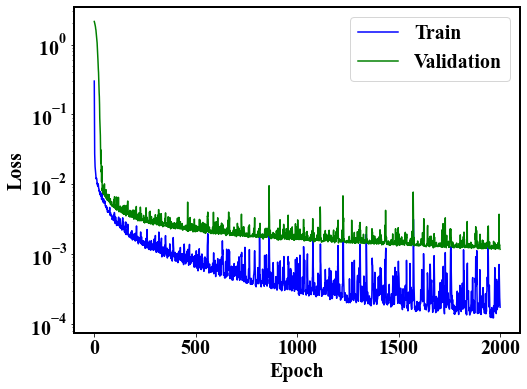

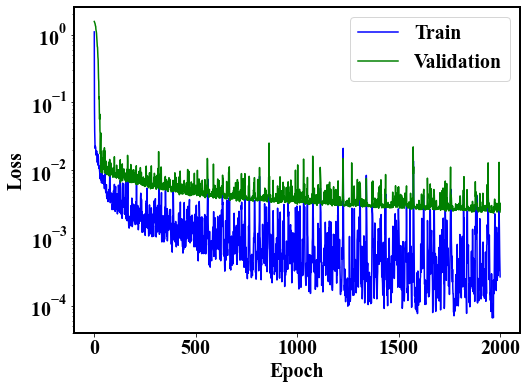

In [121]:
#Plots

#(1) loss for training and validation for sigma_output_loss

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)


fig, ax = plt.subplots(figsize=(8,6))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    #ax.spines[axis].set_color("gold")
    ax.spines[axis].set_zorder(0)




plt.xlabel('Epoch',**font)
plt.ylabel('Loss',**font)
loss1 = plt.plot(history.history["output_1_loss"], color='b',label='Train')

loss2 = plt.plot(history.history["val_output_1_loss"], color='g',label='Validation')

plt.legend()
plt.yscale('log')
plt.savefig('sigma_loss.png', dpi=300)
plt.show()


#(2) loss for training and validation for delta_output_loss

fig, ax = plt.subplots(figsize=(8,6))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    #ax.spines[axis].set_color("gold")
    ax.spines[axis].set_zorder(0)


plt.xlabel('Epoch',**font)
plt.ylabel('Loss',**font)
loss1 = plt.plot(history.history["output_2_loss"], color='b',label='Train')

loss2 = plt.plot(history.history["val_output_2_loss"], color='g',label='Validation')

plt.legend()
plt.yscale('log')
plt.savefig('delta_loss.png', dpi=300)
plt.show()





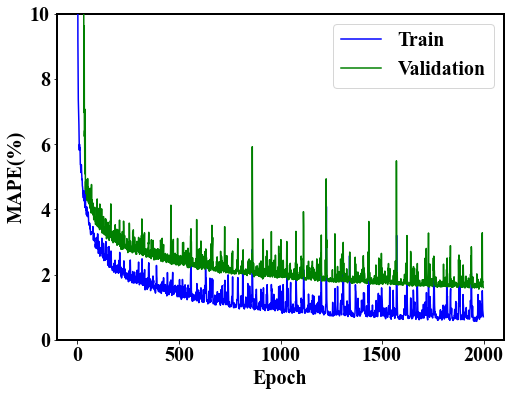

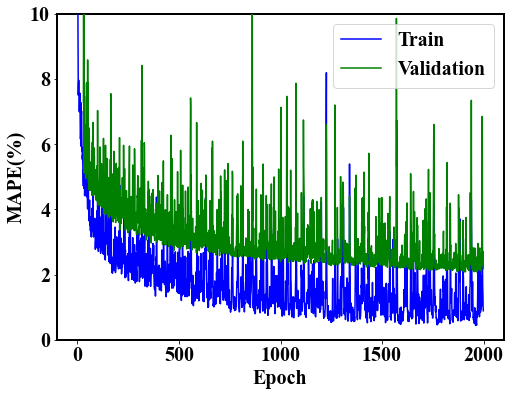

In [122]:
#(2) MAPE for training, validation, test

fig, ax = plt.subplots(figsize=(8,6))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    #ax.spines[axis].set_color("gold")
    ax.spines[axis].set_zorder(0)


plt.xlabel('Epoch',**font)
plt.ylabel('MAPE(%)',**font)
loss1 = plt.plot(history.history["output_1_mean_absolute_percentage_error"], color='b',label='Train')
loss2 = plt.plot(history.history["val_output_1_mean_absolute_percentage_error"], color='g',label='Validation')

plt.ylim([0, 10])


plt.legend()
#plt.yscale('log')
plt.savefig('MAPE_sigma.png', dpi=300)
plt.show()




fig, ax = plt.subplots(figsize=(8,6))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    #ax.spines[axis].set_color("gold")
    ax.spines[axis].set_zorder(0)


plt.xlabel('Epoch',**font)
plt.ylabel('MAPE(%)',**font)
loss1 = plt.plot(history.history["output_2_mean_absolute_percentage_error"], color='b',label='Train')
loss2 = plt.plot(history.history["val_output_2_mean_absolute_percentage_error"], color='g',label='Validation')

plt.ylim([0, 10])


plt.legend()
#plt.yscale('log')
plt.savefig('MAPE_delta.png', dpi=300)
plt.show()





In [57]:
#predict the image
coh_train = model.predict(X_train)
coh_test = model.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [58]:
#True values
sigma_train = []
delta_train = []

sigma_test = []
delta_test = []

for coh in y_train:
    sigma_train.append((coh[0]-1)*(350-150)+150)
    delta_train.append((coh[1]-1)*(0.15-0.05)+0.05)
sigma_train = np.asarray(sigma_train) #train_true
delta_train = np.asarray(delta_train)


for coh in y_test:
    sigma_test.append((coh[0]-1)*(350-150)+150)
    delta_test.append((coh[1]-1)*(0.15-0.05)+0.05)
sigma_test = np.asarray(sigma_test) #test_true
delta_test = np.asarray(delta_test)



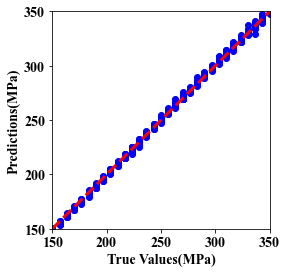

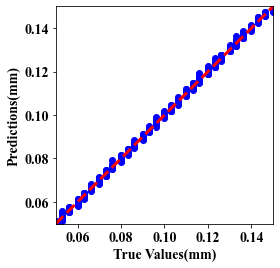

In [129]:
#plot the train results
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
#fig = plt.figure(figsize=(5,5))
plt.scatter(sigma_train, (coh_train[0]-1)*(350-150)+150,c='b')
plt.xlabel('True Values(MPa)',**font)
plt.ylabel('Predictions(MPa)',**font)
plt.axis('equal')
plt.axis('square')
plt.xlim([150, 350])
plt.ylim([150, 350])
plt.plot([0, 500], [0, 500],'r--', linewidth=3)
plt.savefig('sigma_train.png', dpi=300)
plt.show()



plt.scatter(delta_train, (coh_train[1]-1)*(0.15-0.05)+0.05,c='b')
plt.xlabel('True Values(mm)',**font)
plt.ylabel('Predictions(mm)',**font)
plt.axis('equal')
plt.axis('square')
plt.xlim([0.05,0.15])
plt.ylim([0.05,0.15])
plt.plot([0, 0.2], [0, 0.2],'r--', linewidth=3)
plt.savefig('delta_train.png', bbox_inches='tight',dpi=300)
plt.show()



In [130]:
#get R2 value
R2 = stats.linregress(sigma_train, (coh_train[0].ravel()-1)*(350-150)+150)
R2

R2 = stats.linregress(delta_train, (coh_train[1].ravel()-1)*(350-150)+150)
R2

LinregressResult(slope=2003.9596841108012, intercept=50.19688993029365, rvalue=0.9995731742330091, pvalue=0.0, stderr=2.2313039916681516, intercept_stderr=0.23473648511740425)

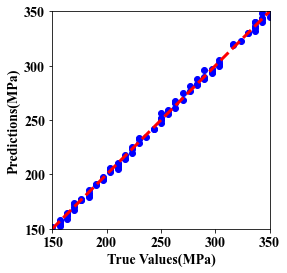

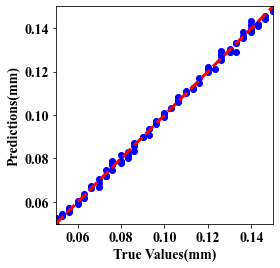

In [131]:
#plot test
plt.rc('font', **font)
#fig = plt.figure(figsize=(5,5))
plt.scatter(sigma_test, (coh_test[0]-1)*(350-150)+150,c='b')
plt.xlabel('True Values(MPa)',**font)
plt.ylabel('Predictions(MPa)',**font)
plt.axis('equal')
plt.axis('square')
plt.xlim([150, 350])
plt.ylim([150, 350])
plt.plot([0, 500], [0, 500],'r--', linewidth=3)
plt.savefig('sigma_test.png', dpi=300)
plt.show()



plt.scatter(delta_test, (coh_test[1]-1)*(0.15-0.05)+0.05,c='b')
plt.xlabel('True Values(mm)',**font)
plt.ylabel('Predictions(mm)',**font)
plt.axis('equal')
plt.axis('square')
plt.xlim([0.05,0.15])
plt.ylim([0.05,0.15])
plt.plot([0, 0.2], [0, 0.2],'r--', linewidth=3)
plt.savefig('delta_test.png', bbox_inches='tight',dpi=300)
plt.show()


In [132]:
#get R2 value
R2 = stats.linregress(sigma_test, (coh_test[0].ravel()-1)*(350-150)+150)
print(R2)

R2 = stats.linregress(delta_test, (coh_test[1].ravel()-1)*(350-150)+150)
print(R2)

LinregressResult(slope=1.0064402154087304, intercept=-1.6783680458912045, rvalue=0.9990743845642618, pvalue=1.2798455223286233e-131, stderr=0.004445883994405837, intercept_stderr=1.1195106746730294)
LinregressResult(slope=1988.6667091160537, intercept=51.32745159617383, rvalue=0.9988574668775663, pvalue=2.807542715504096e-127, stderr=9.761622159012838, intercept_stderr=1.0182570539665643)


In [ ]:
def plot_metrics(metric_name):
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.show()


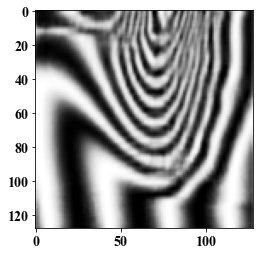

In [120]:
img_size =128
newsize=(img_size,img_size)


import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img =  asarray(Image.open("./exp_fringe/exp_pad_pred_499_model3_eq.png").resize(newsize))

#gray_img = rgb2gray(img[0])    
#gray.resize(newsize)




#gray_img = img[20:105, 31:95]

gray_img = img[:, :]
img_size =128

gray_img =gray_img /255


gray_img =gray_img-np.mean(gray_img)

#check one img
plt.imshow(gray_img,cmap='gray')

images_exp_raw= (gray_img.reshape(-1, gray_img.shape[0], gray_img.shape[1], 1))


In [115]:
coh_test_exp = model.predict(images_exp_raw)

In [116]:
exp_sigma_c = (coh_test_exp[0]-1)*(350-150)+150
exp_delta_f = (coh_test_exp[1]-1)*(0.15-0.05)+0.05

exp_toughness = 0.5*exp_sigma_c*1000*exp_delta_f

In [117]:
exp_sigma_c

array([[272.32748]], dtype=float32)

In [118]:
exp_delta_f

array([[0.13470128]], dtype=float32)

In [119]:
exp_toughness

array([[18341.43]], dtype=float32)